In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
from imblearn.over_sampling import SMOTE  

In [2]:
import models
import class_sampling
import train
import metric_utils
import inference
import loss_fns
import torchvision.ops 

In [3]:
NUM_CLASSES = 10
n_epochs = 30
batch_size_train = 64
batch_size_test = 1000
momentum = 0

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (0, 1)
ratio = (100, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
col_names = ["name", 
            "num_classes", 
            "classes_used", 
            "ratio", 
            "learning_rate", 
            "mean_0", "variance_0",
            "mean_10", "variance_10",
            "mean_20", "variance_20",
            "mean_30", "variance_30",
          #   "mean_40", "variance_40",
          #   "mean_50", "variance_50",
             "cap"]

rows = []

In [5]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)

triplet_train_CIFAR10 = class_sampling.ForTripletLoss(reduced_train_CIFAR10, smote=False)
triplet_ratio_train_CIFAR10 = class_sampling.ForTripletLoss(ratio_train_CIFAR10, smote=False)

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10, 5000 * NUM_CLASSES_REDUCED)
triplet_smote_train_CIFAR10 = class_sampling.ForTripletLoss(smote_train_CIFAR10, smote=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(triplet_smote_train_CIFAR10.class0_images.shape)
print(triplet_smote_train_CIFAR10.class1_images.shape)

torch.Size([5000, 3, 32, 32])
torch.Size([50, 3, 32, 32])


In [7]:
triplet_smote_train_CIFAR10.labels

tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32)

In [8]:
targets = ratio_train_CIFAR10.labels 

class_count = np.unique(targets, return_counts=True)[1]
print(class_count)

weight = 1. / class_count

samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)
undersampler_smote = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * 50 * NUM_CLASSES_REDUCED), replacement=False)
weight *= class_count[0]

[5000   50]


In [9]:
beta = 0.999 

exp = np.empty_like(targets)
for i, count in enumerate(class_count):
    exp[targets==i] = count
effective_weights = (1 - beta) / ( 1 - (beta ** torch.from_numpy(exp)))

In [10]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_smote_undersampled = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler_smote)

train_loader_tripletloss = DataLoader(triplet_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_tripletloss_ratio = DataLoader(triplet_ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

train_loader_tripletloss_smote = DataLoader(triplet_smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [ ]:
# 2 CLASS normal

momentum=0
learning_rates = [5e-4, 1e-3]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


In [65]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []


In [12]:
# 2 CLASS ratio

momentum=0
learning_rates = [1e-3, 1e-4, 5e-4, 5e-3]

learning_rate_aucs = []
learning_rate_train_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                _, train_auc = metric_utils.auc_sigmoid(train_loader_ratio, network) 
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.0020350258350372314, AUC: 0.6529435


Test set: Avg. loss: 0.0018120235204696655, AUC: 0.6530240000000002


Test set: Avg. loss: 0.0010293059689131113, AUC: 0.668872


Test set: Avg. loss: 0.001586657702922821, AUC: 0.7140299999999998


Test set: Avg. loss: 0.0010288638518293305, AUC: 0.736928


Test set: Avg. loss: 0.0013753380179405213, AUC: 0.739265


Test set: Avg. loss: 0.0011858412239811207, AUC: 0.7685119999999999


Test set: Avg. loss: 0.0007551872730255127, AUC: 0.6657620000000001


Test set: Avg. loss: 0.002787360668182373, AUC: 0.6875020000000001


Test set: Avg. loss: 0.0008929764428222091, AUC: 0.7381840000000001


Test set: Avg. loss: 0.0019024794697761536, AUC: 0.735419


Test set: Avg. loss: 0.0007972857817122251, AUC: 0.824272


Test set: Avg. loss: 0.001780514895915985, AUC: 0.8002449999999999


Test set: Avg. loss: 0.0007506171086489564, AUC: 0.867892


Test set: Avg. loss: 0.007656799077987671, AUC: 0.357271


Test set: Avg. loss: 0.002191634


Test set: Avg. loss: 0.002572161316871643, AUC: 0.5555669999999999


Test set: Avg. loss: 0.0009350464684833394, AUC: 0.54104


Test set: Avg. loss: 0.003061597228050232, AUC: 0.6727259999999999


Test set: Avg. loss: 0.0032712137699127198, AUC: 0.501175


Test set: Avg. loss: 0.0010851466581040974, AUC: 0.507844


Test set: Avg. loss: 0.0030594792366027833, AUC: 0.565909


Test set: Avg. loss: 0.0010099006753119797, AUC: 0.566432


Test set: Avg. loss: 0.0026028387546539306, AUC: 0.6164085


Test set: Avg. loss: 0.0009181819367453013, AUC: 0.605664


Test set: Avg. loss: 0.0032295290231704713, AUC: 0.5874085


Test set: Avg. loss: 0.0014447757601737975, AUC: 0.7830085


Test set: Avg. loss: 0.0009910186712104496, AUC: 0.8013079999999999


Test set: Avg. loss: 0.0012968756556510925, AUC: 0.8132029999999999


Test set: Avg. loss: 0.0010575488423651988, AUC: 0.838224


Test set: Avg. loss: 0.0014231621026992798, AUC: 0.83391


Test set: Avg. loss: 0.0008838533683873639, AUC: 0.857556





Test set: Avg. loss: 0.0009399736156262974, AUC: 0.86164


Test set: Avg. loss: 0.0015783169865608215, AUC: 0.8476490000000001


Test set: Avg. loss: 0.0007382010094968989, AUC: 0.900012


Test set: Avg. loss: 0.0022254493236541746, AUC: 0.45958600000000005


Test set: Avg. loss: 0.001722590446472168, AUC: 0.711756


Test set: Avg. loss: 0.000926684569014181, AUC: 0.7398999999999999


Test set: Avg. loss: 0.0012482515573501588, AUC: 0.8040189999999999


Test set: Avg. loss: 0.0011589160163213712, AUC: 0.9036


Test set: Avg. loss: 0.0013439211249351502, AUC: 0.8534299999999999


Test set: Avg. loss: 0.0007977260420523067, AUC: 0.939456


Test set: Avg. loss: 0.0016305903792381287, AUC: 0.399731


Test set: Avg. loss: 0.001686771333217621, AUC: 0.728855


Test set: Avg. loss: 0.0009271248459520907, AUC: 0.7390960000000001


Test set: Avg. loss: 0.0014608917236328125, AUC: 0.7759060000000002


Test set: Avg. loss: 0.0010075070543011815, AUC: 0.814392


Test set: Avg. loss: 0.00143611270

In [13]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [20]:
# 2 CLASS oversampled

momentum=0
learning_rates = [1e-3, 5e-3]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.005691136598587036, AUC: 0.7166170000000001


Test set: Avg. loss: 0.000588998019695282, AUC: 0.858235


Test set: Avg. loss: 0.0005738674998283386, AUC: 0.8568835


Test set: Avg. loss: 0.000547566682100296, AUC: 0.864155


Test set: Avg. loss: 0.0024350250959396364, AUC: 0.573198


Test set: Avg. loss: 0.0006682571172714234, AUC: 0.6593775


Test set: Avg. loss: 0.0006437829434871674, AUC: 0.686171


Test set: Avg. loss: 0.0006789233386516571, AUC: 0.644326


Test set: Avg. loss: 0.002518909811973572, AUC: 0.47361


Test set: Avg. loss: 0.0005086382031440735, AUC: 0.861209


Test set: Avg. loss: 0.0012186179161071777, AUC: 0.863998


Test set: Avg. loss: 0.0014082735776901245, AUC: 0.857443


Test set: Avg. loss: 0.0012410336136817932, AUC: 0.405966


Test set: Avg. loss: 0.0007035685777664185, AUC: 0.39492449999999996


Test set: Avg. loss: 0.0006275011897087097, AUC: 0.823426


Test set: Avg. loss: 0.00088487908244133, AUC: 0.843707


Test set: Avg. loss: 0.

In [22]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:14]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [33]:
# 2 CLASS undersampled

momentum=0
learning_rates = [1e-4, 1e-5]

learning_rate_aucs = []


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.002664048075675964, AUC: 0.35103100000000004


Test set: Avg. loss: 0.0008118733763694763, AUC: 0.39093300000000003


Test set: Avg. loss: 0.0007359330058097839, AUC: 0.42988400000000004


Test set: Avg. loss: 0.0007080410122871399, AUC: 0.476849


Test set: Avg. loss: 0.005757878303527832, AUC: 0.4101775


Test set: Avg. loss: 0.0008514148592948913, AUC: 0.663575


Test set: Avg. loss: 0.0006793743073940277, AUC: 0.6388240000000001


Test set: Avg. loss: 0.0006851064562797546, AUC: 0.599984


Test set: Avg. loss: 0.001174522042274475, AUC: 0.498127


Test set: Avg. loss: 0.0009026037454605102, AUC: 0.569188


Test set: Avg. loss: 0.0007478025853633881, AUC: 0.5202549999999999


Test set: Avg. loss: 0.0007039127349853516, AUC: 0.5297069999999999


Test set: Avg. loss: 0.0009038377702236175, AUC: 0.47197


Test set: Avg. loss: 0.0007971824407577515, AUC: 0.48862799999999995


Test set: Avg. loss: 0.0007626304626464844, AUC: 0.494027


Test set: Avg. loss: 0.00074

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [10]:
# 2 Class Weighted Loss 

momentum=0
learning_rates = [1e-3, 1e-4]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['pos_weight'] = torch.tensor([weight[1]])


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                _, train_auc = metric_utils.auc_sigmoid(train_loader_ratio, network) 
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.005942921638488769, AUC: 0.567106


Test set: Avg. loss: 0.000693460613489151, AUC: 0.5014949999999999


Test set: Avg. loss: 0.01101493201633491, AUC: 0.498


Test set: Avg. loss: 0.0006932864785194397, AUC: 0.49949899999999997


Test set: Avg. loss: 0.010916043460959255, AUC: 0.49879999999999997


Test set: Avg. loss: 0.0006932151615619659, AUC: 0.49949999999999994


Test set: Avg. loss: 0.010851628886591089, AUC: 0.4994


Test set: Avg. loss: 0.002580095887184143, AUC: 0.52986


Test set: Avg. loss: 0.0005952333509922028, AUC: 0.8429355000000001


Test set: Avg. loss: 0.01112000550373946, AUC: 0.9091279999999999


Test set: Avg. loss: 0.0005518969893455505, AUC: 0.8701230000000001


Test set: Avg. loss: 0.009937099761301929, AUC: 0.9495319999999999


Test set: Avg. loss: 0.0005057350695133209, AUC: 0.883475


Test set: Avg. loss: 0.009651631164078665, AUC: 0.956386


Test set: Avg. loss: 0.0009529277384281159, AUC: 0.445674


Test set: Avg. loss: 0.0006936190


Test set: Avg. loss: 0.0006944212913513184, AUC: 0.5038005


Test set: Avg. loss: 0.0113616940054563, AUC: 0.5663979999999998


Test set: Avg. loss: 0.007881028413772582, AUC: 0.4730995


Test set: Avg. loss: 0.000692995399236679, AUC: 0.500478


Test set: Avg. loss: 0.010630261945252371, AUC: 0.4824239999999999


Test set: Avg. loss: 0.0006933453977108002, AUC: 0.5038505


Test set: Avg. loss: 0.010637967291444835, AUC: 0.503172


Test set: Avg. loss: 0.0006934205293655395, AUC: 0.5003850000000001


Test set: Avg. loss: 0.010647759791648033, AUC: 0.503188



In [11]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [9]:
# 2 CLASS SMOTE

momentum=0
learning_rates = [5e-3, 1e-4, 1e-3]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['loss_cap'] = None


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_with_smote(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001


Test set: Avg. loss: 0.0005302040874958038, AUC: 0.8983949999999999


Test set: Avg. loss: 0.000634994238615036, AUC: 0.825839


Test set: Avg. loss: 0.000631784051656723, AUC: 0.8181655


Test set: Avg. loss: 0.0032240989208221437, AUC: 0.38664699999999996


Test set: Avg. loss: 0.0006933937072753906, AUC: 0.4995


Test set: Avg. loss: 0.0006931578814983368, AUC: 0.4995


Test set: Avg. loss: 0.0006931533217430115, AUC: 0.4995


Test set: Avg. loss: 0.006873347997665405, AUC: 0.683021


Test set: Avg. loss: 0.0005754781067371369, AUC: 0.821701


Test set: Avg. loss: 0.0006926852166652679, AUC: 0.7723930000000001


Test set: Avg. loss: 0.0008418424427509307, AUC: 0.7373959999999999


Test set: Avg. loss: 0.001451125681400299, AUC: 0.47390000000000004


Test set: Avg. loss: 0.0006959674656391144, AUC: 0.4995


Test set: Avg. loss: 0.0006931877434253693, AUC: 0.5


Test set: Avg. loss: 0.0006931476294994354, AUC: 0.5



In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [9]:
# 2 CLASS SMOTE with undersampling

momentum=0
learning_rates = [5e-3, 1e-4, 1e-3]

learning_rate_aucs = []

loss_fn_args = {}
loss_fn_args['loss_cap'] = None


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_with_smote(epoch, train_loader_smote_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled_smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001


Test set: Avg. loss: 0.0008796696960926056, AUC: 0.5090165


Test set: Avg. loss: 0.0011526485085487366, AUC: 0.5088189999999999



KeyboardInterrupt: 

In [17]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [10]:
# 2 Class Capped SMOTE 

momentum=0
learning_rates = [1e-4, 5e-4, 1e-3]


cap_aucs = []

caps = [1, 5, 10]

for cap in caps:
    
    loss_fn_args = {}
    loss_fn_args['loss_cap'] = cap
    
    learning_rate_aucs = []

    for learning_rate in learning_rates:
        aucs = []
        for i in range(10):
            model_aucs = []
            network = models.ConvNet(NUM_CLASSES_REDUCED)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
            model_aucs.append(auc)
            for epoch in range(n_epochs):
                _, _ = train.train_sigmoid_with_smote(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
                if (epoch + 1) % 10 == 0: 
                    _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                    model_aucs.append(auc)
            aucs.append(model_aucs)
        learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

    auc_mean = np.mean(learning_rate_aucs, axis=1)
    auc_variance = np.var(learning_rate_aucs, axis=1)
    
    
    cap_aucs.append([auc_mean, auc_variance])

    
    
for i in range(len(cap_aucs)):
    auc_mean = cap_aucs[i][0]
    auc_variance = cap_aucs[i][1]
    cap = caps[i]
    for i in range(len(learning_rates)): 
        row = ["capped_smote", 2, nums, ratio, learning_rates[i],
                auc_mean[i][0], auc_variance[i][0], 
                auc_mean[i][1], auc_variance[i][1],
                auc_mean[i][2], auc_variance[i][2],
                auc_mean[i][3], auc_variance[i][3], cap]
        rows.append(row)

print(rows)



Test set: Avg. loss: 0.000964056670665741, AUC: 0.520941


Test set: Avg. loss: 0.002801976799964905, AUC: 0.603904


Test set: Avg. loss: 0.0023315074443817137, AUC: 0.6346155000000001


Test set: Avg. loss: 0.001935368299484253, AUC: 0.6770020000000001


Test set: Avg. loss: 0.0015654934048652648, AUC: 0.5420925


Test set: Avg. loss: 0.0012076606750488282, AUC: 0.6018205


Test set: Avg. loss: 0.0006806973814964295, AUC: 0.745674


Test set: Avg. loss: 0.0006647063195705414, AUC: 0.8141400000000001


Test set: Avg. loss: 0.007722229480743408, AUC: 0.477479


Test set: Avg. loss: 0.002731645941734314, AUC: 0.535709


Test set: Avg. loss: 0.00225200891494751, AUC: 0.597371


Test set: Avg. loss: 0.0006625505685806275, AUC: 0.812553


Test set: Avg. loss: 0.0012214133143424988, AUC: 0.549326


Test set: Avg. loss: 0.002234416365623474, AUC: 0.6193310000000001


Test set: Avg. loss: 0.0015321336984634398, AUC: 0.7092240000000001


Test set: Avg. loss: 0.0010821450352668763, AUC: 0.7708


Test set: Avg. loss: 0.0006544892489910126, AUC: 0.7352115000000004


Test set: Avg. loss: 0.0006303447484970093, AUC: 0.807039


Test set: Avg. loss: 0.0006590245068073272, AUC: 0.7533475000000001


Test set: Avg. loss: 0.0007899287045001984, AUC: 0.670127


Test set: Avg. loss: 0.0006518673598766327, AUC: 0.773551


Test set: Avg. loss: 0.0006446815729141235, AUC: 0.7977499999999997


Test set: Avg. loss: 0.0006375725269317626, AUC: 0.8204609999999999


Test set: Avg. loss: 0.003895806074142456, AUC: 0.585514


Test set: Avg. loss: 0.00063050776720047, AUC: 0.8090909999999999


Test set: Avg. loss: 0.0006110207438468934, AUC: 0.831422


Test set: Avg. loss: 0.0006125293970108033, AUC: 0.8279915000000001


Test set: Avg. loss: 0.0012400510311126709, AUC: 0.5677885


Test set: Avg. loss: 0.0006437472999095917, AUC: 0.7166265


Test set: Avg. loss: 0.0006125587224960328, AUC: 0.8170925


Test set: Avg. loss: 0.0006116727888584137, AUC: 0.8358605000000001


Test set: Avg. loss: 0.000811


Test set: Avg. loss: 0.0006174682676792144, AUC: 0.8310925


Test set: Avg. loss: 0.007684100151062012, AUC: 0.4070105


Test set: Avg. loss: 0.0006202857792377472, AUC: 0.8066605


Test set: Avg. loss: 0.0006176858246326447, AUC: 0.816376


Test set: Avg. loss: 0.0006103067696094513, AUC: 0.830536


Test set: Avg. loss: 0.0013037946224212647, AUC: 0.638735


Test set: Avg. loss: 0.0005673413872718811, AUC: 0.789875


Test set: Avg. loss: 0.0005420814156532288, AUC: 0.822748


Test set: Avg. loss: 0.0005116104185581207, AUC: 0.8447049999999999


Test set: Avg. loss: 0.0007415176630020142, AUC: 0.5973919999999999


Test set: Avg. loss: 0.0006263005435466766, AUC: 0.8075709999999999


Test set: Avg. loss: 0.0005980682075023651, AUC: 0.8442180000000001


Test set: Avg. loss: 0.0006044952571392059, AUC: 0.84839


Test set: Avg. loss: 0.000744761973619461, AUC: 0.6458790000000001


Test set: Avg. loss: 0.0006299040615558624, AUC: 0.7886010000000001


Test set: Avg. loss: 0.0006408950388431

In [11]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = (col_names[0:14]))

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# 2 CLASS Focal Loss

momentum=0
learning_rates = [1e-4, 1e-5]

learning_rate_aucs = []

loss_fn_args = {}


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SigmoidFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


In [38]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

NameError: name 'df2' is not defined

In [12]:
# distance + capped loss
momentum=0
learning_rates = [1e-3, 5e-4, 1e-4]


    
loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_euclidean_distance(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["distance_capped_smote_fixed1", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.0008439761102199554, AUC: 0.458455


Test set: Avg. loss: 0.0005637407302856445, AUC: 0.8840095000000001


Test set: Avg. loss: 0.0004919547736644745, AUC: 0.9045030000000001


Test set: Avg. loss: 0.000604819118976593, AUC: 0.8537779999999999


Test set: Avg. loss: 0.009120811462402343, AUC: 0.447008


Test set: Avg. loss: 0.0006216726899147034, AUC: 0.834169


Test set: Avg. loss: 0.0005918767750263214, AUC: 0.8661705000000002


Test set: Avg. loss: 0.0006442052721977234, AUC: 0.8375685


Test set: Avg. loss: 0.0017059873938560486, AUC: 0.48120300000000005


Test set: Avg. loss: 0.0005866606831550598, AUC: 0.8596909999999999


Test set: Avg. loss: 0.0005112299025058746, AUC: 0.8946060000000001


Test set: Avg. loss: 0.0006069133877754211, AUC: 0.857534


Test set: Avg. loss: 0.0013419885039329528, AUC: 0.46782999999999997


Test set: Avg. loss: 0.0006542591452598572, AUC: 0.769544


Test set: Avg. loss: 0.000525863379240036, AUC: 0.8919025


Test set: Avg. los

In [13]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [9]:
# cosine distance + capped loss
momentum=0
learning_rates = [1e-3, 5e-4, 1e-4]


    
loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_cosine_distance(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["cosine_distance_capped_smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 5]
    rows.append(row)


Test set: Avg. loss: 0.0011436396837234497, AUC: 0.457495


Test set: Avg. loss: 0.0005700503587722778, AUC: 0.8682060000000001


Test set: Avg. loss: 0.0005558769106864929, AUC: 0.877864


Test set: Avg. loss: 0.0007304551005363465, AUC: 0.661598


Test set: Avg. loss: 0.00553279709815979, AUC: 0.2802325


Test set: Avg. loss: 0.0006947735548019409, AUC: 0.499513


Test set: Avg. loss: 0.0006955170035362244, AUC: 0.501002


Test set: Avg. loss: 0.0006960488855838776, AUC: 0.502988


Test set: Avg. loss: 0.0016392868161201478, AUC: 0.362875


Test set: Avg. loss: 0.0006916555464267731, AUC: 0.5249240000000001


Test set: Avg. loss: 0.0006274392902851104, AUC: 0.8069995


Test set: Avg. loss: 0.0005601176917552948, AUC: 0.8731455


Test set: Avg. loss: 0.0008223848342895508, AUC: 0.448507


Test set: Avg. loss: 0.0005955914556980133, AUC: 0.865737


Test set: Avg. loss: 0.0006267938613891601, AUC: 0.8331379999999999


Test set: Avg. loss: 0.0006058297157287598, AUC: 0.8535895000000001


In [11]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# capped loss with everything capped + cosine distance 
momentum=0
learning_rates = [5e-4]

    
loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid_cosine_distance(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.AllCappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)


for i in range(len(learning_rates)): 
    row = ["cosine_distance_all_capped", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# 2 class triplet loss no ratio 
# no smote 

# note: sometimes can get a very high accuracy but may diverge

momentum=0
learning_rates = [(1e-7, 1e-5)]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(3): 
        model_aucs = []
        embed_network = models.ConvNetOnlyEmbeddings(2)
        linear_probe = models.ConvNetLinearProbe(2)
        complete_network = models.CompleteConvNet(embed_network, linear_probe)
        embed_optimizer = optim.SGD(embed_network.parameters(), lr=learning_rate[0], momentum=momentum)
        linear_optimizer = optim.SGD(complete_network.parameters(), lr=learning_rate[1], momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(15):
            _, train_losses = train.train_triplet_loss(epoch, train_loader_tripletloss, embed_network, embed_optimizer, verbose=False)
            print("Train loss: " + str(np.mean(np.array(train_losses))))
        for epoch in range(50):
            _, _ = train.train_linear_probe(epoch, train_loader_reduced, complete_network, linear_optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network, embeddings=True)
            if (epoch + 1) % 10 == 0: 
                model_aucs.append(auc) 
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)


learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["triplet_loss", 2, nums, (1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 
           auc_mean[i][4], auc_variance[i][4],
           auc_mean[i][5], auc_variance[i][5],
           None]
    rows.append(row)


Test set: Avg. loss: 0.001768422782421112, AUC: 0.28336300000000003

Train loss: 70.02603407574307
Train loss: 40.6319688626915
Train loss: 21.990111458073756
Train loss: 11.84145113313274
Train loss: 19.93373324764762
Train loss: 14.16543515624514
Train loss: 20.17667099055211
Train loss: 12.65901572727094
Train loss: 13.934915872136498
Train loss: 11.2076398586012
Train loss: 13.735528610314534
Train loss: 7.539629877372912
Train loss: 9.376250748421736
Train loss: 9.127776496349627
Train loss: 9.746891628025443

Test set: Avg. loss: 0.0007499554753303528, AUC: 0.31338900000000003


Test set: Avg. loss: 0.0007270706295967102, AUC: 0.37248149999999997


Test set: Avg. loss: 0.0007159764170646668, AUC: 0.39546499999999996


Test set: Avg. loss: 0.0007094129025936127, AUC: 0.4172595


Test set: Avg. loss: 0.0007056478261947632, AUC: 0.426484


Test set: Avg. loss: 0.000702925056219101, AUC: 0.436062


Test set: Avg. loss: 0.0007007266283035278, AUC: 0.44378599999999996


Test set: Avg.

In [32]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [11]:
# 2 class triplet loss with ratio 
# no smote 

momentum=0
learning_rates = [(1e-7, 1e-5)]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(3): 
        model_aucs = []
        embed_network = models.ConvNetOnlyEmbeddings(2)
        linear_probe = models.ConvNetLinearProbe(2)
        complete_network = models.CompleteConvNet(embed_network, linear_probe)
        embed_optimizer = optim.SGD(embed_network.parameters(), lr=learning_rate[0], momentum=momentum)
        linear_optimizer = optim.SGD(complete_network.parameters(), lr=learning_rate[1], momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(15):
            _, train_losses = train.train_triplet_loss(epoch, train_loader_tripletloss_ratio, embed_network, embed_optimizer, verbose=False)
            print("Train loss: " + str(np.mean(np.array(train_losses))))
        for epoch in range(50):
            _, _ = train.train_linear_probe(epoch, train_loader_reduced, complete_network, linear_optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network, embeddings=True)
            if (epoch + 1) % 10 == 0: 
                model_aucs.append(auc) 
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)


learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["triplet_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 
           auc_mean[i][4], auc_variance[i][4],
           auc_mean[i][5], auc_variance[i][5],
           None]
    rows.append(row)


Test set: Avg. loss: 0.0007769797742366791, AUC: 0.581019

Train loss: 16.096790712090986
Train loss: 7.95101783849016
Train loss: 1.6742434924161886
Train loss: 0.0
Train loss: 6.369154097158698
Train loss: 1.0685905746266813
Train loss: 0.9919730077815961
Train loss: 4.3510085480122624
Train loss: 0.0
Train loss: 0.0
Train loss: 0.0
Train loss: 1.729099128819719
Train loss: 0.0
Train loss: 2.9074361294130737
Train loss: 0.0

Test set: Avg. loss: 0.0007081505060195923, AUC: 0.595766


Test set: Avg. loss: 0.0006918745040893554, AUC: 0.599685


Test set: Avg. loss: 0.0006822091042995453, AUC: 0.606827


Test set: Avg. loss: 0.0006758022308349609, AUC: 0.614831


Test set: Avg. loss: 0.0006717154681682586, AUC: 0.620797


Test set: Avg. loss: 0.0006670982539653778, AUC: 0.6299465


Test set: Avg. loss: 0.0006633270978927612, AUC: 0.641555


Test set: Avg. loss: 0.0006615970730781555, AUC: 0.647514


Test set: Avg. loss: 0.0006594435572624207, AUC: 0.6563729999999999


Test set: Avg. lo


Test set: Avg. loss: 0.0006901566684246063, AUC: 0.5230110000000001


Test set: Avg. loss: 0.0006899235546588897, AUC: 0.5261325


Test set: Avg. loss: 0.0006896623373031616, AUC: 0.5253125


Test set: Avg. loss: 0.0006894396543502808, AUC: 0.5309490000000001


Test set: Avg. loss: 0.0006897644698619842, AUC: 0.52842


Test set: Avg. loss: 0.0006899001598358154, AUC: 0.525083


Test set: Avg. loss: 0.0006898137331008911, AUC: 0.5242764999999999


Test set: Avg. loss: 0.0006899007260799408, AUC: 0.5234755


Test set: Avg. loss: 0.0006897071897983551, AUC: 0.5284414999999999


Test set: Avg. loss: 0.0006894522905349732, AUC: 0.5316019999999999


Test set: Avg. loss: 0.0006894703507423401, AUC: 0.5321385000000001


Test set: Avg. loss: 0.0006892255246639252, AUC: 0.5359525


Test set: Avg. loss: 0.0006892721951007843, AUC: 0.5328990000000001


Test set: Avg. loss: 0.0006891983449459076, AUC: 0.537638


Test set: Avg. loss: 0.0006890941560268402, AUC: 0.5369265000000001


Test set: Avg. l

In [12]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

ValueError: 14 columns passed, passed data had 18 columns

In [30]:
# triplet loss with SMOTE and cosine distance capped loss 

momentum=0
learning_rates = [(1e-7, 1e-4)]

loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(3): 
        model_aucs = []
        embed_network = models.ConvNetOnlyEmbeddings(2)
        linear_probe = models.ConvNetLinearProbe(2)
        complete_network = models.CompleteConvNet(embed_network, linear_probe)
        embed_optimizer = optim.SGD(embed_network.parameters(), lr=learning_rate[0], momentum=momentum)
        linear_optimizer = optim.SGD(complete_network.parameters(), lr=learning_rate[1], momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(15):
            _, train_losses = train.train_triplet_loss(epoch, train_loader_tripletloss_smote, embed_network, embed_optimizer, verbose=False)
            print("Train triplet loss: " + str(np.mean(np.array(train_losses))))
        for epoch in range(50):
            _, _ = train.train_sigmoid_cosine_distance(epoch, train_loader_smote, complete_network, linear_optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, complete_network, embeddings=True)
            if (epoch + 1) % 10 == 0: 
                model_aucs.append(auc) 
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["cosine_distance_capped_smote_triplet_loss", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3], 
           auc_mean[i][4], auc_variance[i][4],
           auc_mean[i][5], auc_variance[i][5],
           5.0]
    rows.append(row)


Test set: Avg. loss: 0.002908367872238159, AUC: 0.337541

Train triplet loss: 224.1131993069011
Train triplet loss: 14.503459689343812
Train triplet loss: 2.3045721103431314
Train triplet loss: 0.9209006834941306
Train triplet loss: 1.294924501021197
Train triplet loss: 0.7550809907305772
Train triplet loss: 0.9270113535747406
Train triplet loss: 0.7487862869432778
Train triplet loss: 0.2525857892006066
Train triplet loss: 0.45942818321240175
Train triplet loss: 0.1847958750785536
Train triplet loss: 0.10644819022743565
Train triplet loss: 0.2511055499884733
Train triplet loss: 0.08564935216478481
Train triplet loss: 0.05430815022462492

Test set: Avg. loss: 0.0006781926453113556, AUC: 0.6198600000000001


Test set: Avg. loss: 0.000667210340499878, AUC: 0.6874805


Test set: Avg. loss: 0.0006613142788410187, AUC: 0.727465


Test set: Avg. loss: 0.0006528576910495758, AUC: 0.7565990000000002


Test set: Avg. loss: 0.0006457682251930236, AUC: 0.7813000000000001


Test set: Avg. loss: 0.

Train triplet loss: 0.1939485741269057
Train triplet loss: 0.3785654617722627
Train triplet loss: 0.00914804229311123
Train triplet loss: 0.10145357042361217
Train triplet loss: 0.17515371901214502
Train triplet loss: 0.3923213834975176
Train triplet loss: 0.014378716231911046
Train triplet loss: 0.0
Train triplet loss: 0.0

Test set: Avg. loss: 0.0006661825478076935, AUC: 0.681546


Test set: Avg. loss: 0.0006567904353141785, AUC: 0.7220775000000001


Test set: Avg. loss: 0.0006522080004215241, AUC: 0.728313


Test set: Avg. loss: 0.0006458030641078949, AUC: 0.7563310000000001


Test set: Avg. loss: 0.0006477517187595367, AUC: 0.7530370000000001


Test set: Avg. loss: 0.000641948789358139, AUC: 0.7699455000000002


Test set: Avg. loss: 0.0006373808979988099, AUC: 0.783147


Test set: Avg. loss: 0.0006401232182979584, AUC: 0.7701199999999999


Test set: Avg. loss: 0.0006400469243526459, AUC: 0.78073


Test set: Avg. loss: 0.0006371627151966095, AUC: 0.7924995


Test set: Avg. loss: 0.0

In [31]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []


Test set: Avg. loss: 0.0011436396837234497, AUC: 0.457495

tensor([[[208, 229,  13,  ...,   9, 197, 241],
         [  1, 222, 247,  ..., 255,   9, 230],
         [253,   8, 241,  ..., 214, 248,  12],
         ...,
         [111, 131,  32,  ..., 112, 223, 253],
         [218,  40,  76,  ...,  73, 150, 254],
         [ 17, 151, 250,  ..., 153, 173,  89]],

        [[150, 166,  63,  ..., 116, 226,   2],
         [255,  81, 122,  ...,  84, 162, 255],
         [ 22, 170,   0,  ..., 135, 152,  82],
         ...,
         [242, 250, 219,  ..., 251,   0, 244],
         [229, 253, 254,  ..., 140, 119, 136],
         [150, 126, 142,  ..., 241, 205, 185]],

        [[201, 205, 180,  ...,  55,  61,  31],
         [ 19,  39,  19,  ..., 105,  89,  96],
         [169, 155, 173,  ..., 183, 179, 156],
         ...,
         [ 58,  48,  62,  ..., 139, 128, 145],
         [161, 153, 170,  ...,  97, 117,  85],
         [101, 120,  85,  ...,  82,  91, 110]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<Sel

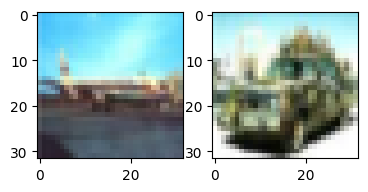

tensor([[[103,  94,  88,  ...,  80, 106,  84],
         [ 91, 107,  91,  ..., 144,  87, 168],
         [152,  99, 149,  ..., 129,  68,  77],
         ...,
         [239,  75,   6,  ...,  77,  83,  88],
         [119,  71,  75,  ...,  77,  20, 248],
         [ 83,  29,   0,  ..., 254,  65,  17]],

        [[243,  66,  14,  ..., 102, 106, 104],
         [134, 132, 128,  ...,  76,  41,  15],
         [ 90,  80,  54,  ..., 255,  61,  26],
         ...,
         [191, 117,  92,  ..., 141, 221,  96],
         [ 79, 192, 223,  ..., 210, 206, 200],
         [254, 253, 239,  ..., 196, 162, 152]],

        [[200, 168, 149,  ..., 108, 193,  79],
         [ 57, 180, 243,  ..., 211, 207, 203],
         [ 15,  13,   0,  ..., 197, 166, 148],
         ...,
         [190, 189, 187,  ...,   1, 241, 252],
         [  0, 241, 253,  ...,  29,  42,  25],
         [ 33,  37,  32,  ...,  30,  32,  30]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


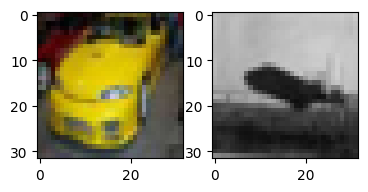

tensor([[[105, 224,  91,  ...,  61,  95, 206],
         [ 74,  93, 203,  ..., 225,  84, 130],
         [237,  95, 125,  ..., 158, 248,  93],
         ...,
         [109, 214,  25,  ...,  92, 181,  44],
         [186, 241,  63,  ...,  73, 133, 246],
         [ 91, 122, 237,  ..., 166,  20,  61]],

        [[166,  14,  64,  ..., 175,   4, 112],
         [202,  10,  87,  ...,  66, 108,   5],
         [104, 102,   6,  ..., 249, 101, 107],
         ...,
         [ 88, 229, 100,  ..., 114,  83,   0],
         [101,  83,   1,  ..., 183,  87, 148],
         [158, 230,  64,  ...,  21, 122,  40]],

        [[ 44, 125,  49,  ...,   7,   1, 144],
         [ 26,  33, 205,  ..., 111,  36, 105],
         [171, 238,  74,  ...,  30, 197,  59],
         ...,
         [174, 229,  51,  ..., 114,  27,  71],
         [127,  30,  75,  ...,  73, 126,  28],
         [ 75, 125,  11,  ..., 177,  11, 111]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


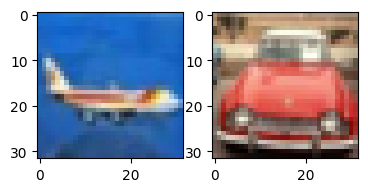

tensor([[[116, 126, 109,  ..., 116, 126, 147],
         [118, 126, 147,  ..., 136, 111, 101],
         [135, 107,  99,  ...,  18,  57,  40],
         ...,
         [ 61,  55, 229,  ..., 143, 242,   2],
         [ 25, 105, 103,  ..., 102,  28,  91],
         [ 74,  30, 108,  ...,  50,  45, 210]],

        [[ 44,  43, 210,  ..., 115, 225, 248],
         [252,  87,  91,  ..., 121,  95, 122],
         [ 99,  36,  91,  ...,  40,  46, 193],
         ...,
         [123, 124, 177,  ..., 189, 118, 174],
         [188, 112, 168,  ...,  40,  55, 221],
         [131, 239,  99,  ..., 100, 127, 199]],

        [[117, 145, 212,  ...,  31, 221, 244],
         [ 33, 220, 244,  ...,  56,  88,  28],
         [132,   7, 101,  ..., 107, 100, 199],
         ...,
         [ 76,  97,  37,  ...,  44,  73, 110],
         [ 45,  71, 114,  ..., 115,  34,  63],
         [117,  36,  66,  ...,  55, 106,  33]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


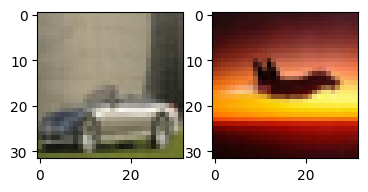

tensor([[[201, 160,  92,  ..., 192,  89,  36],
         [216, 102,  47,  ...,  91, 246, 136],
         [ 77, 234, 121,  ..., 154, 108,  17],
         ...,
         [232, 189, 242,  ...,   9, 229, 174],
         [180, 132,  77,  ..., 186, 156, 121],
         [110, 207, 174,  ..., 221, 193, 208]],

        [[199, 175, 194,  ...,   1, 223, 168],
         [188, 151,  96,  ..., 159, 125,  90],
         [ 96, 243, 192,  ..., 169, 152, 184],
         ...,
         [ 36,  73,  64,  ...,  67,  56, 170],
         [ 89,  92, 193,  ...,  55,  34, 235],
         [197, 191, 164,  ...,  36,  82,  65]],

        [[ 38,  88,  73,  ...,  79,  57, 132],
         [ 62,  63, 167,  ...,  49,  28, 237],
         [199, 190, 164,  ...,  38,  68,  54],
         ...,
         [163, 157, 134,  ..., 144, 189, 175],
         [142, 182, 168,  ...,  86,  57,  87],
         [ 81,  53,  90,  ..., 228, 216, 193]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


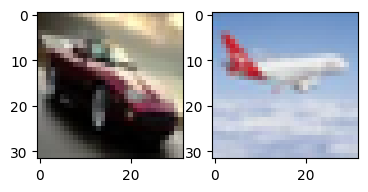

tensor([[[236,  79, 102,  ..., 132, 236,  88],
         [136, 230,  82,  ...,  34, 125, 172],
         [ 27, 122, 168,  ...,  93, 189,  38],
         ...,
         [ 20, 116, 174,  ...,  76, 140, 238],
         [164,  32, 114,  ..., 117, 182,  39],
         [121, 180,  40,  ...,  21, 124, 163]],

        [[  9, 121, 164,  ...,  74, 137, 254],
         [154,  26, 104,  ..., 126, 192,  48],
         [129, 184,  44,  ...,  13, 131, 169],
         ...,
         [114,  80, 104,  ..., 132, 149,  82],
         [135, 146,  57,  ..., 106, 206,  12],
         [ 42,  94,  85,  ...,  82,  64,  96]],

        [[ 96,  87, 114,  ..., 209, 205, 142],
         [200, 199, 118,  ..., 143, 234,  14],
         [ 24,  86,  83,  ...,  76,  35,  65],
         ...,
         [237,  73,  29,  ...,  37, 225,  77],
         [ 40, 226,  79,  ..., 101,  33,  35],
         [ 93,  33,  84,  ...,  96, 111,  32]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


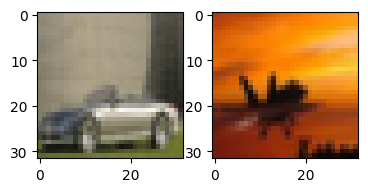

tensor([[[217, 206, 198,  ..., 192, 207, 193],
         [192, 207, 194,  ..., 200, 189, 228],
         [207, 190, 225,  ..., 242, 210, 189],
         ...,
         [232, 240, 213,  ..., 219, 201, 192],
         [ 53,  21,   1,  ..., 246,  24, 249],
         [227, 228, 211,  ..., 223, 234, 232]],

        [[229, 241, 214,  ..., 228, 212, 199],
         [ 64,  35,   5,  ..., 249,  12, 242],
         [216, 206, 192,  ..., 208, 215, 221],
         ...,
         [  4,  46,  38,  ..., 192,   0, 191],
         [190, 254, 185,  ..., 183, 181, 202],
         [190, 178, 227,  ...,   8,  31,  20]],

        [[ 62,  57,  46,  ..., 191,   7, 194],
         [190,   5, 190,  ..., 196, 190, 232],
         [194, 189, 212,  ..., 239,  15,   8],
         ...,
         [248, 251,  24,  ...,  14, 237, 248],
         [  9, 231, 243,  ..., 246,   8, 235],
         [248,   9, 234,  ..., 236, 242,   7]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


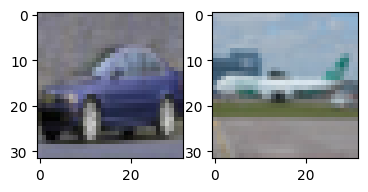

tensor([[[109,  68,  14,  ...,  11, 106,  65],
         [ 11, 106,  65,  ...,  63,  10, 105],
         [ 63,  10, 104,  ..., 101,  59,   6],
         ...,
         [ 61,  15,  92,  ..., 104,  63,  11],
         [ 69,  48,  13,  ...,  18,  84,  61],
         [ 19,  79,  57,  ...,  55,  14,  78]],

        [[ 57,  19,  83,  ..., 102,  61,   9],
         [ 62,  43,  12,  ...,  17,  72,  53],
         [ 19,  69,  51,  ...,  97,  65, 106],
         ...,
         [ 93, 201, 110,  ..., 224, 176,  18],
         [239, 190,  23,  ..., 105,  66,  15],
         [ 76,  56,  23,  ..., 192, 219, 202]],

        [[172, 206, 189,  ..., 226, 179,  11],
         [233, 184,   9,  ..., 108,  69,  18],
         [ 75,  58,  26,  ..., 223, 244, 238],
         ...,
         [215, 213, 199,  ..., 186, 199, 199],
         [185, 197, 197,  ..., 209, 201, 218],
         [215, 200, 214,  ..., 171, 175, 180]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


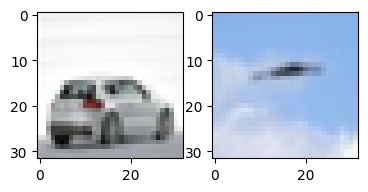

tensor([[[ 64,  72,  83,  ...,  86,  53,  64],
         [ 85,  52,  64,  ...,  87, 108,  77],
         [ 90, 115,  80,  ..., 149, 162, 172],
         ...,
         [236,   5,  61,  ..., 159, 154, 154],
         [ 42,  48,  68,  ...,   4, 225, 233],
         [  2, 232, 240,  ..., 241,  10,  14]],

        [[220, 245,  14,  ..., 109, 105, 108],
         [ 41,  48,  66,  ..., 252, 161, 174],
         [199, 153, 164,  ..., 172, 200, 237],
         ...,
         [218, 238, 236,  ...,  14,   9,  19],
         [ 13,  10,  23,  ..., 149, 144, 136],
         [ 28,  25,  36,  ...,  44, 228, 227]],

        [[211, 210, 211,  ..., 182, 178, 186],
         [180, 178, 192,  ..., 135, 129, 125],
         [ 14,  12,  25,  ..., 247, 233, 233],
         ...,
         [ 60,  45,  94,  ...,  98,  61,  47],
         [ 97,  62,  44,  ..., 214,  31, 226],
         [215,  32, 226,  ...,  39,  23,  89]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


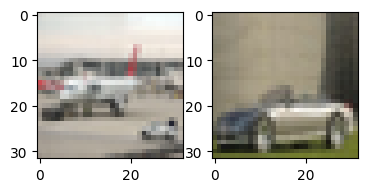

tensor([[[ 93, 123, 164,  ..., 178,  93, 127],
         [175,  92, 126,  ..., 149, 180,  99],
         [122, 154,  77,  ..., 116, 145, 181],
         ...,
         [ 45,  48, 250,  ..., 237,  12,  68],
         [ 50,  82, 140,  ..., 164, 154, 150],
         [173, 216, 210,  ..., 243, 249,  49]],

        [[ 56,  48,   1,  ..., 250,  24,  82],
         [ 72,  99, 152,  ..., 151, 164, 158],
         [189, 211, 204,  ..., 233, 229,  61],
         ...,
         [135,  71,  88,  ..., 185, 195,  13],
         [ 20,  27,  60,  ..., 227, 224, 228],
         [251,  16,  40,  ...,  75,  42,  58]],

        [[ 75,  25,  37,  ..., 204, 211,   5],
         [ 18,  27,  17,  ..., 203, 202, 202],
         [ 33,  57,  76,  ...,  31, 255,  14],
         ...,
         [190, 235, 249,  ...,  17, 217, 246],
         [  8, 219, 248,  ...,  19,  25, 223],
         [  8,  13, 213,  ..., 195, 200, 206]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


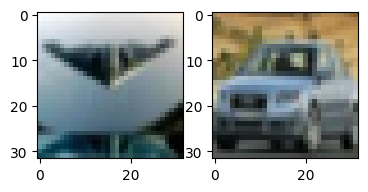

tensor([[[247,   7,  57,  ..., 174,  78, 109],
         [173,  78, 109,  ..., 108, 170,  76],
         [108, 169,  76,  ...,  72, 105, 165],
         ...,
         [193, 238, 147,  ..., 125, 158, 218],
         [246,  15,  88,  ...,  69, 165, 207],
         [  8, 154, 173,  ..., 228,   7, 172]],

        [[213, 250, 140,  ..., 166, 182, 247],
         [ 48,  78, 154,  ...,  55, 176, 186],
         [226, 199, 177,  ..., 208, 250, 215],
         ...,
         [123,  49,  64,  ...,   9,  18, 236],
         [250,  12,  32,  ...,  42,  50,  81],
         [ 93, 118, 131,  ..., 183,  74, 101]],

        [[125,  28,  46,  ...,  27,  54, 245],
         [254,  13, 228,  ...,  52,  60,  86],
         [108, 126, 135,  ..., 186,  91, 117],
         ...,
         [ 85, 100, 114,  ...,  69,  45,  43],
         [ 64,  43,  40,  ...,  33,  59,  37],
         [ 32,  58,  39,  ...,  64,  68,  94]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


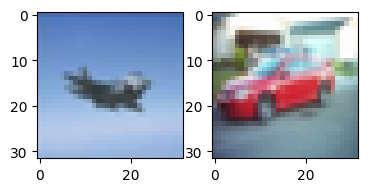

tensor([[[ 94, 123, 163,  ..., 190, 109, 142],
         [188, 110, 143,  ..., 175, 208, 121],
         [148, 183,  98,  ..., 122, 161, 207],
         ...,
         [228, 229, 199,  ...,  37,  69, 126],
         [120, 138, 187,  ..., 114,  82,  56],
         [ 68, 171, 147,  ..., 166, 183, 237]],

        [[231, 236, 194,  ...,  62,  93, 151],
         [149, 163, 207,  ..., 114,  94,  65],
         [ 86, 157, 129,  ..., 161, 177, 227],
         ...,
         [232, 199, 186,  ..., 233, 225,  86],
         [ 69,  65, 109,  ..., 189, 178, 184],
         [136, 123, 131,  ..., 167, 158, 144]],

        [[145, 111,  93,  ..., 221, 209,  48],
         [ 38,  33,  30,  ..., 196, 189, 192],
         [179, 167, 171,  ...,  87,  82,  69],
         ...,
         [167, 165, 167,  ..., 176, 180, 174],
         [177, 180, 175,  ..., 190, 193, 194],
         [192, 195, 186,  ..., 161, 158, 165]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


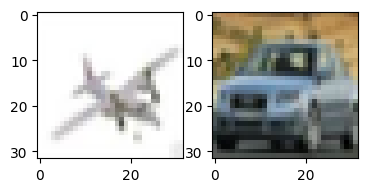

tensor([[[  3,   6,   1,  ...,   5,  11,  11],
         [  8,  36,  35,  ...,  50,  41,  10],
         [ 13,   8,   7,  ...,  38,  37,  36],
         ...,
         [154, 167, 139,  ..., 177, 182, 180],
         [222, 227, 232,  ...,  64,  64,  59],
         [ 56,  66,  59,  ..., 161, 174, 132]],

        [[153, 164, 130,  ..., 197, 203, 204],
         [224, 230, 234,  ..., 138, 138, 132],
         [126, 124, 112,  ..., 161, 170, 150],
         ...,
         [ 33,  51,  55,  ..., 118, 101, 102],
         [109, 106,  65,  ..., 230, 231, 209],
         [ 57,  53,   9,  ...,  16,  33,  40]],

        [[ 16,  74,  80,  ..., 163, 140, 101],
         [109,  99,  52,  ..., 131, 129, 108],
         [ 77,  71,  25,  ...,  42,  33,  40],
         ...,
         [ 37,  42,  53,  ...,  64, 114, 113],
         [109, 134, 132,  ..., 113, 122,  79],
         [ 84,  94,  67,  ...,  30,  40,  53]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


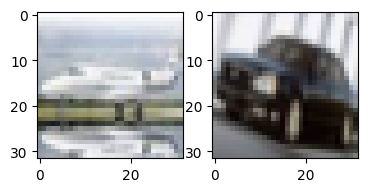

tensor([[[157, 156, 142,  ..., 116, 128,  93],
         [ 55, 135,  94,  ..., 137, 113, 152],
         [140, 118, 145,  ..., 148, 145, 125],
         ...,
         [123,  93, 128,  ..., 169, 182, 186],
         [162, 172, 166,  ..., 167,  96,  77],
         [ 96, 111,  89,  ..., 113,  83, 120]],

        [[124,  97, 126,  ..., 155, 171, 175],
         [143, 153, 146,  ..., 199, 151, 146],
         [173, 146, 141,  ...,  50,  22,  68],
         ...,
         [ 42,  76,  80,  ...,  79,  69, 113],
         [116, 107, 198,  ..., 119, 123, 117],
         [115, 119, 117,  ..., 158, 196, 196]],

        [[178, 196, 198,  ..., 195, 188, 202],
         [202, 195, 205,  ..., 120, 124, 118],
         [109, 114, 112,  ..., 115, 124, 123],
         ...,
         [142, 144, 141,  ..., 135, 136, 143],
         [135, 139, 145,  ..., 152, 151, 147],
         [153, 151, 148,  ..., 155, 157, 154]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


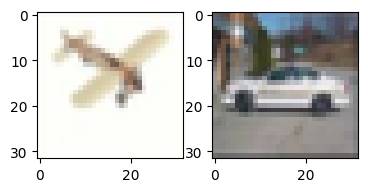

tensor([[[ 66, 113, 172,  ..., 138,  30,  82],
         [134,  35,  85,  ...,  99, 153,  43],
         [ 91, 145,  43,  ...,  38,  99, 157],
         ...,
         [121, 157, 115,  ..., 104, 150, 209],
         [ 70, 121, 186,  ..., 102, 109,  83],
         [ 91, 102,  79,  ..., 115, 157, 108]],

        [[115, 156, 114,  ..., 113, 158, 217],
         [ 44,  99, 163,  ...,  12, 117,  67],
         [ 54, 113,  81,  ..., 108, 145,  99],
         ...,
         [ 46,   5,  17,  ...,  37,  25,  84],
         [ 61,  37,  76,  ...,   1,  78, 140],
         [254,  71, 134,  ..., 102, 119, 114]],

        [[101,  45,  49,  ...,  53,  48,  81],
         [ 74,  60,  80,  ..., 255,  72, 140],
         [  1,  72, 135,  ..., 185,  71,  71],
         ...,
         [ 45,  88, 128,  ..., 114,  31,  79],
         [113,  31,  80,  ...,  81, 114,  32],
         [ 80, 116,  36,  ...,  49,  97, 134]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


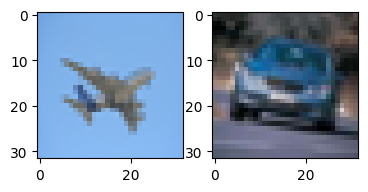

tensor([[[ 10,  10,  10,  ...,  12,  12,  12],
         [ 12,  12,  12,  ...,  13,  13,  13],
         [ 13,  13,  14,  ...,  18,  18,  18],
         ...,
         [235, 242, 218,  ...,   1,   2,   3],
         [243, 237, 239,  ..., 194, 227, 182],
         [197, 241, 194,  ..., 240, 251, 220]],

        [[190, 208, 210,  ...,   3,   3,   1],
         [  9,   9,   9,  ..., 189, 221, 173],
         [180, 211, 162,  ..., 187, 195, 219],
         ...,
         [ 21, 198,  14,  ..., 185, 187,  16],
         [181, 188,  14,  ..., 205, 211, 230],
         [  0,   0,   0,  ..., 183, 140, 146]],

        [[163, 219, 223,  ...,  29,  29,  34],
         [  3,   7,  31,  ..., 177, 183, 211],
         [  0,   0,   0,  ..., 126, 140, 132],
         ...,
         [ 93,  90,  85,  ...,  87,  95,  92],
         [ 87,  93,  90,  ...,  91,  81,  92],
         [ 89,  81,  94,  ...,  96,  93,  84]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


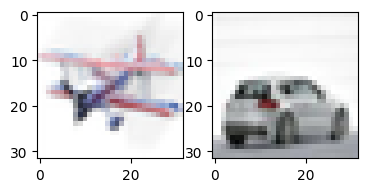

tensor([[[142, 143, 153,  ..., 131,  94, 111],
         [127,  92, 108,  ..., 103, 123,  82],
         [ 99, 118,  85,  ...,  79,  95, 108],
         ...,
         [ 46,  50,  42,  ..., 102, 114, 118],
         [ 73,  95, 109,  ..., 223, 192, 202],
         [207, 186, 195,  ..., 185, 190, 183]],

        [[185, 190, 191,  ..., 101, 117, 121],
         [ 72,  94, 108,  ..., 166, 106, 116],
         [118, 149, 159,  ..., 168, 173, 165],
         ...,
         [  7, 225, 234,  ...,  76,  79,  14],
         [ 23,  23, 189,  ..., 118, 129, 125],
         [ 96, 116, 114,  ..., 208, 234, 244]],

        [[243,   0,  11,  ...,  73,  74, 244],
         [253, 252, 214,  ..., 115, 128, 124],
         [ 99, 118, 114,  ..., 203, 226, 236],
         ...,
         [187, 205, 194,  ..., 224, 229, 241],
         [229, 231, 243,  ..., 234, 221, 219],
         [231, 217, 219,  ..., 199, 211, 197]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


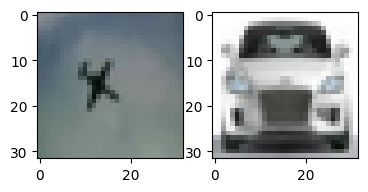

tensor([[[199, 186, 192,  ...,  33,  55,  36],
         [ 30,  53,  34,  ...,  25,  19,  42],
         [ 24,  20,  43,  ...,  51,  35,  29],
         ...,
         [ 49,  57,  17,  ...,  54,  42,  33],
         [254, 240, 219,  ..., 189,  23,   2],
         [249,  31,  33,  ..., 240, 255,  23]],

        [[  7,  20,  33,  ...,  21,  25,  11],
         [202, 185, 164,  ..., 203,  17,  26],
         [ 25, 247,  36,  ...,   3,  12, 236],
         ...,
         [ 64,  60,  77,  ..., 254,   2,  17],
         [ 12,  13,  38,  ...,  31,  42,  49],
         [  8,   2,  28,  ..., 242,  35,  38]],

        [[ 56,  77,  91,  ...,  60,  64,  60],
         [ 65,  70,  74,  ...,  28,  40,  49],
         [252, 248,  20,  ..., 219, 246, 250],
         ...,
         [255, 254,  34,  ...,  64,  11,  36],
         [ 70,  13,  39,  ...,  40,  67,   7],
         [ 42,  70,   7,  ...,  16,  39,  61]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


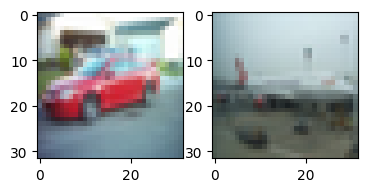

tensor([[[221, 240, 247,  ..., 249, 230, 243],
         [249, 230, 243,  ..., 242, 248, 227],
         [240, 246, 229,  ..., 215, 232, 241],
         ...,
         [159, 162, 151,  ..., 229, 243, 249],
         [229, 246, 255,  ...,  85,  63,  70],
         [ 77,  53,  60,  ...,  42,  51,  30]],

        [[ 40,  47,  38,  ..., 228, 242, 248],
         [230, 246, 253,  ...,  40,  19,  25],
         [ 35,  20,  27,  ...,  22,  32,   7],
         ...,
         [132, 169, 170,  ...,  88,  83,  42],
         [ 33,  43, 185,  ..., 230, 240, 247],
         [230, 246, 251,  ...,  78, 106, 109]],

        [[115, 159, 162,  ...,   4, 249, 243],
         [231, 228, 248,  ..., 230, 241, 247],
         [230, 246, 251,  ...,  74,  92,  95],
         ...,
         [ 24,  37,  35,  ...,  85,  83,  88],
         [ 89,  85,  89,  ...,  82,  83,  72],
         [ 75,  79,  69,  ...,  42,  55,  56]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


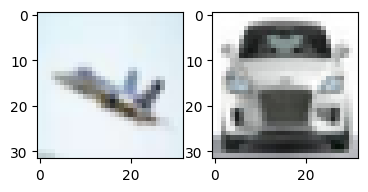

tensor([[[ 74,  30, 255,  ..., 253,  70,  25],
         [253,  70,  26,  ...,  25, 253,  63],
         [ 26, 253,  62,  ...,  61,  27,   0],
         ...,
         [106,  81, 238,  ...,  63,  29,   1],
         [ 56,  26,   0,  ..., 172,  27, 218],
         [204,  23, 151,  ...,  59,  36, 211]],

        [[ 47,  28, 211,  ...,  63,  29,   1],
         [ 56,  26,   0,  ...,  93,  14, 148],
         [138,  21, 145,  ...,  63,  42, 203],
         ...,
         [ 90, 233, 199,  ...,  97,  74,  87],
         [ 63,  37,  90,  ...,  58,  27,   1],
         [ 66,  31,   1,  ...,  13, 144, 101]],

        [[ 70, 234, 203,  ...,  68,  46,  82],
         [ 61,  36,  84,  ...,  54,  26,   3],
         [ 66,  31,   1,  ...,  56, 120,  89],
         ...,
         [ 50,  24,   0,  ...,   0,  34,  19],
         [  2,  31,  19,  ...,  18,   0,  30],
         [ 18,   0,  29,  ...,  29,  19,   5]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


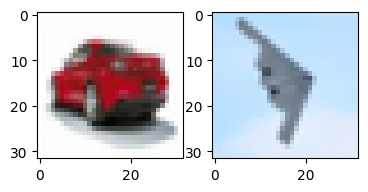

tensor([[[198, 196, 198,  ..., 106, 115, 111],
         [108, 114, 110,  ..., 106, 106, 125],
         [137, 142, 197,  ..., 147, 161, 176],
         ...,
         [ 65,  60, 182,  ..., 141, 158, 171],
         [129, 129, 126,  ...,  41,  96,   0],
         [  1, 123,   8,  ...,  21,  15, 109]],

        [[ 37,  37, 205,  ..., 142, 159, 172],
         [108, 108, 111,  ...,  33,  65,  15],
         [ 18,  57, 209,  ...,  10,   2, 139],
         ...,
         [ 67,  71,  35,  ..., 175, 166, 255],
         [197, 186,  46,  ...,  73,  77,  87],
         [121, 121, 130,  ...,  75, 120,  75]],

        [[ 62,  39, 245,  ..., 172, 170, 249],
         [202, 196,  32,  ...,  70,  74,  84],
         [118, 118, 128,  ...,  94, 130,  89],
         ...,
         [117, 117, 124,  ..., 106,  95,  97],
         [105,  97,  99,  ..., 137, 138, 126],
         [124, 128, 118,  ..., 153, 161, 133]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


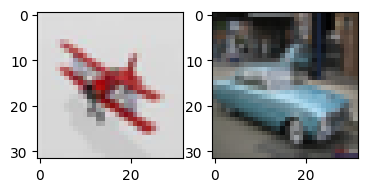

tensor([[[198,   3,   5,  ...,  32, 224,  65],
         [ 92, 210,  64,  ...,  21,  35, 200],
         [ 17,  31, 203,  ..., 218,  13,  23],
         ...,
         [246, 228, 250,  ..., 236, 238, 219],
         [247, 249, 241,  ..., 203, 209, 226],
         [183, 207, 226,  ...,   3, 241,   5]],

        [[254, 234,   1,  ..., 253, 250, 230],
         [ 10,  13,   4,  ..., 203, 212, 227],
         [188, 212, 226,  ...,  55,  41,  41],
         ...,
         [ 94, 105, 108,  ...,  93, 102,  39],
         [ 44,  40, 216,  ...,  29,  42,  47],
         [ 38,  47,  34,  ..., 248, 233, 246]],

        [[249,   9,  20,  ..., 247,   0, 233],
         [244, 249, 227,  ...,  25,  40,  49],
         [ 43,  51,  40,  ...,  56,  63,  84],
         ...,
         [  5,  22,  10,  ...,  14,  11,  20],
         [ 15,  12,  20,  ...,   3, 246, 249],
         [  1, 246, 249,  ..., 248,   2, 248]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


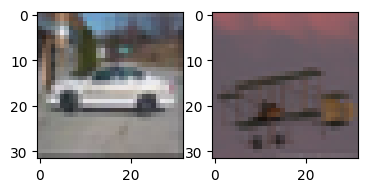

tensor([[[132, 131, 139,  ..., 138, 126, 124],
         [137, 125, 124,  ..., 116, 131, 124],
         [123, 130, 124,  ..., 128, 127, 135],
         ...,
         [194, 226, 159,  ..., 167, 161, 176],
         [200, 184, 192,  ..., 196, 182, 178],
         [190, 181, 179,  ..., 182, 218, 174]],

        [[188, 226, 159,  ..., 188, 181, 194],
         [182, 171, 172,  ..., 190, 169, 165],
         [173, 166, 163,  ..., 169, 204, 166],
         ...,
         [196,   9,   6,  ..., 137, 177, 113],
         [146, 190, 116,  ...,  87,  79, 127],
         [ 96,  90, 112,  ..., 224,  16,  20]],

        [[ 56,  91,  85,  ..., 149, 209, 150],
         [152, 218, 154,  ..., 116, 107, 156],
         [119, 110, 115,  ..., 222,  10,   2],
         ...,
         [127, 127, 155,  ..., 201, 182, 176],
         [206, 190, 185,  ..., 181, 211, 188],
         [182, 215, 188,  ..., 178, 172, 212]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


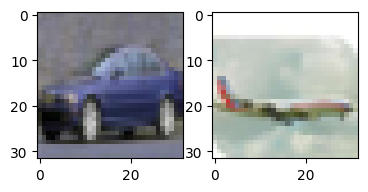

tensor([[[ 82,  99, 120,  ...,  99,  43,  64],
         [ 96,  42,  65,  ...,  72,  99,  52],
         [ 73, 106,  54,  ..., 144, 152, 170],
         ...,
         [254,  56, 225,  ..., 104, 120, 148],
         [ 32,  52,  88,  ...,  46, 209, 242],
         [ 47, 205, 237,  ..., 248,  52, 223]],

        [[250,  57, 227,  ..., 107, 121, 151],
         [ 41,  61,  96,  ...,  44, 209, 242],
         [ 46, 206, 238,  ..., 240,  44, 212],
         ...,
         [187, 165, 170,  ..., 154, 169, 145],
         [155, 175, 113,  ..., 117, 144, 173],
         [ 27,  52,  90,  ..., 208, 155, 156]],

        [[165, 139, 139,  ...,  35,  53,  41],
         [ 45,  62,  49,  ..., 115, 131, 161],
         [ 24,  51,  90,  ...,  38, 237, 252],
         ...,
         [134, 137, 202,  ..., 184, 108, 111],
         [181, 106, 106,  ..., 102, 189, 101],
         [101, 186,  97,  ..., 127, 124, 199]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


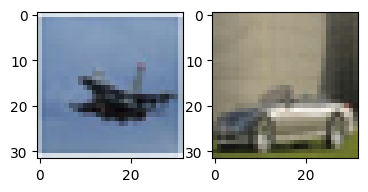

tensor([[[157, 152, 159,  ..., 124, 118, 106],
         [100, 133, 118,  ..., 127, 111, 186],
         [172, 155, 190,  ..., 174, 156, 163],
         ...,
         [ 92,  93, 112,  ..., 195, 197, 192],
         [ 61,  60,  70,  ...,  56,  71,  57],
         [ 35,  61,  47,  ...,  84,  85,  80]],

        [[ 72,  71,  84,  ..., 186, 189, 189],
         [ 92, 101, 110,  ...,  51,  76,  67],
         [ 50,  71,  62,  ...,  67,  64,  70],
         ...,
         [195, 107, 125,  ..., 229, 239,   3],
         [ 11,  28,  75,  ...,  86,  96, 116],
         [253,  21,  49,  ..., 207, 142, 162]],

        [[185, 105, 125,  ...,  46,  59,  73],
         [ 82,  99, 110,  ...,  66,  83,  96],
         [249,  18,  51,  ..., 214, 141, 160],
         ...,
         [190, 201, 231,  ..., 217, 179, 195],
         [218, 221, 231,  ...,  19,  34, 225],
         [236, 251, 195,  ..., 179, 193, 205]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


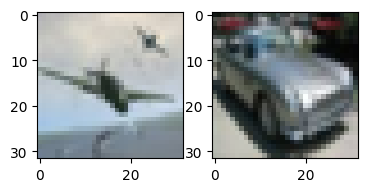

tensor([[[186, 216, 221,  ..., 237, 202, 234],
         [242, 206, 233,  ..., 234, 209, 217],
         [224, 190, 188,  ..., 163, 192, 198],
         ...,
         [224, 223, 150,  ...,  78,  88,  85],
         [141, 166, 179,  ..., 164, 154, 175],
         [181, 153, 179,  ..., 159, 154, 102]],

        [[118, 107,  65,  ...,  73,  81,  73],
         [ 79, 105, 122,  ..., 149, 146, 169],
         [174, 153, 177,  ...,  90,  78,  78],
         ...,
         [199, 226, 235,  ..., 246, 245, 203],
         [210, 211, 241,  ..., 124, 137, 133],
         [ 91, 105, 105,  ..., 249, 204, 209]],

        [[207, 185, 190,  ..., 215, 214, 140],
         [142, 143, 238,  ..., 118, 130, 123],
         [ 91, 105, 105,  ..., 223, 241, 249],
         ...,
         [ 80,  95,  95,  ..., 107,  91, 105],
         [107,  92, 106,  ..., 116, 118, 105],
         [115, 115, 100,  ...,  98, 105,  89]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


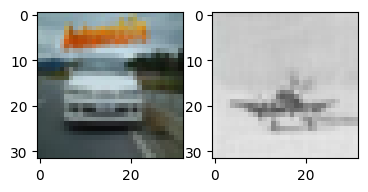

tensor([[[ 68,  82, 100,  ..., 152,  85, 115],
         [153, 104, 134,  ...,  68, 117,  67],
         [ 76, 134,  65,  ...,  33,  53, 107],
         ...,
         [ 45,  33, 194,  ...,  83, 130, 156],
         [ 54,  87, 118,  ..., 250,  80,  86],
         [ 32, 141, 146,  ..., 212, 181, 182]],

        [[192, 169, 169,  ...,  58, 105, 131],
         [ 60, 105, 139,  ...,  41,  19,  36],
         [ 34,  17,  32,  ..., 205, 208, 189],
         ...,
         [234, 243,   1,  ..., 235, 244, 215],
         [229, 241, 209,  ...,  37,  58, 109],
         [180, 205, 219,  ..., 194, 187, 203]],

        [[204, 205, 217,  ..., 244, 250, 241],
         [255,  15, 234,  ...,  39,  54, 108],
         [176, 204, 220,  ..., 184, 204, 217],
         ...,
         [224, 247,  15,  ...,  13,   7,   0],
         [  9,   2, 253,  ..., 239,   5, 229],
         [234,   7, 223,  ..., 191, 203, 224]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


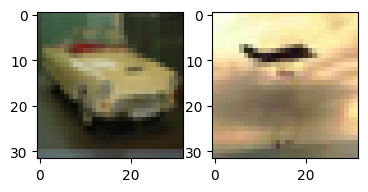

tensor([[[246, 246, 247,  ..., 248, 244, 244],
         [248, 244, 244,  ..., 243, 246, 246],
         [243, 245, 244,  ..., 238, 238, 238],
         ...,
         [  7,  12, 251,  ..., 245, 245, 245],
         [253, 253,   1,  ...,  91,  32,  29],
         [ 14, 251, 253,  ...,   6,  16, 252]],

        [[251,   1, 251,  ..., 244, 244, 244],
         [247, 247, 251,  ..., 139, 164, 152],
         [110,  50,  42,  ...,   0,  20,   3],
         ...,
         [138, 186, 111,  ..., 251, 229, 216],
         [208, 218, 241,  ..., 252, 252, 255],
         [  0,   0,   1,  ...,  28, 201, 184]],

        [[186, 160, 152,  ..., 248, 237, 236],
         [226, 238, 186,  ..., 255, 255,   2],
         [  2,   2,   3,  ...,  44, 197, 191],
         ...,
         [163, 166, 171,  ..., 171, 161, 164],
         [171, 163, 166,  ..., 166, 180, 164],
         [167, 179, 162,  ..., 161, 163, 172]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


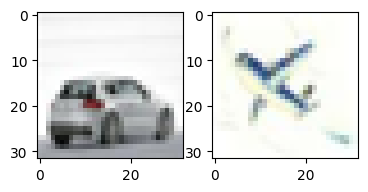

tensor([[[ 77,  55,  42,  ...,  59,  90,  70],
         [ 58,  93,  72,  ..., 232, 228, 229],
         [218, 212, 230,  ..., 230, 227, 226],
         ...,
         [136, 132, 151,  ..., 236, 238, 233],
         [237, 255,  22,  ..., 240, 250, 224],
         [235, 244, 214,  ..., 164, 156, 151]],

        [[126, 114,  96,  ..., 144, 151, 155],
         [213, 220, 242,  ..., 243,  30, 217],
         [220,  67, 241,  ...,  50,  34,  72],
         ...,
         [237, 149,   2,  ..., 172, 194,  32],
         [166, 189,  28,  ..., 219, 115, 130],
         [227, 226, 223,  ..., 188, 120, 228]],

        [[237, 130, 237,  ..., 169, 189,  44],
         [174, 195,  38,  ..., 226, 109, 125],
         [228, 228, 225,  ..., 170, 225, 142],
         ...,
         [ 20,   5,   7,  ..., 166, 125, 122],
         [140, 130, 127,  ..., 108, 132,  89],
         [ 91, 119,  98,  ..., 202, 184, 202]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


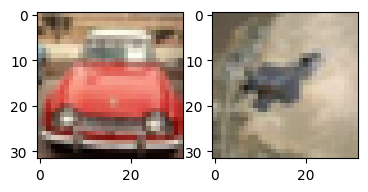

tensor([[[145, 160, 144,  ..., 140, 141, 166],
         [141, 159, 182,  ..., 113,  96, 117],
         [122, 105, 118,  ...,  92,  95,  86],
         ...,
         [243, 192, 223,  ..., 101, 103,  85],
         [178, 173, 147,  ..., 220,  53,  30],
         [227,  58,  35,  ...,  22, 204,  51]],

        [[ 17, 204,  32,  ..., 118, 120,  96],
         [188, 183, 158,  ...,  20,  63,  40],
         [251,  62,  38,  ...,  31, 221,  50],
         ...,
         [164, 200, 201,  ..., 224, 192, 211],
         [203, 175, 198,  ..., 205, 170, 166],
         [241, 226, 216,  ..., 154, 201, 189]],

        [[161, 200, 184,  ..., 221, 185,   3],
         [238, 210, 245,  ..., 194, 164, 157],
         [224, 218, 213,  ..., 170, 242, 221],
         ...,
         [ 10,  10,  58,  ...,  25, 254, 240],
         [ 20, 252, 236,  ..., 225,   3, 242],
         [224,   2, 240,  ..., 238, 225,   4]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


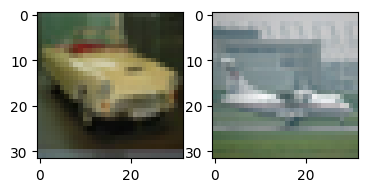

tensor([[[253, 220, 200,  ..., 231,  45,  13],
         [235,  48,  15,  ...,  21, 241,  24],
         [ 11, 230,  22,  ..., 188, 185, 170],
         ...,
         [242, 221, 242,  ..., 154, 161, 153],
         [ 21,   0, 220,  ..., 243,  35,  19],
         [241,  27,  13,  ..., 248, 223, 239]],

        [[240, 219, 242,  ..., 150, 158, 153],
         [ 16, 253, 219,  ..., 242,  33,  18],
         [241,  24,  11,  ..., 253, 229, 241],
         ...,
         [248, 202, 212,  ..., 246, 236,   8],
         [ 57,  43, 246,  ..., 145, 148, 153],
         [255, 248, 217,  ..., 204, 203, 216]],

        [[215, 219, 231,  ...,  35,  26,  63],
         [107,  95,  15,  ..., 194, 200, 203],
         [248, 243, 212,  ..., 194, 177, 191],
         ...,
         [190, 205, 151,  ..., 150, 187, 202],
         [154, 185, 204,  ..., 164,  97, 126],
         [161,  92, 129,  ..., 152, 177, 128]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


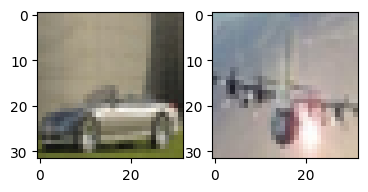

tensor([[[101,  60, 153,  ..., 144,  91,  90],
         [150,  99, 104,  ..., 111, 158,  44],
         [ 44, 106,  52,  ..., 100,  59, 148],
         ...,
         [ 57,  77, 228,  ...,  74,  90, 138],
         [ 48,  57, 106,  ..., 203,  67, 200],
         [205,  85, 201,  ..., 222, 245, 224]],

        [[162, 185, 210,  ...,  92, 129, 160],
         [ 38,  62,  99,  ..., 205,  70, 204],
         [209,  93, 207,  ...,  93,  97, 133],
         ...,
         [ 55, 246,  38,  ...,  28,  39, 208],
         [253,  10, 221,  ...,  41,  70,  95],
         [ 50,  72, 107,  ...,  73,  27,  48]],

        [[ 57,  29,  25,  ...,  80,  90, 219],
         [ 11,  23, 219,  ...,  42,  63,  93],
         [ 67,  71, 121,  ...,  81,   0, 225],
         ...,
         [106,  64, 155,  ..., 114,  62,  88],
         [123,  66, 101,  ..., 146, 171, 102],
         [130, 163,  85,  ..., 100,  57, 147]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


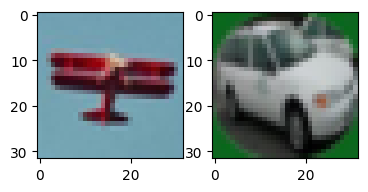

tensor([[[ 33,  30,  74,  ..., 114,  99,  99],
         [129, 105, 104,  ..., 117, 177,  70],
         [ 64, 131,  77,  ...,  95,  93, 136],
         ...,
         [142, 142, 142,  ...,  83,  82, 117],
         [ 33,  43,  69,  ..., 130, 102, 101],
         [119,  96,  94,  ..., 187, 191, 182]],

        [[183, 188, 181,  ...,  84,  83, 119],
         [ 43,  51,  74,  ..., 102,  85,  85],
         [ 99,  82,  80,  ..., 184, 195, 181],
         ...,
         [ 27,   6,  25,  ...,  94,  98, 112],
         [122, 123,  69,  ..., 247, 242,  36],
         [232, 242,  20,  ..., 154,  51,  59]],

        [[ 73,  21,  45,  ...,  77,  83,  35],
         [ 68,  76,  25,  ..., 236, 238,  42],
         [182, 196, 242,  ..., 135, 134, 130],
         ...,
         [ 87,  98, 145,  ..., 169, 112, 125],
         [166, 107, 122,  ..., 134, 178, 117],
         [135, 182, 116,  ..., 118, 135, 182]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


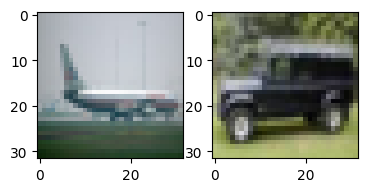

tensor([[[209, 207, 186,  ..., 206, 231, 222],
         [204, 230, 222,  ..., 210, 192, 213],
         [206, 188, 211,  ..., 178, 178, 158],
         ...,
         [202, 185, 207,  ..., 222, 224, 231],
         [216, 208, 186,  ..., 225, 243, 241],
         [221, 242, 240,  ..., 184, 168, 184]],

        [[182, 167, 182,  ..., 190, 203, 203],
         [236, 229, 205,  ..., 232, 252, 241],
         [231, 249, 240,  ..., 245, 228, 248],
         ...,
         [ 28,  81,  87,  ..., 121, 124, 106],
         [112, 117,  76,  ..., 239, 241, 233],
         [ 94,  90,  65,  ...,  60,  29,  31]],

        [[ 31, 101, 103,  ..., 138, 138, 101],
         [108, 109,  60,  ..., 230, 231, 226],
         [ 81,  78,  55,  ...,  26,  44,  45],
         ...,
         [ 45,  42,  33,  ..., 228,   4, 253],
         [244,  19,  12,  ...,   8, 254,  16],
         [  9, 255,  19,  ...,  29,  23,  12]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


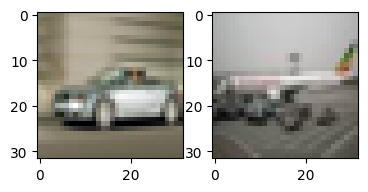

tensor([[[ 15, 254, 206,  ..., 208,  53,  31],
         [209,  54,  31,  ...,  24, 207,  44],
         [ 22, 204,  41,  ..., 208, 200, 155],
         ...,
         [ 46, 238,  69,  ..., 239, 229, 171],
         [ 24,  10, 196,  ..., 236,  64,  39],
         [227,  63,  39,  ...,  55, 249,  67]],

        [[ 52, 249,  72,  ..., 245, 237, 179],
         [ 30,  19, 211,  ...,   1,  84,  61],
         [  0,  81,  59,  ...,  64,   9,  72],
         ...,
         [ 25,  52,  48,  ...,  76,  57,  63],
         [ 73,  54,  60,  ..., 205, 196, 152],
         [ 58,  38, 233,  ..., 245,  50,  44]],

        [[ 20,  73,  66,  ..., 133, 107, 134],
         [135, 108, 125,  ..., 219, 213, 165],
         [ 59,  39, 235,  ..., 247,  20,  11],
         ...,
         [241, 241, 145,  ..., 129, 252, 245],
         [131, 252, 249,  ..., 247, 120, 248],
         [249, 126, 250,  ..., 247, 249, 150]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


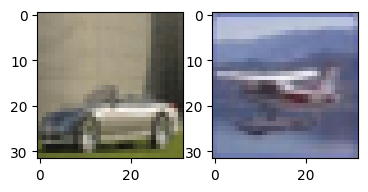

tensor([[[209, 164, 146,  ..., 167,  55,  20],
         [ 23, 249, 220,  ..., 119, 133, 126],
         [126, 132, 126,  ..., 130, 129, 137],
         ...,
         [164, 190, 114,  ..., 126, 124, 131],
         [195, 154, 151,  ...,  60,  90,  74],
         [ 59,  91,  78,  ..., 163, 195, 141]],

        [[158, 188, 115,  ..., 134, 133, 138],
         [192, 153, 137,  ...,  46,  68,  54],
         [ 40,  65,  52,  ..., 173, 198, 146],
         ...,
         [235,  72,  40,  ..., 188, 230, 229],
         [203, 246, 236,  ..., 235, 209, 223],
         [203, 134,  86,  ..., 171,  33,   2]],

        [[ 11,  87,  54,  ..., 195, 229, 227],
         [204, 241, 229,  ..., 245, 222, 237],
         [236, 186, 130,  ..., 170,   9, 235],
         ...,
         [ 30,   7,  72,  ...,  63,  79,  61],
         [ 73,  90,  74,  ...,  67,  83,  84],
         [ 66,  88,  85,  ...,  77,  61, 107]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


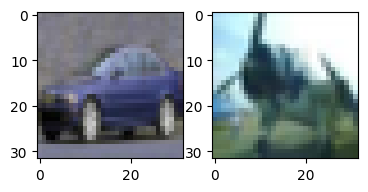

tensor([[[135,  29, 167,  ..., 142, 123,  13],
         [144, 123,  13,  ..., 241, 126, 117],
         [ 13, 151, 141,  ..., 123,   6, 129],
         ...,
         [105, 103, 176,  ..., 155,  59, 203],
         [ 54, 232, 134,  ..., 200,  40,   5],
         [198, 238, 202,  ..., 142, 125, 128]],

        [[123, 115, 162,  ..., 134,  38, 182],
         [ 20, 203, 113,  ..., 204,  12, 238],
         [169, 223, 189,  ..., 145, 131,  98],
         ...,
         [ 68, 104, 115,  ...,  58,  58, 233],
         [241, 244, 189,  ..., 189, 196, 189],
         [225, 207, 182,  ..., 157, 162, 169]],

        [[171, 186, 198,  ...,  53,  55, 231],
         [232, 232, 209,  ..., 181, 169, 158],
         [171, 161, 145,  ..., 237, 239, 248],
         ...,
         [159, 159, 164,  ..., 148, 148, 149],
         [148, 153, 155,  ..., 144, 138, 159],
         [151, 146, 192,  ..., 250, 217, 172]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


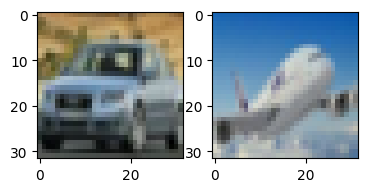

tensor([[[234, 193, 135,  ..., 122, 218, 181],
         [121, 232, 192,  ..., 128,  96, 167],
         [148, 108, 163,  ..., 183, 158, 116],
         ...,
         [192, 170, 194,  ..., 171, 145,  96],
         [ 22, 235, 163,  ..., 128,  33, 233],
         [126,  45, 242,  ..., 135, 130, 217]],

        [[200, 179, 168,  ..., 173, 148,  96],
         [ 12, 225, 153,  ..., 159, 240, 186],
         [ 99,  21, 219,  ..., 141, 131, 178],
         ...,
         [144, 150, 169,  ..., 232, 134,  44],
         [ 25, 177,  75,  ..., 193, 166, 130],
         [123, 108,  68,  ..., 127, 120, 137]],

        [[119, 150, 178,  ...,   3, 132,  60],
         [ 32, 154,  82,  ..., 191, 163, 129],
         [116, 101,  61,  ..., 111, 108, 118],
         ...,
         [163, 136, 102,  ...,  83, 113, 102],
         [ 84, 112, 100,  ..., 107,  59,  99],
         [ 74,  35, 141,  ..., 178, 145, 122]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


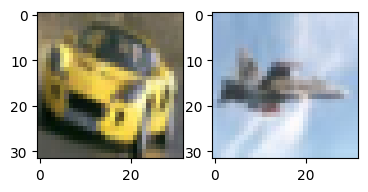

tensor([[[225,   9,  24,  ...,  23, 225,  14],
         [ 23, 225,  13,  ...,  30,  36,   1],
         [ 27,  38, 240,  ..., 226,  11,  26],
         ...,
         [157, 128, 173,  ..., 186, 218, 216],
         [194, 240, 251,  ..., 169, 167, 176],
         [173, 162, 165,  ..., 170, 136, 177]],

        [[165, 130, 177,  ..., 209, 224, 209],
         [199,   0,  29,  ..., 143, 172, 166],
         [167, 177, 174,  ..., 190, 160, 187],
         ...,
         [ 43, 173, 222,  ...,  50,  14,  21],
         [ 59,  31,  19,  ...,  24,  73,  62],
         [ 23,  77,  87,  ...,  49, 186, 233]],

        [[249, 160, 208,  ...,  63,  49,  25],
         [ 66,  50,  26,  ...,  15,  63,  59],
         [ 11,  60,  88,  ...,  60, 192, 240],
         ...,
         [ 57,  56,  21,  ..., 212, 166, 210],
         [208, 166, 210,  ..., 214, 210, 168],
         [211, 207, 167,  ..., 170, 210, 201]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


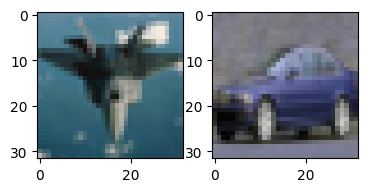

tensor([[[120, 111,  98,  ...,  88, 116, 111],
         [ 84, 110, 112,  ..., 169, 134, 174],
         [157, 115, 182,  ..., 168, 143,  91],
         ...,
         [122,  96, 182,  ..., 232, 214, 163],
         [196, 199, 186,  ..., 144, 173, 153],
         [128, 157, 136,  ..., 174, 145, 126]],

        [[125,  98, 164,  ...,  13, 246, 185],
         [193, 193, 178,  ..., 157, 178, 161],
         [135, 169, 148,  ..., 151, 133, 103],
         ...,
         [112,  91,  87,  ..., 217, 191, 173],
         [170, 157, 113,  ...,  30,  23, 246],
         [ 91,  74,  24,  ...,  55,  81,  78]],

        [[ 67,  81,  71,  ...,  58,  31,  14],
         [  7,   0, 232,  ...,   6, 254, 220],
         [ 95,  79,  29,  ...,   5,  11, 254],
         ...,
         [ 91,  66,  17,  ...,  29, 114,  86],
         [ 30, 118,  89,  ...,  98,  35, 120],
         [ 87,  21, 108,  ...,  85,  85,  17]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


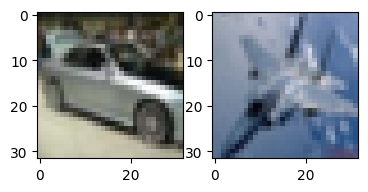

tensor([[[ 92,  87,  55,  ...,  99, 123, 121],
         [ 70, 133, 136,  ...,  99,  65, 109],
         [ 96,  60, 123,  ..., 126, 123,  81],
         ...,
         [184, 186, 173,  ...,  42,  33,   7],
         [187, 182, 150,  ..., 124, 149, 163],
         [157, 174, 200,  ..., 234, 230, 202]],

        [[231, 224, 143,  ...,  43,  37,  17],
         [188, 184, 151,  ..., 189, 175, 186],
         [167, 148, 165,  ..., 253, 234, 250],
         ...,
         [ 30,  43,  47,  ..., 247, 202,   0],
         [  2, 219, 234,  ...,  36,  36,  21],
         [222, 223, 191,  ...,  38,  30,  36]],

        [[ 31,  31,  36,  ..., 240, 216, 216],
         [216, 191, 182,  ...,  18,  24,  12],
         [222, 227, 200,  ...,  47,  56,  66],
         ...,
         [ 23,  48,  97,  ...,  84,  15,  38],
         [ 92,  12,  34,  ...,  77, 127,  36],
         [ 73, 121,  37,  ...,  74,  99, 135]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


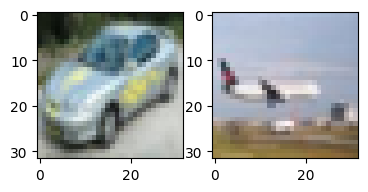

tensor([[[207, 249,  52,  ...,  69, 230,  11],
         [ 74, 217,   0,  ...,  17,  73, 221],
         [  2,  63, 227,  ..., 202, 242,  46],
         ...,
         [244,  27, 222,  ...,   8,  47,  98],
         [190, 238,  47,  ..., 143, 192, 248],
         [ 90, 167, 229,  ...,  16,  18, 186]],

        [[214, 234, 241,  ...,  16,  52, 105],
         [203, 249,  59,  ..., 127,   9,  50],
         [131, 200,   1,  ...,  11, 252, 255],
         ...,
         [182, 160, 161,  ..., 238,  76, 183],
         [211,  45, 180,  ...,  83,  94, 105],
         [145, 148, 165,  ..., 175, 173, 175]],

        [[186, 174, 177,  ..., 219,  85, 189],
         [219,  82, 189,  ...,  87,  96, 104],
         [157, 156, 175,  ..., 126, 129, 133],
         ...,
         [ 90,  96, 116,  ..., 119,  89,  99],
         [120,  88, 100,  ..., 115, 152, 149],
         [150, 177, 112,  ...,  64,  72,  84]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


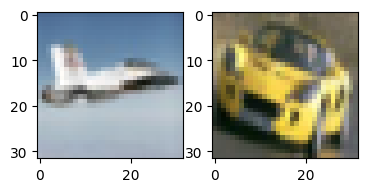

tensor([[[  3, 211, 135,  ..., 149,  31, 237],
         [151,  32, 237,  ..., 234, 149,  26],
         [232, 145,  23,  ..., 211, 162,  93],
         ...,
         [228, 142,  19,  ..., 193, 146,  75],
         [254, 207, 127,  ..., 254,  24, 227],
         [142,  31, 236,  ..., 232, 143,  19]],

        [[226, 140,  21,  ..., 189, 144,  73],
         [244, 199, 119,  ...,  18,  26, 231],
         [147,  29, 235,  ..., 234, 146,  24],
         ...,
         [ 42, 234, 202,  ..., 238, 170,  27],
         [240, 169,  23,  ..., 156, 109,  44],
         [242, 196, 114,  ..., 187, 244, 251]],

        [[ 38,   3, 229,  ...,  55, 242, 101],
         [ 58, 242,  98,  ..., 167, 122,  53],
         [243, 198, 116,  ..., 188,  17,  30],
         ...,
         [208, 174,  54,  ...,  60, 220, 185],
         [ 62, 221, 190,  ..., 197,  56, 232],
         [200,  61, 235,  ..., 230, 192,  59]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


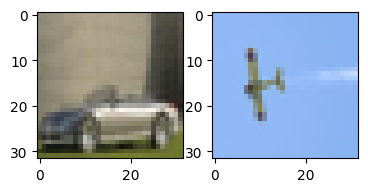

tensor([[[ 48,  29,  10,  ...,  25,  69,  51],
         [ 27,  70,  52,  ...,  52,  26,  61],
         [ 42,  28,  59,  ...,  30,  11, 252],
         ...,
         [251, 218,  28,  ..., 202, 195, 180],
         [ 67,  51,  33,  ...,  25,  56,  38],
         [ 26,  51,  30,  ..., 190, 152, 197]],

        [[177, 140, 207,  ..., 178, 174, 163],
         [ 13,   5, 251,  ..., 204, 233, 218],
         [211, 233, 216,  ..., 194, 159, 200],
         ...,
         [203, 150, 140,  ...,  69,  28,  57],
         [ 52,  10,  47,  ...,  40,  40,   7],
         [ 38,  42,  13,  ..., 220, 159, 154]],

        [[152, 136, 130,  ...,   0, 224,  11],
         [255, 223,  11,  ..., 255,   0, 231],
         [ 55,  58,  35,  ..., 226, 170, 168],
         ...,
         [205, 215, 159,  ..., 182, 224, 240],
         [186, 218, 234,  ..., 238, 180, 224],
         [237, 183, 224,  ..., 188, 197, 153]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


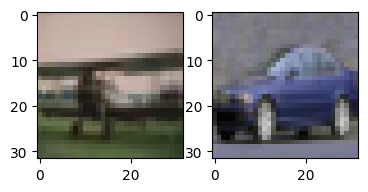

tensor([[[147, 139, 125,  ..., 145, 180, 170],
         [147, 181, 170,  ..., 164, 143, 171],
         [162, 139, 168,  ...,  96,  92,  85],
         ...,
         [157, 133, 162,  ...,  89,  86,  77],
         [142, 137, 117,  ..., 139, 173, 163],
         [138, 176, 167,  ..., 162, 135, 167]],

        [[159, 135, 170,  ...,  77,  76,  67],
         [133, 128, 109,  ..., 141, 174, 164],
         [140, 176, 167,  ..., 167, 141, 186],
         ...,
         [154, 175, 174,  ..., 139, 129, 141],
         [141, 128,  71,  ...,  67,  63,  59],
         [131, 125, 104,  ..., 103, 129, 129]],

        [[123, 149, 147,  ..., 214, 206, 222],
         [221, 212, 123,  ...,  71,  69,  61],
         [132, 127, 106,  ..., 115, 104, 103],
         ...,
         [ 97, 103,  44,  ...,  55, 114, 119],
         [ 57, 115, 124,  ..., 130,  51, 123],
         [132,  55, 126,  ..., 116, 123,  50]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


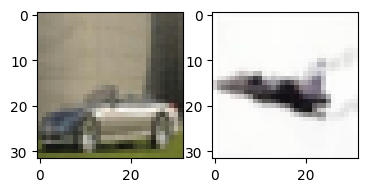

tensor([[[ 52,  57,  47,  ...,  53,  58,  62],
         [ 57, 242, 252,  ..., 211, 241, 168],
         [183, 209, 148,  ..., 163, 172, 196],
         ...,
         [231, 244, 203,  ...,  75,  84,  72],
         [ 49,  72,  68,  ..., 151,  95,  99],
         [101,  20,  23,  ..., 229, 250, 200]],

        [[207, 228, 147,  ...,  96, 103,  90],
         [ 95, 105,  96,  ...,  96,  79,  81],
         [ 83, 209, 208,  ..., 183, 206, 147],
         ...,
         [ 72,  94,  79,  ..., 215, 209, 228],
         [210, 206, 233,  ...,  22,  14,   5],
         [109, 110, 106,  ...,  18,  66,  63]],

        [[ 44,  95,  85,  ..., 225, 220, 249],
         [233, 225,   1,  ...,  45,  39,  29],
         [105, 106, 103,  ..., 245,  50,  42],
         ...,
         [ 77,  86,  79,  ...,  79,  70,  75],
         [ 68,  59,  63,  ...,  99,  89,  94],
         [ 96,  90,  91,  ...,  80,  83,  79]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


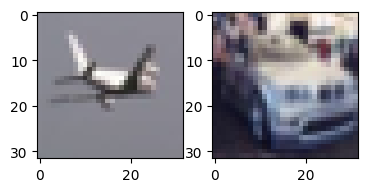

tensor([[[ 27,  11, 243,  ..., 247,  44,  27],
         [248,  45,  27,  ...,  31, 248,  43],
         [ 24, 246,  40,  ...,  22,   3, 226],
         ...,
         [240, 200,  29,  ...,  50,  36,   3],
         [ 27,  15, 250,  ...,  40,  71,  62],
         [ 43,  70,  57,  ..., 254, 205,  16]],

        [[237, 190,  45,  ...,  39,  27, 253],
         [ 31,  20,   9,  ...,  66,  93,  90],
         [ 80,  96,  91,  ...,   5, 220,  49],
         ...,
         [ 58,  25,  13,  ...,  74,  28, 111],
         [ 93,  39, 126,  ..., 157, 145, 105],
         [158, 148, 133,  ...,  39,  30,  18]],

        [[  4,  14,   4,  ..., 127,  88, 157],
         [137,  90, 160,  ..., 147, 131,  94],
         [147, 134, 133,  ...,  40,  31,  18],
         ...,
         [ 20,  13, 233,  ..., 191, 228, 216],
         [188, 215, 202,  ...,  20, 249,  27],
         [ 20, 248,  26,  ...,  18,   5, 222]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


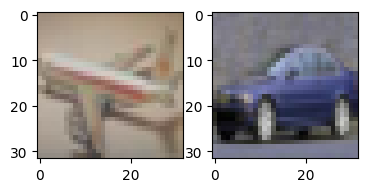

tensor([[[  4, 249, 217,  ..., 229,  34,  19],
         [231,  35,  19,  ...,  14, 228,  26],
         [ 12, 224,  23,  ..., 206, 198, 170],
         ...,
         [  8, 223,  18,  ..., 190, 182, 153],
         [255, 247, 210,  ..., 227,  31,  16],
         [226,  35,  21,  ...,  12, 221,  18]],

        [[  5, 217,  11,  ..., 184, 179, 150],
         [248, 237, 202,  ..., 222,  21,   7],
         [219,  23,  10,  ...,  16, 230,  27],
         ...,
         [ 94,  78,  70,  ...,  21, 253,  29],
         [ 22, 250,  24,  ..., 155, 146, 123],
         [243, 234, 196,  ..., 230,  83,  77]],

        [[ 79, 106,  96,  ...,  92,  68, 102],
         [ 95,  66,  99,  ..., 166, 159, 132],
         [244, 236, 198,  ...,  25,  68,  60],
         ...,
         [207, 210, 134,  ..., 140, 220, 222],
         [143, 221, 227,  ..., 231, 136, 229],
         [233, 140, 232,  ..., 222, 226, 135]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


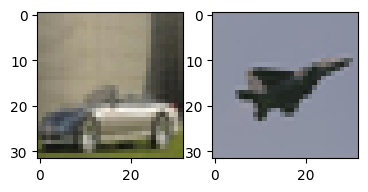

tensor([[[174,  27,  82,  ..., 117, 190,  52],
         [115, 190,  50,  ...,  78, 124, 204],
         [ 51,  99, 183,  ..., 208,  56, 117],
         ...,
         [108, 119,  22,  ..., 184,   3,  66],
         [250,  61, 113,  ...,  59,  48,  57],
         [ 71,  98, 104,  ...,  56,  80,  75]],

        [[ 94, 105,  18,  ..., 228,  32,  98],
         [ 35,  93, 140,  ...,  38,  57,  55],
         [ 75,  87,  84,  ...,  53,  73,  84],
         ...,
         [116,  92, 111,  ..., 231, 227,  25],
         [ 67,  61,  96,  ...,  56, 100, 113],
         [ 29,  46,  59,  ...,  72,  54,  84]],

        [[ 71,  47,  75,  ...,   7, 253,  34],
         [ 74,  69,  70,  ...,  65, 113, 117],
         [ 57,  79,  90,  ...,  32,   7,  48],
         ...,
         [224,  37,  45,  ...,  72,   4,  71],
         [ 79,   5,  77,  ..., 110, 112,  52],
         [108, 110,  44,  ...,  74, 113, 112]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


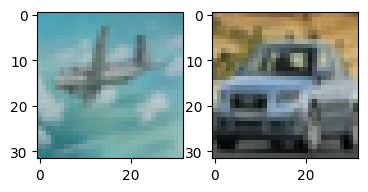

tensor([[[ 62,  41, 244,  ..., 254,  71,  51],
         [  2,  78,  53,  ...,  56, 230,  91],
         [ 47, 212,  64,  ...,  47,  25, 230],
         ...,
         [ 51, 249,  30,  ..., 214, 169, 109],
         [ 18, 251, 205,  ..., 185,  30, 254],
         [203,  28,   1,  ..., 237, 174, 235]],

        [[197, 129, 202,  ..., 207, 160,  95],
         [214, 191, 149,  ..., 171,  23, 249],
         [197,  28, 255,  ..., 163, 100, 208],
         ...,
         [159,   8, 222,  ..., 190, 157, 209],
         [175, 137, 236,  ...,  14, 231, 169],
         [245, 207, 150,  ..., 165, 219, 172]],

        [[112, 211, 165,  ..., 159, 125, 160],
         [123,  86, 192,  ...,   9, 225, 160],
         [246, 207, 150,  ..., 213,  21, 233],
         ...,
         [232, 194, 139,  ..., 152, 243, 206],
         [151, 245, 207,  ..., 216, 163,   5],
         [218, 161, 230,  ..., 254, 208, 135]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


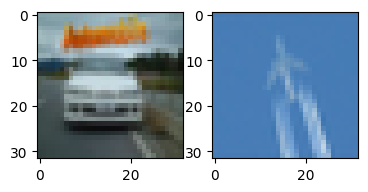

tensor([[[ 97,  92,  97,  ..., 255, 219, 219],
         [229, 200, 202,  ..., 146, 187, 138],
         [155, 192, 144,  ...,  92, 100, 144],
         ...,
         [216, 198,  17,  ..., 248, 239, 236],
         [110, 116,  94,  ...,  37, 154, 139],
         [ 99,  77,  43,  ..., 230, 194,   9]],

        [[237, 199,  15,  ..., 254, 239, 232],
         [108, 110,  81,  ..., 129, 149, 169],
         [112,  30,  45,  ...,  31, 245,  41],
         ...,
         [137, 114, 120,  ...,  47,  43, 220],
         [ 22, 237, 210,  ..., 118, 102,  89],
         [ 35,   7, 196,  ..., 141, 119, 123]],

        [[139, 109, 115,  ...,  89,  97,  43],
         [ 99,  65,  19,  ..., 127, 111,  84],
         [ 34,   0, 186,  ..., 127,  92,  85],
         ...,
         [235, 227, 210,  ..., 233,  12, 240],
         [240,  15, 243,  ...,  48,  57,  80],
         [ 56,  65,  93,  ..., 195, 174, 149]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


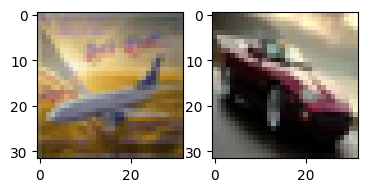

tensor([[[ 96, 143, 211,  ..., 111, 209,   8],
         [ 86, 195, 252,  ..., 206,  55, 158],
         [221,  67, 173,  ..., 142, 191,  26],
         ...,
         [ 45,  94,  32,  ..., 253,  40, 109],
         [ 80, 134, 206,  ..., 111,  91, 152],
         [190,  48, 104,  ...,  13,  66,  19]],

        [[ 39,  82,  32,  ...,   1,  41, 110],
         [ 64, 113, 184,  ..., 177,  80, 144],
         [175, 239,  47,  ...,  70, 113,  48],
         ...,
         [240, 145, 186,  ..., 173, 215,  35],
         [149, 175,  15,  ..., 165, 216,  45],
         [ 21,  61, 114,  ..., 244, 150, 192]],

        [[244, 148, 188,  ..., 158, 216,  67],
         [174, 211,  35,  ..., 172, 220,  36],
         [ 26,  66, 119,  ..., 244, 152, 193],
         ...,
         [ 48,  86, 141,  ..., 147,  57,  96],
         [152,  64, 103,  ..., 181, 232, 145],
         [185, 236, 148,  ..., 251,  39,  95]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


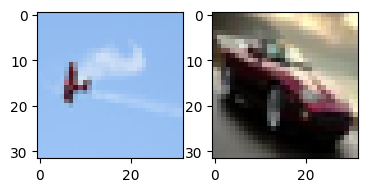

tensor([[[ 34,   0, 238,  ..., 219,  34, 252],
         [219,  33, 248,  ..., 230, 205, 250],
         [226, 199, 247,  ..., 201, 172, 159],
         ...,
         [203, 187, 240,  ..., 177, 163, 157],
         [254, 238, 228,  ..., 247,  44,  14],
         [240,  41,  12,  ..., 233, 221, 230]],

        [[232, 219,   8,  ..., 178, 166, 160],
         [252, 236, 228,  ...,   8,  64,  35],
         [  6,  64,  34,  ..., 221, 214, 219],
         ...,
         [223, 224, 214,  ...,   3, 254,  12],
         [  3, 252,   8,  ..., 140, 130, 128],
         [  6, 240, 224,  ..., 200, 229, 219]],

        [[218, 248, 237,  ...,  75,  71,  88],
         [ 77,  70,  85,  ..., 171, 160, 148],
         [ 13, 249, 233,  ..., 221, 213, 202],
         ...,
         [240, 243, 188,  ..., 166, 219, 222],
         [166, 229, 233,  ..., 235, 155, 239],
         [238, 160, 246,  ..., 248, 239, 163]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


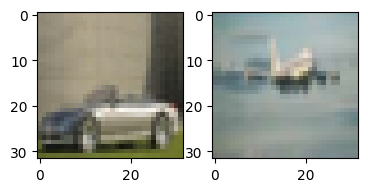

tensor([[[236, 231, 241,  ..., 231, 220, 212],
         [241, 206, 195,  ..., 203, 229, 207],
         [197, 225, 199,  ..., 203, 185, 228],
         ...,
         [156, 117,  13,  ..., 185, 157, 216],
         [223, 206, 240,  ..., 171,  31, 213],
         [182,  29, 219,  ..., 155, 132, 251]],

        [[163, 139,  11,  ..., 200, 175, 233],
         [213, 195, 233,  ..., 187,  37, 219],
         [197,  38, 225,  ..., 177, 155,  21],
         ...,
         [218, 170, 236,  ..., 222, 220, 208],
         [204, 206, 188,  ..., 145, 143, 151],
         [ 79,  79,  79,  ..., 172, 182, 207]],

        [[206, 179, 239,  ..., 172, 171, 166],
         [160, 162, 172,  ..., 141, 139, 147],
         [ 78,  78,  78,  ..., 163, 191, 194],
         ...,
         [ 82,  82,  82,  ...,  86,  80,  83],
         [ 82,  79,  83,  ...,  90,  91,  83],
         [ 89,  90,  85,  ...,  94,  99, 102]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


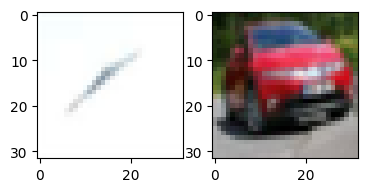

tensor([[[ 50, 155, 125,  ...,  12, 215,  50],
         [ 11, 212,  48,  ...,  51,  11, 215],
         [ 51,  10, 215,  ..., 223,  59,  11],
         ...,
         [ 83,  63, 149,  ..., 157,  21, 253],
         [ 24, 164, 134,  ..., 160,  32,   2],
         [245,  86,  74,  ...,  37,  32, 116]],

        [[ 37,  20, 147,  ..., 115, 255, 228],
         [211, 103,  73,  ..., 185,   7,   6],
         [  1, 246,  27,  ...,  35,  22,  74],
         ...,
         [177, 229, 191,  ..., 186, 167,  10],
         [215, 194,  14,  ..., 183, 173, 174],
         [ 89,  82, 105,  ...,  99, 152, 143]],

        [[155, 230, 212,  ..., 204, 193,  49],
         [ 10, 253,  78,  ..., 160, 156, 161],
         [ 77,  75, 104,  ...,  61, 127, 111],
         ...,
         [ 80,  84, 113,  ..., 158, 119, 142],
         [163, 121, 145,  ..., 155, 171, 133],
         [158, 173, 133,  ..., 110, 125, 139]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


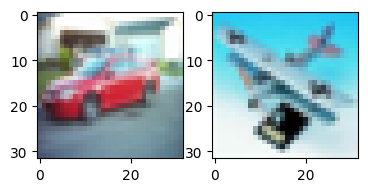

tensor([[[  4, 252,  11,  ...,  24,  21,  11],
         [ 24,  20,  11,  ...,  39,  36,  61],
         [ 37,  40,  46,  ..., 248, 238, 238],
         ...,
         [251, 228,  34,  ...,  19, 226, 217],
         [242, 217, 221,  ..., 233, 249, 252],
         [ 12,  66,  66,  ...,  70,  49,  39]],

        [[253, 226,  22,  ...,  23, 228, 217],
         [242, 216, 219,  ...,  70,   7,   5],
         [ 24,   4,   5,  ...,  49,  37, 102],
         ...,
         [168,  31, 205,  ..., 192, 127, 115],
         [190, 115, 116,  ...,  21,   2, 187],
         [ 13, 244, 191,  ..., 144,  21, 229]],

        [[217,  77,   6,  ..., 187, 116, 117],
         [186, 108, 106,  ...,  14, 249, 181],
         [ 20, 253, 199,  ..., 151,  41,   6],
         ...,
         [ 28,  12, 212,  ..., 205,  17,   5],
         [208,   7, 250,  ..., 253, 179,  14],
         [  1, 185,  28,  ...,  75,  69,   6]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


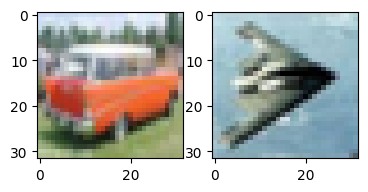

tensor([[[130, 160, 139,  ..., 129, 122, 156],
         [128, 139, 171,  ..., 105,  90, 109],
         [115, 100, 113,  ..., 108, 115, 105],
         ...,
         [152, 105, 132,  ...,  98, 109,  90],
         [100, 122,  93,  ..., 139, 210, 208],
         [144, 213, 209,  ..., 183, 112, 199]],

        [[180, 114, 190,  ...,  98, 109,  86],
         [ 97, 120,  94,  ..., 192, 213, 213],
         [166, 212, 209,  ..., 189, 127, 201],
         ...,
         [254,  43,  56,  ..., 230, 197, 249],
         [252, 226, 235,  ..., 101,  98,  77],
         [128, 152, 129,  ..., 245,  13,  30]],

        [[ 18,   3,  16,  ..., 204, 170,  24],
         [ 23,   7,  49,  ..., 106, 103,  81],
         [131, 155, 131,  ..., 239,  11,  22],
         ...,
         [222, 242, 248,  ...,   6,   0,   6],
         [  1, 253,   4,  ..., 253, 252, 254],
         [253, 252, 242,  ..., 221, 226, 228]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


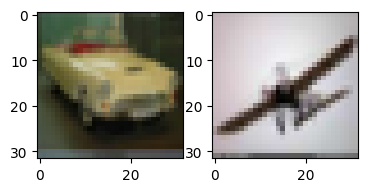

tensor([[[101, 181,  85,  ...,  86,  96, 137],
         [ 77,  87, 122,  ..., 106,  59, 133],
         [173, 111, 125,  ...,  75, 154,  65],
         ...,
         [162, 151, 230,  ..., 103, 127,  84],
         [161, 189, 143,  ..., 123, 125, 135],
         [116, 123, 133,  ..., 205, 190, 249]],

        [[252, 235,  15,  ...,  86,  90,  66],
         [175, 187, 153,  ..., 126, 123, 128],
         [110, 133, 139,  ...,  20,  10,  12],
         ...,
         [  5,  12,  18,  ...,  96,  94, 108],
         [107, 103,  92,  ..., 223, 245, 238],
         [206, 235, 214,  ...,  60,  35,  41]],

        [[ 39,  21,  27,  ...,  39,  36,  76],
         [ 78,  80,  54,  ...,  24,  53,  36],
         [196, 253, 225,  ...,  32,  44,  51],
         ...,
         [131, 233, 168,  ..., 220, 211, 247],
         [230, 203, 233,  ..., 162, 161, 145],
         [176, 167, 159,  ...,  67, 197, 145]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


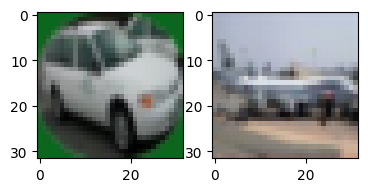

tensor([[[180, 191, 223,  ..., 210, 165, 178],
         [210, 165, 178,  ..., 176, 208, 165],
         [178, 209, 168,  ..., 185, 195, 225],
         ...,
         [161, 196, 150,  ..., 176, 187, 219],
         [164, 177, 210,  ..., 194, 145, 159],
         [194, 144, 158,  ..., 161, 196, 149]],

        [[162, 197, 151,  ..., 177, 188, 220],
         [169, 182, 215,  ..., 194, 143, 157],
         [192, 142, 157,  ..., 155, 191, 144],
         ...,
         [ 11, 217,  21,  ..., 220, 238, 222],
         [222, 244, 219,  ..., 159, 170, 202],
         [153, 163, 194,  ..., 246, 214, 220]],

        [[247, 235, 240,  ..., 244,  15, 232],
         [242,  14, 238,  ..., 155, 168, 200],
         [158, 168, 199,  ..., 238, 216, 217],
         ...,
         [249,   5,  31,  ...,  18, 234, 246],
         [ 17, 233, 245,  ..., 245,  13, 233],
         [244,  15, 237,  ..., 250,   4,  26]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


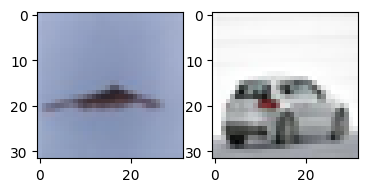

tensor([[[234, 216, 222,  ..., 232, 183, 161],
         [175, 194, 173,  ..., 181, 189, 190],
         [160, 169, 253,  ..., 236, 222, 223],
         ...,
         [ 46, 104,  96,  ..., 117,  93,  72],
         [127, 104, 161,  ..., 162,  93,  82],
         [114,  40,  22,  ...,  29,  66,  35]],

        [[ 19,  91,  55,  ...,  66,  37,  11],
         [186, 158, 207,  ..., 101, 245, 233],
         [  1, 243, 228,  ..., 209, 234, 215],
         ...,
         [239, 228, 211,  ...,  78,  40,  92],
         [ 67,  35,  91,  ..., 208, 176, 196],
         [202, 178, 214,  ..., 216, 209, 192]],

        [[219, 223, 206,  ..., 105,  72, 130],
         [103,  72, 127,  ..., 207, 178, 186],
         [205, 179, 221,  ..., 211, 199, 180],
         ...,
         [199, 207, 233,  ..., 228, 215, 190],
         [231, 210, 185,  ..., 181, 221, 206],
         [182, 218, 208,  ..., 217, 192, 222]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


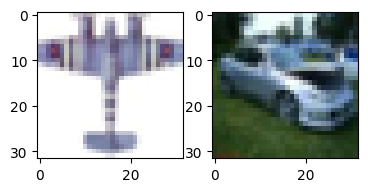

tensor([[[  5,  50, 118,  ..., 104, 233,  24],
         [102, 232,  24,  ...,  29, 105, 241],
         [ 31, 109, 244,  ...,  59, 101, 163],
         ...,
         [ 36, 115, 250,  ...,  79, 119, 182],
         [ 13,  54, 126,  ..., 115, 242,  31],
         [113, 236,  24,  ...,  34, 116, 247]],

        [[ 30,  90, 241,  ...,  84, 122, 185],
         [ 22,  63, 134,  ...,  24, 239,  27],
         [ 97, 238,  28,  ...,  28, 100, 242],
         ...,
         [121,  36,  73,  ..., 139, 142, 166],
         [176, 172, 179,  ..., 117, 157, 214],
         [ 26,  68, 141,  ..., 144,  35,  70]],

        [[127,  15,  52,  ..., 111, 135, 147],
         [177, 224, 154,  ..., 106, 145, 205],
         [ 26,  67, 140,  ..., 132,  59,  95],
         ...,
         [ 62,  92, 203,  ..., 197,  50,  81],
         [195,  49,  76,  ...,  71, 202,  42],
         [ 69, 198,  39,  ...,  48,  77, 202]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


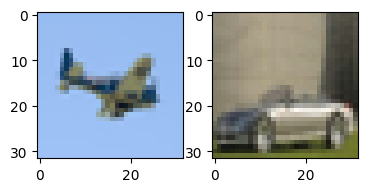

tensor([[[ 58, 123, 160,  ...,  91,  27,  56],
         [ 85,  25,  61,  ...,  56, 102, 247],
         [ 67, 124, 240,  ...,  24,  92, 152],
         ...,
         [240,  46,  36,  ..., 119, 136, 172],
         [ 55,  70, 110,  ..., 189,  55, 109],
         [165,  74, 122,  ..., 235,  27, 234]],

        [[  4,  65,  61,  ..., 123, 139, 184],
         [ 32,  69, 111,  ..., 164,  53, 105],
         [153,  69, 107,  ..., 241,  48,   5],
         ...,
         [248,  70,  85,  ..., 254,  18,  25],
         [ 46,  68,  37,  ...,  75,  90, 128],
         [ 80, 107, 141,  ...,  47, 234, 250]],

        [[237,  23,  38,  ...,  36,  39,  54],
         [ 70,  84,  43,  ..., 113, 121, 152],
         [ 75, 106, 155,  ...,  82,   3,  21],
         ...,
         [ 64,  83, 142,  ...,  97,  31,  41],
         [ 95,  34,  42,  ...,  87, 135,  83],
         [ 94, 144,  90,  ...,  39,  50,  85]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


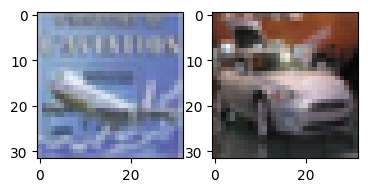

tensor([[[216, 220, 217,  ..., 202, 150, 159],
         [182, 145, 137,  ...,  31, 105,  56],
         [ 92, 173, 133,  ..., 218, 222, 219],
         ...,
         [ 85, 160,  41,  ..., 254, 254, 250],
         [251, 253, 253,  ..., 225, 177, 186],
         [205, 158, 166,  ..., 113, 170,  67]],

        [[108, 178,  28,  ..., 238, 241, 243],
         [252, 254, 254,  ..., 235, 194, 198],
         [216, 175, 180,  ..., 148, 203,  60],
         ...,
         [217, 139, 153,  ..., 159, 175, 130],
         [151, 166, 119,  ..., 133, 158, 178],
         [235, 240, 243,  ..., 131, 186, 187]],

        [[182, 204, 218,  ..., 191, 195, 172],
         [191, 194, 168,  ..., 208, 210, 223],
         [251, 251, 252,  ..., 101, 136, 139],
         ...,
         [220, 223, 211,  ..., 198, 203, 211],
         [198, 202, 210,  ..., 217, 206, 210],
         [217, 206, 210,  ..., 215, 222, 214]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


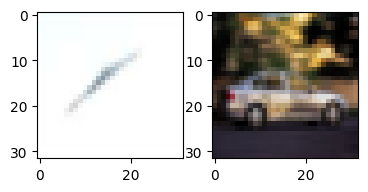

tensor([[[147, 139, 124,  ..., 140, 177, 167],
         [142, 178, 167,  ..., 166, 143, 173],
         [164, 139, 166,  ...,  92,  88,  79],
         ...,
         [238, 206, 239,  ..., 145, 135, 116],
         [142, 137, 117,  ..., 163, 170, 160],
         [133, 175, 165,  ...,   8, 233, 204]],

        [[191, 164, 193,  ...,  91,  86,  73],
         [133, 128, 109,  ..., 223, 216, 207],
         [182, 199, 189,  ...,  47,  22, 235],
         ...,
         [249, 225, 224,  ..., 193, 186, 191],
         [189, 180, 181,  ...,  38,  34,  30],
         [131, 125, 104,  ..., 245, 232, 233]],

        [[230, 245, 244,  ...,   9,   1,  10],
         [  8, 254,   4,  ...,  49,  47,  39],
         [132, 127, 106,  ..., 224, 206, 206],
         ...,
         [116, 122,  63,  ...,  68, 120, 125],
         [ 63, 115, 124,  ..., 127,  48, 120],
         [129,  52, 123,  ..., 112, 119,  46]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


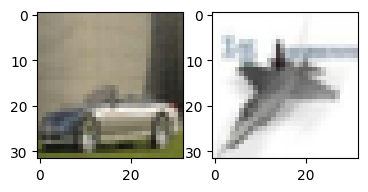

tensor([[[ 10, 229, 184,  ..., 183,   1, 217],
         [182, 255, 216,  ..., 201, 167, 244],
         [206, 164, 244,  ..., 245, 206, 167],
         ...,
         [201, 203, 186,  ..., 203, 181, 165],
         [210, 189, 169,  ..., 170, 202, 183],
         [162, 197, 181,  ..., 192, 200, 200]],

        [[197, 205, 187,  ..., 215, 196, 180],
         [205, 185, 157,  ..., 165, 181, 169],
         [146, 173, 162,  ..., 175, 184, 186],
         ...,
         [ 40,  94,  91,  ..., 238,  29, 238],
         [239,  29, 222,  ..., 184, 182, 221],
         [208, 201, 237,  ...,  14,  50,  47]],

        [[ 71,  73,  69,  ..., 224,  11, 198],
         [201, 245, 193,  ..., 203, 199, 226],
         [231, 227, 231,  ...,   3,  56,  55],
         ...,
         [ 78,  79, 131,  ..., 104,  78,  79],
         [ 97,  75,  77,  ...,  65,  74,  64],
         [ 62,  70,  62,  ...,  66,  57,  54]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


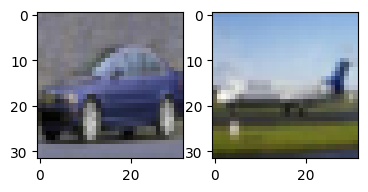

tensor([[[119, 103, 125,  ..., 109, 102,  77],
         [102,  98,  75,  ..., 172, 191, 166],
         [161, 180, 167,  ..., 196, 196, 209],
         ...,
         [108, 160, 136,  ..., 197, 193, 208],
         [197, 190, 214,  ..., 127,  58,  66],
         [120,  54,  62,  ...,  77, 152,  60]],

        [[ 82, 150,  70,  ..., 200, 192, 212],
         [199, 191, 212,  ...,  74,  46,  51],
         [ 90,  28,  34,  ...,  68, 134,  58],
         ...,
         [ 49, 192, 198,  ...,  83, 108, 139],
         [145, 168, 144,  ..., 200, 206, 218],
         [174, 165, 181,  ..., 215,  54,  54]],

        [[ 72, 219, 227,  ..., 143, 174, 117],
         [125, 146, 114,  ..., 200, 205, 218],
         [175, 167, 181,  ..., 222,  94,  96],
         ...,
         [154, 140, 130,  ..., 139, 143, 145],
         [145, 146, 146,  ..., 157, 157, 159],
         [158, 156, 159,  ..., 169, 164, 161]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


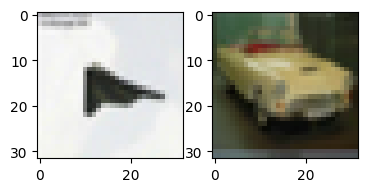

tensor([[[192, 226, 254,  ...,   5, 194, 224],
         [  4, 195, 226,  ..., 237,  17, 207],
         [238,  20, 210,  ...,   7,  32,  54],
         ...,
         [236,  16, 198,  ...,  13,  43,  65],
         [163, 195, 228,  ..., 253, 183, 223],
         [  0, 182, 218,  ..., 228,   7, 220]],

        [[248,  25, 186,  ..., 253,  26,  45],
         [167, 197, 227,  ..., 238, 171, 213],
         [240, 170, 209,  ..., 203, 236, 209],
         ...,
         [230, 215, 227,  ..., 211, 232, 153],
         [169, 190, 169,  ...,  90,  95,  87],
         [240, 253,   5,  ..., 252, 252,   3]],

        [[  5, 236, 244,  ..., 134, 148, 105],
         [118, 126, 150,  ...,  96, 101,  95],
         [249, 251,   2,  ...,  21,  70,  77],
         ...,
         [ 46,  42,  80,  ...,  99,  58,  55],
         [102,  57,  49,  ...,  44, 108,  47],
         [ 41, 103,  48,  ...,  31,  27,  82]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


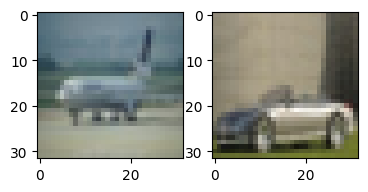

tensor([[[189, 157, 136,  ..., 148, 218, 186],
         [151, 216, 187,  ..., 181, 143, 206],
         [178, 139, 203,  ..., 138, 107,  90],
         ...,
         [168, 135, 193,  ..., 112,  87,  66],
         [174, 150, 124,  ..., 140, 204, 175],
         [138, 206, 180,  ..., 171, 135, 193]],

        [[165, 132, 194,  ..., 107,  84,  63],
         [164, 140, 115,  ..., 140, 204, 174],
         [139, 205, 178,  ..., 173, 138, 199],
         ...,
         [ 15, 237,   4,  ...,  73,  65,  46],
         [ 38,  33, 219,  ...,  70,  47,  37],
         [157, 134, 105,  ...,  77,  64,  69]],

        [[ 82,  68,  80,  ...,  12, 254,  19],
         [  1, 246,   9,  ...,  80,  59,  45],
         [158, 136, 108,  ...,  74,  41,  47],
         ...,
         [121, 111,  47,  ...,  54, 133, 124],
         [ 58, 132, 129,  ..., 133,  49, 141],
         [134,  52, 144,  ..., 139, 128,  49]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


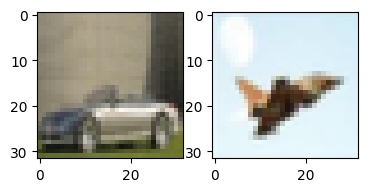

tensor([[[149, 193, 216,  ..., 176, 137, 155],
         [170, 140, 164,  ..., 172, 203, 110],
         [179, 214, 106,  ..., 130, 187, 213],
         ...,
         [119, 116, 189,  ..., 236, 241, 242],
         [149, 145, 151,  ...,  41,  33,  47],
         [ 24,  35,  39,  ..., 101,  89, 113]],

        [[114, 100, 208,  ..., 247, 248, 247],
         [129, 146, 150,  ...,  40,  86,  90],
         [ 31, 105, 100,  ...,  58,  51,  55],
         ...,
         [252, 125, 110,  ..., 175, 105, 249],
         [237, 171,  45,  ...,  69,  68,  41],
         [150, 163, 164,  ...,  42, 100,  79]],

        [[241, 115, 102,  ..., 242, 170,  46],
         [ 35, 220,  72,  ...,  62,  57,  30],
         [160, 166, 175,  ...,  20,  89,  78],
         ...,
         [191, 194, 210,  ...,  80,  52,  53],
         [ 39,  37,  36,  ..., 137,  69, 163],
         [133,  82, 173,  ..., 145, 156, 153]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


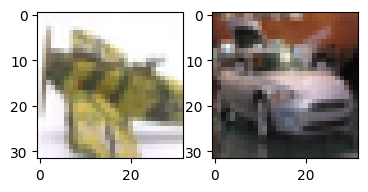

tensor([[[ 22,  32,  41,  ...,  54,  21,  33],
         [ 53,  22,  35,  ...,  42,  59,  30],
         [ 42,  60,  31,  ...,  78,  85,  86],
         ...,
         [ 54,  70,  46,  ..., 102, 106, 108],
         [ 32,  40,  51,  ...,  56,  32,  46],
         [ 66,  35,  46,  ...,  52,  72,  47]],

        [[ 56,  72,  44,  ..., 107, 109, 111],
         [ 43,  50,  59,  ...,  49,  12,  32],
         [ 54,  27,  42,  ...,  48,  66,  41],
         ...,
         [251, 249,  14,  ..., 218, 211, 199],
         [217, 211, 201,  ...,  54,  74,  61],
         [194, 222, 217,  ..., 249, 232, 251]],

        [[234, 213, 234,  ..., 136, 123, 113],
         [133, 121, 113,  ...,  17,  39,  21],
         [187, 214, 206,  ..., 228, 249,  11],
         ...,
         [171, 169, 224,  ..., 230, 171, 171],
         [224, 176, 172,  ..., 196,   1, 174],
         [176, 233, 169,  ..., 161, 161, 221]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


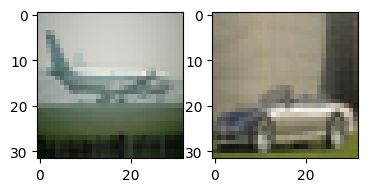

tensor([[[194, 200, 179,  ..., 181, 196, 211],
         [181, 215, 227,  ..., 167, 148, 182],
         [178, 159, 182,  ..., 168, 161, 148],
         ...,
         [245, 187, 241,  ..., 197, 183, 159],
         [207, 194, 163,  ..., 222,  55,  36],
         [231,  66,  43,  ...,  20, 196,  60]],

        [[ 19, 198,  47,  ..., 198, 185, 155],
         [173, 177, 163,  ...,  21,  52,  35],
         [250,  63,  42,  ...,  26, 212,  62],
         ...,
         [200, 233, 229,  ..., 221, 207, 218],
         [215, 202, 214,  ..., 181, 177, 171],
         [224, 230, 219,  ..., 188, 220, 212]],

        [[192, 228, 220,  ..., 232, 213, 255],
         [250, 237,   1,  ..., 185, 182, 178],
         [220, 225, 216,  ..., 172, 228, 221],
         ...,
         [251,  10,  25,  ...,  38, 142, 166],
         [179, 180, 212,  ..., 226, 236, 226],
         [225, 237, 225,  ..., 230, 234, 249]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


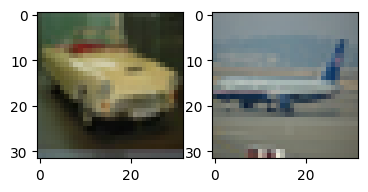

tensor([[[ 94, 118, 147,  ...,  41,  17,  22],
         [ 39,  14,  20,  ...,  27,  40,  28],
         [ 26,  41,  26,  ...,  21,  27,  45],
         ...,
         [ 23,  56,  10,  ...,  25,  34,  51],
         [165, 180, 181,  ..., 206,   0, 255],
         [ 16,  12,  32,  ...,   6,  45,   0]],

        [[255,  38,  27,  ..., 251,  17,  27],
         [107, 117, 119,  ..., 220, 251,  19],
         [ 44, 226,  31,  ...,  27,  58, 214],
         ...,
         [203, 206, 209,  ..., 148, 172, 175],
         [164, 182, 179,  ..., 217, 223, 252],
         [127, 131, 175,  ..., 139, 175, 169]],

        [[200, 222, 229,  ..., 212, 235, 221],
         [218, 241, 227,  ..., 218, 221, 250],
         [126, 130, 175,  ..., 140, 163, 159],
         ...,
         [180, 172, 220,  ...,   8, 227, 238],
         [ 15, 223, 238,  ..., 251,  24, 239],
         [254,  26, 240,  ..., 219, 229,   5]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


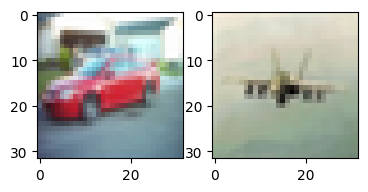

tensor([[[ 71,  19, 193,  ..., 165,  54, 254],
         [166,  53, 253,  ..., 221, 146,  42],
         [248, 171,  65,  ...,  42, 236, 148],
         ...,
         [132, 107, 209,  ..., 116,  64, 223],
         [ 44, 255, 167,  ..., 171, 216, 225],
         [193, 202, 208,  ..., 226, 211,  93]],

        [[ 99,  89, 217,  ...,  99,  45, 201],
         [ 15, 230, 146,  ..., 200, 167, 181],
         [151, 133, 145,  ...,  19,  18, 164],
         ...,
         [230, 228, 238,  ..., 116,  98,  37],
         [ 48,  55, 232,  ..., 228, 216, 169],
         [ 25,  15, 222,  ...,  17, 244, 251]],

        [[245, 228, 233,  ...,  46,  15,  11],
         [ 19,  19,   8,  ..., 220, 204, 160],
         [238, 227, 181,  ...,   2,   0, 254],
         ...,
         [248, 227, 183,  ..., 174, 234, 217],
         [173, 234, 216,  ..., 200, 156, 220],
         [199, 155, 228,  ..., 232, 216, 167]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


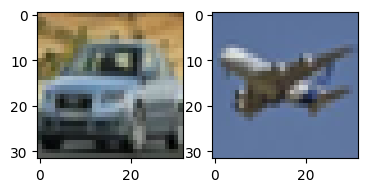

tensor([[[252, 200, 136,  ..., 166,   0, 233],
         [170, 253, 224,  ..., 218, 136,  26],
         [210, 124,  30,  ...,  14, 210, 136],
         ...,
         [243, 209, 175,  ..., 132, 127,  90],
         [216, 222, 181,  ...,  93, 189, 158],
         [106, 164, 149,  ...,   2, 231, 239]],

        [[233, 209, 149,  ..., 118, 117,  83],
         [231, 218, 180,  ..., 104, 182, 155],
         [110, 153, 146,  ..., 243, 206, 202],
         ...,
         [ 26,  49,  43,  ...,  25,  15, 214],
         [213, 202, 156,  ..., 148, 143, 125],
         [153, 140, 120,  ..., 111, 185, 184]],

        [[174,  37,  31,  ..., 215, 211, 168],
         [167, 158, 139,  ..., 132, 133, 114],
         [153, 145, 122,  ..., 126, 196, 195],
         ...,
         [145, 140, 113,  ..., 131, 154, 158],
         [143, 154, 159,  ..., 120, 105, 113],
         [120, 103, 111,  ..., 185, 177, 164]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


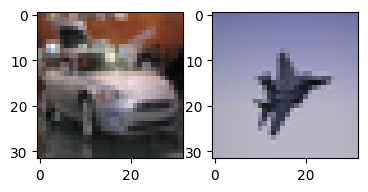

tensor([[[179, 253,  64,  ...,  69, 164, 245],
         [ 68, 164, 246,  ..., 251,  72, 173],
         [253,  76, 175,  ..., 234,  47, 108],
         ...,
         [ 24, 102, 195,  ...,  17,  86, 148],
         [207,  23,  88,  ...,  94, 191,  17],
         [ 98, 189,  13,  ...,  20, 100, 203]],

        [[ 26, 103, 203,  ...,  25,  92, 152],
         [213,  34, 104,  ...,  96, 194,  19],
         [ 99, 192,  15,  ...,  18,  94, 219],
         ...,
         [244, 230, 233,  ..., 233,   8, 196],
         [219, 238, 214,  ...,  76, 142, 191],
         [238,  53, 117,  ...,  34, 228, 254]],

        [[ 18, 215, 239,  ..., 212,   4, 160],
         [205, 245, 159,  ...,  67, 131, 183],
         [239,  52, 116,  ...,  96,  36,  84],
         ...,
         [ 36,  86, 182,  ..., 195,  43,  91],
         [194,  43,  87,  ...,  83, 200,  35],
         [ 80, 195,  31,  ...,  26,  71, 181]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


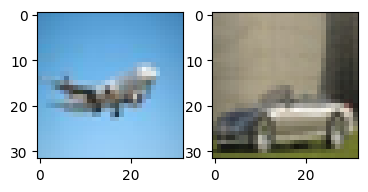

tensor([[[201,  17,  99,  ..., 124, 215,  34],
         [122, 216,  35,  ...,  67, 139, 227],
         [ 40, 113, 204,  ..., 227,  52, 136],
         ...,
         [120, 159,  49,  ..., 151, 225,  64],
         [227,  32, 119,  ...,  62, 249,   6],
         [ 52,  48,  51,  ...,  58, 113,  88]],

        [[124, 166,  45,  ..., 168, 241,  81],
         [  0,  57, 139,  ...,  54,  11,  27],
         [ 81,  59,  63,  ...,  54, 107,  78],
         ...,
         [165,  46,  65,  ..., 214, 249,  15],
         [ 46,  79,  60,  ...,  40,  71, 115],
         [245,  18,  65,  ..., 116,  45,  79]],

        [[116,  24,  50,  ..., 237,  13,  12],
         [ 47,  82,  21,  ...,  46,  81, 122],
         [ 32,  63, 105,  ...,  72,   5,  36],
         ...,
         [ 22,  59, 101,  ..., 109,  33,  69],
         [110,  33,  70,  ...,  85, 126,  46],
         [ 86, 127,  38,  ...,  34,  71, 113]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


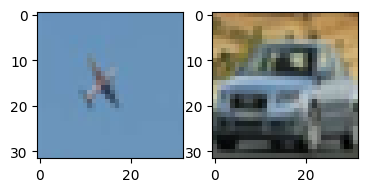

tensor([[[ 37,  60,  72,  ...,  63,  30,  43],
         [ 59,  30,  46,  ...,  27,  40, 255],
         [ 15,  33, 251,  ..., 103, 122, 128],
         ...,
         [ 64,  76,  53,  ..., 128, 146, 153],
         [ 55,  75,  87,  ...,  18,  42,  13],
         [ 33,  47,  17,  ...,  59,  74,  58]],

        [[ 64,  77,  53,  ..., 133, 149, 156],
         [ 64,  77,  95,  ..., 235,   1, 225],
         [250, 245, 204,  ...,  31,  51,  56],
         ...,
         [190, 170, 187,  ..., 175, 174, 236],
         [152, 155, 236,  ..., 117, 136, 141],
         [ 27,  49,  67,  ..., 184, 165, 181]],

        [[176, 148, 165,  ..., 146, 140, 159],
         [145, 145, 154,  ...,  94, 116, 124],
         [ 19,  39,  57,  ..., 209, 204, 217],
         ...,
         [ 22,  33,  86,  ...,  52, 222, 249],
         [ 50, 219, 240,  ..., 228,  49, 206],
         [228,  45, 200,  ..., 224, 243,  56]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


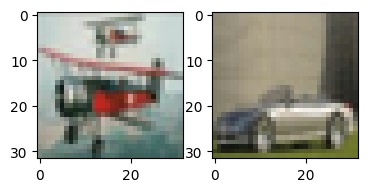

tensor([[[124, 159, 187,  ...,   0, 117, 155],
         [194, 155, 193,  ..., 208, 237, 140],
         [167, 199, 144,  ..., 133, 173, 213],
         ...,
         [ 39,  28,  19,  ..., 130, 160, 204],
         [199, 214, 255,  ...,  14,  39,  44],
         [ 64,  96,  99,  ...,  15,  23,  98]],

        [[ 84,  74,  55,  ..., 174, 205, 252],
         [248,   4,  41,  ..., 228,  49,  42],
         [ 63, 137, 137,  ...,  45,  49, 112],
         ...,
         [ 82,  80,  62,  ..., 182, 169,  34],
         [ 21,  11,  83,  ...,  61,  47,  45],
         [ 16,   3,   6,  ...,  19,  46,  28]],

        [[ 13,  22, 255,  ..., 200, 186,  25],
         [ 17,   9,  45,  ...,  67,  57,  51],
         [ 59,  45,  44,  ..., 224,   1, 240],
         ...,
         [ 34,  29,  25,  ...,  37,  54,  41],
         [ 36,  57,  45,  ...,  54,  49,  64],
         [ 55,  50,  55,  ...,  37,  31,  33]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


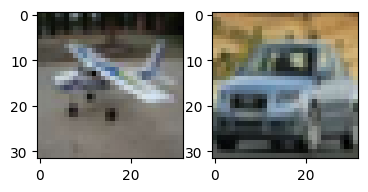

tensor([[[107,  80,  62,  ...,  46,  95,  58],
         [ 59,  95,  64,  ..., 136,  73, 181],
         [149,  90, 178,  ..., 177,  90,  87],
         ...,
         [  3,  82,  54,  ..., 125, 104,  91],
         [140,  62,  55,  ...,  68,  47,  13],
         [118,  77,  42,  ...,  15,  69,  61]],

        [[  5,  71,  60,  ..., 150, 125, 111],
         [161, 129, 113,  ..., 121,  65,  37],
         [125,  65,  38,  ...,  16,  66,  73],
         ...,
         [157,  97,  68,  ...,  23,  84,  42],
         [250,  89, 215,  ..., 184, 152, 124],
         [182, 155, 126,  ..., 121,  91,  76]],

        [[135, 122,  97,  ...,  12,  77,  36],
         [239,  88, 214,  ..., 170, 138, 112],
         [189, 160, 132,  ..., 145, 118,  93],
         ...,
         [187, 158, 135,  ..., 157, 165, 154],
         [145, 156, 148,  ..., 200, 193, 221],
         [198, 181, 219,  ..., 195, 169, 146]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


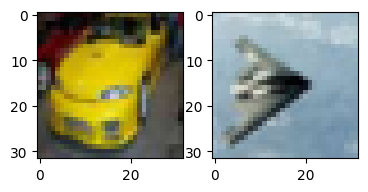

tensor([[[137, 130, 129,  ..., 246, 225, 233],
         [246, 225, 233,  ..., 229, 240, 222],
         [228, 238, 220,  ..., 209, 216, 224],
         ...,
         [ 22,  17, 223,  ..., 239, 239, 251],
         [108, 102, 132,  ..., 109,  23,  33],
         [ 48,  15,   1,  ...,  56,  49,  12]],

        [[ 17,   6, 200,  ...,  19,   3,  21],
         [163, 162, 192,  ...,  97,  34,  13],
         [ 19,  59,   0,  ...,  33,  34,  22],
         ...,
         [214,  21,  10,  ..., 117, 118, 132],
         [132, 139, 129,  ..., 104,  85,  84],
         [163, 165, 152,  ..., 176, 111, 112]],

        [[100,  87,  78,  ..., 109, 115, 111],
         [104, 111, 104,  ..., 107,  89,  87],
         [171, 171, 152,  ..., 198, 154, 157],
         ...,
         [156, 156, 138,  ...,  90, 117,  97],
         [ 85, 115,  94,  ...,  86,  78, 109],
         [ 85,  77, 112,  ..., 134, 113, 104]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


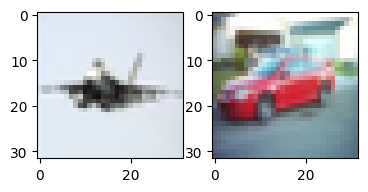

tensor([[[ 49,  79, 108,  ...,  98,  13,  49],
         [ 94,  12,  49,  ...,  54,  96,  20],
         [ 56, 100,  24,  ...,  97, 128, 156],
         ...,
         [ 63, 107,  29,  ..., 109, 143, 175],
         [ 40,  74, 116,  ..., 101,  25,  57],
         [ 98,  23,  54,  ...,  56, 105,  25]],

        [[ 62, 109,  23,  ..., 111, 142, 177],
         [ 36,  76, 120,  ..., 103,  29,  60],
         [102,  26,  57,  ...,  50, 105,  16],
         ...,
         [116,  74, 103,  ...,  61,  79,  30],
         [ 59,  79,  33,  ..., 160, 190, 208],
         [ 62,  96, 134,  ..., 139,  75, 102]],

        [[121,  56,  84,  ..., 243,  11, 212],
         [240,  11, 214,  ..., 153, 181, 202],
         [ 64,  95, 133,  ..., 128, 100, 128],
         ...,
         [121, 134, 199,  ..., 196, 110, 123],
         [195, 109, 118,  ..., 116, 202, 104],
         [114, 197, 102,  ..., 111, 123, 202]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


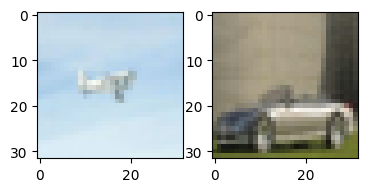

tensor([[[ 42, 234, 176,  ..., 190, 240, 206],
         [188, 239, 206,  ..., 212, 192, 249],
         [214, 196, 252,  ...,  90,  34, 238],
         ...,
         [100, 124,   6,  ..., 124,  96,  84],
         [252, 205, 172,  ..., 121,  78,  88],
         [112, 212, 222,  ...,  97, 123,  96]],

        [[104, 128,  12,  ..., 132, 102,  87],
         [  1, 210, 175,  ...,  95,  19,  29],
         [ 53, 162, 171,  ...,  92, 118,  91],
         ...,
         [ 80, 216, 221,  ...,  87,  95,  86],
         [ 88,  97,  91,  ..., 159, 133, 114],
         [ 45, 254, 221,  ..., 154, 134, 132]],

        [[138,  82,  83,  ...,  17,  25,  13],
         [ 15,  25,  16,  ..., 148, 120, 106],
         [ 44, 252, 219,  ..., 143, 154, 154],
         ...,
         [ 90,  22,  11,  ..., 109,  91,  64],
         [107,  90,  59,  ...,  54, 114,  83],
         [ 52, 110,  80,  ...,  75,  24,  60]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


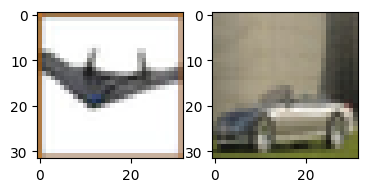

tensor([[[ 82,  74, 102,  ...,  68,  77,  58],
         [ 68,  73,  56,  ...,  71,  92,  88],
         [ 74, 102,  88,  ...,  28,  21,  55],
         ...,
         [ 29,  32,  47,  ...,  37,  14,  18],
         [ 50,  33,  47,  ...,  15,  67,  34],
         [ 24,  75,  39,  ...,  18,  17,  47]],

        [[ 21,  24,  45,  ...,  31,  13,  15],
         [ 45,  31,  47,  ...,  37,  50,  11],
         [248,  13, 228,  ..., 216, 210,   5],
         ...,
         [235,  86,  49,  ..., 201, 236, 205],
         [215, 241, 247,  ...,   6, 236, 237],
         [ 27,  16,  30,  ..., 158, 224, 188]],

        [[146,   5, 223,  ..., 225, 241, 189],
         [185, 197, 128,  ...,   7, 234, 237],
         [  8, 252,   8,  ..., 172, 177, 155],
         ...,
         [237, 204, 229,  ..., 156, 168, 151],
         [156, 184, 169,  ..., 165, 180, 162],
         [158, 173, 185,  ..., 223, 203, 225]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


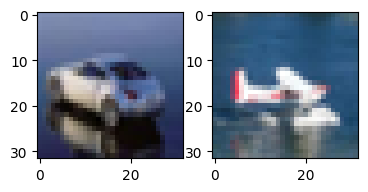

tensor([[[217, 201, 154,  ..., 199,  11, 242],
         [199,  11, 243,  ..., 232, 188, 251],
         [228, 184, 247,  ..., 191, 173, 128],
         ...,
         [213, 169, 233,  ..., 225, 207, 157],
         [210, 186, 137,  ..., 206,  16, 248],
         [204,  15, 247,  ..., 195, 153, 210]],

        [[191, 149, 206,  ..., 197, 182, 132],
         [229, 206, 158,  ..., 213,  20, 254],
         [220,  31,  12,  ..., 253, 217,  13],
         ...,
         [ 96,  70,  96,  ...,  28,   3,  39],
         [ 23,   0,  35,  ..., 185, 163, 126],
         [249, 228, 183,  ...,  75,  90, 101]],

        [[ 92,   8,  26,  ...,   6, 235,  20],
         [  6, 232,  18,  ..., 173, 152, 117],
         [217, 197, 156,  ..., 217,  11,  13],
         ...,
         [202, 180, 140,  ..., 137, 197, 175],
         [137, 197, 175,  ..., 171, 132, 193],
         [171, 132, 193,  ..., 190, 168, 129]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


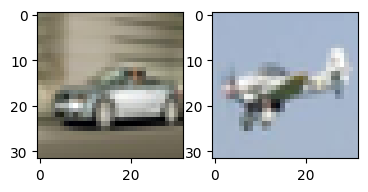

tensor([[[ 94,  92,  59,  ...,  57, 113, 102],
         [ 61, 117, 103,  ...,  61,  30,  80],
         [ 71,  34,  93,  ...,  96,  80,  32],
         ...,
         [102,  71, 112,  ..., 105,  91,  57],
         [118, 110,  76,  ...,  86, 122, 109],
         [ 80,  95,  88,  ..., 111,  79, 118]],

        [[109,  77, 116,  ..., 113,  95,  62],
         [129, 115,  79,  ...,  48, 121, 118],
         [ 96, 148, 150,  ..., 169, 134, 163],
         ...,
         [ 50,  27,  31,  ...,  24, 227,  49],
         [ 23, 229,  60,  ..., 111,  80,  17],
         [134, 101,  49,  ..., 132, 146, 146]],

        [[135, 118, 116,  ...,  93,  48,  99],
         [ 83,  47,  74,  ..., 118,  87,  28],
         [132, 102,  49,  ..., 139, 162, 156],
         ...,
         [196, 189, 136,  ...,  34,  33,  30],
         [ 34,  33,  27,  ...,  19, 254,  14],
         [254, 236,  81,  ..., 170, 148,  84]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


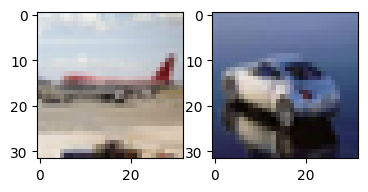

tensor([[[102,  54,  11,  ..., 246,  84,  31],
         [237,  73,  25,  ...,  25,  16,  66],
         [ 36,  36,  96,  ...,  93,  36, 242],
         ...,
         [  5, 231, 118,  ..., 206, 172, 130],
         [139,  88,  43,  ...,  59, 114,  71],
         [ 29, 113,  64,  ...,  85,  56, 167]],

        [[127, 102, 205,  ..., 215, 183, 146],
         [200, 148, 100,  ...,  81, 145, 100],
         [ 57, 139,  92,  ..., 156, 129, 197],
         ...,
         [  9,  58,  25,  ...,   5, 246,  32],
         [  5, 245, 244,  ...,  29, 252, 227],
         [  3, 228, 222,  ...,  10,  59,  33]],

        [[ 28,  85,  59,  ...,  15,   5,  63],
         [ 41,  31, 254,  ...,  14, 240, 231],
         [253, 222, 213,  ..., 190, 207, 182],
         ...,
         [107,  74,  50,  ...,  79, 117,  87],
         [ 62, 129,  99,  ...,  63,  39,  90],
         [ 64,  42,  95,  ..., 134, 106,  83]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


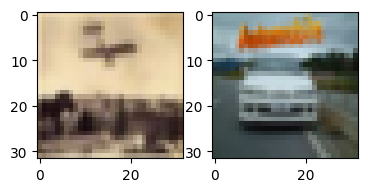

tensor([[[224, 148, 101,  ..., 134, 234, 183],
         [141, 230, 172,  ..., 165, 105,   2],
         [158,  94,   5,  ..., 240, 153,  98],
         ...,
         [219, 199, 150,  ..., 132,  99,  74],
         [225, 207, 171,  ..., 226, 207, 173],
         [176, 112,  92,  ..., 242, 227, 231]],

        [[213, 196, 123,  ..., 122,  93,  71],
         [242, 207, 170,  ..., 253,   7, 239],
         [254, 192, 184,  ..., 220, 201, 183],
         ...,
         [192, 193, 162,  ...,  41,  33,   5],
         [230, 225, 201,  ..., 183, 151, 134],
         [192, 153, 139,  ..., 140, 231, 200]],

        [[196, 207, 178,  ..., 232, 231, 215],
         [183, 178, 186,  ..., 170, 142, 123],
         [190, 162, 141,  ..., 155, 215, 187],
         ...,
         [229, 218, 214,  ..., 252,  25,  12],
         [  5,  27,  13,  ..., 246, 231,   5],
         [247, 225,   3,  ...,  26,   5,  16]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


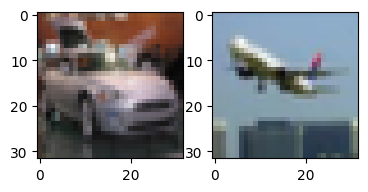

tensor([[[251,   1, 208,  ..., 195, 244,   0],
         [197,   6,  16,  ..., 214, 165, 224],
         [222, 172, 221,  ..., 198, 188, 145],
         ...,
         [  1, 203, 221,  ..., 198, 192, 139],
         [235, 233, 176,  ..., 229,  98,  79],
         [244, 103,  84,  ...,  29, 208,  40]],

        [[ 21, 204,  25,  ..., 194, 192, 136],
         [233, 232, 177,  ...,  28,  98,  86],
         [ 14,  98,  89,  ...,  31, 219,  43],
         ...,
         [204, 250, 245,  ..., 219, 193, 223],
         [228, 202, 220,  ..., 201, 182, 141],
         [  6,   6, 215,  ..., 150, 234, 222]],

        [[184, 232, 219,  ..., 243, 211,  12],
         [ 14, 244, 253,  ..., 207, 185, 140],
         [  8,   8, 216,  ..., 141, 254, 238],
         ...,
         [ 28,  29,   6,  ..., 212, 251, 244],
         [207, 249, 242,  ..., 238, 203, 251],
         [237, 204, 250,  ..., 242, 232, 201]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


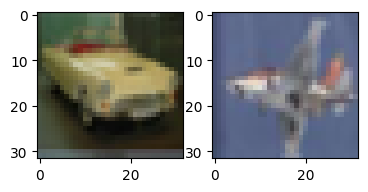

tensor([[[206, 244,  25,  ...,  24, 215,   3],
         [ 25, 216,   3,  ...,  11,  30, 220],
         [  3,  32, 219,  ..., 212, 246,  23],
         ...,
         [241, 233, 237,  ..., 221,   0,  30],
         [211, 255,  35,  ...,  16, 228,   9],
         [ 23, 233,   9,  ..., 253, 242, 227]],

        [[253, 242, 249,  ..., 211, 246,  22],
         [219,   6,  54,  ...,  23, 246,  22],
         [ 40, 253,  27,  ...,  37,  29,  10],
         ...,
         [244, 221, 195,  ...,  60,  24,  71],
         [ 93,  68,  75,  ...,  63,  99, 110],
         [ 62, 103, 135,  ...,  74, 243, 254]],

        [[  4, 215, 227,  ..., 123, 110, 108],
         [152, 139,  95,  ...,  58,  93, 108],
         [ 50,  87, 132,  ..., 114, 248,  34],
         ...,
         [218, 252, 252,  ...,   3, 228,   8],
         [  3, 227,   6,  ...,   9,   2, 229],
         [  9,   3, 230,  ..., 222, 255,   3]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


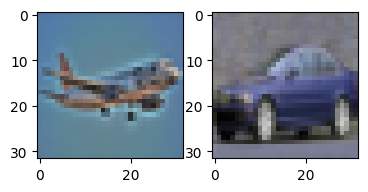

tensor([[[113, 128, 157,  ..., 158, 113, 128],
         [159, 113, 128,  ..., 127, 157, 113],
         [128, 159, 111,  ..., 112, 129, 159],
         ...,
         [215, 244, 193,  ..., 109, 127, 157],
         [115, 132, 162,  ...,  77,  30,  50],
         [ 80,  40,  61,  ...,  79, 109,  57]],

        [[ 78, 107,  50,  ..., 109, 128, 158],
         [116, 133, 163,  ..., 109,  60,  81],
         [110,  63,  84,  ...,  97, 127,  77],
         ...,
         [ 57,  14,  14,  ..., 216, 243, 158],
         [220,  11, 248,  ..., 113, 135, 169],
         [118, 137, 167,  ...,  86, 246,  15]],

        [[ 45,  24,  23,  ..., 166, 211, 174],
         [241,  32, 206,  ..., 113, 136, 167],
         [119, 138, 168,  ...,  93,  12,  34],
         ...,
         [ 46,  65,  94,  ...,  83,  28,  48],
         [ 78,  26,  47,  ...,  54,  85,  38],
         [ 59,  89,  41,  ...,  56,  77, 107]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


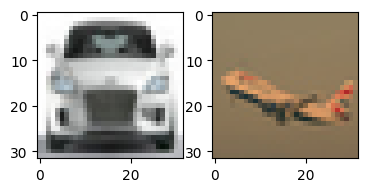

tensor([[[136, 101,  77,  ..., 215,  14, 228],
         [193,  17, 232,  ...,  88,  47, 106],
         [ 63,  25,  69,  ..., 230, 210, 186],
         ...,
         [187, 164, 191,  ..., 233, 229, 218],
         [ 68,  29, 250,  ..., 158,  51,  27],
         [240, 248, 224,  ..., 180, 152, 185]],

        [[181, 154, 182,  ..., 197, 194, 183],
         [244, 204, 170,  ..., 184,  35,   0],
         [212,  39,   3,  ...,  25, 251,  36],
         ...,
         [ 18,  94,  60,  ...,  68,  54,  63],
         [ 54,  37,  43,  ...,  34,  25,   1],
         [ 93,  63,  30,  ...,   6,  81,  43]],

        [[  0,  75,  40,  ...,  28,   6,  31],
         [ 24,   3,  22,  ...,  29,  21, 253],
         [123,  92,  58,  ..., 255,  70,  37],
         ...,
         [ 44,  26,   2,  ..., 162, 192, 181],
         [162, 186, 179,  ..., 169, 152, 179],
         [167, 150, 176,  ..., 224, 212, 196]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


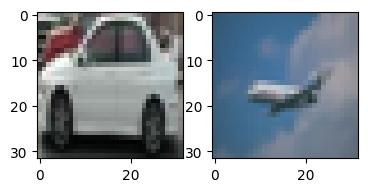

tensor([[[ 11,  64, 125,  ..., 150,  53,  95],
         [156,  44,  87,  ...,  93, 149,  33],
         [ 77, 139,  34,  ..., 230,  32, 101],
         ...,
         [ 40,  81,   7,  ...,   9,  61, 132],
         [231,  25, 103,  ..., 182, 224,  25],
         [140, 164, 217,  ..., 103, 125, 245]],

        [[ 35,  69,  34,  ...,  11,  62, 134],
         [239,  33, 111,  ..., 182, 254,  61],
         [159, 184, 239,  ..., 103, 130,  35],
         ...,
         [147, 104, 121,  ..., 228,  95, 150],
         [199,  62, 144,  ...,   7,  49, 101],
         [103, 130, 178,  ..., 151,  81, 100]],

        [[142, 127, 148,  ..., 207, 102, 148],
         [203,  94, 145,  ...,   6,  49, 100],
         [109, 134, 185,  ...,  94,  42,  62],
         ...,
         [ 61,  96, 141,  ..., 145,  59, 101],
         [145,  60, 102,  ..., 116, 176, 113],
         [149, 200,  74,  ..., 249,  41,  89]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


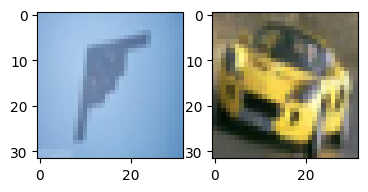

tensor([[[ 93, 101, 116,  ..., 104,  66,  76],
         [101,  67,  78,  ...,  48,  71,  38],
         [ 47,  72,  38,  ..., 106, 110, 119],
         ...,
         [ 58,  82,  52,  ..., 138, 141, 151],
         [186, 191, 211,  ...,  67,  34,  44],
         [ 71,  33,  42,  ...,  53,  80,  51]],

        [[ 59,  83,  51,  ..., 145, 146, 156],
         [199, 204, 223,  ...,  68,  34,  44],
         [ 70,  33,  42,  ...,  49,  75,  43],
         ...,
         [192, 223, 224,  ..., 241, 248, 178],
         [180, 189, 177,  ...,  40,  44,  48],
         [227, 233, 254,  ..., 220, 191, 190]],

        [[195, 172, 173,  ...,  80,  88,  67],
         [ 69,  79,  91,  ...,   1,   3,  11],
         [241, 246,  11,  ...,   4, 240, 240],
         ...,
         [ 43,  37,  96,  ..., 105,  44,  39],
         [101,  37,  28,  ..., 250,  73, 252],
         [243,  64, 249,  ...,  25,  18,  91]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


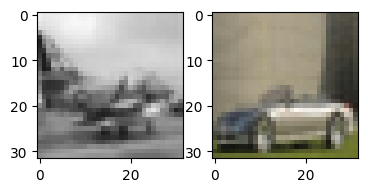

tensor([[[ 37, 118, 167,  ...,  95, 230,  57],
         [ 99, 230,  57,  ...,  54,  99, 241],
         [ 84, 134,  56,  ..., 247,  87, 145],
         ...,
         [129, 174,  76,  ...,  12, 109, 165],
         [255,  80, 121,  ..., 171,  51, 125],
         [178,  48, 125,  ...,  92, 128,  74]],

        [[133, 172,  99,  ...,  17, 113, 168],
         [236,  62, 106,  ..., 102, 251,  70],
         [104, 248,  68,  ..., 129, 161, 104],
         ...,
         [ 33,   5, 241,  ..., 218, 222, 243],
         [  3,  10, 246,  ..., 237,  54,  98],
         [ 19,  93, 138,  ..., 121,  64,  90]],

        [[105,  72,  75,  ...,  18,  33, 234],
         [ 10,  26, 218,  ..., 236,  52,  96],
         [ 19,  92, 136,  ..., 144,  70, 114],
         ...,
         [ 40, 101, 136,  ..., 138,  43, 104],
         [140,  46, 107,  ..., 159, 188,  89],
         [144, 175,  81,  ...,  88, 151, 148]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


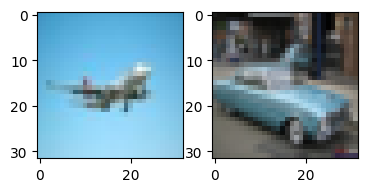

tensor([[[124, 124, 146,  ..., 104,  77,  86],
         [104,  77,  85,  ...,  92, 110,  90],
         [ 97, 115,  95,  ..., 152, 152, 173],
         ...,
         [  2,  23, 248,  ..., 114, 120, 139],
         [131, 139, 161,  ...,   5, 228, 235],
         [250, 186, 193,  ...,  51,  73,  43]],

        [[ 38,  58,   7,  ..., 143, 147, 164],
         [112, 119, 145,  ..., 227, 201, 208],
         [222, 185, 189,  ...,  13,  38,   1],
         ...,
         [ 33, 171, 155,  ..., 212, 214, 236],
         [235, 236, 251,  ..., 158, 164, 178],
         [ 92,  96, 121,  ...,  96, 100,  87]],

        [[ 91, 239, 226,  ..., 248, 252, 241],
         [239, 244,  57,  ..., 171, 176, 188],
         [124, 127, 150,  ..., 145, 113, 103],
         ...,
         [137, 144, 163,  ..., 171, 147, 154],
         [171, 147, 154,  ..., 158, 176, 151],
         [158, 176, 151,  ..., 154, 161, 179]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


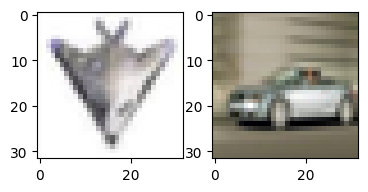

tensor([[[235, 255,   2,  ...,   4, 237,   2],
         [  4, 238,   2,  ...,   5,   5, 242],
         [  6,   4, 242,  ..., 249,  13,   9],
         ...,
         [ 39,  36,  27,  ...,  31,  43,  40],
         [ 23,  39,  36,  ...,  41,   2,  25],
         [ 32, 247,  16,  ...,  48,  46,  28]],

        [[ 47,  44,  29,  ...,  36,  46,  44],
         [ 31,  44,  41,  ...,  15,  15,  44],
         [ 60,  51,  82,  ..., 104, 105,  67],
         ...,
         [ 18, 156, 179,  ..., 219, 196, 198],
         [193, 177, 183,  ...,  72,  88,  90],
         [ 69,  77,  77,  ..., 102,  33,  47]],

        [[ 72, 246,   3,  ..., 241, 230, 221],
         [226, 221, 201,  ...,  73,  91,  91],
         [ 71,  83,  82,  ..., 133,  75,  91],
         ...,
         [ 83, 116, 111,  ..., 154, 101, 137],
         [157,  95, 129,  ..., 134, 165,  80],
         [116, 146,  76,  ...,  79, 110, 106]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


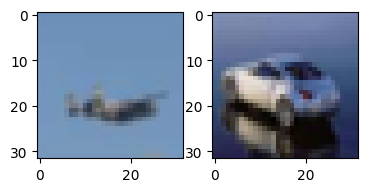

tensor([[[209, 197, 228,  ...,  14, 254, 237],
         [ 15, 255, 240,  ..., 223,   0, 232],
         [220, 253, 230,  ..., 185, 174, 208],
         ...,
         [214, 248, 222,  ..., 220, 206, 238],
         [192, 176, 204,  ...,  25,  15, 248],
         [ 26,  10, 245,  ..., 202, 237, 205]],

        [[193, 228, 200,  ..., 196, 184, 214],
         [222, 202, 234,  ...,  10,   4, 244],
         [  3,  24,  13,  ...,   3,  38, 249],
         ...,
         [ 88, 148, 153,  ...,  23,  84,  30],
         [ 18,  80,  26,  ..., 176, 165, 203],
         [211, 210, 210,  ...,  11,  35,  54]],

        [[ 58,  46,  52,  ...,   2,  51,   9],
         [  2,  51,   9,  ..., 155, 147, 183],
         [154, 161, 145,  ..., 179, 251,   5],
         ...,
         [147, 149, 135,  ..., 133, 143, 147],
         [133, 144, 148,  ..., 142, 128, 139],
         [143, 129, 142,  ..., 141, 145, 131]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


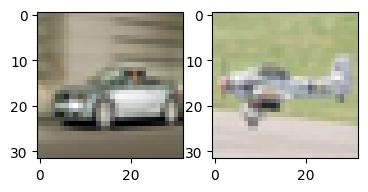

tensor([[[254,  13,  43,  ..., 184, 108, 137],
         [185, 122, 149,  ..., 149, 202, 118],
         [148, 202, 111,  ..., 111, 141, 200],
         ...,
         [167, 211, 130,  ..., 130, 145, 203],
         [213, 219,  17,  ...,  19, 197, 207],
         [225, 205, 188,  ..., 215, 236, 161]],

        [[187, 224, 118,  ..., 148, 150, 218],
         [ 26,  35,  87,  ...,  15, 163, 147],
         [182, 241, 185,  ..., 196, 225, 194],
         ...,
         [ 24, 205, 216,  ...,  32,  64,  16],
         [ 30,  61,  46,  ..., 231, 224,   5],
         [254,  11,  18,  ...,  82, 238,   1]],

        [[ 27, 187, 196,  ...,   7,  42, 218],
         [228,  10, 211,  ..., 230, 225,   5],
         [  2,  12,  16,  ...,  80, 248,   7],
         ...,
         [240, 247, 247,  ..., 232, 213, 201],
         [217, 194, 186,  ..., 186, 206, 202],
         [187, 207, 209,  ..., 239, 228, 246]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


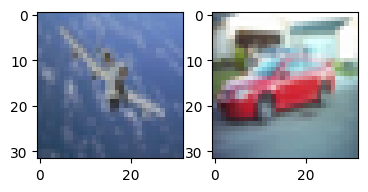

tensor([[[253,  37, 111,  ...,  73, 217,  10],
         [ 72, 217,  10,  ...,  27,  89, 244],
         [ 32,  94, 250,  ...,  99, 120, 164],
         ...,
         [ 48, 110,   8,  ...,  93, 106, 134],
         [  6,  56, 130,  ...,  67, 213,   6],
         [ 69, 213,   7,  ...,  64, 126,  31]],

        [[ 71, 129,  38,  ..., 119, 129, 158],
         [245,  35, 113,  ...,  61, 211,   5],
         [ 63, 212,   5,  ...,   7,  69, 228],
         ...,
         [245, 169, 163,  ..., 106, 108, 127],
         [130, 130, 189,  ...,  59, 103, 156],
         [228,  14,  87,  ..., 242, 237, 233]],

        [[242, 223, 214,  ..., 164, 176, 159],
         [168, 176, 194,  ...,  71, 114, 166],
         [  4,  47, 117,  ...,  27, 237, 230],
         ...,
         [ 20,  66, 128,  ..., 136,  37,  82],
         [136,  38,  83,  ...,  90, 144,  48],
         [ 91, 145,  49,  ...,  61, 101, 155]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


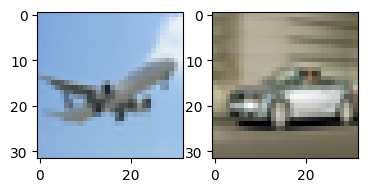

tensor([[[126,  87,  72,  ...,  48,  98,  50],
         [ 45,  82,  37,  ..., 111, 101, 118],
         [102, 123,  82,  ..., 151, 124, 107],
         ...,
         [184, 243, 113,  ..., 150, 122, 111],
         [131, 101,  88,  ...,  38, 164, 218],
         [ 77, 114, 171,  ..., 219,  33, 227]],

        [[227,  18,  62,  ..., 142, 111, 103],
         [147, 118, 102,  ...,  63, 180, 247],
         [ 96, 156, 217,  ..., 201, 219, 208],
         ...,
         [222, 243, 184,  ...,  17,  45,  16],
         [252,  33, 227,  ..., 139, 119, 106],
         [104,  75,  50,  ...,   6,  36, 225]],

        [[248,  59, 232,  ...,  10, 243, 219],
         [255,  14, 223,  ..., 135, 115, 104],
         [ 41,  29,  25,  ...,  18,  55, 239],
         ...,
         [ 94,  51,  15,  ...,  36, 102,  70],
         [ 40,  98,  66,  ...,  68,  40, 101],
         [ 72,  43,  98,  ...,  88,  71,  55]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


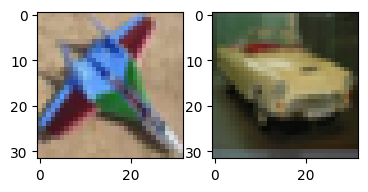

tensor([[[197, 193, 194,  ..., 208, 209, 205],
         [203, 215, 205,  ..., 195, 201, 196],
         [198, 201, 195,  ...,  18, 225, 196],
         ...,
         [ 43,  27,  43,  ..., 241, 200, 169],
         [211, 184, 173,  ...,  39, 123,  94],
         [ 71, 138, 110,  ..., 236, 216, 242]],

        [[220, 194, 226,  ..., 201, 174, 157],
         [226, 199, 182,  ...,  69, 149, 121],
         [ 96, 133,  87,  ..., 240, 210,   6],
         ...,
         [176, 237, 213,  ..., 172, 153, 204],
         [184, 171, 177,  ..., 248, 234, 226],
         [166, 156, 138,  ..., 134, 246, 223]],

        [[200, 208, 179,  ..., 235, 228,  13],
         [  6,   1,   5,  ..., 235, 224, 215],
         [199, 181, 157,  ..., 188,  23, 250],
         ...,
         [109,  97, 147,  ..., 217, 170, 157],
         [199, 145, 137,  ..., 154, 193, 161],
         [154, 193, 161,  ..., 158, 148, 183]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


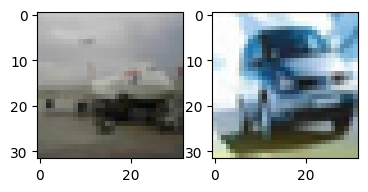

tensor([[[147, 156, 124,  ..., 137, 161, 180],
         [139, 180, 197,  ..., 133, 104, 139],
         [142, 113, 140,  ..., 111, 112,  85],
         ...,
         [206, 158, 175,  ..., 116, 119,  99],
         [127, 133, 105,  ..., 185,  12,   3],
         [195,  24,  17,  ...,   6, 196,   8]],

        [[  0, 192,   2,  ..., 114, 120,  97],
         [126, 133, 109,  ..., 247,  35,  29],
         [235,  37,  33,  ...,  40, 235,  41],
         ...,
         [148, 184, 184,  ..., 174, 148, 172],
         [170, 145, 171,  ..., 116, 114, 100],
         [156, 167, 148,  ..., 111, 138, 141]],

        [[120, 148, 147,  ..., 180, 150, 198],
         [196, 174, 199,  ..., 121, 119, 105],
         [158, 169, 149,  ..., 105, 160, 160],
         ...,
         [208, 231,   9,  ..., 246, 202, 216],
         [242, 196, 211,  ..., 213, 236, 203],
         [211, 235, 201,  ..., 197, 208, 231]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


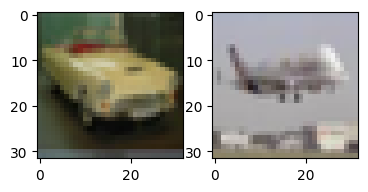

tensor([[[249,  55, 141,  ..., 154,  15,  69],
         [161,   3,  59,  ...,  75, 159,   5],
         [ 60, 149,  11,  ..., 242,  46, 133],
         ...,
         [ 18,  90, 234,  ...,  16,  71, 160],
         [203,  10, 113,  ..., 179, 248,  51],
         [167,   4,  56,  ...,  78, 130, 217]],

        [[ 13,  78,   7,  ...,  18,  72, 163],
         [210,  17, 121,  ..., 179, 237,  58],
         [186,   5,  65,  ...,  80, 134,   7],
         ...,
         [182, 100, 109,  ..., 213, 110, 124],
         [184,  77, 121,  ...,  21,  66, 137],
         [ 83, 121, 195,  ..., 205, 105, 145]],

        [[216, 109, 149,  ..., 191, 115, 124],
         [189, 110, 125,  ...,  22,  67, 135],
         [ 90, 127, 202,  ..., 155,  64, 104],
         ...,
         [ 37,  85, 157,  ..., 161,  43,  90],
         [162,  43,  92,  ..., 111, 198, 105],
         [146, 223,  68,  ...,  17,  66, 131]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


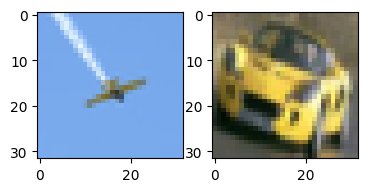

tensor([[[179, 139, 206,  ..., 203, 164, 137],
         [196, 169, 132,  ..., 143, 208, 174],
         [140, 209, 174,  ..., 185, 155, 217],
         ...,
         [167, 220, 140,  ...,  90, 133, 207],
         [186, 210,  18,  ...,  20,  78, 130],
         [219,  77, 127,  ..., 210,   6, 192]],

        [[186, 215, 182,  ...,  86, 135, 212],
         [ 28,  38,  78,  ...,  24,  73, 127],
         [221,  81, 129,  ..., 221,  30, 227],
         ...,
         [209, 191, 186,  ...,  80, 164,  17],
         [ 65, 167,  30,  ..., 146, 199,  32],
         [250, 218, 235,  ..., 249, 175, 149]],

        [[172, 180, 162,  ..., 124, 206,  45],
         [ 95, 190,  36,  ..., 101, 159, 236],
         [ 11,   4,  25,  ..., 221, 214, 168],
         ...,
         [191, 201, 199,  ..., 139, 223, 195],
         [187, 180, 211,  ..., 181, 245, 123],
         [183, 244, 120,  ..., 125, 186, 242]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


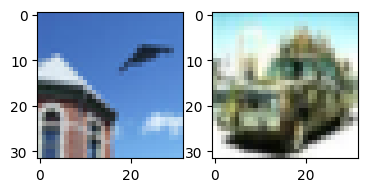

tensor([[[ 67,  13, 141,  ..., 107,  42, 243],
         [110,  40, 241,  ..., 206,  86,  21],
         [233, 111,  44,  ...,  30, 229,  96],
         ...,
         [152,  60, 202,  ..., 101,  52, 163],
         [ 31, 248, 109,  ..., 169,   9,  11],
         [164, 206, 208,  ..., 225, 137, 160]],

        [[148,  51, 205,  ...,  84,  36, 146],
         [  1, 222,  87,  ..., 172, 245, 245],
         [136, 196, 198,  ..., 242, 175, 171],
         ...,
         [ 43, 163, 159,  ..., 182, 182,  56],
         [ 57,  37, 188,  ..., 214, 205, 107],
         [  6,   0, 154,  ..., 100, 194, 188]],

        [[100, 206, 206,  ..., 128, 124,  48],
         [ 45,  32, 227,  ..., 205, 194,  98],
         [219, 212, 113,  ..., 143, 235, 229],
         ...,
         [216, 202, 112,  ..., 101, 197, 188],
         [ 99, 197, 187,  ..., 175,  83, 186],
         [174,  83, 195,  ..., 211, 199,  99]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


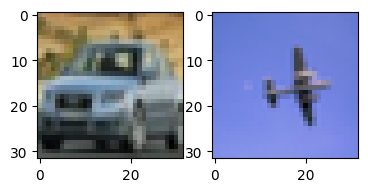

tensor([[[137,  75,  21,  ...,  18, 134,  71],
         [ 17, 134,  72,  ...,  70,  10, 133],
         [ 70,  14, 128,  ..., 140,  81,  30],
         ...,
         [109,  90, 172,  ...,  57,   0, 218],
         [115,  59,  20,  ..., 159,   7, 202],
         [166,  20, 220,  ..., 153, 107, 227]],

        [[140, 108, 190,  ...,  24, 222, 187],
         [113,  55,  18,  ..., 122, 211, 149],
         [116, 206, 140,  ...,  19, 222, 103],
         ...,
         [ 74, 128,  77,  ..., 166, 145, 221],
         [168, 146, 156,  ..., 225, 183, 156],
         [146, 102,  74,  ...,  60, 124,  74]],

        [[ 54, 124,  76,  ..., 161, 145, 211],
         [162, 142, 158,  ...,   2, 216, 190],
         [161, 125,  96,  ...,  50, 116,  72],
         ...,
         [153, 146, 189,  ..., 176, 143, 139],
         [172, 142, 138,  ..., 140, 176, 149],
         [141, 178, 152,  ..., 150, 149, 203]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


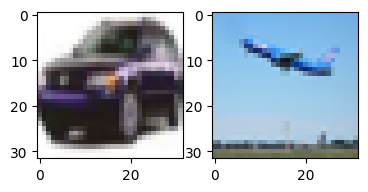

tensor([[[152, 186, 232,  ..., 240, 159, 193],
         [236, 166, 194,  ..., 192, 242, 153],
         [194, 238, 153,  ...,   2, 248,   1],
         ...,
         [ 78,  96,  46,  ...,   9, 252, 253],
         [197, 208, 240,  ...,  97, 101, 109],
         [130, 118, 127,  ...,   6,  25, 240]],

        [[251,   7, 228,  ..., 220, 225, 242],
         [201, 212, 240,  ..., 131, 129, 138],
         [158, 121, 118,  ...,   4,  17, 245],
         ...,
         [200, 178, 171,  ..., 173, 165, 206],
         [194, 196, 211,  ...,  80, 102, 138],
         [197, 221,   0,  ..., 150, 201, 197]],

        [[198, 142, 131,  ...,  26,  39,  80],
         [ 91, 116, 119,  ...,  55,  80, 117],
         [237,   0,  30,  ...,  64,  65,  69],
         ...,
         [180, 208,  48,  ..., 114, 237,   4],
         [ 98, 216, 244,  ...,  16, 103, 241],
         [ 16, 102, 242,  ..., 248,  15,  96]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


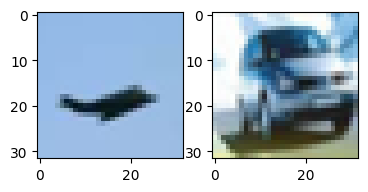

tensor([[[245,  49, 138,  ..., 175,  10,  67],
         [175,  12,  68,  ...,  99, 198,  28],
         [ 72, 175,   3,  ...,  22,  82, 195],
         ...,
         [155, 205,  87,  ..., 204, 253, 123],
         [ 14,  57, 168,  ..., 118,  93, 102],
         [126, 143, 153,  ...,  99, 148, 153]],

        [[160, 198,  81,  ..., 222,  14, 141],
         [ 44,  82, 189,  ..., 103,  96, 103],
         [149, 157, 166,  ..., 112, 142, 151],
         ...,
         [223, 125, 133,  ..., 247,  58,  69],
         [ 81, 140,  92,  ...,  99,  99, 171],
         [ 32,  44, 114,  ..., 163,  94, 106]],

        [[164,  82,  87,  ...,  12,  75,  68],
         [ 84, 143,  51,  ..., 103, 111, 182],
         [ 76,  88, 155,  ..., 120,  52,  65],
         ...,
         [ 62,  85, 144,  ..., 159,  79,  97],
         [160,  79,  98,  ..., 114, 180,  97],
         [116, 182,  91,  ...,  83, 101, 171]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


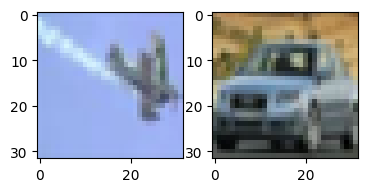

tensor([[[160, 159, 178,  ..., 179, 170, 167],
         [183, 170, 169,  ..., 147, 166, 148],
         [151, 171, 142,  ..., 243, 244,  19],
         ...,
         [ 65,  61,  76,  ...,  57,  56,  68],
         [152, 151, 170,  ..., 166, 130, 129],
         [139, 130, 130,  ...,  76,  72,  81]],

        [[ 83,  83,  85,  ...,  71,  73,  81],
         [157, 156, 173,  ..., 107,  78,  77],
         [ 81,  69,  69,  ...,  45,  44, 110],
         ...,
         [133, 122, 124,  ..., 192, 194, 202],
         [202, 208, 203,  ..., 107, 114, 124],
         [186, 185, 191,  ..., 192, 174, 173]],

        [[178, 180, 181,  ..., 195, 199, 202],
         [202, 207, 187,  ..., 111, 119, 130],
         [185, 184, 190,  ..., 162, 118, 117],
         ...,
         [167, 165, 178,  ..., 168, 149, 157],
         [167, 149, 157,  ..., 143, 154, 135],
         [143, 154, 134,  ..., 131, 139, 150]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


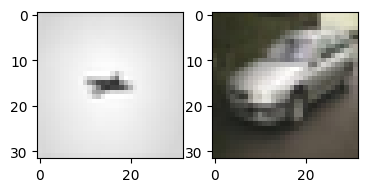

tensor([[[216, 195, 113,  ..., 111, 141, 144],
         [107, 196, 190,  ..., 221, 190, 247],
         [230, 179, 206,  ..., 172, 135,  52],
         ...,
         [241, 160, 207,  ..., 195, 167,  73],
         [197, 178,  89,  ...,  75, 116, 101],
         [ 38, 116,  98,  ...,   7, 160,  24]],

        [[255, 154,  10,  ..., 193, 169,  71],
         [194, 175,  87,  ..., 117, 127, 110],
         [ 68, 121, 104,  ...,  11, 169,  26],
         ...,
         [210,  85,  67,  ..., 211, 149, 227],
         [207, 139, 237,  ..., 199, 172,  85],
         [220, 208, 125,  ...,  94, 228, 209]],

        [[139,  35,  13,  ..., 222, 151,   2],
         [237, 167,  11,  ..., 203, 176,  93],
         [222, 210, 126,  ...,  84, 238, 214],
         ...,
         [  7,   1, 197,  ..., 178,   4, 245],
         [178, 253, 241,  ..., 237, 171,   3],
         [240, 181,  13,  ...,  59,  51,  61]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


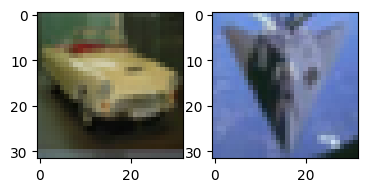

tensor([[[190, 130,  54,  ...,  77, 159, 136],
         [ 84, 153, 127,  ...,  88,  55, 146],
         [ 78,  41, 148,  ..., 177, 119,  53],
         ...,
         [182, 155, 112,  ..., 230, 215, 208],
         [196, 194, 144,  ..., 126, 189, 147],
         [ 92, 118,  94,  ..., 208, 184, 212]],

        [[202, 183,  92,  ..., 203, 193, 194],
         [243, 217, 179,  ..., 123, 185, 146],
         [108, 121, 100,  ..., 198, 164, 207],
         ...,
         [181, 198, 171,  ..., 109, 100,  66],
         [ 49,  38, 193,  ..., 199, 159, 141],
         [229, 173, 139,  ..., 120, 224, 196]],

        [[175, 200, 176,  ...,  19,  10, 233],
         [213, 198, 160,  ..., 183, 146, 125],
         [222, 177, 138,  ..., 134, 207, 185],
         ...,
         [213, 186, 146,  ..., 184, 250, 227],
         [208, 249, 226,  ..., 180, 181, 193],
         [173, 171, 174,  ..., 239, 210, 200]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


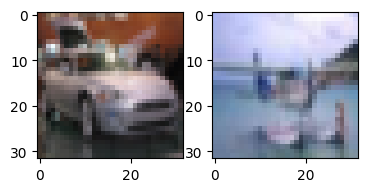

tensor([[[ 66,  81,  65,  ...,  77,  78, 103],
         [ 78,  97, 120,  ...,  57,  42,  60],
         [ 66,  51,  60,  ...,  30,  33,  24],
         ...,
         [194, 151,  95,  ...,  38,  42,  27],
         [ 50,  57,  33,  ..., 116, 199, 191],
         [134, 226, 217,  ...,  42, 238,  30]],

        [[ 10, 210, 254,  ...,  36,  43,  24],
         [ 48,  56,  35,  ...,  22,  49,  43],
         [ 10,  71,  64,  ...,  65,  15,  87],
         ...,
         [  4,  37,  34,  ...,  39,  23,  36],
         [ 34,  22,  40,  ...,  36,  32,  19],
         [132, 139, 126,  ..., 137, 157, 157]],

        [[143, 162, 158,  ...,  43,  22,  62],
         [ 58,  47,  47,  ...,  40,  36,  22],
         [ 75,  84,  65,  ...,  21,  76,  74],
         ...,
         [ 93, 108, 113,  ...,  95,  88,  94],
         [ 91,  86,  92,  ...,  87,  86,  85],
         [ 86,  86,  85,  ...,  77,  82,  84]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


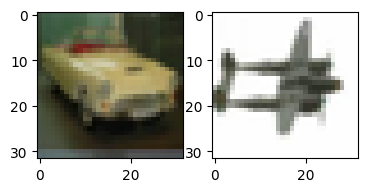

tensor([[[161, 164, 178,  ...,  59,  70,  58],
         [ 58,  70,  58,  ...,  59,  59,  71],
         [ 59,  59,  71,  ...,  72,  60,  60],
         ...,
         [ 13,  25,  31,  ...,  52,  47,  43],
         [196, 198, 181,  ..., 198,  23,   7],
         [  4,  33,  40,  ..., 240,   1,  13]],

        [[254,  13,  44,  ...,  18,  28,  18],
         [141, 138, 121,  ..., 207,  13,  28],
         [ 31, 246,  40,  ...,   7,  17, 232],
         ...,
         [170, 196, 195,  ..., 162, 168, 185],
         [173, 180, 190,  ..., 185, 200, 209],
         [146, 139, 163,  ..., 111, 166, 156]],

        [[170, 211, 211,  ..., 184, 178, 193],
         [189, 185, 200,  ..., 190, 210, 227],
         [138, 134, 161,  ..., 109, 154, 144],
         ...,
         [154, 150, 176,  ..., 217, 189, 204],
         [222, 191, 207,  ..., 213, 228, 195],
         [214, 229, 192,  ..., 159, 173, 188]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


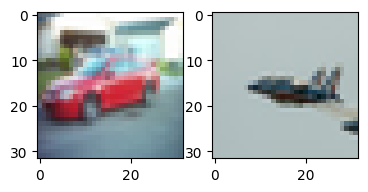

tensor([[[219,  10, 115,  ..., 105, 213,   0],
         [112, 203, 247,  ...,   2, 102, 201],
         [244,  91, 207,  ..., 187, 235,  81],
         ...,
         [216,  44, 175,  ..., 225,  12, 116],
         [168, 216,  88,  ..., 181, 252,  43],
         [165, 228,  20,  ...,  40, 104, 208]],

        [[244,  53, 238,  ..., 228,  13, 122],
         [175, 225,  92,  ..., 159,  19,  75],
         [194,   6,  59,  ...,   9,  81, 222],
         ...,
         [222, 105, 123,  ..., 138, 247,  79],
         [113, 254,  62,  ..., 236,  12, 100],
         [ 55,  81, 178,  ..., 213, 160, 178]],

        [[224, 142, 156,  ..., 127, 249,  87],
         [111, 236,  74,  ..., 236,  13,  97],
         [ 62,  86, 184,  ..., 129,  98, 119],
         ...,
         [ 10,  44, 141,  ..., 132,   4,  38],
         [132,   4,  38,  ...,  52, 154,  58],
         [ 87, 182,  23,  ..., 235,  14,  97]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


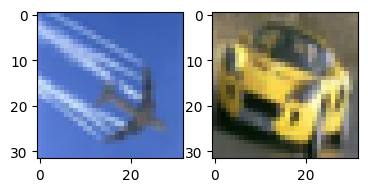

tensor([[[198, 109, 180,  ...,  93, 127,  75],
         [104, 133,  89,  ..., 158, 185, 136],
         [ 90, 131, 134,  ..., 197, 107, 177],
         ...,
         [103, 105,  55,  ..., 173, 141, 169],
         [133,  94, 120,  ...,  30,  84,  66],
         [ 35,  79,  66,  ...,  36,  13,  29]],

        [[ 23,  19, 237,  ..., 187, 177, 188],
         [120,  98, 110,  ...,  34,  81,  66],
         [ 25,  68,  57,  ..., 201, 177, 238],
         ...,
         [188,   6,   6,  ...,  12, 253, 234],
         [224, 208, 241,  ..., 125, 107, 110],
         [ 43,   8,   5,  ..., 239,  23,  23]],

        [[209, 238, 242,  ...,  26,   4, 214],
         [202, 180, 199,  ..., 124,  97, 106],
         [ 72,  17,  27,  ...,  19,  15,  16],
         ...,
         [ 79, 243,  37,  ..., 255,  35,  12],
         [ 14,  41,  25,  ...,  90,  71,  99],
         [ 74,  61,  97,  ...,  99,   3,  48]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


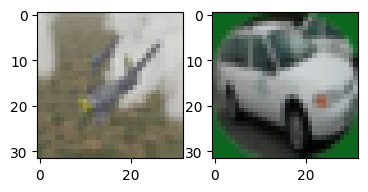

tensor([[[ 73, 102, 142,  ..., 173,  92, 125],
         [171,  93, 126,  ..., 157, 190, 100],
         [127, 162,  78,  ...,  96, 135, 181],
         ...,
         [154, 155, 126,  ..., 207, 239,  40],
         [ 51,  69, 118,  ...,  78,  88,  66],
         [ 77, 133, 112,  ...,  88, 105, 161]],

        [[155, 159, 119,  ..., 221, 252,  54],
         [ 78,  92, 136,  ...,  70, 105,  83],
         [102, 140, 119,  ...,  71,  87, 141],
         ...,
         [196, 171, 158,  ...,  30,  26, 147],
         [136, 131, 193,  ..., 148, 137, 143],
         [129, 116, 124,  ..., 131, 130, 119]],

        [[115,  98,  81,  ...,  47,  41, 140],
         [133, 130, 155,  ..., 141, 134, 137],
         [170, 158, 162,  ...,  73,  72,  61],
         ...,
         [  6,   4,   6,  ...,  29,  35,  29],
         [ 32,  36,  31,  ...,  20,  23,  23],
         [ 21,  24,  17,  ...,  29,  26,  33]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


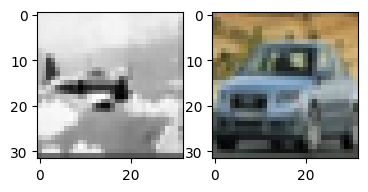

tensor([[[121, 183, 213,  ..., 170, 102, 136],
         [165, 107, 146,  ..., 148, 196,  72],
         [154, 205,  64,  ...,  78, 137, 176],
         ...,
         [ 74,  86, 140,  ..., 146, 150, 167],
         [107, 106, 132,  ..., 188, 105, 138],
         [173, 131, 147,  ...,  54,  60,  73]],

        [[ 78,  82, 163,  ..., 155, 155, 170],
         [ 92, 108, 134,  ..., 167, 102, 128],
         [157, 127, 136,  ...,  51,  68,  79],
         ...,
         [233, 214, 201,  ..., 162, 161,  25],
         [ 28,  30,  75,  ..., 104, 111, 125],
         [130, 143, 160,  ..., 162,  10,   2]],

        [[  4, 220, 206,  ..., 234, 228,  77],
         [ 79,  81, 101,  ..., 128, 132, 148],
         [137, 146, 169,  ...,  29, 201, 196],
         ...,
         [147, 156, 184,  ..., 150, 113, 119],
         [135, 114, 119,  ..., 165, 183, 163],
         [164, 184, 165,  ..., 105, 124, 134]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


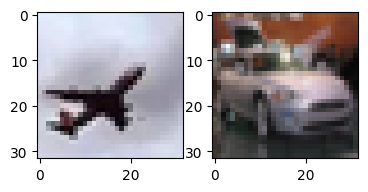

tensor([[[103,  96, 116,  ...,  74, 120, 113],
         [133,  82,  76,  ...,  85, 104, 107],
         [106, 116,  80,  ..., 118, 116, 130],
         ...,
         [ 86, 123,  38,  ...,  40,  41,  61],
         [ 50,  52,  65,  ..., 244, 219, 195],
         [191, 217, 199,  ...,  38,  77,  15]],

        [[ 42,  86, 254,  ...,  22,  21,  37],
         [ 26,  26,  28,  ...,  19, 212, 204],
         [202, 166, 153,  ..., 243,  26, 234],
         ...,
         [233,  31,  37,  ..., 184, 228, 169],
         [175, 215, 163,  ..., 155, 156, 189],
         [146, 144, 152,  ..., 228,  18,  26]],

        [[ 35,  56,  62,  ..., 183, 219, 168],
         [174, 207, 155,  ..., 161, 163, 192],
         [158, 161, 155,  ..., 223,  15,  21],
         ...,
         [  5,   8,  42,  ...,  28, 251,   4],
         [ 30, 249,   2,  ...,   6,  33, 253],
         [  6,  34, 253,  ...,  10,  14,  42]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


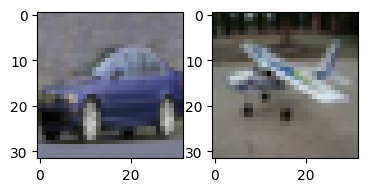

tensor([[[152, 125, 115,  ..., 126, 165, 139],
         [124, 141, 116,  ..., 110,  97, 172],
         [147, 132, 176,  ..., 143, 118,  97],
         ...,
         [129, 119, 157,  ...,  95,  69,  67],
         [ 64,  48,  53,  ..., 211, 225, 216],
         [224, 225, 215,  ..., 116, 105, 153]],

        [[118, 109, 149,  ...,  70,  50,  51],
         [ 69,  51,  56,  ..., 187, 197, 189],
         [197, 211, 201,  ..., 128, 120, 143],
         ...,
         [ 18,  20,  14,  ..., 243, 238, 254],
         [250, 241, 249,  ...,  37,  23,  27],
         [220, 205, 205,  ...,  55,  86,  71]],

        [[ 64,  38,  23,  ..., 235, 233, 252],
         [243, 239, 245,  ..., 238, 221, 219],
         [196, 182, 185,  ..., 199,  16, 248],
         ...,
         [ 64,  60,  64,  ...,  53,  43,  36],
         [ 49,  56,  49,  ...,  40,  38,  42],
         [ 34,  33,  54,  ...,  52,  40,  39]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


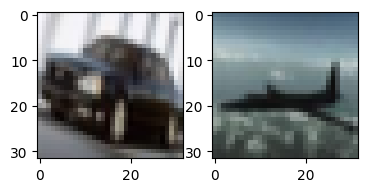

tensor([[[ 98, 113, 108,  ..., 127,  95, 130],
         [128, 115, 150,  ...,  68,  88,  63],
         [ 79,  98,  63,  ...,  33,  43,  70],
         ...,
         [249, 232, 214,  ...,  44,  68,  79],
         [ 51,  69,  71,  ..., 159, 199, 200],
         [174, 216, 217,  ...,  30, 244,  25]],

        [[ 18, 239,   2,  ...,  43,  71,  77],
         [ 48,  64,  69,  ..., 219, 214, 222],
         [208, 210, 217,  ...,  28, 251, 206],
         ...,
         [189, 134, 148,  ..., 120, 117, 104],
         [116, 117, 104,  ...,  37,  37,  62],
         [ 77,  92, 100,  ...,  74,  64,  79]],

        [[ 86,  76,  86,  ..., 128, 123, 125],
         [139, 145, 125,  ...,  40,  44,  66],
         [ 76,  96, 100,  ...,  71,  84,  96],
         ...,
         [107, 135, 162,  ..., 148,  99, 120],
         [147,  95, 116,  ..., 121, 148, 105],
         [123, 148, 107,  ..., 110, 131, 158]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


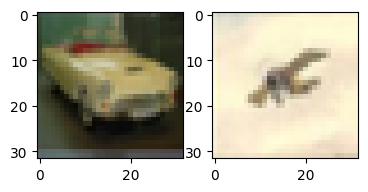

tensor([[[153, 142, 124,  ..., 138, 175, 165],
         [140, 176, 165,  ..., 159, 136, 166],
         [157, 132, 163,  ...,  90,  86,  77],
         ...,
         [160, 134, 165,  ...,  92,  85,  72],
         [252, 243, 222,  ..., 231,  22,   9],
         [236,  25,  12,  ..., 171, 144, 177]],

        [[166, 141, 181,  ...,  87,  82,  69],
         [242, 233, 213,  ..., 240,  23,   9],
         [238,  25,  12,  ..., 170, 144, 177],
         ...,
         [231, 234, 225,  ...,  26,  13,  43],
         [ 26,   7,  39,  ..., 143, 136, 133],
         [ 22,  73,  50,  ..., 227, 244, 238]],

        [[230,   2, 248,  ...,  78,  63,  96],
         [ 80,  61, 104,  ..., 133, 127, 119],
         [ 40,  71,  53,  ..., 219, 199, 192],
         ...,
         [214, 227, 180,  ..., 250,  49,  53],
         [254,  54,  62,  ...,  79,   4,  72],
         [ 81,   7,  74,  ..., 207, 215, 148]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


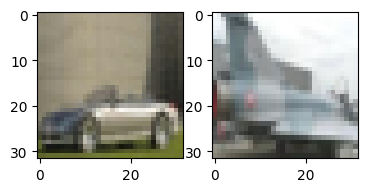

tensor([[[131,  76,  28,  ..., 238,  34, 248],
         [204,   0, 219,  ...,  87,  39, 145],
         [ 87,  38, 145,  ..., 250, 198, 151],
         ...,
         [200, 158, 230,  ..., 183, 130,  81],
         [192, 139,  86,  ..., 138, 239, 183],
         [140, 242, 195,  ..., 241, 199,  33]],

        [[243, 190,  23,  ..., 176, 127,  86],
         [204, 153,  90,  ..., 201,  60,   3],
         [212,  52,  12,  ...,  45,  24,  42],
         ...,
         [137,  52, 183,  ...,   6, 205,  66],
         [ 15, 212,  67,  ...,  28, 239, 191],
         [ 33, 242, 184,  ..., 208,  30, 240]],

        [[185,  16, 214,  ..., 211, 158,  30],
         [235, 180,  30,  ..., 206, 156, 107],
         [228, 174, 116,  ..., 131, 247, 191],
         ...,
         [ 95,  51, 255,  ..., 251,  98,  51],
         [  1, 103,  58,  ...,  74,  25, 112],
         [ 64,  20, 120,  ..., 119,  68,  21]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


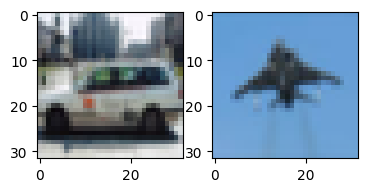

tensor([[[179, 171, 167,  ..., 188, 192, 192],
         [190, 194, 195,  ..., 170, 182, 169],
         [170, 179, 166,  ...,  93,  96, 123],
         ...,
         [ 26,  32,  25,  ...,  80,  97, 113],
         [143, 149, 155,  ..., 179, 182, 181],
         [186, 197, 198,  ...,  35,  36,  19]],

        [[ 21,  27,   7,  ...,  76,  96, 111],
         [133, 136, 143,  ..., 186, 193, 196],
         [197, 191, 195,  ...,  28,  30, 204],
         ...,
         [249, 154, 169,  ..., 195, 210, 182],
         [196, 212, 179,  ...,  40,  40,  74],
         [134, 134, 139,  ..., 147, 130, 145]],

        [[167, 152, 164,  ...,  15,  31, 252],
         [ 12,  29, 249,  ...,  50,  56,  84],
         [133, 139, 141,  ..., 163, 107, 121],
         ...,
         [111, 130,  93,  ..., 104, 121, 141],
         [109, 120, 144,  ..., 159, 108, 138],
         [164, 112, 143,  ..., 144, 167, 119]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


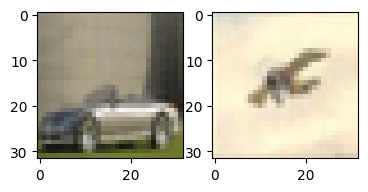

tensor([[[ 43,  23, 237,  ..., 214,  31,   6],
         [214,  29,   4,  ...,  95,  56, 130],
         [105,  65, 111,  ...,  72,  52,   3],
         ...,
         [ 19, 218,  44,  ...,  51,  29, 225],
         [ 48,  22, 224,  ..., 239,  80,  48],
         [246,  68,  38,  ...,  12, 204,  59]],

        [[ 28, 224,  55,  ...,  51,  22, 212],
         [ 52,  25, 234,  ..., 236,  60,  36],
         [236,  51,  26,  ...,  17, 220,  80],
         ...,
         [221, 238, 212,  ...,   4, 223,  43],
         [  5, 224,  84,  ..., 138, 100,  60],
         [ 23,   1, 214,  ..., 240,   0, 231]],

        [[181, 199, 176,  ..., 254, 216,  92],
         [ 50,   9, 162,  ..., 144, 106,  62],
         [ 41,  18, 233,  ..., 207, 199, 175],
         ...,
         [175, 171, 132,  ..., 129, 182, 168],
         [128, 183, 169,  ..., 171, 132, 185],
         [169, 131, 184,  ..., 176, 167, 129]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


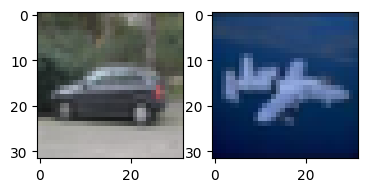

tensor([[[ 88, 157, 197,  ..., 169,  53, 106],
         [163,  56, 115,  ...,  78, 153, 240],
         [ 83, 162, 235,  ...,  65, 133, 168],
         ...,
         [209, 228,  34,  ...,  75, 104, 144],
         [ 15,  23,  45,  ..., 162,  36,  91],
         [147,  53,  93,  ..., 182, 177, 195]],

        [[207, 211,  69,  ...,  95, 117, 155],
         [227,   8,  41,  ..., 170, 105, 139],
         [166, 110, 130,  ..., 199, 209, 214],
         ...,
         [  0,   8,  32,  ..., 157, 153, 190],
         [223, 219, 247,  ..., 248,  22,  34],
         [  0,  48,  49,  ...,  50, 218, 249]],

        [[249,  11,  31,  ..., 209, 206, 228],
         [  2,   3,   3,  ...,  13,  37,  39],
         [252,  35,  43,  ...,  30, 237,   9],
         ...,
         [247,  18,  13,  ..., 234, 215, 225],
         [221, 213, 222,  ...,   6,   3, 255],
         [  9,   5,   5,  ..., 181, 213, 201]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


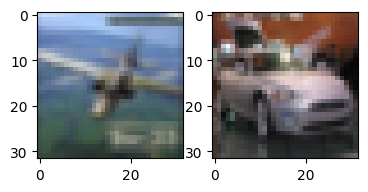

tensor([[[242, 182, 111,  ...,  84, 210, 154],
         [ 84, 205, 152,  ..., 116,  65, 186],
         [140,  89, 207,  ..., 179, 124,  62],
         ...,
         [ 50,  35,  93,  ...,   0, 207, 134],
         [180, 142,  80,  ..., 158,  23,  35],
         [ 18,  42,  63,  ..., 111,  82,  59]],

        [[ 45,  27,  99,  ..., 237, 191, 116],
         [152, 119,  60,  ..., 146, 145, 156],
         [129, 211, 230,  ..., 112,  89,  64],
         ...,
         [ 31, 116, 118,  ..., 250, 240, 148],
         [133, 120, 114,  ..., 169, 142, 100],
         [195, 179, 143,  ...,  92, 143, 142]],

        [[126, 236, 254,  ..., 204, 187, 161],
         [143, 122, 155,  ..., 163, 133,  94],
         [158, 138, 104,  ..., 158,   0,   8],
         ...,
         [237, 181, 129,  ..., 117, 203, 164],
         [116, 200, 159,  ..., 136,  92, 175],
         [137,  92, 185,  ..., 167, 137,  97]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


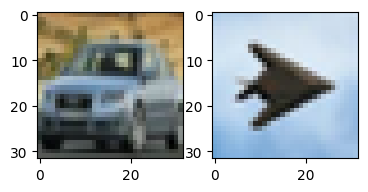

tensor([[[241, 229, 219,  ..., 218, 107, 148],
         [201,  99, 130,  ...,  97, 127,  82],
         [ 95, 133,  83,  ...,  94, 130, 178],
         ...,
         [163, 237, 117,  ..., 115, 159, 218],
         [234,  13,  78,  ...,  70, 154, 210],
         [  5, 141, 177,  ..., 193,   8, 134]],

        [[177, 246, 103,  ..., 150, 178, 244],
         [ 33,  78, 147,  ...,  61, 175, 201],
         [238, 198, 191,  ..., 171, 246, 173],
         ...,
         [ 63, 250,  26,  ..., 103, 139,  46],
         [ 92, 133,  45,  ...,  24,  53,  76],
         [189, 180, 158,  ..., 132,  27,  70]],

        [[ 76, 241,   9,  ...,  83, 106,  18],
         [ 62,  88,   5,  ...,  48,  71,  87],
         [187, 179, 153,  ..., 168, 102, 124],
         ...,
         [143, 155, 132,  ...,  90, 126, 106],
         [ 88, 110,  93,  ...,  46,  52,  96],
         [ 80,  78, 125,  ..., 133, 121, 114]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


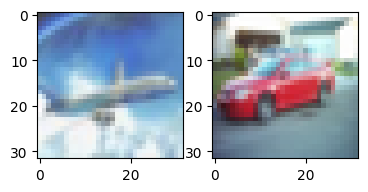

tensor([[[119, 166, 224,  ..., 234, 129, 176],
         [229, 136, 177,  ..., 174, 234, 122],
         [174, 231, 122,  ..., 224, 224, 247],
         ...,
         [242, 229,   5,  ..., 228, 227, 248],
         [170, 192, 235,  ...,  75,  73,  95],
         [125,  89, 111,  ..., 233,   0, 179]],

        [[153, 120, 173,  ..., 183, 200, 237],
         [175, 197, 236,  ...,  62, 100, 114],
         [136,  93, 104,  ..., 218, 224, 181],
         ...,
         [112,  34,  59,  ..., 240, 221,  25],
         [  5, 243, 254,  ...,  40,  77, 132],
         [171, 207, 253,  ...,  78,  68,  92]],

        [[125,   6,  25,  ...,  43,  31,  64],
         [ 55,  38,  62,  ...,  16,  56, 110],
         [212, 243,  28,  ..., 113,  86, 109],
         ...,
         [153, 197,  54,  ..., 118, 212, 251],
         [102, 191, 235,  ...,   3, 106, 212],
         [  2, 104, 212,  ..., 210, 249,  94]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


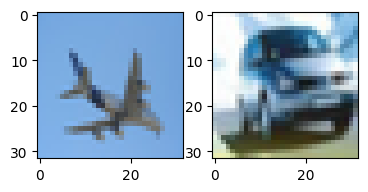

tensor([[[ 15, 235, 166,  ..., 187,  48,  30],
         [246,  40,  29,  ..., 244, 192,  20],
         [241, 188,  24,  ..., 204, 204, 189],
         ...,
         [202, 113,   8,  ..., 187, 170, 139],
         [  6, 207, 135,  ..., 113, 210, 182],
         [115, 185, 176,  ..., 208, 132,  16]],

        [[206, 119,  11,  ..., 205, 186, 153],
         [ 26, 226, 155,  ..., 115, 198, 177],
         [112, 161, 153,  ...,   3, 204,  48],
         ...,
         [218,  74,  38,  ...,  58,  36,  36],
         [ 18, 253, 213,  ...,  36,  14, 254],
         [ 21, 251, 211,  ..., 151, 239, 201]],

        [[154, 244, 217,  ..., 197, 169, 207],
         [189, 160, 204,  ...,  34,   5, 239],
         [ 25,   3, 225,  ..., 239,  55,  38],
         ...,
         [113, 112, 110,  ..., 116, 119, 113],
         [116, 116, 111,  ..., 104, 100, 108],
         [103, 100, 107,  ..., 100,  99,  97]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


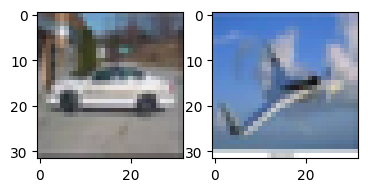

tensor([[[128, 130, 120,  ..., 223, 198, 218],
         [221, 193, 212,  ..., 220, 225, 205],
         [223, 227, 208,  ..., 227, 249, 247],
         ...,
         [  0, 248, 233,  ..., 252,   9,  11],
         [ 91,  92, 110,  ...,  67, 238, 255],
         [  4, 225, 219,  ...,  29,  15, 252]],

        [[ 15,   3, 221,  ...,  29,  26,  34],
         [143, 151, 168,  ...,  55, 243, 230],
         [229,  10, 216,  ...,   7, 253,  33],
         ...,
         [230, 208, 177,  ..., 216,   8, 238],
         [214, 250,  24,  ...,   9, 245, 242],
         [ 40,  15,   5,  ...,  20, 216, 192]],

        [[224, 179, 146,  ..., 148, 210, 212],
         [173, 216,  10,  ...,   1, 230, 233],
         [ 59,  17,   6,  ...,  28, 250, 224],
         ...,
         [ 90,  69,  46,  ...,  10,  64,  29],
         [255,  59,  22,  ..., 175, 194, 232],
         [184, 200,   8,  ..., 137, 116,  93]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


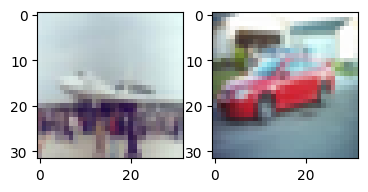

tensor([[[ 42,  54, 127,  ..., 242, 129, 156],
         [242, 129, 156,  ..., 156, 243, 127],
         [157, 244, 126,  ..., 123, 150, 236],
         ...,
         [203,  17, 169,  ..., 128, 140, 223],
         [ 10,  24, 129,  ...,  33, 180, 193],
         [251, 183, 172,  ..., 182, 216, 147]],

        [[163, 194, 110,  ..., 160, 156, 230],
         [ 66,  84, 189,  ..., 200, 128, 103],
         [126, 154,  90,  ..., 115, 124, 158],
         ...,
         [143,  20,  32,  ...,  93, 181,  55],
         [ 80, 171,  53,  ...,  17,  18,  98],
         [ 58,  78, 132,  ..., 201,  48,  70]],

        [[143,   2,  14,  ...,  35, 124,  14],
         [ 30, 117,  10,  ...,  18,  20,  99],
         [ 78,  94, 156,  ..., 203,  59,  81],
         ...,
         [ 62,  79, 140,  ...,  97,  26,  24],
         [ 92,  24,  21,  ...,  15,  86,  20],
         [ 15,  84,  23,  ...,  55,  52, 114]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


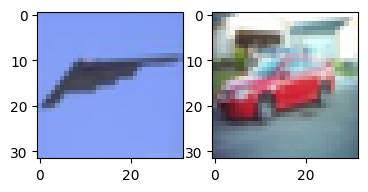

tensor([[[207, 241,  49,  ...,  56, 217, 247],
         [ 54, 220, 250,  ..., 252,  57, 220],
         [255,  57, 208,  ...,  32,  58, 102],
         ...,
         [162, 152, 128,  ...,  24,  48,  91],
         [ 41,  72, 106,  ..., 255, 152, 189],
         [241, 141, 176,  ..., 149, 142, 143]],

        [[168, 166, 171,  ...,  23,  49,  88],
         [ 52,  89, 110,  ..., 238, 131, 171],
         [219, 122, 161,  ..., 184, 188, 180],
         ...,
         [207,  85, 117,  ..., 225,  29, 206],
         [235,  45, 202,  ...,  27,  55,  95],
         [118, 141, 188,  ..., 251, 148, 176]],

        [[232, 167, 193,  ..., 174, 232, 173],
         [202,  13, 176,  ...,  55,  84, 124],
         [113, 138, 186,  ..., 222, 181, 206],
         ...,
         [113, 134, 181,  ..., 167,  97, 117],
         [163,  94, 114,  ...,  51, 106,  32],
         [ 52, 106,  33,  ...,  98, 119, 169]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


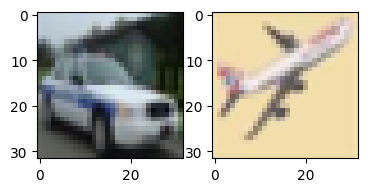

tensor([[[187, 183,  16,  ...,  22, 186, 185],
         [ 23, 185, 184,  ..., 182,  23, 186],
         [183,  26, 187,  ..., 236, 232,  62],
         ...,
         [187,  25, 185,  ..., 251, 246,  77],
         [194, 192,  25,  ...,  37, 193, 180],
         [ 39, 192, 178,  ..., 180,  39, 187]],

        [[189,  27, 187,  ...,   0, 249,  80],
         [204, 205,  35,  ...,  39, 181, 188],
         [ 41, 178, 186,  ..., 180,  29, 186],
         ...,
         [227,   8, 222,  ..., 169, 207, 198],
         [173, 210, 195,  ...,  39,  34, 119],
         [224, 221,  77,  ...,  40, 215, 209]],

        [[  6, 212, 196,  ...,  67, 150,  82],
         [ 66, 150,  81,  ...,  33,  26, 115],
         [230, 226,  76,  ...,   6, 229, 218],
         ...,
         [ 16, 255, 127,  ..., 133,  27,   0],
         [134,  25, 250,  ..., 241, 135,  10],
         [236, 129,   8,  ..., 245, 231, 125]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


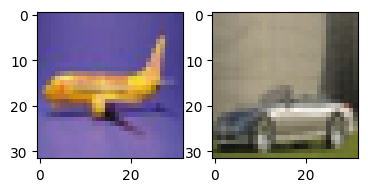

tensor([[[212, 178, 132,  ..., 157, 250, 216],
         [158, 253, 218,  ..., 208, 154, 240],
         [206, 150, 239,  ..., 170, 140,  93],
         ...,
         [191, 140, 213,  ..., 139, 117,  75],
         [192, 168, 126,  ..., 145, 231, 204],
         [155, 250, 224,  ..., 189, 138, 209]],

        [[185, 135, 213,  ..., 131, 110,  72],
         [180, 159, 117,  ..., 146, 245, 219],
         [170,  20, 251,  ..., 193, 143, 214],
         ...,
         [238, 240, 234,  ...,  81,  56,  92],
         [ 83,  56,  87,  ..., 112,  99,  79],
         [190, 175, 145,  ..., 184, 212, 207]],

        [[191, 239, 231,  ..., 141, 115, 152],
         [143, 116, 152,  ..., 120, 106,  87],
         [182, 176, 160,  ..., 177, 163, 162],
         ...,
         [240, 240, 178,  ..., 155, 230, 230],
         [170, 245, 249,  ..., 228, 145, 228],
         [231, 150, 231,  ..., 223, 221, 141]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


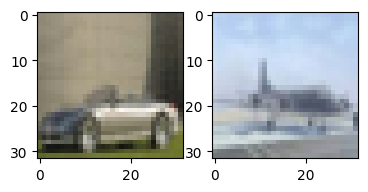

tensor([[[206, 205, 184,  ..., 230,   0, 247],
         [229,   1, 249,  ..., 251, 228,   4],
         [248, 226, 255,  ..., 194, 190, 173],
         ...,
         [233, 218, 237,  ..., 236, 230, 214],
         [211, 203, 181,  ..., 250,  15,   7],
         [251,  15,   8,  ..., 216, 204, 215]],

        [[211, 200, 211,  ..., 210, 206, 190],
         [232, 225, 201,  ...,   1,  19,   9],
         [  3,  19,  12,  ...,  19,   6,  22],
         ...,
         [ 66,  30,  58,  ..., 118, 132,  85],
         [ 93, 107,  83,  ..., 241, 240, 246],
         [249, 253, 247,  ...,  32, 255,  25]],

        [[ 47,  15,  42,  ...,  86,  98,  76],
         [ 87,  97,  81,  ..., 230, 233, 243],
         [220, 225, 221,  ..., 230, 245,  10],
         ...,
         [221, 220, 218,  ..., 221, 210, 213],
         [220, 209, 213,  ..., 209, 210, 210],
         [205, 204, 209,  ..., 245, 239, 235]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


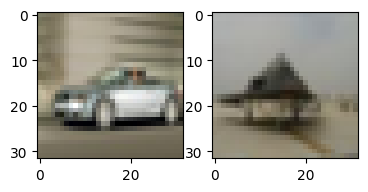

tensor([[[  7,   6, 235,  ...,   6,  36,  26],
         [  4,  29,  20,  ...,  13, 247,  18],
         [ 10, 244,  15,  ..., 242, 241, 219],
         ...,
         [ 15, 247,  21,  ...,  20,  15, 249],
         [230, 221, 195,  ...,   8,  40,  31],
         [  8,  42,  33,  ..., 248, 224, 250]],

        [[246, 224, 244,  ..., 248, 246, 224],
         [  0, 248, 220,  ...,  17,  45,  35],
         [ 17,  44,  36,  ...,  51,  27,  45],
         ...,
         [ 14,  40,  54,  ...,  71,  68,  69],
         [ 69,  66,  64,  ..., 230, 230, 219],
         [ 18,  14, 245,  ...,  17, 255,  12]],

        [[  8,  14,  27,  ...,  48,  44,  50],
         [ 51,  44,  47,  ..., 215, 218, 209],
         [239, 236, 213,  ..., 217, 253,   7],
         ...,
         [215, 209, 190,  ..., 175, 201, 194],
         [178, 201, 194,  ..., 178, 161, 179],
         [175, 158, 178,  ..., 219, 222, 212]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


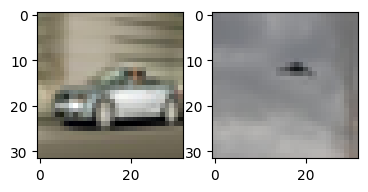

tensor([[[  6,  17,  29,  ...,  28,   3,  14],
         [ 26, 253,  12,  ...,   7,  55, 235],
         [ 16,  73,   7,  ...,  11,  27,  48],
         ...,
         [ 13,  34,  42,  ..., 105, 143, 169],
         [ 52,  64,  68,  ...,  96,  40,  63],
         [ 79,  42,  61,  ...,  81, 109,  91]],

        [[120, 153, 121,  ..., 109, 151, 183],
         [111, 124, 123,  ..., 110,  44,  67],
         [ 84,  40,  61,  ..., 147, 181, 112],
         ...,
         [102,  57,  83,  ...,  24,  35,  28],
         [ 52,  61,  14,  ...,  28,  49,  61],
         [ 70,  93, 103,  ...,  93,  98, 128]],

        [[145, 103, 136,  ...,   1,   3,  32],
         [ 50,  51, 237,  ..., 235, 248,   4],
         [ 46,  69,  82,  ...,  16, 250,  16],
         ...,
         [ 20, 255, 234,  ..., 227,  19, 255],
         [231,  20,   0,  ..., 246, 213,   8],
         [248, 219,  16,  ...,   8,  11, 241]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


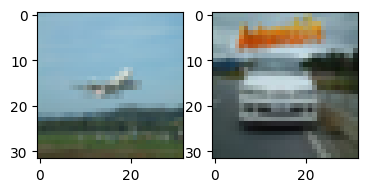

tensor([[[ 30, 220, 200,  ..., 198, 236, 197],
         [193, 237, 198,  ..., 190, 186, 237],
         [197, 185, 239,  ...,  12, 214, 193],
         ...,
         [239, 240, 244,  ...,   0, 204, 189],
         [  1, 206, 187,  ..., 195, 249, 201],
         [185, 247, 203,  ..., 233, 243, 248]],

        [[249,   6, 215,  ...,   4, 213, 195],
         [  3, 203, 173,  ..., 183, 228, 187],
         [165, 224, 182,  ..., 220, 238, 211],
         ...,
         [155, 230, 222,  ..., 218, 249, 196],
         [188, 216, 176,  ..., 132,  99, 108],
         [126,  92,  82,  ..., 150, 224, 208]],

        [[214,  10, 252,  ..., 164, 184, 160],
         [144, 161, 129,  ..., 142, 107, 111],
         [129, 104,  81,  ..., 170,   5, 247],
         ...,
         [232, 199, 212,  ..., 202, 230, 198],
         [202, 230, 199,  ..., 198, 201, 233],
         [199, 203, 233,  ..., 230, 198, 208]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


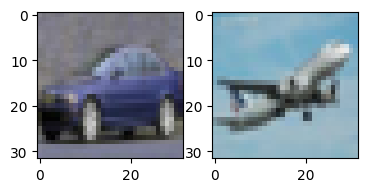

tensor([[[103,  92, 112,  ..., 160, 245, 217],
         [206,  82,  44,  ...,  73,  23, 139],
         [100,  53, 152,  ...,  86,  65,  38],
         ...,
         [103,  85, 132,  ..., 193, 166, 170],
         [103,  76,  89,  ..., 206,  47,  14],
         [234,  36,   6,  ..., 114,  87, 152]],

        [[142, 123, 156,  ..., 168, 143, 146],
         [ 54,  37,  57,  ..., 215,  72,  43],
         [  6,  96,  65,  ..., 155, 134, 181],
         ...,
         [184, 195, 186,  ...,  11,  10,  13],
         [ 15,  14,  14,  ...,   5, 247, 242],
         [ 54,  49,  60,  ..., 170, 154, 144]],

        [[159, 130, 128,  ...,   8,   5, 255],
         [254, 254, 250,  ..., 231, 216, 213],
         [ 48,  43,  56,  ..., 166, 115, 118],
         ...,
         [ 83,  73,  82,  ..., 172, 235, 204],
         [185, 246, 215,  ..., 175, 161, 203],
         [176, 159, 201,  ..., 198, 175, 160]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


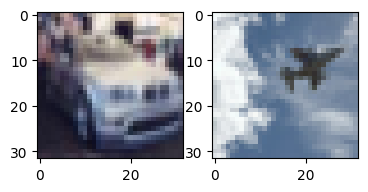

tensor([[[  4,  87, 114,  ..., 122,  37, 103],
         [131,  27,  96,  ..., 113, 133,  29],
         [101, 127,  35,  ..., 254,  81, 103],
         ...,
         [ 67,  72,  24,  ...,  57, 119, 142],
         [241,  57,  94,  ..., 154, 238,  58],
         [137, 225,  48,  ..., 123, 110,   9]],

        [[ 62,  62,  58,  ...,  61, 121, 147],
         [250,  66, 104,  ..., 156,  20,  98],
         [164, 246,  70,  ..., 133, 118,  56],
         ...,
         [204, 167, 199,  ..., 170, 255, 146],
         [191,  17, 189,  ...,  74, 117, 123],
         [132, 171, 170,  ..., 188, 168, 196]],

        [[199, 166, 194,  ..., 238,  92, 189],
         [239,  92, 192,  ...,  74, 118, 118],
         [139, 177, 177,  ..., 139, 129, 155],
         ...,
         [ 83, 121, 120,  ..., 131, 100, 133],
         [133, 103, 136,  ..., 157, 172, 166],
         [193, 197, 127,  ...,  70, 105,  97]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


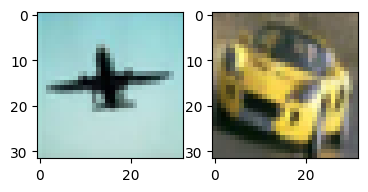

tensor([[[229,  15,  77,  ...,  40, 186, 243],
         [ 41, 185, 242,  ..., 245,  46, 196],
         [252,  54, 199,  ...,   3,  52, 114],
         ...,
         [ 28,  62, 251,  ..., 252,  31,  71],
         [240,  25,  70,  ...,   7, 179, 228],
         [ 13, 183, 228,  ..., 244,   4,  13]],

        [[ 34,  62,  21,  ...,  25,  57,  92],
         [225,   7,  53,  ...,   9, 178, 225],
         [  5, 179, 223,  ..., 180, 179, 190],
         ...,
         [156,  27, 207,  ..., 202, 196, 215],
         [204, 189, 221,  ...,  49,  78,  86],
         [235, 246,   6,  ..., 183,  58, 237]],

        [[153,  47, 233,  ..., 253, 242, 239],
         [251, 237, 248,  ...,  76, 100, 104],
         [250, 252,  10,  ..., 221,  76,   4],
         ...,
         [ 36,  45,  35,  ...,  60,  66,  74],
         [ 41,  61,  74,  ...,  77,  63,  53],
         [ 66,  57,  41,  ...,  38,  63,  55]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


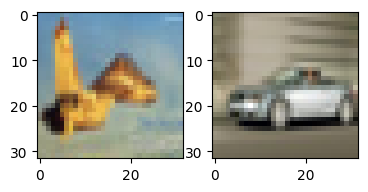

tensor([[[111,  47, 237,  ..., 139, 252, 180],
         [117,   0, 185,  ...,  40, 227,  86],
         [ 13, 202,  57,  ...,  23, 187, 107],
         ...,
         [119,  67, 182,  ..., 239, 167, 114],
         [  0, 191, 131,  ...,  58, 252, 197],
         [140, 194, 140,  ..., 105,  53, 164]],

        [[107,  58, 166,  ..., 201, 129,  80],
         [171, 106,  48,  ..., 106, 221, 163],
         [115, 227, 168,  ..., 199, 153,   8],
         ...,
         [ 94,  91,  87,  ..., 107,  90, 110],
         [104,  84, 100,  ...,  78,  62,  42],
         [ 82,  74,  48,  ...,  98, 116, 113]],

        [[ 96, 106, 102,  ..., 105,  89, 108],
         [100,  82, 102,  ...,  73,  60,  38],
         [109, 100,  79,  ...,  88, 109, 102],
         ...,
         [ 51,  40,  22,  ..., 203, 229, 216],
         [206, 229, 216,  ..., 164, 175, 170],
         [163, 176, 167,  ..., 241, 235, 224]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


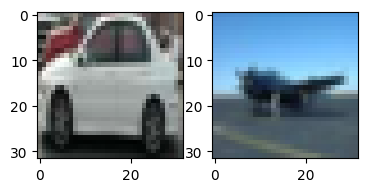

tensor([[[ 77,  40,   3,  ...,   2,  75,  39],
         [  2,  75,  39,  ...,  36, 249,  72],
         [ 36, 252,  67,  ...,  80,  40,  10],
         ...,
         [ 90,  76, 130,  ...,   9, 227, 197],
         [ 78,  41,   8,  ..., 154, 246, 209],
         [175,  51,  22,  ..., 116, 103, 156]],

        [[109, 105, 167,  ..., 235, 195, 165],
         [ 77,  38,   4,  ..., 111, 178, 136],
         [105, 234, 211,  ..., 178, 178,  14],
         ...,
         [138, 162, 129,  ..., 171, 155, 207],
         [165, 145, 139,  ..., 201, 164, 130],
         [125,  89,  51,  ...,  78, 108,  62]],

        [[ 45, 105,  64,  ..., 154, 134, 195],
         [149, 124, 144,  ..., 234, 197, 164],
         [149, 113,  73,  ...,  33, 113,  77],
         ...,
         [ 70,  34,   3,  ..., 255,  65,  31],
         [  0,  65,  31,  ...,  32,   0,  66],
         [ 33,   1,  66,  ...,  66,  31,   3]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


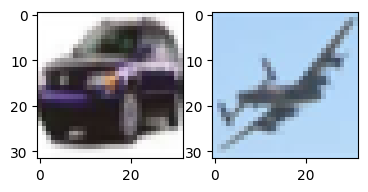

tensor([[[ 19,  10, 232,  ..., 150, 161, 157],
         [126, 163, 160,  ...,  15, 245, 248],
         [239, 215, 230,  ..., 189, 161, 115],
         ...,
         [122, 109, 140,  ..., 176, 161, 150],
         [188, 176, 157,  ..., 142,   4,  12],
         [229, 131, 144,  ..., 114,  98, 111]],

        [[113,  97, 136,  ..., 144, 129, 116],
         [111,  99,  82,  ...,   4,  65,  72],
         [ 30,   3,  15,  ..., 211, 197, 219],
         ...,
         [121, 105, 131,  ..., 115,  91,  90],
         [130,  87,  77,  ..., 216, 202, 181],
         [221, 217, 195,  ...,  42,  32,  85]],

        [[ 90,  60,  88,  ..., 110, 105,  62],
         [111,  87,  76,  ..., 214, 200, 178],
         [250, 245, 223,  ..., 214, 242,  19],
         ...,
         [216, 213, 167,  ..., 110, 140, 139],
         [104, 130, 129,  ..., 126,  91, 123],
         [119,  84, 127,  ..., 151, 149, 112]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


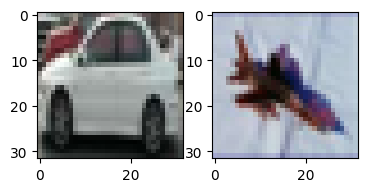

tensor([[[ 95,  92,  84,  ..., 114, 133, 131],
         [111, 130, 133,  ..., 112, 106, 133],
         [125, 116, 125,  ..., 105,  96,  76],
         ...,
         [117, 108, 104,  ..., 178, 173, 148],
         [112, 128, 132,  ..., 122, 103,  98],
         [ 98,  70,  69,  ..., 112, 107, 100]],

        [[106,  99, 110,  ..., 175, 173, 147],
         [105, 120, 124,  ..., 165, 164, 151],
         [143,  97,  86,  ...,  62,  65,  64],
         ...,
         [178, 145, 156,  ...,  78,  56, 238],
         [214, 199, 148,  ..., 133, 154, 157],
         [205, 207, 188,  ...,  82, 113, 115]],

        [[116, 140, 143,  ...,  74,  52, 214],
         [190, 175, 181,  ..., 148, 166, 161],
         [207, 209, 189,  ...,  45,  52,  52],
         ...,
         [178, 181, 166,  ..., 178, 204, 200],
         [180, 207, 202,  ..., 212, 196, 209],
         [209, 190, 208,  ..., 180, 181, 160]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


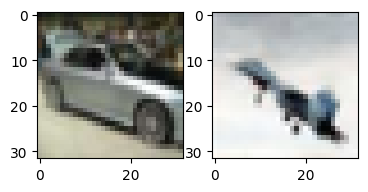

tensor([[[209,  32, 109,  ..., 109, 243,  35],
         [ 96, 254,  49,  ...,  58,  86,   0],
         [ 36,  76, 231,  ..., 250,  52, 114],
         ...,
         [102,  93,  90,  ..., 181, 206, 253],
         [ 20,  46,  95,  ...,  54,  53,  42],
         [ 58, 106,  95,  ...,  51,  63, 141]],

        [[138, 136, 128,  ..., 198, 221,  13],
         [ 87,  89, 133,  ...,  38,  73,  57],
         [ 76, 128, 110,  ..., 102, 121, 173],
         ...,
         [ 71,  91,  68,  ..., 185, 160,  44],
         [ 20, 250,  90,  ...,  79,  55,  37],
         [215, 200, 200,  ..., 247,  16,   5]],

        [[249,   3, 241,  ..., 157, 144, 231],
         [224, 214, 240,  ...,  18,  11,   5],
         [ 11, 253, 248,  ..., 205, 238, 222],
         ...,
         [241, 240, 237,  ..., 248,   1, 252],
         [251,   1, 253,  ...,  12,   9,  14],
         [ 13,  10,   6,  ...,   0, 254,   1]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


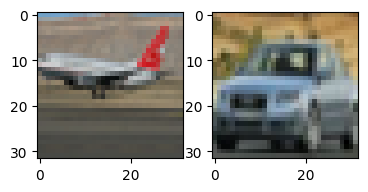

tensor([[[128, 132, 180,  ..., 167, 115, 109],
         [165,  96,  92,  ..., 152, 199, 130],
         [142, 189, 128,  ..., 148, 164, 204],
         ...,
         [109, 172, 124,  ..., 170, 176, 209],
         [184, 176, 202,  ..., 111,  36,  56],
         [123,  31,  55,  ...,  81, 165,  54]],

        [[ 84, 161,  63,  ..., 178, 177, 212],
         [152, 143, 161,  ...,  37,  19,  36],
         [ 78,  35,  56,  ...,  73, 146,  56],
         ...,
         [222, 250, 231,  ...,  17,  20, 111],
         [ 92,  82, 100,  ..., 153, 134, 111],
         [ 20, 253, 251,  ...,  18,  15,   3]],

        [[252,  22,   8,  ...,  46,  43,  89],
         [ 62,  42,  85,  ..., 150, 123,  90],
         [  0, 236, 237,  ...,  54,  38,  27],
         ...,
         [182, 162, 156,  ..., 176, 207, 190],
         [191, 202, 186,  ..., 104,  61, 139],
         [107,  61, 132,  ..., 123,  88,  39]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


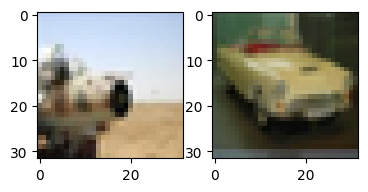

tensor([[[ 90, 104, 167,  ..., 178,  94, 114],
         [174, 101, 115,  ..., 110, 166,  85],
         [112, 178,  82,  ..., 187, 160, 190],
         ...,
         [232, 222, 229,  ..., 188, 185, 207],
         [138, 150, 190,  ...,   0,  24,   1],
         [243,  45,  16,  ..., 162, 144, 176]],

        [[152, 133, 159,  ..., 144, 162, 198],
         [143, 158, 191,  ...,  19,  55,  25],
         [ 10,  51,   6,  ..., 157, 132, 183],
         ...,
         [253,  18, 249,  ...,   8,   5,  38],
         [ 23,  22,  15,  ...,  23,  41,  58],
         [161, 204, 219,  ..., 206,  43,  20]],

        [[ 11, 248, 220,  ...,  83,  85,  78],
         [ 94,  96,  77,  ...,  15,  51,  70],
         [203, 244, 251,  ..., 240,  59,  37],
         ...,
         [185, 211,  26,  ...,  95, 245,  12],
         [ 80, 225, 253,  ...,  30,  94, 250],
         [ 30,  93, 251,  ..., 253,  25,  85]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


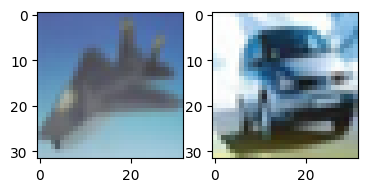

tensor([[[168, 188, 235,  ..., 185, 133, 150],
         [212, 125, 137,  ..., 183, 228, 163],
         [185, 232, 151,  ..., 175, 180, 223],
         ...,
         [105, 120, 112,  ...,  22,  21,  28],
         [  2,  11,  64,  ...,  46,  74,  59],
         [ 82,  51,  29,  ...,  45,  70,  72]],

        [[ 45,  69, 137,  ...,  22,  19,  21],
         [ 21,  18,  61,  ..., 182,  36,   2],
         [ 34,  35,  33,  ..., 242,  18,   3],
         ...,
         [145, 167, 169,  ..., 158, 188, 224],
         [225, 217,   1,  ..., 182, 193, 167],
         [244, 241, 238,  ..., 138, 177, 179]],

        [[154, 179, 179,  ..., 216, 215, 251],
         [  0, 247,  32,  ..., 164, 176, 167],
         [234, 244, 208,  ..., 114, 145, 155],
         ...,
         [193, 211, 169,  ..., 200, 220, 231],
         [195, 221, 233,  ..., 194, 167, 194],
         [199, 174, 197,  ..., 195, 196, 181]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


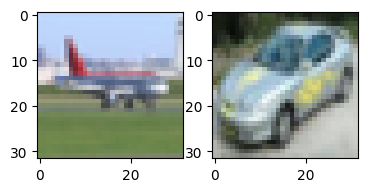

tensor([[[118,  61, 161,  ..., 159, 117,  99],
         [167, 124, 113,  ..., 119, 174,  70],
         [ 53, 123,  77,  ..., 121,  62, 160],
         ...,
         [ 65,  91, 242,  ...,  99,  95, 147],
         [ 74,  58, 110,  ..., 126,  90,  95],
         [116,  71,  79,  ...,  21,  43, 215]],

        [[231, 252, 196,  ..., 117, 136, 167],
         [ 63,  63, 102,  ..., 128,  99, 107],
         [125,  79,  89,  ..., 230, 246, 215],
         ...,
         [240,  44,  23,  ...,   8, 216,   4],
         [240, 191,  17,  ...,  94,  53,  15],
         [ 90,  42,  17,  ..., 252,  66,  41]],

        [[250,  55,  30,  ...,  58,   8,  22],
         [253, 202,  26,  ..., 100,  50,  14],
         [121,  56,  43,  ...,  37,  82,  56],
         ...,
         [136,  25,  50,  ...,  27, 102,  56],
         [ 26, 103,  66,  ..., 117,  74, 146],
         [104,  68, 127,  ..., 141,  28,  48]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


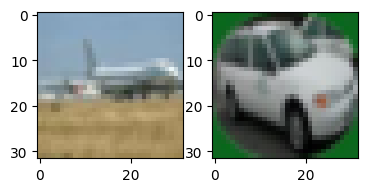

tensor([[[158, 157, 133,  ..., 190, 220, 210],
         [190, 219, 210,  ..., 200, 180, 203],
         [195, 175, 199,  ..., 141, 140, 114],
         ...,
         [212, 184, 223,  ..., 217, 206, 176],
         [212, 194, 163,  ..., 233,  18,   1],
         [231,  19,   2,  ..., 203, 175, 210]],

        [[199, 172, 205,  ..., 197, 186, 155],
         [234, 218, 183,  ..., 238,  23,   5],
         [239,  22,   6,  ...,   6, 233,  19],
         ...,
         [ 53,  45,  70,  ...,  72,  85,  58],
         [ 72,  89,  55,  ..., 193, 200, 196],
         [ 26,  28,  51,  ...,  69,  32,  59]],

        [[ 74,  54,  81,  ...,  80,  88,  52],
         [ 73,  81,  44,  ..., 177, 190, 192],
         [  8,   3,  60,  ...,  36,  23,  43],
         ...,
         [  5, 246,  67,  ...,  55, 254, 237],
         [ 59, 250, 233,  ..., 233,  60, 250],
         [235,  60, 249,  ..., 237, 224,  49]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


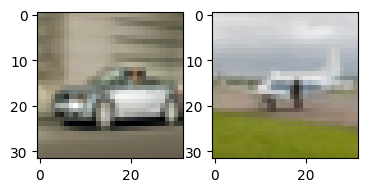

tensor([[[155,  67, 177,  ..., 171, 153, 106],
         [179, 161, 120,  ..., 126, 177, 101],
         [ 60, 126, 108,  ..., 146,  61, 163],
         ...,
         [ 68, 101,  10,  ..., 116,  89, 153],
         [ 98,  60, 124,  ..., 136, 127, 111],
         [145, 126, 112,  ...,  30,  58, 239]],

        [[238,  10, 220,  ..., 135, 129, 176],
         [ 86,  65, 117,  ..., 139, 130, 117],
         [150, 130, 119,  ..., 222, 247, 218],
         ...,
         [ 28, 236, 239,  ..., 251,  11, 228],
         [232, 251, 238,  ...,  84,  71, 106],
         [ 23, 254,  43,  ..., 244, 221, 223]],

        [[236, 211, 216,  ...,  51,  67, 200],
         [205, 224, 223,  ..., 111,  88, 125],
         [ 88,  45, 105,  ...,  66,  39,  38],
         ...,
         [148,  36, 125,  ...,  91, 107,  70],
         [ 97, 113,  85,  ..., 137, 141, 150],
         [121, 129, 132,  ..., 136,  37, 112]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


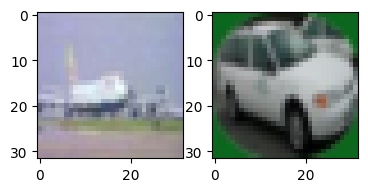

tensor([[[200, 212, 138,  ..., 141, 196, 219],
         [140, 209, 233,  ..., 166, 103, 156],
         [173, 112, 149,  ...,  83, 118,  80],
         ...,
         [  0, 149, 230,  ..., 158, 170, 102],
         [218, 210, 126,  ..., 193,  83,  64],
         [200,  93,  70,  ...,  34, 161,  56]],

        [[ 31, 162,  44,  ..., 163, 174, 101],
         [218, 210, 129,  ..., 249,  90,  74],
         [227,  93,  74,  ...,  43, 182,  59],
         ...,
         [139, 204, 210,  ...,   7, 208,  14],
         [  5, 204,  28,  ..., 194, 188, 124],
         [ 29,  12, 200,  ..., 115, 133, 160]],

        [[106, 141, 159,  ...,  13, 210,  36],
         [ 24, 227,  56,  ..., 197, 190, 126],
         [ 22,   4, 193,  ..., 127, 172, 192],
         ...,
         [ 57,  44,  12,  ..., 233,  42,  23],
         [227,  38,  19,  ...,   8, 221,  25],
         [  8, 221,  24,  ...,  12,   3, 225]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


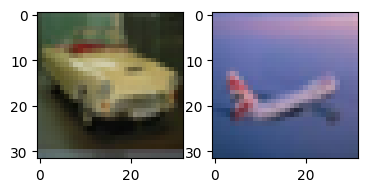

tensor([[[168, 153, 138,  ..., 252,   0,   0],
         [249,   0,   0,  ...,   0, 253,   0],
         [254,   0,   0,  ..., 250, 254, 253],
         ...,
         [166, 105, 140,  ..., 141, 147,  88],
         [232, 233, 212,  ..., 192, 137, 150],
         [100, 133, 122,  ..., 206, 147, 181]],

        [[190, 137, 156,  ..., 161, 154, 109],
         [ 64,  66,  63,  ..., 169, 156, 145],
         [ 78, 181, 134,  ..., 248, 223,  53],
         ...,
         [ 74,  58,  32,  ...,  71,  90, 245],
         [213, 234, 224,  ...,  55,  25,  12],
         [  7, 247, 214,  ..., 138, 100,  94]],

        [[ 88,  60,  45,  ...,   2,  14, 207],
         [178, 183, 177,  ...,  54,  28,   4],
         [ 22,   2, 223,  ...,   5, 230, 225],
         ...,
         [ 82,  67,  33,  ..., 142, 187, 155],
         [129, 180, 146,  ..., 143, 140, 185],
         [152, 148, 201,  ...,  54,  21,  15]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


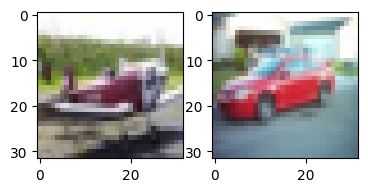

tensor([[[137, 152, 136,  ...,  97,  98, 123],
         [ 98, 117, 140,  ...,  75,  60,  79],
         [ 85,  70,  79,  ...,  44,  47,  38],
         ...,
         [138,  91, 110,  ...,  48,  52,  37],
         [ 66,  73,  49,  ...,  79, 144, 136],
         [ 78, 137, 128,  ..., 162,  92, 173]],

        [[156,  91, 164,  ...,  45,  52,  33],
         [ 63,  71,  50,  ..., 121, 157, 152],
         [111, 157, 151,  ..., 250, 189, 240],
         ...,
         [ 72, 155, 152,  ..., 103,  79, 106],
         [102,  78, 104,  ...,  46,  42,  29],
         [ 87,  96,  78,  ...,  38,  86,  88]],

        [[ 69, 218, 216,  ..., 111,  82, 130],
         [126, 105, 130,  ...,  49,  45,  31],
         [ 88,  97,  78,  ...,  51, 215, 212],
         ...,
         [105, 120, 125,  ..., 109, 102, 108],
         [105, 100, 106,  ..., 100,  99,  98],
         [ 99,  99,  99,  ...,  86,  91,  93]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


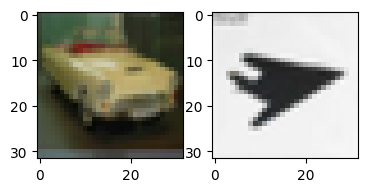

tensor([[[ 20,  25,   3,  ..., 221, 239, 234],
         [217, 238, 234,  ..., 252, 229,   7],
         [  1, 236,  11,  ...,  83,  83,  70],
         ...,
         [101,  36,  92,  ..., 156, 138,  85],
         [ 86,  62,  28,  ..., 239,  79,  54],
         [233,  71,  51,  ...,  90,   4,  92]],

        [[ 90,  11,  91,  ..., 157, 134,  77],
         [ 92,  57,  29,  ..., 218,  81,  47],
         [219,  77,  48,  ...,  85, 232,  88],
         ...,
         [195,  61,  18,  ..., 238, 167,  13],
         [233, 164,   8,  ..., 131, 117,  76],
         [ 39,  20, 252,  ..., 214,  47,   6]],

        [[198,  33, 249,  ..., 160,  91, 190],
         [153,  88, 187,  ..., 116,  99,  64],
         [ 32,  15, 249,  ..., 201,  63,  26],
         ...,
         [ 64,  49,  90,  ...,  47,  33,  16],
         [ 45,  32,  11,  ...,   7,  53,  26],
         [  5,  48,  21,  ...,  49,  34,  86]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


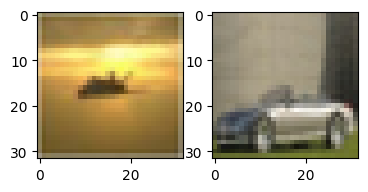

tensor([[[  2, 247,  46,  ...,  59, 246, 231],
         [ 61, 227, 215,  ...,  13, 108, 248],
         [  3,  97, 247,  ...,  14,  26,  90],
         ...,
         [230, 140, 235,  ...,  19,  36, 142],
         [ 18,  28, 131,  ...,  99, 146, 180],
         [ 91, 141, 177,  ..., 206, 136, 166]],

        [[208, 132, 178,  ...,  25,  38, 151],
         [ 22,  32, 134,  ...,  31, 190, 213],
         [ 62, 208, 230,  ..., 205, 123, 176],
         ...,
         [182, 242,  25,  ..., 206,   6, 175],
         [186, 223, 168,  ..., 225, 232, 252],
         [251,   9, 123,  ..., 208,  24,  61]],

        [[200,  14,  58,  ..., 225,  34, 196],
         [208,   4, 166,  ..., 224, 225, 247],
         [253,   9, 121,  ..., 213,   6,  44],
         ...,
         [ 11,   1,  16,  ...,  91,  30,  31],
         [ 77,  32,  38,  ...,  67,  98, 111],
         [104, 117, 120,  ...,  90,  74,  88]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


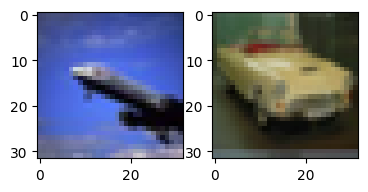

tensor([[[ 63,  86, 116,  ..., 104,  35,  61],
         [100,  34,  62,  ...,  69, 105,  45],
         [ 70, 110,  48,  ..., 118, 140, 164],
         ...,
         [ 76, 109,  56,  ...,  81,  99, 104],
         [ 27,  46,  69,  ..., 106,  44,  67],
         [102,  40,  62,  ...,  42,  77,  56]],

        [[ 79, 111,  55,  ...,  33,  49,  33],
         [224, 243,   3,  ...,  93,  41,  65],
         [104,  40,  60,  ...,  13,  45,   3],
         ...,
         [181, 148, 158,  ..., 156, 139, 143],
         [155, 158, 179,  ...,  84,  94,  57],
         [199, 215, 210,  ..., 202, 177, 187]],

        [[198, 149, 161,  ..., 152, 111,  96],
         [109, 110, 122,  ...,  70,  84,  41],
         [240, 255, 239,  ..., 185, 191, 201],
         ...,
         [ 35,  35,  44,  ...,  40,  24,  27],
         [ 41,  27,  25,  ...,  11,  52,  10],
         [  8,  48,   9,  ...,  21,  20,  56]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


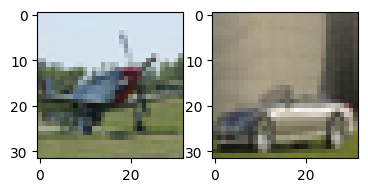

tensor([[[241, 241, 241,  ..., 242, 240, 240],
         [240, 240, 240,  ..., 238, 238, 236],
         [236, 236, 238,  ..., 236, 236, 236],
         ...,
         [162, 163, 165,  ..., 242, 242, 242],
         [251, 251, 251,  ...,  82,  79,  77],
         [ 78,  67,  65,  ...,  44,  45,  46]],

        [[ 44,  45,  53,  ..., 243, 243, 243],
         [252, 252, 252,  ...,  49,  49,  47],
         [ 48,  47,  45,  ...,  27,  28,  27],
         ...,
         [ 63,  19,  17,  ...,  92,  99,  20],
         [ 18,  22, 191,  ..., 247, 247, 247],
         [  0,   0,   0,  ..., 241,  44,  42]],

        [[ 43,  41,  40,  ...,  55,  60, 223],
         [221, 224, 166,  ..., 245, 245, 245],
         [  0,   0,   0,  ...,   7,  41,  39],
         ...,
         [ 48,  47,  42,  ...,  76,  89,  88],
         [ 83,  89,  88,  ...,  78,  73,  73],
         [ 72,  67,  70,  ...,  45,  44,  39]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


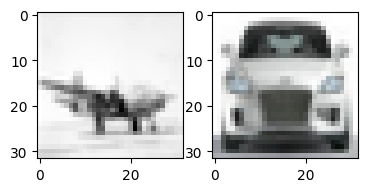

tensor([[[201, 200, 213,  ..., 226, 229, 231],
         [230, 185, 196,  ..., 247, 244, 239],
         [245, 242, 242,  ..., 246, 249, 249],
         ...,
         [108, 107,  74,  ..., 224, 238, 236],
         [ 69,  77,  84,  ...,  93,  79,  85],
         [ 89,  91,  95,  ...,  85,  82,  34]],

        [[ 45,  43,  42,  ..., 222, 237, 238],
         [130, 140, 147,  ..., 102,  76,  85],
         [ 90,  80,  88,  ...,  50,  42,  46],
         ...,
         [243, 224, 233,  ..., 243, 223, 198],
         [215, 198, 188,  ..., 129, 135, 117],
         [ 41,  41,  20,  ..., 230, 205, 227]],

        [[235, 216, 234,  ...,   2, 238, 237],
         [251, 232,  39,  ..., 110, 118,  95],
         [ 47,  44,  22,  ..., 222, 207, 236],
         ...,
         [ 27,  27,  40,  ..., 192, 154, 158],
         [179, 148, 150,  ..., 113, 123, 110],
         [110, 113, 111,  ..., 101, 109,  89]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


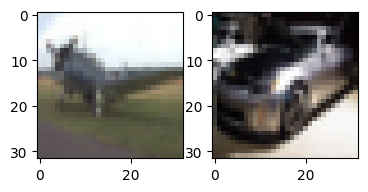

tensor([[[ 61,  69,  58,  ...,  58,  60,  67],
         [ 61, 244,   1,  ..., 215, 245, 172],
         [187, 212, 150,  ..., 161, 172, 197],
         ...,
         [241,   4, 221,  ...,  84,  95,  82],
         [ 67,  93,  86,  ...,  69,  19,  30],
         [ 42,  20,  30,  ..., 244,  10, 212]],

        [[218, 245, 204,  ..., 108, 117, 101],
         [115, 128, 116,  ...,  37, 247, 254],
         [ 12, 228, 234,  ..., 198, 216, 184],
         ...,
         [212,  14, 248,  ..., 120,  80, 164],
         [125,  84, 184,  ...,  44,  34,  28],
         [149, 152, 137,  ..., 154, 226, 217]],

        [[164,   2, 239,  ..., 158, 126, 190],
         [166, 129, 200,  ...,  70,  60,  54],
         [145, 148, 133,  ..., 146, 218, 204],
         ...,
         [130, 136, 120,  ..., 112, 115, 122],
         [102, 102, 108,  ..., 138, 122, 132],
         [135, 123, 128,  ..., 114, 117, 111]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


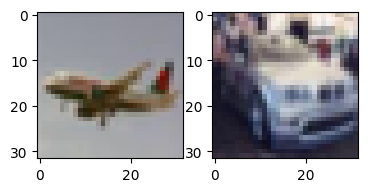

tensor([[[192, 188, 188,  ..., 180, 193, 188],
         [175, 205, 198,  ..., 180, 178, 197],
         [194, 189, 188,  ..., 224, 216, 212],
         ...,
         [217, 234, 235,  ..., 199, 199, 198],
         [ 13,   0, 234,  ..., 167,  19, 250],
         [188,  35,  10,  ..., 150, 195,  69]],

        [[ 41,  58, 244,  ..., 198, 200, 197],
         [  8, 250, 229,  ..., 172, 238, 210],
         [164,   4, 237,  ..., 168, 228, 151],
         ...,
         [137, 109, 123,  ...,  92,  24,  99],
         [ 91,  28, 104,  ..., 203, 214, 229],
         [139, 152, 159,  ..., 152, 116, 128]],

        [[142, 113, 126,  ...,  84, 244, 100],
         [ 87, 252, 101,  ..., 202, 212, 229],
         [133, 147, 153,  ..., 204, 157, 170],
         ...,
         [191, 197, 210,  ..., 205, 183, 191],
         [204, 183, 189,  ..., 173, 171, 123],
         [138, 146, 160,  ..., 212, 219, 240]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


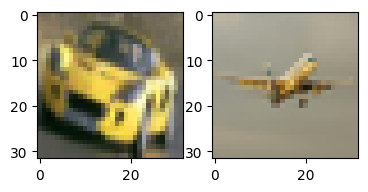

tensor([[[161, 176, 211,  ..., 206, 155, 171],
         [207, 154, 171,  ..., 167, 206, 151],
         [168, 208, 151,  ..., 153, 173, 209],
         ...,
         [ 39,  75,  21,  ..., 128, 163, 203],
         [115, 134, 177,  ..., 171, 128, 140],
         [176, 143, 153,  ...,  33,  65,  16]],

        [[ 31,  65,  10,  ..., 126, 163, 202],
         [107, 130, 173,  ..., 195, 120, 123],
         [148, 112, 111,  ..., 228,   2, 229],
         ...,
         [222,  33,  15,  ...,   0,  32, 242],
         [252,  22,   0,  ...,  99, 127, 164],
         [ 91, 110, 145,  ..., 149, 171, 161]],

        [[149, 205, 200,  ..., 217, 238, 215],
         [216, 224, 237,  ..., 101, 127, 164],
         [121, 135, 166,  ..., 168, 163, 166],
         ...,
         [ 86,  86, 121,  ...,  79,  65,  64],
         [ 77,  74,  75,  ...,  80,  85, 100],
         [105, 109, 109,  ..., 117, 135, 167]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


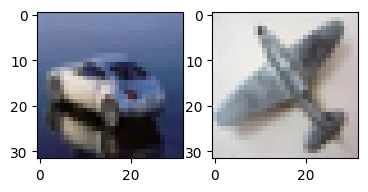

tensor([[[195, 188, 122,  ..., 170, 226, 223],
         [143, 235, 237,  ..., 191, 129, 196],
         [188, 125, 209,  ..., 186, 186, 122],
         ...,
         [  6, 245, 249,  ..., 112, 103,  61],
         [ 46,  29, 227,  ..., 198, 249, 255],
         [227,  16,  35,  ...,  58,  28,  31]],

        [[ 55,  26, 223,  ..., 115, 106,  68],
         [ 48,  32, 234,  ...,  10,  30,  28],
         [244,   1,   9,  ...,  85,  36,  93],
         ...,
         [ 93, 134, 129,  ...,  63,   4,  75],
         [ 69,  17,  53,  ..., 125, 113,  76],
         [ 54,  53,   9,  ..., 102, 118, 111]],

        [[ 88, 117, 112,  ...,  55,  20,  41],
         [ 29, 252,   5,  ..., 127, 117,  80],
         [ 59,  56,  10,  ..., 102, 148, 144],
         ...,
         [152, 150, 142,  ..., 126, 138, 135],
         [133, 135, 134,  ..., 165, 167, 160],
         [157, 159, 157,  ..., 148, 148, 149]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


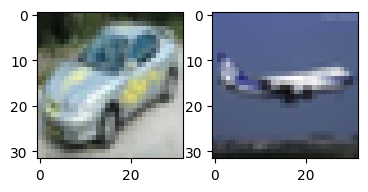

tensor([[[147, 139, 124,  ..., 142, 178, 168],
         [143, 180, 169,  ..., 162, 139, 169],
         [160, 135, 166,  ...,  90,  86,  77],
         ...,
         [155, 131, 161,  ...,  73,  70,  60],
         [142, 137, 117,  ..., 229,  53,  43],
         [ 16,  89,  80,  ..., 192, 165, 170]],

        [[162, 138, 163,  ...,  68,  67,  57],
         [133, 128, 109,  ...,  32,  71,  61],
         [ 35,  89,  80,  ...,  18, 248, 245],
         ...,
         [206,  66,  65,  ..., 180, 173, 202],
         [200, 191, 213,  ..., 111, 107, 103],
         [131, 125, 104,  ..., 103, 150, 151]],

        [[146,  13,  12,  ...,  51,  43,  80],
         [ 78,  68,  92,  ...,  89,  87,  79],
         [132, 127, 106,  ..., 115, 104, 104],
         ...,
         [ 97, 103,  44,  ..., 144, 176, 181],
         [119, 149, 158,  ..., 125,  46, 118],
         [127,  50, 121,  ..., 110, 117,  44]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


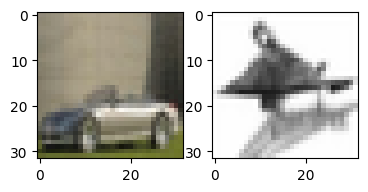

tensor([[[122, 111,  73,  ...,  77, 128, 114],
         [ 77, 129, 114,  ..., 117,  78, 132],
         [118,  77, 132,  ..., 126, 115,  76],
         ...,
         [148, 106, 170,  ..., 146, 124,  96],
         [134, 117,  75,  ...,  94, 128, 115],
         [ 92, 130, 119,  ..., 153, 116, 169]],

        [[153, 111, 171,  ..., 152, 131, 103],
         [157, 135,  93,  ...,  54, 111, 107],
         [103, 160, 156,  ..., 210, 175, 204],
         ...,
         [ 95,  58,  71,  ..., 236, 205,   9],
         [254, 227,  84,  ..., 208, 194, 155],
         [  7, 241, 196,  ..., 203, 145, 158]],

        [[160, 105, 119,  ...,  92,  72, 128],
         [134, 116, 143,  ..., 210, 197, 158],
         [ 46,  27, 240,  ..., 191, 112, 127],
         ...,
         [215, 218, 177,  ..., 223, 234, 241],
         [227, 228, 232,  ..., 237, 231, 214],
         [219, 213, 209,  ..., 214, 211, 172]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


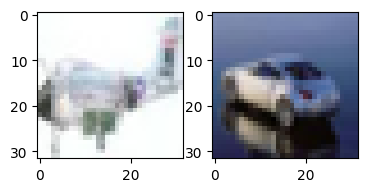

tensor([[[ 15, 251, 250,  ..., 246,  12, 247],
         [246,  11, 248,  ..., 244, 245,   7],
         [243, 246,   7,  ..., 254, 235, 240],
         ...,
         [ 29,  42,  12,  ..., 220, 209, 212],
         [233, 218, 223,  ...,  49,  34,  47],
         [ 50,  46,  55,  ...,  31,  45,  19]],

        [[ 38,  56,  20,  ..., 216, 207, 209],
         [225, 214, 219,  ...,  28,   1, 246],
         [233, 227, 215,  ..., 172, 174, 205],
         ...,
         [168,  35, 245,  ..., 188, 190, 252],
         [230, 220, 254,  ..., 185, 167, 168],
         [190, 181, 182,  ...,  89, 172, 130]],

        [[ 84, 201, 159,  ..., 131, 127, 218],
         [185, 162, 241,  ..., 184, 164, 165],
         [188, 175, 177,  ...,  87, 158, 120],
         ...,
         [181, 147, 149,  ..., 103, 161, 124],
         [100, 166, 132,  ...,  75,  58, 111],
         [ 91,  77, 108,  ..., 179, 152, 152]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


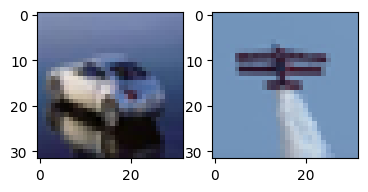

tensor([[[ 90,  78,  71,  ..., 197, 160, 166],
         [175, 111, 124,  ..., 216, 217, 237],
         [237, 237, 237,  ..., 211, 211, 211],
         ...,
         [186, 174, 167,  ..., 140, 140, 150],
         [ 37,  32,  59,  ...,   4, 182, 188],
         [189, 170, 153,  ..., 188, 168, 186]],

        [[192, 174, 153,  ..., 171, 152, 165],
         [ 93,  92, 120,  ..., 232, 179, 155],
         [147, 204, 144,  ..., 180, 165, 227],
         ...,
         [ 27,  20,   9,  ...,  27,   3, 241],
         [232, 223, 189,  ..., 241, 222, 220],
         [ 69,  93,  90,  ...,  82,  52,  48]],

        [[ 24,   6, 248,  ..., 245, 233, 234],
         [217, 203, 201,  ..., 239, 214, 205],
         [ 76,  98,  91,  ...,  79,  66,  60],
         ...,
         [ 64,  82,  76,  ...,  36,  30,  33],
         [ 33,  30,  32,  ..., 180, 168,   0],
         [172, 154,   6,  ...,  20, 241, 209]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


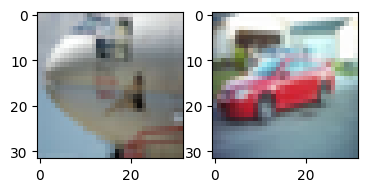

tensor([[[167, 166, 171,  ..., 177, 194, 180],
         [172, 218, 198,  ..., 194, 169, 218],
         [204, 169, 222,  ..., 168, 167, 170],
         ...,
         [194, 197, 156,  ..., 169, 169, 162],
         [174, 169, 164,  ..., 168, 166, 167],
         [158, 170, 166,  ..., 193, 201, 176]],

        [[189, 206, 153,  ..., 178, 178, 169],
         [170, 166, 149,  ..., 161, 146, 152],
         [142, 146, 148,  ..., 183, 184, 161],
         ...,
         [ 34,  29,  61,  ..., 146, 118, 168],
         [145, 121, 163,  ...,  89,  80,  82],
         [176, 137,  74,  ...,  22,  25,  59]],

        [[ 93,  44,  74,  ..., 150, 112, 170],
         [145, 111, 155,  ...,  91,  83,  80],
         [188, 152,  76,  ...,  26,  14,  47],
         ...,
         [250, 242, 237,  ..., 232, 209, 211],
         [231, 210, 212,  ..., 216, 231, 217],
         [214, 228, 216,  ...,  13, 251, 249]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


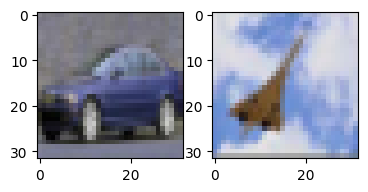

tensor([[[153, 145, 130,  ..., 143, 179, 169],
         [144, 180, 169,  ..., 167, 144, 174],
         [165, 140, 171,  ...,  94,  90,  81],
         ...,
         [161, 137, 167,  ..., 173, 170, 160],
         [146, 141, 121,  ..., 143, 180, 170],
         [143, 185, 176,  ...,   7, 236, 220]],

        [[212, 188, 246,  ..., 248, 247, 237],
         [137, 132, 113,  ..., 214, 255, 245],
         [219,   9,   0,  ...,  98,  72,  97],
         ...,
         [220, 205, 204,  ..., 153, 146, 157],
         [155, 146, 158,  ...,  79,  75,  71],
         [222, 216, 195,  ..., 186, 209, 210]],

        [[205, 240, 239,  ..., 192, 184, 226],
         [224, 214, 235,  ..., 161, 159, 151],
         [211, 206, 185,  ..., 179, 160, 160],
         ...,
         [117, 123,  64,  ...,  69, 126, 131],
         [ 69, 130, 139,  ..., 146,  67, 137],
         [146,  69, 145,  ..., 160, 167,  94]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


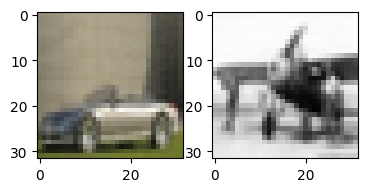

tensor([[[ 46,  32,  67,  ..., 122, 157, 136],
         [120, 230, 203,  ...,   6, 203,  83],
         [ 37, 237, 105,  ...,  97,  56, 255],
         ...,
         [254, 255,  22,  ..., 159, 144, 176],
         [ 85,  51,  69,  ..., 191, 225, 217],
         [223, 221, 214,  ..., 253, 249,  32]],

        [[ 23,  16,  43,  ..., 138, 125, 154],
         [ 38,  15,  42,  ..., 225,   3, 255],
         [  0,  18,  14,  ...,  55,  48,  75],
         ...,
         [ 11, 239, 253,  ...,  77,  93,  67],
         [ 83,  97,  62,  ..., 250, 252,  11],
         [150, 153, 164,  ...,  26, 254, 255]],

        [[ 33, 219, 226,  ...,  80,  95,  37],
         [ 51,  70,  48,  ..., 245, 246,  12],
         [156, 160, 172,  ...,  88,  12,  18],
         ...,
         [193, 188, 204,  ..., 210, 205, 201],
         [220, 215, 212,  ..., 173, 197, 179],
         [178, 198, 183,  ..., 204, 199, 218]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


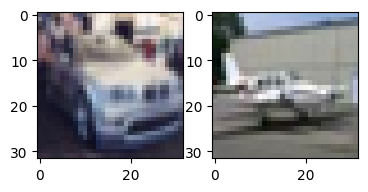

tensor([[[252, 254, 206,  ...,  89, 172, 148],
         [ 88, 172, 148,  ..., 147,  89, 173],
         [146,  91, 173,  ..., 172, 147,  90],
         ...,
         [ 60,  49, 117,  ..., 154, 129,  66],
         [ 36,  26, 207,  ..., 227, 121,  94],
         [ 32, 132, 128,  ...,  50,  42,  96]],

        [[ 77,  58, 141,  ..., 115, 110,  42],
         [238, 222, 147,  ..., 233, 110, 115],
         [ 57,  87, 128,  ...,  81,  71,  68],
         ...,
         [200, 251, 249,  ..., 215, 159, 253],
         [229, 168, 255,  ...,  29,  29, 233],
         [237, 216, 182,  ..., 139, 230, 216]],

        [[188, 235, 237,  ...,  19, 209,  36],
         [ 24, 217,  41,  ...,  27,  26, 231],
         [227, 212, 182,  ..., 139, 192, 180],
         ...,
         [241, 226, 195,  ..., 238,  23,  26],
         [243,  25,  29,  ...,  34, 247,  31],
         [ 35, 248,  28,  ..., 249, 251, 209]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


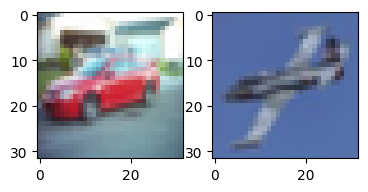

tensor([[[167, 166, 165,  ..., 165, 159, 158],
         [163, 154, 154,  ..., 138, 147, 143],
         [144, 146, 142,  ..., 141, 141, 144],
         ...,
         [184, 209, 142,  ..., 131, 137, 146],
         [163, 166, 166,  ..., 171, 148, 157],
         [162, 150, 194,  ..., 175, 204, 150]],

        [[176, 208, 125,  ..., 148, 153, 155],
         [164, 165, 161,  ..., 151, 124, 149],
         [155, 147, 212,  ..., 160, 188, 147],
         ...,
         [246,  88, 100,  ..., 244,   0, 242],
         [250, 254, 237,  ..., 109,  97, 174],
         [107,  93, 153,  ..., 208,  80,  92]],

        [[ 48,  31,  34,  ..., 207, 229, 223],
         [230, 238, 195,  ..., 111,  96, 175],
         [116, 108, 144,  ..., 218,  75,  83],
         ...,
         [229, 214,  34,  ...,  19, 210, 204],
         [ 20, 215, 206,  ..., 201,  19, 206],
         [198,  16, 212,  ..., 206, 193,   9]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


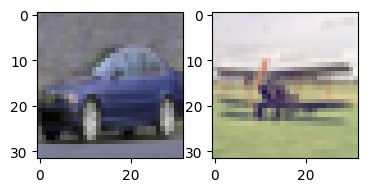

tensor([[[189, 101, 175,  ..., 188, 204, 156],
         [198, 212, 170,  ..., 180, 209, 162],
         [115, 159, 170,  ..., 225, 135, 207],
         ...,
         [121, 125,  69,  ..., 194, 162, 193],
         [133,  95, 125,  ..., 127, 167, 150],
         [153, 175, 160,  ...,  81,  82,  41]],

        [[ 34,  35,  23,  ..., 211, 201, 214],
         [122, 101, 119,  ...,  73, 124, 110],
         [112, 162, 150,  ...,  18,  17,  20],
         ...,
         [240, 228, 225,  ..., 203, 201, 173],
         [171, 169, 181,  ...,  23,   5,  13],
         [ 55,  28,  49,  ...,  12,   8,   7]],

        [[  8,   4,   3,  ...,  21,  19, 210],
         [209, 207, 208,  ...,  69,  43,  55],
         [ 71,  26,  62,  ...,  23,   3,   1],
         ...,
         [104,  13,  86,  ...,  68,  78,  55],
         [ 76,  86,  72,  ..., 138, 146, 143],
         [124, 139, 134,  ..., 134,  44, 116]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


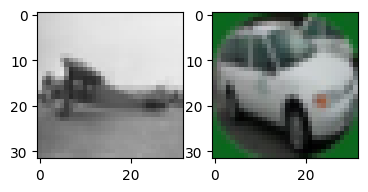

tensor([[[195, 184, 177,  ..., 188, 202, 200],
         [184, 209, 202,  ..., 196, 190, 192],
         [196, 186, 191,  ...,  37, 244, 199],
         ...,
         [ 75,  39,  80,  ...,  37, 245, 198],
         [234, 199, 175,  ...,  37, 145, 104],
         [ 63, 153, 126,  ...,   4, 221,  18]],

        [[250, 204,   6,  ..., 248, 218, 187],
         [239, 203, 176,  ...,  85, 164, 128],
         [ 90, 142, 106,  ...,   1, 212,  22],
         ...,
         [ 48,  80,  47,  ...,  26,   1, 100],
         [ 47,  20,  88,  ...,  51,  28,  22],
         [241, 219, 206,  ...,  29, 134, 107]],

        [[ 78,  46,  11,  ...,  63,  44, 117],
         [ 84,  62, 124,  ...,  66,  43,  30],
         [ 26,   0, 238,  ...,  66, 128,  91],
         ...,
         [230, 220,  15,  ...,  74,   0, 241],
         [ 25, 222, 206,  ...,  35,  73,  41],
         [ 36,  72,  43,  ...,  43,  24,  60]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


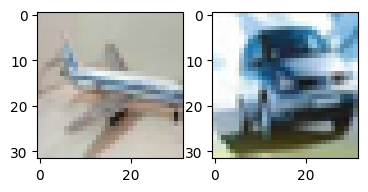

tensor([[[ 83, 114, 103,  ...,  97, 109, 127],
         [121,  97, 120,  ...,  95,  90,  84],
         [114, 109, 128,  ...,  77, 135, 140],
         ...,
         [168, 149, 134,  ...,   0,  30,  45],
         [121, 145, 126,  ..., 108,  93, 111],
         [ 97,  88, 101,  ...,  89,  83,  86]],

        [[107,  98,  80,  ...,   5,  37,  55],
         [124, 152, 132,  ..., 142, 139, 158],
         [138, 124, 139,  ...,   0, 247,  41],
         ...,
         [216, 234, 232,  ...,  49,  51,  49],
         [ 68,  68,  72,  ..., 228, 226,  15],
         [ 37,  56,  48,  ..., 247, 233, 232]],

        [[219, 234, 232,  ..., 116, 116,  81],
         [123, 119,  76,  ..., 224, 222,   1],
         [ 36,  52,  35,  ..., 249, 241, 243],
         ...,
         [139, 170, 187,  ..., 200, 130, 163],
         [199, 117, 153,  ..., 126, 172,  99],
         [125, 166,  97,  ..., 109, 139, 178]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


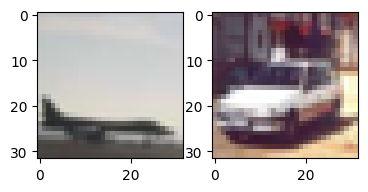

tensor([[[254, 221, 175,  ..., 168, 220, 206],
         [160, 228, 212,  ..., 193, 153, 219],
         [209, 164, 216,  ..., 238, 222, 182],
         ...,
         [  1, 227,  20,  ..., 229, 203, 156],
         [ 43,   9, 202,  ..., 138,  32, 253],
         [155,  49,  13,  ..., 198, 186,  27]],

        [[  6, 237, 249,  ..., 225, 202, 153],
         [ 37,   3, 197,  ..., 134, 241, 207],
         [128,  25, 251,  ..., 194, 184, 232],
         ...,
         [137, 206, 213,  ..., 167,  79, 146],
         [131,  47, 131,  ..., 219, 207, 178],
         [161, 155, 125,  ..., 119, 126, 127]],

        [[108, 160, 161,  ..., 131,   9, 108],
         [ 84, 218, 108,  ..., 219, 206, 177],
         [154, 149, 118,  ..., 166, 179, 175],
         ...,
         [209, 194, 165,  ..., 161, 200, 185],
         [161, 200, 183,  ..., 162, 124, 139],
         [128, 100, 177,  ..., 227, 209, 187]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


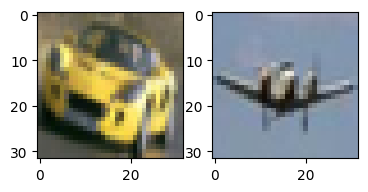

tensor([[[ 19, 250, 172,  ..., 174,  22,   1],
         [173,  38,  15,  ..., 202, 130, 253],
         [210, 138, 254,  ..., 221, 176, 110],
         ...,
         [ 53,   9,  21,  ..., 172, 127,  67],
         [223, 170,  95,  ...,  58, 165, 150],
         [ 81, 182, 169,  ..., 141,  71, 156]],

        [[138,  71, 137,  ..., 166, 121,  61],
         [213, 161,  91,  ..., 126, 158, 152],
         [110, 173, 170,  ..., 122,  49, 118],
         ...,
         [ 70, 133, 115,  ...,  99,  78, 105],
         [ 94,  75, 101,  ...,  66,  47,  33],
         [203, 184, 152,  ...,  29,  78,  66]],

        [[ 40,  85,  73,  ...,  98,  77, 123],
         [115, 102, 122,  ..., 136, 104,  73],
         [ 39,  28,   1,  ...,  31,  90,  80],
         ...,
         [225,   1,  28,  ...,  20,   8,  22],
         [ 29,  19,  25,  ...,  41,  48,  21],
         [ 19,  27,  23,  ...,   3,   5,  13]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


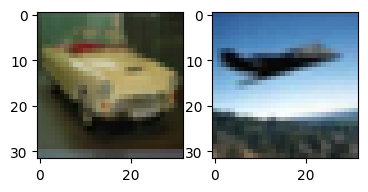

tensor([[[116, 204, 130,  ..., 157, 143, 191],
         [149, 133, 175,  ..., 167, 138, 187],
         [234, 190, 179,  ..., 121, 211, 139],
         ...,
         [194, 190, 254,  ..., 127, 159, 128],
         [161, 199, 169,  ..., 172, 158, 175],
         [172, 156, 171,  ..., 237, 236,  21]],

        [[ 28,  27,  38,  ..., 109, 119, 106],
         [174, 195, 177,  ..., 133, 128, 142],
         [140, 142, 154,  ...,  39,  40,  37],
         ...,
         [202, 202, 205,  ..., 205, 207, 238],
         [240, 242, 225,  ..., 111, 129, 121],
         [160, 187, 166,  ..., 184, 186, 187]],

        [[186, 191, 192,  ..., 164, 166, 222],
         [223, 225, 217,  ..., 107, 133, 121],
         [141, 186, 150,  ..., 131, 166, 168],
         ...,
         [ 90, 181, 108,  ..., 144, 135, 158],
         [137, 120, 134,  ...,  91,  83,  77],
         [ 96,  81,  98,  ...,  56, 146,  74]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


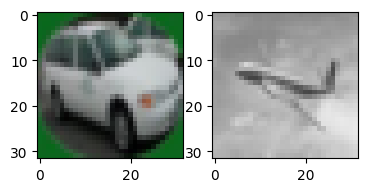

tensor([[[126, 186,  73,  ...,  84, 138, 158],
         [ 77, 129, 143,  ..., 135,  67, 183],
         [202, 119, 175,  ..., 126, 188,  77],
         ...,
         [186, 145,   9,  ..., 148, 152,  84],
         [173, 182, 115,  ..., 112, 155, 143],
         [107, 154, 140,  ..., 225, 186,  36]],

        [[ 15, 233,  53,  ..., 128, 111,  61],
         [185, 177, 124,  ..., 106, 153, 136],
         [ 98, 152, 132,  ...,  29, 248,  59],
         ...,
         [168, 232, 209,  ..., 236, 213, 111],
         [ 99,  82,  18,  ..., 174, 165, 127],
         [166, 166, 116,  ..., 149, 212, 185]],

        [[152, 218, 190,  ..., 193, 172,  98],
         [ 86,  71,  44,  ..., 172, 171, 129],
         [148, 166, 101,  ..., 105, 187, 162],
         ...,
         [181,   5, 185,  ..., 111, 153, 150],
         [102, 149, 137,  ...,  88,  53, 111],
         [104,  62, 127,  ..., 111, 175,  76]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


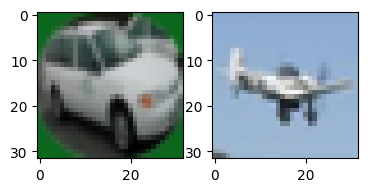

tensor([[[222, 223, 122,  ..., 144, 233, 230],
         [135, 242, 238,  ...,   9, 157,  15],
         [  9, 153,  15,  ..., 253, 242, 157],
         ...,
         [195, 135,  59,  ...,  46,  35, 183],
         [ 14,  10, 155,  ..., 191,   5, 170],
         [129,  81, 166,  ..., 189, 126, 140]],

        [[207, 147, 134,  ...,  49,  35, 184],
         [ 17,   8, 161,  ..., 169, 102, 204],
         [170, 154, 229,  ..., 252, 190, 170],
         ...,
         [213, 227, 250,  ...,  21, 144, 112],
         [ 87, 165, 124,  ...,  76,  72, 220],
         [ 59,  44, 195,  ...,  40,  90, 108]],

        [[ 41,  63,  80,  ...,  33, 196,  77],
         [ 69, 201, 119,  ...,  72,  72, 218],
         [ 65,  50, 205,  ...,  42, 102, 116],
         ...,
         [ 65,  71, 231,  ...,  20,  96, 109],
         [ 33,  89, 100,  ..., 106,  36,  71],
         [ 81,  18,  72,  ...,  30,  28, 206]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


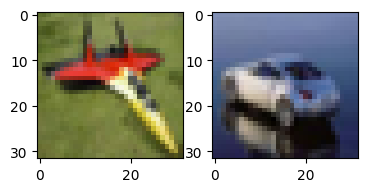

tensor([[[199, 236, 104,  ..., 113, 208, 204],
         [105, 200, 190,  ..., 183,  97, 254],
         [250, 149, 247,  ..., 198, 237, 108],
         ...,
         [236, 175,  84,  ..., 225, 202, 114],
         [249, 235, 147,  ..., 140, 231, 195],
         [135, 230, 192,  ...,  20, 217, 113]],

        [[ 66,   8, 129,  ..., 207, 162,  92],
         [  6, 230, 154,  ..., 136, 227, 188],
         [129, 226, 185,  ...,  76,  26, 132],
         ...,
         [201,  56,   8,  ..., 210, 180,  34],
         [251, 214,  24,  ...,   0, 222, 156],
         [250, 225, 147,  ..., 180,  38, 243]],

        [[184,  42, 248,  ..., 156, 125,  21],
         [239, 203, 255,  ..., 255, 229, 159],
         [232, 224, 131,  ..., 135,  14, 220],
         ...,
         [196, 234, 106,  ..., 141, 237, 209],
         [131, 234, 196,  ..., 146,  83, 200],
         [166,  94, 187,  ..., 198, 235, 106]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


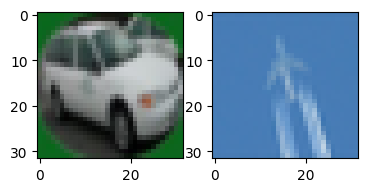

tensor([[[167, 159, 174,  ..., 183, 146, 147],
         [170, 125, 121,  ..., 118, 143, 133],
         [120, 148, 136,  ...,  12,   8,   4],
         ...,
         [153, 173, 171,  ..., 255, 250, 252],
         [202, 191, 199,  ..., 185, 176, 172],
         [187, 161, 156,  ..., 155, 175, 163]],

        [[157, 173, 166,  ..., 255, 245, 244],
         [210, 199, 202,  ..., 189, 186, 181],
         [189, 185, 179,  ..., 168, 177, 177],
         ...,
         [199, 228, 214,  ..., 161, 162, 159],
         [145, 148, 205,  ..., 113, 122, 151],
         [235, 223, 230,  ..., 247,   1, 238]],

        [[231, 237, 220,  ..., 126, 126,  93],
         [ 78,  81, 106,  ..., 104, 112, 139],
         [  3, 243,   1,  ...,   2,  51,  32],
         ...,
         [ 74,  59, 114,  ..., 158, 115,  99],
         [158, 112,  93,  ...,  88, 162, 104],
         [ 86, 157, 101,  ..., 108,  92, 160]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


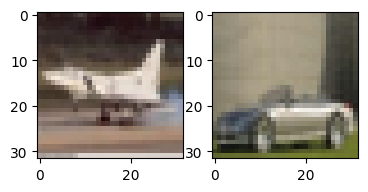

tensor([[[  6,  63, 104,  ..., 122,  17,  74],
         [120,  18,  75,  ..., 108, 142,  34],
         [ 80, 116,  10,  ...,  27,  90, 138],
         ...,
         [158, 151, 110,  ..., 207,   3,  58],
         [ 37,  75, 122,  ...,  48,  51,  47],
         [ 51, 108, 107,  ...,  51,  71, 148]],

        [[159, 158, 108,  ..., 224,  19,  75],
         [ 65,  99, 141,  ...,  40,  66,  55],
         [ 63, 153, 111,  ...,  11,  15, 142],
         ...,
         [218, 216, 196,  ..., 253, 239,  83],
         [ 84,  69, 128,  ..., 101, 105, 106],
         [ 91,  81,  74,  ..., 143, 186, 169]],

        [[153, 176, 153,  ...,  20,   4,  80],
         [ 85,  72,  89,  ..., 108, 116, 113],
         [118, 114, 103,  ...,  91, 143, 126],
         ...,
         [ 76,  94,  90,  ...,  93,  95, 101],
         [ 95,  94, 101,  ..., 122, 115, 112],
         [123, 116, 105,  ...,  93, 106, 103]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


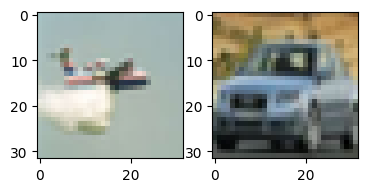

tensor([[[ 61,  74,  92,  ...,  90,  78,  82],
         [ 96,  72,  82,  ...,  82,  92,  79],
         [ 80,  96,  76,  ..., 236,  34,  84],
         ...,
         [177, 220, 198,  ..., 237,  37,  94],
         [ 48,  76, 103,  ..., 244, 145, 175],
         [215, 128, 158,  ..., 241,  40,  77]],

        [[ 79, 122,  54,  ...,  28,  66, 108],
         [ 46,  73, 106,  ..., 215, 118, 148],
         [190, 116, 161,  ...,   7,  85, 200],
         ...,
         [235, 196, 224,  ..., 238,  14, 170],
         [193, 226, 193,  ..., 178, 197, 218],
         [ 55,  70,  95,  ...,  17, 159, 185]],

        [[222, 221, 253,  ..., 152, 176, 135],
         [144, 170, 138,  ..., 201, 218, 239],
         [ 16,  36,  66,  ..., 238, 140, 169],
         ...,
         [ 81,  93,  56,  ..., 246,  25,  40],
         [  6,  46,  56,  ...,  31,   2,  23],
         [ 31,   3,  22,  ...,  16,  34,  10]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


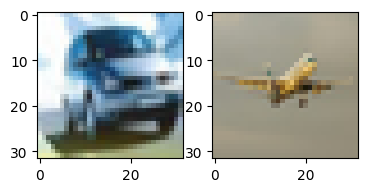

tensor([[[184, 149, 109,  ...,  94, 198, 150],
         [104, 189, 147,  ..., 123,  81, 177],
         [132,  92, 186,  ...,  58,  78,  83],
         ...,
         [249, 239,  41,  ...,  47,  56,  60],
         [107, 109, 100,  ..., 240, 223, 217],
         [204, 194, 190,  ...,  19,  26,  59]],

        [[ 57,  58, 117,  ...,  84,  75,  62],
         [ 61,  70,  69,  ..., 173, 118, 130],
         [133, 111, 137,  ...,   7,  24,  37],
         ...,
         [229,  32,  16,  ...,  13, 238,  18],
         [249, 212,  33,  ..., 255, 227, 199],
         [148, 121,  91,  ...,  11,   0, 234]],

        [[211,  65,  48,  ..., 212, 171, 241],
         [200, 152, 234,  ...,  32,   4, 233],
         [ 91,  67,  43,  ..., 231, 241, 221],
         ...,
         [158, 136,  51,  ..., 219,  39,  36],
         [225,  54,  44,  ...,  97,   1, 144],
         [101,   5, 130,  ...,  73,  55, 245]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


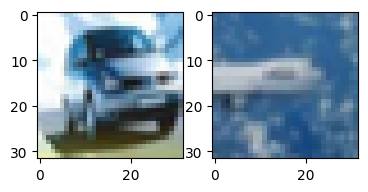

tensor([[[152, 159, 172,  ...,  70, 100,  82],
         [ 78, 105,  87,  ..., 100,  89, 126],
         [108,  98, 133,  ..., 154, 138, 113],
         ...,
         [ 95,  88, 117,  ..., 154, 145, 116],
         [227, 233, 204,  ..., 244,  84,  70],
         [ 57,  94, 104,  ...,  63,  81,  91]],

        [[ 83,  87, 127,  ..., 121, 128,  92],
         [174, 176, 146,  ...,   8,  75,  96],
         [ 94,  50, 107,  ...,  82,  99,  41],
         ...,
         [242,  25,  28,  ..., 231, 220,   4],
         [247, 225,   7,  ...,  58,  68,  49],
         [208, 206, 216,  ..., 180, 252, 241]],

        [[240,  43,  44,  ...,  37,  19,  49],
         [ 45,  23,  55,  ...,  57,  66,  48],
         [205, 205, 218,  ..., 180, 243, 232],
         ...,
         [243, 241, 252,  ...,  51,  44,  57],
         [ 59,  47,  61,  ...,  78,  70,  62],
         [ 80,  72,  60,  ...,  34,  46,  35]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


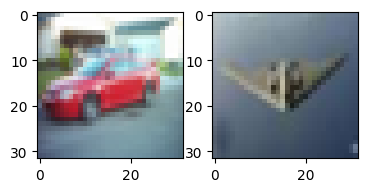

tensor([[[161, 155, 165,  ..., 172, 161, 156],
         [171, 152, 147,  ..., 134, 141, 149],
         [140, 145, 146,  ..., 128, 127, 135],
         ...,
         [222,  22, 198,  ..., 158, 148, 148],
         [233, 217, 213,  ..., 219, 225, 229],
         [235, 188, 196,  ..., 212,  17, 196]],

        [[236,  45, 227,  ..., 168, 158, 156],
         [228, 212, 199,  ..., 246, 255,  12],
         [ 18, 243,   2,  ..., 156, 219, 160],
         ...,
         [ 52,  37,  54,  ..., 108, 163,  92],
         [109, 165,  78,  ...,  77,  63,  76],
         [185, 183, 185,  ...,  13, 240,   6]],

        [[ 35,  11,  29,  ...,  70, 119,  76],
         [ 95, 150,  70,  ...,  82,  70,  78],
         [230, 230, 218,  ..., 205, 210, 234],
         ...,
         [193, 184, 202,  ..., 178, 176, 171],
         [169, 169, 164,  ..., 199, 208, 215],
         [206, 221, 219,  ..., 222, 205, 216]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


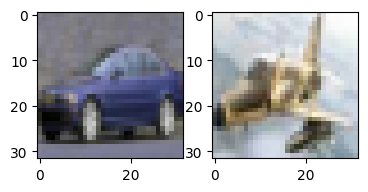

tensor([[[114,  55,   1,  ..., 251, 109,  38],
         [  0, 103,  36,  ...,  33, 249, 111],
         [ 31, 253, 110,  ..., 255, 230, 231],
         ...,
         [124, 135, 178,  ..., 209, 203, 228],
         [ 32,   5, 248,  ..., 243, 218, 199],
         [202, 199, 178,  ..., 194, 208, 238]],

        [[207, 227, 252,  ..., 249, 231, 239],
         [ 25,   1, 250,  ...,  13, 239, 231],
         [233, 254,   1,  ..., 250,  13,  31],
         ...,
         [ 15,  26,  33,  ...,  20,  26,   2],
         [  6,  11,  22,  ..., 247, 244, 230],
         [106, 104, 110,  ...,  45, 236, 239]],

        [[249,  40,  48,  ..., 197, 200, 201],
         [188, 189, 203,  ...,   5,   2, 248],
         [ 81,  85,  93,  ...,  10, 215, 221],
         ...,
         [149, 144,  77,  ...,  13, 100,  91],
         [ 29, 121, 107,  ...,  78,  18,  94],
         [ 77,  18,  93,  ...,  80,  75,  17]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


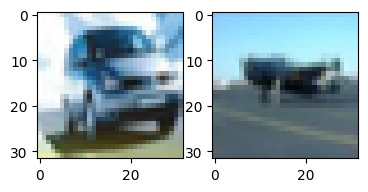

tensor([[[151,  86,  32,  ...,  28, 145,  75],
         [ 23, 144,  76,  ...,  78,  27, 148],
         [ 78,  27, 147,  ...,  66,  38,  14],
         ...,
         [145, 114,  47,  ...,  62,  36,  14],
         [141,  74,  22,  ..., 179, 243, 155],
         [141,  11,  90,  ...,  96,  70,  19]],

        [[ 84,  63,  19,  ...,  61,  35,  14],
         [139,  73,  24,  ...,  86, 174,  47],
         [ 41,   3,  87,  ..., 101,  76,  10],
         ...,
         [254, 130, 115,  ..., 103,  71, 147],
         [103,  68, 151,  ...,  46,  27,  13],
         [118,  63,  34,  ..., 109, 211, 174]],

        [[157, 129, 120,  ...,  97,  69, 151],
         [ 99,  67, 154,  ...,  47,  28,  14],
         [118,  64,  35,  ..., 148, 136, 118],
         ...,
         [109,  59,  28,  ...,  30,  93,  52],
         [ 32,  89,  47,  ...,  40,  18,  74],
         [ 41,  19,  73,  ...,  45,  27,  14]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


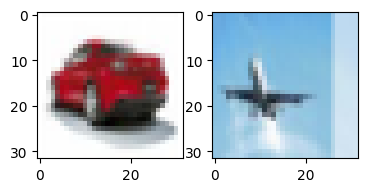

tensor([[[ 57,  95, 174,  ..., 172,  36,  90],
         [175,  38,  87,  ...,  96, 170,  31],
         [ 78, 155,  35,  ..., 118, 126, 170],
         ...,
         [ 62, 151,  30,  ...,   4,  15,  63],
         [ 10,  41, 110,  ..., 159,  75, 107],
         [141, 109, 124,  ...,  70, 144,  33]],

        [[ 72, 157,  18,  ..., 254,   7,  58],
         [ 13,  48, 118,  ..., 145,  82, 107],
         [140, 126, 139,  ..., 114, 165,  67],
         ...,
         [ 62, 201, 229,  ..., 236,  19,   9],
         [ 23,  54,  72,  ..., 233, 234, 250],
         [170, 194, 255,  ..., 115, 227,   7]],

        [[ 59, 197, 222,  ..., 234,  21,  36],
         [ 56,  93,  51,  ..., 217, 231,   3],
         [170, 188, 243,  ..., 115,  32,  50],
         ...,
         [ 78,  79,  99,  ...,  85,  57,  61],
         [ 83,  54,  59,  ...,  61,  83,  62],
         [ 66,  91,  65,  ...,  88,  87, 108]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


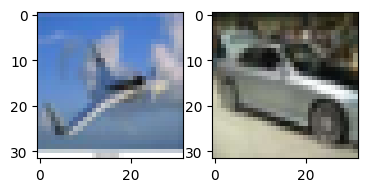

tensor([[[ 68,  83, 106,  ..., 109,  63,  76],
         [109,  62,  76,  ...,  57,  86,  54],
         [ 67,  98,  71,  ..., 148, 155, 169],
         ...,
         [ 92, 121,  82,  ..., 165, 171, 186],
         [ 85,  93, 122,  ..., 111,  65,  78],
         [112,  61,  74,  ...,  85, 117,  80]],

        [[ 91, 120,  78,  ..., 169, 173, 188],
         [ 96, 103, 134,  ..., 113,  68,  80],
         [112,  65,  76,  ...,  80, 110,  73],
         ...,
         [ 65,  29,  42,  ..., 118, 144, 108],
         [123, 153, 146,  ..., 159, 182, 199],
         [ 31,  43,  65,  ..., 100,  71,  77]],

        [[ 77,  15,  23,  ...,  87, 106,  99],
         [109, 124, 168,  ..., 116, 127, 135],
         [247, 245, 247,  ...,   7,  42,  43],
         ...,
         [ 11, 254,  13,  ...,  23,  18,   1],
         [ 23,  20, 255,  ..., 240,  22,   2],
         [239,  17,   1,  ...,   0, 240,  21]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


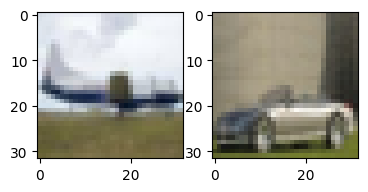

tensor([[[ 66,  81,  65,  ...,  77,  78, 103],
         [ 78,  97, 120,  ...,  57,  42,  60],
         [ 66,  51,  60,  ...,  30,  33,  24],
         ...,
         [121,  74,  92,  ...,  37,  41,  26],
         [ 50,  57,  33,  ..., 118, 189, 181],
         [123, 196, 187,  ..., 153,  83, 166]],

        [[149,  84, 156,  ...,  35,  42,  23],
         [ 48,  56,  35,  ..., 168, 197, 192],
         [151, 231, 225,  ..., 161, 100, 167],
         ...,
         [ 30,  70,  68,  ...,   1, 232,  15],
         [ 11, 243,  10,  ...,  35,  31,  18],
         [ 74,  83,  65,  ...,  70, 110, 111]],

        [[ 91, 134, 131,  ...,  59,  30,  93],
         [ 89,  68,  81,  ...,  39,  35,  21],
         [ 75,  84,  65,  ...,  21,  76,  74],
         ...,
         [ 93, 108, 113,  ...,  94,  87,  93],
         [ 90,  85,  91,  ...,  86,  85,  84],
         [ 85,  85,  84,  ...,  76,  81,  83]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


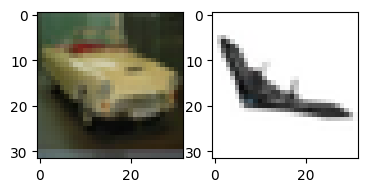

tensor([[[102, 113, 109,  ..., 116, 111, 121],
         [120,  41,  57,  ...,  22,  54, 229],
         [251,  21, 208,  ..., 235, 249,  15],
         ...,
         [186, 176, 194,  ..., 144, 158, 146],
         [100, 129, 131,  ..., 112,  21,  34],
         [ 53,  44,  56,  ..., 164, 161, 177]],

        [[168, 167, 208,  ..., 165, 176, 164],
         [147, 164, 159,  ...,  74,   0,   6],
         [ 26, 249, 254,  ..., 142, 147, 187],
         ...,
         [ 57, 131, 117,  ...,  38,  27,  48],
         [ 34,  23,  45,  ...,  93,  93,  84],
         [196, 198, 189,  ...,  10,  48,  44]],

        [[ 16, 153, 143,  ...,  54,  43,  77],
         [ 64,  50,  84,  ..., 121, 121, 110],
         [198, 200, 190,  ...,  21,  36,  26],
         ...,
         [178, 184, 172,  ..., 166, 163, 169],
         [156, 152, 157,  ..., 195, 180, 192],
         [194, 182, 191,  ..., 162, 166, 164]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


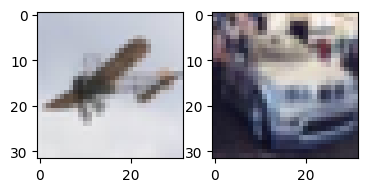

tensor([[[ 81, 104, 165,  ..., 154,  71,  84],
         [154,  52,  67,  ..., 130, 190,  89],
         [122, 180,  89,  ..., 116, 154, 206],
         ...,
         [ 69, 155,  60,  ..., 114, 147, 199],
         [ 99, 130, 199,  ..., 118, 221,  10],
         [113, 215,   5,  ...,  36, 149, 242]],

        [[ 41, 145, 252,  ..., 116, 146, 202],
         [101, 131, 197,  ...,  65, 217,   3],
         [ 89, 216,   3,  ...,  28, 132, 241],
         ...,
         [251, 173, 193,  ..., 186, 217, 183],
         [195, 235, 210,  ..., 119, 158, 209],
         [ 78, 106, 169,  ...,  18, 205, 223]],

        [[  6, 197, 218,  ..., 233,  26, 252],
         [ 17,  70,  37,  ..., 114, 154, 207],
         [ 77, 105, 169,  ..., 159,  30,  61],
         ...,
         [ 63,  83, 118,  ..., 137,  71,  97],
         [141,  73,  99,  ..., 104, 144,  74],
         [105, 144,  74,  ...,  80, 109, 145]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


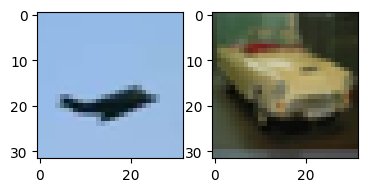

tensor([[[226, 181, 171,  ..., 184, 205, 163],
         [172, 189, 170,  ..., 156, 159, 195],
         [162, 155, 195,  ..., 185, 159, 164],
         ...,
         [217, 233, 217,  ..., 191, 162, 164],
         [198, 163, 154,  ..., 163, 197, 164],
         [153, 193, 166,  ..., 182, 204, 198]],

        [[189, 210, 182,  ..., 198, 171, 173],
         [196, 165, 141,  ..., 156, 175, 151],
         [141, 171, 149,  ..., 168, 188, 189],
         ...,
         [ 57, 136, 133,  ..., 244,  25, 251],
         [ 10,  48,  15,  ...,  86,  67,  84],
         [ 86,  57,  52,  ..., 227,  59,  54]],

        [[ 54, 122, 118,  ..., 211, 240, 223],
         [234,   7, 214,  ..., 149, 152, 178],
         [ 98,  72,  53,  ..., 134, 195, 182],
         ...,
         [106, 110, 141,  ..., 118,  68,  77],
         [ 98,  73,  80,  ...,  71,  93,  56],
         [ 66,  89,  76,  ...,  92, 105, 129]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


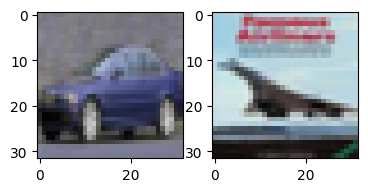

tensor([[[ 22, 226, 148,  ..., 162,  50, 252],
         [164,  51, 252,  ..., 246, 161,  44],
         [245, 158,  41,  ..., 228, 178, 107],
         ...,
         [ 59, 252,  34,  ..., 209, 160,  88],
         [ 15, 222, 141,  ..., 159,  44, 246],
         [158,  48, 251,  ..., 118,  70,  80]],

        [[ 36, 223,  34,  ..., 205, 158,  86],
         [  5, 215, 134,  ..., 160,  44, 246],
         [159,  47, 250,  ..., 116,  68,  67],
         ...,
         [149, 251, 205,  ...,   0, 190,  41],
         [254, 181,  37,  ..., 172, 124,  58],
         [  2, 211, 128,  ..., 125, 251, 208]],

        [[142,  16, 227,  ...,  69, 255, 119],
         [ 71,   2, 116,  ..., 183, 137,  67],
         [  3, 213, 130,  ..., 137, 229, 185],
         ...,
         [224, 189,  68,  ...,  75, 238, 201],
         [ 77, 239, 206,  ..., 211,  71, 249],
         [214,  76, 252,  ..., 245, 207,  72]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


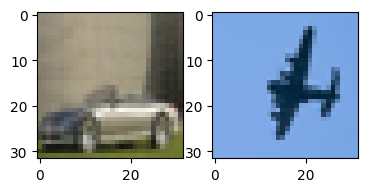

tensor([[[ 88,  75,  56,  ..., 171, 174, 176],
         [171, 174, 176,  ..., 174, 171, 172],
         [174, 171, 172,  ..., 172, 172, 170],
         ...,
         [223, 190, 214,  ..., 194, 188, 187],
         [ 54,  41,  53,  ...,  35, 226, 230],
         [228, 217, 197,  ...,   7, 213, 240]],

        [[236, 204, 203,  ..., 230, 208, 213],
         [110, 102, 112,  ...,  23, 237, 209],
         [200,   5, 197,  ..., 246, 200,  24],
         ...,
         [ 59,  65,  49,  ...,  98,  87,  27],
         [ 18,  12,  70,  ...,  58,  33,  12],
         [116, 110,  71,  ..., 120,  93,  90]],

        [[ 64,  45,  32,  ...,  49,  40,  47],
         [ 29,  21,  52,  ...,  61,  36,  18],
         [125, 115,  75,  ..., 123, 104,  99],
         ...,
         [113,  99,  60,  ...,  11,  74,  42],
         [  6,  72,  39,  ...,  31, 255,  66],
         [ 30, 254,  69,  ...,  99,  68,  37]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


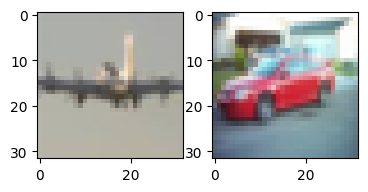

tensor([[[241, 204, 184,  ..., 183, 238, 201],
         [181, 237, 201,  ..., 201, 183, 237],
         [200, 184, 237,  ..., 225, 191, 177],
         ...,
         [165, 149, 193,  ..., 188, 161, 145],
         [205, 172, 158,  ..., 148, 220, 181],
         [155, 231, 190,  ..., 158, 141, 195]],

        [[159, 143, 194,  ..., 185, 159, 142],
         [195, 166, 152,  ..., 174, 206, 163],
         [130, 171, 125,  ..., 101,  82, 156],
         ...,
         [119,  35, 231,  ..., 166, 152, 218],
         [179, 154, 221,  ..., 154, 114, 101],
         [159, 131, 118,  ...,  27, 141,  75]],

        [[ 16, 168, 105,  ..., 135, 111, 187],
         [135,  96, 208,  ..., 153, 111,  98],
         [157, 125, 113,  ...,  23, 132,  65],
         ...,
         [142,  90,  84,  ...,  37, 119,  66],
         [ 33, 125,  74,  ...,  71,  29, 141],
         [ 88,  46, 147,  ..., 132,  94,  87]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


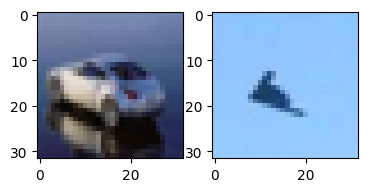

tensor([[[190, 195, 230,  ..., 236, 186, 196],
         [231, 193, 197,  ..., 192, 236, 173],
         [193, 233, 173,  ...,  28, 248, 255],
         ...,
         [ 66,  97,  48,  ...,  47,   9, 245],
         [225, 210, 234,  ...,  15,  43,  21],
         [ 17,  47,  27,  ..., 250,  23, 241]],

        [[238,   5, 232,  ..., 203, 182, 185],
         [229, 214, 235,  ...,  27,  53,  33],
         [ 26,  49,  13,  ..., 248,  11, 255],
         ...,
         [ 44,  53,  38,  ...,   8,  15,   3],
         [251, 255, 234,  ...,  89,  91, 135],
         [216, 220, 253,  ..., 186, 232, 224]],

        [[  4, 229, 205,  ..., 117, 145,  93],
         [ 99, 118,  44,  ...,  66,  71, 114],
         [  0, 254,  26,  ..., 235,  37,  27],
         ...,
         [173, 193,  50,  ..., 110, 229, 243],
         [ 93, 206, 229,  ...,   4,  98, 238],
         [  4,  97, 239,  ..., 244,   0,  93]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


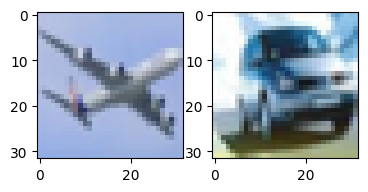

tensor([[[ 62, 112,  79,  ...,  77,  77, 114],
         [ 84,  69, 120,  ..., 114,  78,  59],
         [117,  77,  59,  ...,  55, 109,  71],
         ...,
         [ 33, 215,  50,  ..., 160, 140,  95],
         [ 88,  76,  21,  ...,  21, 169, 137],
         [ 78, 169, 140,  ..., 244, 175, 248]],

        [[247, 179,   4,  ..., 167, 144,  98],
         [ 53,  38, 235,  ...,  15, 175, 144],
         [ 78, 167, 142,  ...,  12, 204, 253],
         ...,
         [202, 234, 244,  ..., 213, 188, 236],
         [237, 195, 221,  ..., 106, 100,  69],
         [123, 136, 117,  ..., 214,  17,  23]],

        [[250,  15,  27,  ..., 162, 142, 189],
         [191, 159, 197,  ..., 135, 131, 116],
         [ 58,  69,  47,  ...,   8,  40,  54],
         ...,
         [215, 208, 224,  ..., 187, 158, 152],
         [164, 130, 124,  ..., 192, 203, 198],
         [193, 205, 204,  ..., 214, 206, 222]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


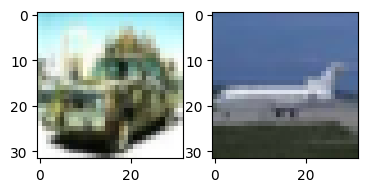

tensor([[[126, 113,  95,  ...,  85, 105, 100],
         [ 79, 116, 109,  ...,  93,  79, 117],
         [108,  88, 110,  ..., 132, 121, 101],
         ...,
         [165, 165, 144,  ..., 104,  98,  76],
         [173, 159, 127,  ..., 153, 218, 189],
         [ 96, 197, 172,  ..., 105, 129, 163]],

        [[159, 166, 117,  ..., 101,  97,  72],
         [166, 152, 119,  ..., 202,  55,  13],
         [164, 228, 193,  ...,  92, 125, 120],
         ...,
         [ 85,  70,  78,  ...,  53, 197,  46],
         [ 25, 206,  69,  ...,  99, 104, 103],
         [ 39,  50,  43,  ..., 143,  62,  57]],

        [[ 56,  30,  34,  ...,  68, 196,  72],
         [ 43, 198,  24,  ...,  99, 103, 104],
         [ 34,  46,  38,  ..., 181,  77,  72],
         ...,
         [ 86,  87,  81,  ...,  78,  79,  81],
         [ 77,  79,  79,  ...,  61,  44,  17],
         [ 25,  18,  54,  ..., 105, 104, 106]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


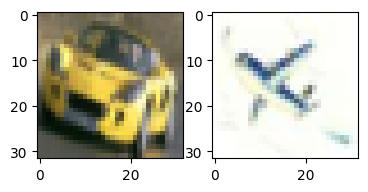

tensor([[[188,   4,  89,  ..., 128, 215,  35],
         [126, 216,  36,  ...,  70, 148, 229],
         [ 43, 123, 205,  ..., 219,  44, 135],
         ...,
         [124, 170,  51,  ..., 145, 219,  66],
         [222,  24, 119,  ...,  63, 250,  12],
         [ 66,  52,  71,  ...,  63, 123,  90]],

        [[128, 177,  47,  ..., 163, 236,  83],
         [251,  49, 139,  ...,  61,   9,  33],
         [ 99,  55,  81,  ...,  57, 123,  81],
         ...,
         [178,  80, 102,  ..., 128, 131,  12],
         [ 35,  61,  67,  ...,  33,  65, 117],
         [237,  11,  64,  ..., 123,  50,  83]],

        [[127,  39,  65,  ..., 141, 144, 219],
         [243,  13,  25,  ...,  40,  76, 125],
         [ 23,  55, 104,  ...,  82,  11,  41],
         ...,
         [ 15,  56, 103,  ..., 121,  37,  75],
         [123,  38,  77,  ...,  91, 139,  49],
         [ 91, 139,  41,  ...,  26,  65, 117]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


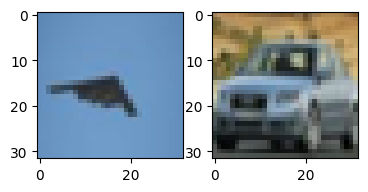

tensor([[[ 89,  94,  79,  ..., 115,  87,  98],
         [ 91, 106, 116,  ...,  65,  58,  52],
         [ 60,  53,  49,  ..., 152, 172, 168],
         ...,
         [120, 109,  85,  ..., 121, 145, 158],
         [107, 123,  98,  ...,  80,  59,  76],
         [ 81,  81, 102,  ..., 122, 125, 114]],

        [[134, 145,  67,  ...,  69,  85,  98],
         [109, 124,  98,  ...,  68,  58,  75],
         [ 84,  58,  77,  ..., 155, 178, 114],
         ...,
         [199, 214, 231,  ...,   6,   6, 235],
         [251, 255, 175,  ..., 175, 198, 202],
         [ 65,  63,  68,  ..., 231, 210, 227]],

        [[237, 211, 230,  ...,  19,  25,  23],
         [ 36,  45, 215,  ..., 214, 234, 246],
         [101,  99, 106,  ...,  11, 234, 252],
         ...,
         [142, 158, 163,  ..., 181, 161, 169],
         [183, 161, 170,  ..., 161, 135, 154],
         [154, 133, 156,  ..., 182, 182, 189]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


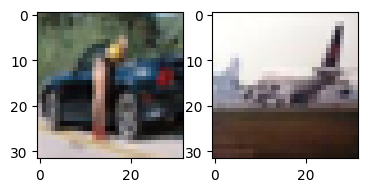

tensor([[[ 54,  43,  18,  ...,  31,  76,  72],
         [ 37,  82,  77,  ...,  78,  45,  83],
         [ 77,  54,  90,  ..., 104, 103,  90],
         ...,
         [ 31, 251,  63,  ...,  95,  90,  66],
         [231, 225, 212,  ...,  13,  60,  45],
         [ 19,  66,  49,  ...,  21, 236,  22]],

        [[  1, 227,  34,  ...,  83,  78,  55],
         [226, 221, 218,  ...,  22,  84,  66],
         [ 42,  93,  75,  ...,   0, 229,  28],
         ...,
         [ 56, 244, 246,  ...,  62,  20,  92],
         [ 76,  28, 103,  ..., 189, 185, 138],
         [ 59,  54,  42,  ...,  54, 251, 249]],

        [[250, 222, 220,  ...,  78,  41, 108],
         [ 93,  54, 115,  ..., 207, 202, 158],
         [ 54,  47,  48,  ...,  46,   3, 253],
         ...,
         [249, 229, 189,  ..., 198,   5, 244],
         [207, 248, 232,  ..., 252, 221,  17],
         [  8, 226,  53,  ..., 242, 237, 208]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


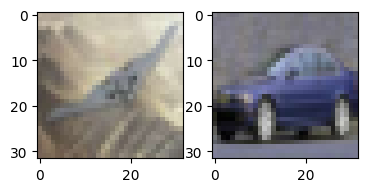

tensor([[[168, 139,  99,  ...,  74, 156, 123],
         [ 77, 155, 122,  ...,  94,  59, 165],
         [123,  84, 190,  ..., 193, 138,  61],
         ...,
         [ 46,  43,  80,  ...,   6, 226, 152],
         [148, 130,  81,  ..., 149, 133, 155],
         [144,  75,  96,  ..., 108,  89,  39]],

        [[ 44,  36,  84,  ..., 247, 213, 138],
         [119, 105,  61,  ..., 152, 114, 136],
         [116,  67,  88,  ..., 117,  97,  51],
         ...,
         [107, 120, 135,  ...,  58,  62, 233],
         [246, 249, 203,  ..., 175, 192, 185],
         [205, 222, 211,  ..., 178, 159, 177]],

        [[181, 184, 207,  ...,  49,  58, 238],
         [248, 251, 240,  ..., 163, 174, 166],
         [177, 193, 188,  ..., 219, 196, 214],
         ...,
         [253,   7,  10,  ...,  18, 246,   0],
         [ 20, 245,   0,  ..., 202, 194, 224],
         [221, 203, 236,  ..., 247, 252, 244]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


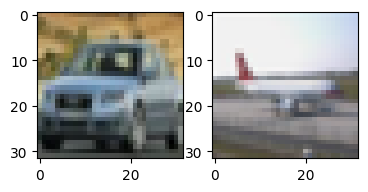

tensor([[[220, 197, 191,  ..., 184, 204, 182],
         [183, 202, 183,  ..., 171, 174, 199],
         [180, 174, 200,  ..., 211, 188, 182],
         ...,
         [209, 221, 187,  ..., 209, 185, 181],
         [214, 191, 182,  ...,  48, 207, 211],
         [248, 183, 184,  ..., 198, 217, 204]],

        [[205, 224, 187,  ..., 218, 194, 188],
         [210, 186, 167,  ...,  82, 247,  11],
         [ 68, 217, 237,  ..., 180, 198, 193],
         ...,
         [128, 251, 235,  ..., 101, 129, 114],
         [ 99, 126, 112,  ..., 109,  88, 106],
         [111,  90,  86,  ..., 121, 200, 183]],

        [[176, 250, 232,  ...,  96, 116, 108],
         [ 93, 114, 105,  ..., 115,  95, 108],
         [123, 105,  87,  ..., 108, 195, 177],
         ...,
         [217, 198, 222,  ..., 201, 206, 189],
         [200, 206, 189,  ..., 186, 198, 204],
         [187, 200, 203,  ..., 209, 191, 207]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


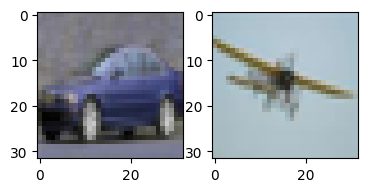

tensor([[[194, 215, 227,  ..., 111, 108, 114],
         [112, 108, 114,  ..., 114, 112, 108],
         [114, 112, 108,  ..., 107, 113, 111],
         ...,
         [ 44,  54,  59,  ...,  62,  75,  69],
         [201, 221, 203,  ..., 225,  31,  35],
         [ 30,  40,  67,  ...,  13,  28,  18]],

        [[ 23,  37, 134,  ...,  24,  53,  42],
         [143, 158, 141,  ..., 229,  23,  56],
         [ 58,  23,  91,  ...,  52,  63,  26],
         ...,
         [166, 197, 216,  ...,  19,  13,  36],
         [ 36,  27,  33,  ..., 164, 196, 201],
         [111, 124, 147,  ..., 105, 167, 177]],

        [[190,  20,  37,  ...,  17,  17, 242],
         [253, 253, 236,  ..., 158, 189, 195],
         [ 99, 115, 141,  ..., 116, 185, 194],
         ...,
         [ 91, 101, 128,  ..., 173, 130, 159],
         [178, 132, 162,  ..., 168, 183, 136],
         [169, 184, 133,  ..., 102, 130, 145]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


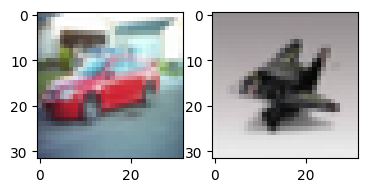

tensor([[[ 37,  48,  60,  ...,  22,   8,  25],
         [ 27,   8,  24,  ..., 253, 252, 248],
         [ 24,  28,  61,  ..., 219, 247,   7],
         ...,
         [  8,  56,   8,  ..., 227, 223, 219],
         [ 43,  61,  69,  ...,   8, 207, 229],
         [ 12, 211, 228,  ..., 223,  12, 254]],

        [[ 16,  63,  29,  ..., 214, 215, 219],
         [ 25,  45,  57,  ..., 221, 163, 168],
         [195, 220, 208,  ..., 248,  37, 244],
         ...,
         [ 82,  13, 247,  ..., 140, 107, 239],
         [199, 165,  32,  ...,   1,  25,  30],
         [ 69,  90, 105,  ..., 100,  31, 252]],

        [[ 10,   9, 224,  ..., 222, 197,  31],
         [  0, 227,  13,  ...,   7,  32,  36],
         [ 64,  85, 101,  ...,  34,  24, 247],
         ...,
         [ 44,  64,  84,  ...,  97,  68,  90],
         [ 97,  66,  88,  ..., 128, 121, 102],
         [112, 109,  90,  ...,  65,  93,  66]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


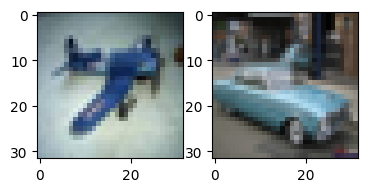

tensor([[[225,   2, 231,  ..., 222, 209, 241],
         [224, 214, 244,  ..., 249, 229, 222],
         [252, 232, 221,  ...,  44,  64,  36],
         ...,
         [ 78,  46,  12,  ...,  44,  68,  36],
         [234,   0, 237,  ...,  36,  52,  23],
         [ 35,  29,   4,  ...,  55,  38,  18]],

        [[ 19, 249, 209,  ...,  51,  73,  42],
         [246,   9, 248,  ...,  53,  64,  51],
         [ 61,  63,  65,  ...,  37,  27,   7],
         ...,
         [193, 227, 241,  ..., 219, 181, 190],
         [205, 169, 201,  ...,  71,  92,  48],
         [221, 242, 225,  ..., 222, 226, 242]],

        [[212, 215, 237,  ..., 147, 112, 112],
         [131, 104, 106,  ...,  59,  77,  51],
         [218, 246, 227,  ..., 225, 255,  24],
         ...,
         [ 16,  16,  44,  ...,  38,   3,  14],
         [ 39,   4,  11,  ...,   5,  47, 251],
         [  1,  41, 255,  ..., 245,   0,  33]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


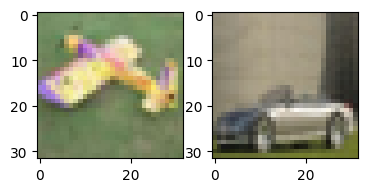

tensor([[[156, 182, 216,  ..., 213, 200, 198],
         [214, 198, 199,  ...,  97, 183,  33],
         [104, 192,  28,  ..., 254,  10,  49],
         ...,
         [236,  52, 159,  ..., 158, 248,  79],
         [242,  76, 173,  ...,  73, 237,  12],
         [ 48, 230,  13,  ..., 241,  56, 155]],

        [[250,  71, 160,  ..., 170,   2,  82],
         [  5,  78, 161,  ..., 231, 207, 203],
         [206, 186, 188,  ..., 207,  23, 181],
         ...,
         [ 87, 200,  11,  ...,  70, 119,  26],
         [ 83, 134,  27,  ..., 215,  17,  79],
         [ 19,  98, 172,  ..., 141,  63,  90]],

        [[115, 250,  66,  ...,  88, 157,  12],
         [ 92, 163, 252,  ..., 208,  21, 107],
         [ 16,  97, 173,  ...,  95, 219,   3],
         ...,
         [ 30,  90, 160,  ..., 109,  18,  62],
         [110, 216,  21,  ...,  15,  67, 234],
         [ 26,  82, 251,  ...,  63,  78, 104]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


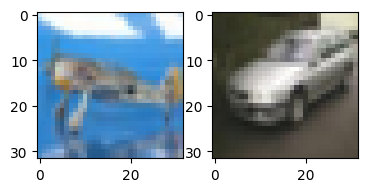

tensor([[[195, 204, 202,  ..., 233, 228, 240],
         [232, 228, 240,  ..., 245, 235, 234],
         [246, 234, 234,  ..., 226, 236, 223],
         ...,
         [ 63,  41,  26,  ...,   9,  11,   1],
         [251,   0, 248,  ...,   7, 242,   1],
         [255, 232, 249,  ...,  95,  66, 106]],

        [[ 95,  67,  45,  ...,  12,  13,   4],
         [  5,   6, 254,  ..., 237, 254,  19],
         [ 26,  35,  58,  ..., 149, 116, 150],
         ...,
         [ 51, 198, 241,  ...,  83,  53,  96],
         [ 77,  50,  50,  ...,  41,  49,  44],
         [ 30,  32,  26,  ..., 130,  60,  98]],

        [[134,  32,  69,  ..., 124, 105, 125],
         [119, 108,  46,  ...,  39,  49,  43],
         [ 31,  37,  30,  ..., 130,  72, 106],
         ...,
         [ 17,  43,  34,  ..., 108,  64,  97],
         [111,  58,  89,  ...,  94, 118,  46],
         [ 76, 100,  39,  ...,  36,  56,  49]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


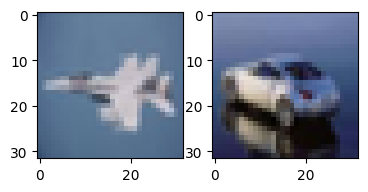

tensor([[[ 67, 168, 182,  ..., 149,  81, 145],
         [175,  72, 129,  ..., 175, 185, 106],
         [180, 193,  95,  ...,  69, 160, 179],
         ...,
         [ 85,  25,  11,  ..., 187,   4,   0],
         [  1,  79,  96,  ..., 127,  77, 105],
         [ 98,  49,  67,  ...,   0, 200, 255]],

        [[221, 167,   1,  ..., 185,   0, 250],
         [255,  74,  91,  ...,  58,  45,  76],
         [ 84,  64,  96,  ..., 205, 178, 153],
         ...,
         [107, 123, 169,  ..., 233, 250, 243],
         [  4, 251, 254,  ..., 188, 207, 205],
         [239,  25,   4,  ..., 189, 107, 112]],

        [[ 98, 117, 128,  ..., 218, 205, 225],
         [245, 210, 237,  ..., 170, 134, 134],
         [ 36,  69,  61,  ..., 130,  65,  56],
         ...,
         [243,  25,  23,  ...,  24, 248,   5],
         [  4,  14,  30,  ...,   2, 248, 236],
         [  9, 255, 238,  ..., 250,  34,  20]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


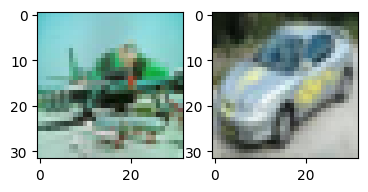

tensor([[[187, 170, 151,  ..., 144, 178, 156],
         [141, 174, 162,  ..., 160, 167, 160],
         [171, 186, 188,  ..., 203, 182, 169],
         ...,
         [155, 158, 253,  ..., 124, 102,  93],
         [ 42,   7, 251,  ...,  22, 248, 226],
         [224, 251, 225,  ...,   7,   9,  78]],

        [[ 54,  64, 141,  ..., 103,  79,  72],
         [148, 110,  91,  ...,  57,  67,  35],
         [ 27,  64,  31,  ..., 125, 134, 149],
         ...,
         [250, 246, 245,  ...,  27,  28,  79],
         [ 68,  65,  53,  ..., 110,  88,  85],
         [130, 106, 105,  ..., 218,  74,  67]],

        [[ 71,  45,  41,  ...,  89,  84, 150],
         [139, 130, 101,  ..., 119,  94,  92],
         [137, 113, 110,  ..., 180,  20,   9],
         ...,
         [149, 125, 118,  ...,  93, 124, 102],
         [ 90, 122,  99,  ...,  85,  76, 111],
         [ 89,  83, 112,  ..., 113,  96, 101]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


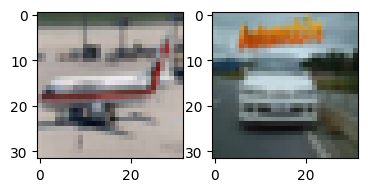

tensor([[[218, 221, 198,  ..., 223, 233, 240],
         [222, 234, 241,  ..., 241, 224, 232],
         [239, 222, 231,  ...,   1, 254, 229],
         ...,
         [  7, 246,   6,  ...,   3, 255, 229],
         [210, 202, 180,  ..., 222,  37,  30],
         [ 13,  43,  36,  ...,  48,  34,  45]],

        [[ 60,  49,  26,  ..., 224, 222, 197],
         [220, 213, 189,  ..., 222,  77,  70],
         [ 58,  99,  92,  ..., 136, 118, 134],
         ...,
         [ 39,  95,  88,  ..., 129, 127, 105],
         [116, 118,  51,  ..., 140, 144, 129],
         [227, 224, 197,  ...,  37,  59,  49]],

        [[ 33,  76,  68,  ..., 141, 135,  85],
         [ 94,  88,  72,  ..., 122, 128, 114],
         [220, 210, 184,  ..., 248,  59,  51],
         ...,
         [147, 138, 119,  ...,  85, 135, 102],
         [ 85, 137, 102,  ..., 100,  81, 136],
         [ 98,  80, 139,  ..., 131, 131, 110]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


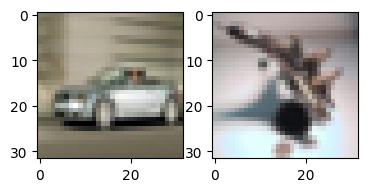

tensor([[[ 47, 110, 119,  ..., 109,   1,  62],
         [ 95, 253,  72,  ..., 183, 190, 110],
         [182, 187, 103,  ..., 127, 200, 207],
         ...,
         [ 56,  23,  36,  ..., 150, 136, 113],
         [ 44,  39,   7,  ...,  10, 134, 107],
         [ 68, 136, 111,  ...,  10, 230,  20]],

        [[ 20, 251,   0,  ..., 156, 138, 115],
         [245, 236, 212,  ...,   8, 139, 116],
         [ 78, 128, 110,  ...,   4, 230,  11],
         ...,
         [210,  11,   5,  ..., 243, 231,  60],
         [ 54,  26,  55,  ..., 189, 187, 156],
         [112, 112,  83,  ..., 227,  38,  27]],

        [[252,  32,  29,  ..., 185, 181,  29],
         [ 23,   2,  48,  ..., 203, 196, 177],
         [ 92,  89,  62,  ...,  24,  60,  61],
         ...,
         [169, 160, 152,  ..., 131, 127, 114],
         [107,  94,  81,  ..., 171, 150, 175],
         [164, 148, 180,  ..., 251, 252, 254]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


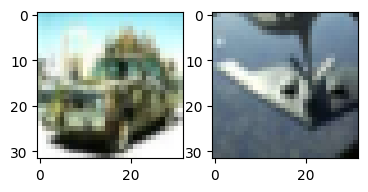

tensor([[[217, 255,  33,  ...,  36, 227,   8],
         [ 37, 228,   8,  ...,  15,  42, 228],
         [  8,  43, 226,  ..., 221,   0,  37],
         ...,
         [254, 215,   3,  ..., 228,   8,  43],
         [224,   9,  46,  ...,  46, 242, 255],
         [ 18, 242,  11,  ...,  18, 230, 244]],

        [[220, 175,  44,  ..., 220,   0,  37],
         [229,  14,  61,  ..., 223,   9,   3],
         [ 12,  21,  33,  ..., 249, 201,  29],
         ...,
         [122, 240, 235,  ...,   4, 214,  32],
         [ 14, 219,  37,  ...,  75, 112, 129],
         [ 73, 117, 159,  ..., 107,  27,  28]],

        [[ 19, 197, 187,  ...,   2, 221,  31],
         [ 14, 228,  42,  ...,  70, 106, 128],
         [ 63, 101, 156,  ...,  73, 217, 209],
         ...,
         [233,  12,  24,  ...,  34, 239,  13],
         [ 35, 239,  14,  ...,  19,  39, 238],
         [ 19,  36, 240,  ..., 239,  17,  36]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


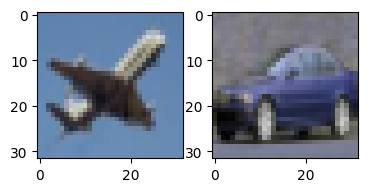

tensor([[[251,  55,  98,  ..., 129,  15,  78],
         [127,  16,  79,  ..., 111, 147,  27],
         [ 84, 122,   4,  ...,  31, 101, 150],
         ...,
         [155, 159, 101,  ..., 204,  11,  72],
         [ 20,  68, 125,  ...,  55,  35,  42],
         [ 57,  94, 101,  ...,  52,  72,  99]],

        [[124, 131,  99,  ..., 220,  26,  89],
         [ 48,  92, 144,  ...,  48,  54,  61],
         [ 84, 103, 110,  ...,  26,  45,  66],
         ...,
         [175, 125, 143,  ..., 253,   1,  66],
         [ 85,  88, 111,  ...,  93, 113, 122],
         [ 34,  52,  63,  ..., 112,  95, 114]],

        [[117,  82,  95,  ...,  19,  21,  63],
         [ 86,  91,  72,  ...,  98, 122, 128],
         [ 77,  96, 103,  ...,  68,  52,  71],
         ...,
         [ 62,  91,  96,  ..., 107,  79, 104],
         [110,  79, 105,  ..., 123, 129,  93],
         [122, 128,  85,  ...,  79, 107, 117]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


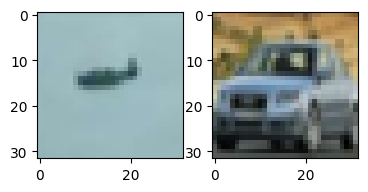

tensor([[[222, 193, 130,  ..., 112, 199, 173],
         [109, 186, 160,  ..., 179, 107, 208],
         [175, 101, 220,  ..., 109,  78, 244],
         ...,
         [ 55,   3,  73,  ...,  52,  31, 221],
         [249, 230, 174,  ..., 176, 225, 218],
         [193, 209, 205,  ...,  29, 250,  60]],

        [[ 33, 236,  66,  ...,  57,  30, 220],
         [231, 214, 162,  ..., 232,  67,  55],
         [ 13,  23,  15,  ...,  58,  20,  38],
         ...,
         [237,  60,  32,  ..., 209, 176, 201],
         [185, 152, 166,  ...,  22, 252, 198],
         [229, 210, 172,  ..., 175, 255, 232]],

        [[187,   1, 232,  ..., 171, 134, 213],
         [192, 149, 228,  ...,  21, 249, 194],
         [234, 215, 177,  ..., 208,  55,  36],
         ...,
         [248, 233, 193,  ..., 185,  11, 242],
         [197,  29, 255,  ...,   6, 216,  29],
         [  3, 213,  25,  ...,  18, 249, 205]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


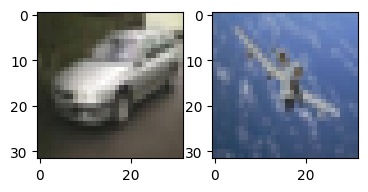

tensor([[[203, 203, 181,  ..., 229,   1, 248],
         [230,   3, 251,  ..., 241, 223, 244],
         [237, 219, 239,  ..., 186, 186, 165],
         ...,
         [162, 143, 177,  ..., 236, 232, 211],
         [219, 211, 187,  ..., 254,  11,   3],
         [240, 231, 223,  ..., 217, 199, 234]],

        [[231, 214, 220,  ..., 176, 174, 153],
         [239, 232, 206,  ...,  12,  12,   3],
         [245, 214, 207,  ..., 102,  83, 125],
         ...,
         [ 50,  64,  79,  ..., 146, 144, 152],
         [153, 152, 152,  ...,  45,  39,  25],
         [ 16,  12, 243,  ...,  40,  24,  37]],

        [[ 33,  41,  54,  ..., 120, 116, 118],
         [120, 115, 115,  ..., 234, 229, 217],
         [244, 241, 218,  ..., 213, 245, 255],
         ...,
         [235, 228, 209,  ..., 212, 228, 221],
         [204, 223, 216,  ..., 219, 201, 223],
         [216, 198, 223,  ..., 222, 215, 197]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


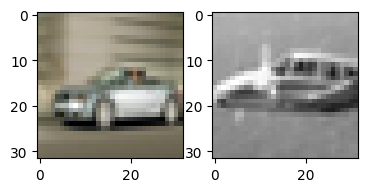

tensor([[[253,   2, 254,  ...,  12,  29,  32],
         [ 15,  28,  29,  ...,  26,  13,  30],
         [ 27,  13, 250,  ..., 222, 220, 216],
         ...,
         [  2, 235,  20,  ..., 204, 213, 233],
         [ 25,  31,  42,  ...,  46,  75,  68],
         [ 45,  56,  57,  ...,  91,  64,  96]],

        [[ 81,  63,  82,  ..., 190, 204, 217],
         [ 20,  24,  32,  ...,  88, 119, 104],
         [ 78, 107,  94,  ...,  52,  39,  76],
         ...,
         [ 52,   3,  16,  ...,  57,  79,  49],
         [ 57,  74,  45,  ..., 189, 192, 206],
         [ 25,  25,  21,  ...,  18,  22,  27]],

        [[ 37,  42,  45,  ..., 145, 146, 143],
         [147, 147, 142,  ..., 211, 211, 212],
         [ 34,  33,  23,  ...,  31, 251,   3],
         ...,
         [ 14,  22, 225,  ..., 232,  25,  33],
         [235,  26,  37,  ...,  44, 229,  36],
         [ 46, 232,  40,  ...,  32,  39, 229]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


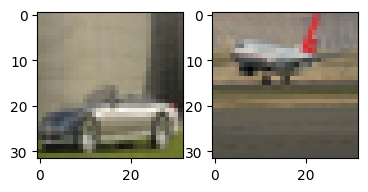

tensor([[[ 69,  64,  56,  ...,  53,  68,  69],
         [ 61,  55,  54,  ...,  25,  40, 255],
         [255, 241,  17,  ...,  30,  40,  49],
         ...,
         [ 66,  70,  57,  ..., 118, 107,  93],
         [110, 101,  82,  ..., 214,   3,  14],
         [201, 238, 246,  ...,  55,  21,  46]],

        [[ 47,  31,  65,  ..., 128, 113,  98],
         [111,  99,  81,  ..., 185,   8,  28],
         [231,  43,  65,  ...,  92,  16,  42],
         ...,
         [218, 152, 176,  ...,  92,  87, 100],
         [ 93,  79,  81,  ...,  95, 102, 114],
         [111, 109, 119,  ...,  53,  45,  68]],

        [[ 52,   4,  22,  ..., 119, 127, 133],
         [136, 141, 124,  ..., 119, 124, 127],
         [143, 138, 130,  ...,  70,  62,  83],
         ...,
         [120, 143, 147,  ..., 189, 151, 167],
         [192, 144, 164,  ..., 163, 203, 113],
         [137, 186, 103,  ..., 116, 131, 141]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


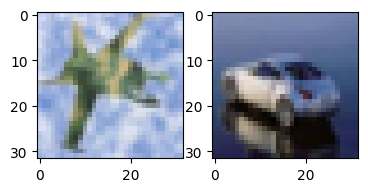

tensor([[[ 32,   6, 207,  ..., 221,  60,  32],
         [223,  61,  32,  ...,  27, 220,  53],
         [ 26, 217,  50,  ..., 237, 211, 163],
         ...,
         [ 21, 213,  45,  ..., 233, 213, 169],
         [ 30,   3, 198,  ..., 185,  26, 251],
         [181,  23, 250,  ...,  27, 216,  46]],

        [[ 20, 211,  44,  ..., 252, 233, 195],
         [248, 219, 159,  ..., 178,  17, 240],
         [172,  34,   7,  ...,  12, 206,  40],
         ...,
         [ 36,  72,  51,  ...,  34, 242,  58],
         [ 34, 241,  55,  ..., 184, 162, 121],
         [ 16, 249, 185,  ..., 192,  17,   1]],

        [[215,  47,  30,  ..., 107,  58, 133],
         [109,  58, 127,  ..., 195, 175, 131],
         [ 17, 251, 187,  ..., 195, 242, 223],
         ...,
         [244, 228, 130,  ..., 136,   0, 239],
         [138,   0, 244,  ..., 250, 131,   5],
         [252, 135,   8,  ...,   1, 246, 133]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


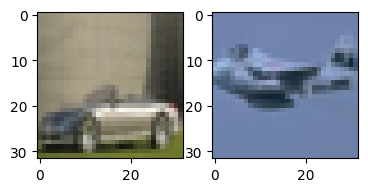

tensor([[[ 43, 250, 234,  ..., 106, 228, 148],
         [107, 229, 149,  ..., 152, 109, 234],
         [152, 107, 233,  ..., 234, 153, 113],
         ...,
         [ 65,  42, 160,  ..., 189, 101,  66],
         [ 58, 250, 203,  ..., 210, 144,  55],
         [ 18, 155,  86,  ...,  32,  17, 134]],

        [[ 46,  29, 166,  ..., 146,  79,  38],
         [  0, 191, 142,  ..., 217, 130,  74],
         [ 43, 105,  84,  ...,  52,  30,  93],
         ...,
         [174,  35, 238,  ..., 167, 131, 253],
         [177, 139,   7,  ...,  56, 245, 221],
         [246, 181, 176,  ..., 114,  14, 192]],

        [[170,  60, 247,  ..., 226, 190,  56],
         [235, 198,  62,  ...,  60, 244, 221],
         [225, 173, 177,  ..., 111,  13, 182],
         ...,
         [ 19, 226, 225,  ..., 252,  75,  23],
         [  4,  80,  28,  ...,  23, 254,  99],
         [ 26,   1,  97,  ...,  68, 250, 227]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


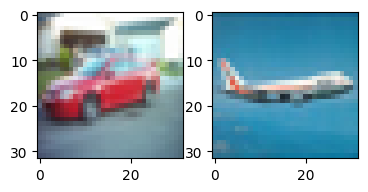

tensor([[[ 21,  43,  91,  ...,  65, 243,  12],
         [ 65, 243,  15,  ...,  27,  67,  12],
         [ 29,  70,  18,  ..., 108, 120, 152],
         ...,
         [ 26,  68,  15,  ...,  91, 114, 157],
         [ 34,  52,  97,  ..., 221, 126, 177],
         [215, 213, 250,  ...,  26,  69,  19]],

        [[ 34,  75,  16,  ...,  91, 115, 161],
         [ 40,  61, 106,  ..., 235, 112, 163],
         [203, 178, 218,  ...,  25,  69,  13],
         ...,
         [249, 202, 230,  ..., 138, 161, 114],
         [142, 172, 118,  ...,  24,  58,  98],
         [  5,  35, 101,  ...,  74, 194, 222]],

        [[254, 171, 201,  ...,  69,  90,  36],
         [ 63,  88,  94,  ...,  16,  47,  92],
         [  3,  32,  99,  ...,  34, 237,  12],
         ...,
         [ 16,  41, 148,  ..., 130,   6,  28],
         [129,   6,  25,  ...,  24, 135,   4],
         [ 22, 130,   1,  ...,  19,  38, 158]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


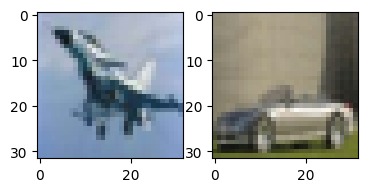

tensor([[[130,  70,   0,  ..., 111, 180, 152],
         [159, 168, 142,  ...,  64, 247, 127],
         [ 64, 250, 122,  ..., 131,  68, 254],
         ...,
         [117,  69, 184,  ...,  63,   1, 191],
         [128,  65,   0,  ..., 230,  59,  43],
         [ 64,  54,  40,  ..., 142,  96, 210]],

        [[139,  98, 196,  ...,  30, 225, 160],
         [127,  64, 254,  ..., 175, 253, 236],
         [  1, 221, 209,  ..., 208, 175,  50],
         ...,
         [137, 196, 182,  ..., 184, 121, 253],
         [187, 124, 191,  ..., 255, 197, 127],
         [184, 119,  49,  ...,  38, 171, 116]],

        [[ 86, 196, 177,  ..., 182, 120, 243],
         [184, 118, 190,  ...,  32, 230, 166],
         [202, 143,  69,  ...,  27, 169, 114],
         ...,
         [123,  71,   4,  ...,   1, 119,  68],
         [  2, 122,  66,  ...,  68,   3, 124],
         [ 69,   4, 124,  ..., 124,  72,   7]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


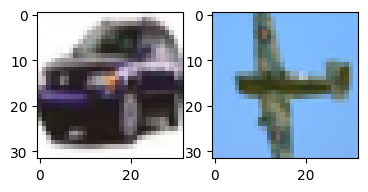

tensor([[[143,  89,  28,  ...,  16, 126,  81],
         [ 20, 118,  79,  ...,  82,  15, 130],
         [ 81,  22, 129,  ...,  26,  23, 254],
         ...,
         [205, 182, 247,  ...,  18,  22,  15],
         [ 90,  70,  21,  ..., 237, 133, 165],
         [176,  98, 127,  ...,   4, 227,  48]],

        [[ 18, 245,  52,  ...,  40,  67,  79],
         [ 85,  64,  30,  ..., 199,  68,  96],
         [106,  83, 122,  ...,  10, 230,  41],
         ...,
         [213, 182, 203,  ..., 169, 171, 163],
         [176, 179, 171,  ..., 207, 167, 109],
         [ 83,  51,   4,  ..., 226, 107, 130]],

        [[134, 162, 192,  ..., 154, 143, 171],
         [157, 138, 169,  ..., 232, 190, 133],
         [ 46,  16, 228,  ..., 126,  70,  94],
         ...,
         [111,  67, 206,  ..., 181,  47,  10],
         [160,  72,  26,  ...,   1, 155,  45],
         [  0, 152,  32,  ...,  42,   1, 154]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


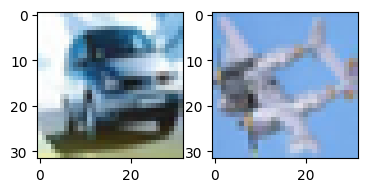

tensor([[[ 56,  98, 143,  ..., 151,  47,  94],
         [149,  49,  96,  ..., 144, 186,  76],
         [117, 161,  55,  ...,  82, 134, 187],
         ...,
         [172, 182, 131,  ..., 234,  24,  90],
         [ 51,  86, 145,  ...,  74,  60,  55],
         [ 72, 115, 111,  ..., 107, 135, 167]],

        [[174, 190, 125,  ..., 248,  38, 107],
         [ 78, 109, 162,  ...,  75,  89,  82],
         [106, 133, 127,  ..., 102, 129, 155],
         ...,
         [139,  95,  91,  ..., 109,  87, 226],
         [219, 200,  41,  ..., 119, 124, 137],
         [ 73,  74,  91,  ..., 135, 126, 131]],

        [[123,  90,  86,  ..., 231, 218,  17],
         [ 19,  10,  49,  ..., 128, 136, 145],
         [113, 115, 128,  ...,   7, 251, 249],
         ...,
         [ 76,  93, 102,  ..., 109,  87, 100],
         [110,  87, 101,  ..., 122, 132, 109],
         [124, 134, 103,  ..., 106, 119, 131]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


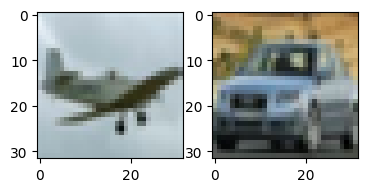

tensor([[[231, 213, 219,  ...,  26,  10, 255],
         [254,   9, 255,  ...,   5,   1,  27],
         [  4, 254,  56,  ..., 233, 219, 220],
         ...,
         [173, 191, 213,  ..., 242, 206, 148],
         [139, 117, 141,  ..., 225, 208, 197],
         [189, 174, 162,  ..., 144, 148, 168]],

        [[147, 182, 166,  ..., 182, 147,  93],
         [ 94,  66, 104,  ..., 155,  97,  84],
         [ 68, 105,  92,  ...,  72,  60,  90],
         ...,
         [ 15,   7, 246,  ..., 162, 124, 185],
         [160, 128, 180,  ..., 124,  92, 112],
         [136, 112, 148,  ..., 248, 243, 226]],

        [[253,   1, 240,  ..., 203, 170,   3],
         [232, 201,  45,  ..., 108,  79,  87],
         [103,  77, 119,  ..., 242, 229, 210],
         ...,
         [ 39,  47,  73,  ...,  75,  53,  28],
         [ 70,  61,  36,  ...,  31,  71,  42],
         [ 18,  54,  48,  ...,  82,  57,  87]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


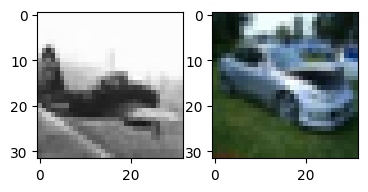

tensor([[[ 38,  31,  24,  ...,   5,  32,  10],
         [ 17,  32,  16,  ...,  88,  30, 112],
         [ 98,  44,  95,  ...,  78,  18,  27],
         ...,
         [213,  68,   4,  ..., 230, 247, 242],
         [ 57,  20,  23,  ...,  19, 207, 189],
         [ 27, 214, 196,  ..., 219,  32, 224]],

        [[222,  66,  13,  ..., 254,  18,   7],
         [ 80,  87,  83,  ...,  29, 238, 220],
         [ 45,   5, 245,  ..., 229,  38, 234],
         ...,
         [123, 250,   1,  ..., 229,  80, 188],
         [205,  89, 103,  ..., 112, 132, 151],
         [151, 173, 184,  ..., 102, 254,  20]],

        [[ 98,   0,  15,  ..., 228,  82, 193],
         [202,  94, 113,  ...,  67,  90, 110],
         [167, 186, 193,  ..., 111,   6,  19],
         ...,
         [118, 128, 130,  ..., 220, 189, 211],
         [227, 210, 229,  ..., 176, 200, 152],
         [174, 192, 150,  ..., 184, 199, 211]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


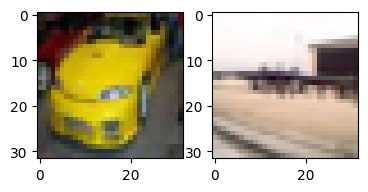

tensor([[[ 41, 101, 147,  ..., 168,  54, 116],
         [164,  61, 117,  ..., 119, 175,  52],
         [120, 172,  52,  ..., 159, 172, 186],
         ...,
         [ 15,  40, 212,  ...,   8, 223, 188],
         [ 95, 132, 165,  ...,  36,   7,  44],
         [ 68,  25,  63,  ..., 201, 225, 153]],

        [[190, 208, 132,  ..., 147, 133, 122],
         [100, 137, 166,  ...,  69,  35,  75],
         [ 97,  30,  55,  ..., 200, 220, 154],
         ...,
         [ 54,   5,  25,  ..., 182, 168, 221],
         [209, 197, 190,  ...,   6,  36,  66],
         [105, 155, 188,  ..., 218,  26,  12]],

        [[252, 226, 196,  ...,  34,  47,   5],
         [ 18,  21,  22,  ..., 238,  30,  74],
         [147, 191, 219,  ...,  71,  35,  72],
         ...,
         [ 98, 149, 243,  ...,  66, 169, 215],
         [ 51, 149, 200,  ..., 233,  63, 176],
         [233,  62, 177,  ..., 184, 229,  53]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


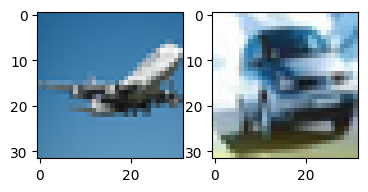

tensor([[[ 65,  65,  65,  ...,  59,  59,  59],
         [ 62,  51,  57,  ...,  60,  55,  65],
         [ 59,  58,  66,  ..., 215,   6,  43],
         ...,
         [230, 250, 186,  ..., 213,   3,  40],
         [ 19,  41,  58,  ..., 203, 122, 147],
         [172, 106, 130,  ...,  50,  74,  51]],

        [[ 61,  88,  12,  ...,   2,  30,  51],
         [ 15,  37,  57,  ..., 175,  99, 122],
         [149, 106, 141,  ...,  54,  85,  50],
         ...,
         [182, 165, 187,  ..., 232, 245, 215],
         [219, 233, 254,  ..., 147, 154, 160],
         [ 22,  31,  43,  ..., 222, 129, 149]],

        [[170, 190, 216,  ..., 177, 181, 176],
         [170, 174, 190,  ..., 172, 177, 181],
         [237, 253,  13,  ..., 185, 109, 132],
         ...,
         [ 45,  50, 253,  ..., 187, 248, 254],
         [202,  13,  15,  ..., 243, 199, 247],
         [243, 200, 245,  ..., 236, 244, 203]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


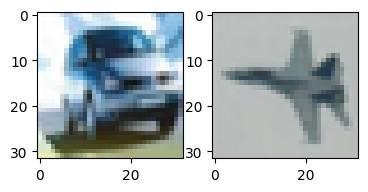

tensor([[[156, 174, 215,  ..., 159, 118, 133],
         [188, 110, 120,  ..., 198, 222, 198],
         [199, 226, 187,  ..., 195, 189, 223],
         ...,
         [ 88,  92,  83,  ..., 231, 253,  25],
         [ 29,  65, 109,  ..., 138,  80,  91],
         [109,  56,  55,  ...,  35,  56,  45]],

        [[ 38,  58, 109,  ..., 223, 247,  19],
         [ 27,  61, 106,  ...,  70,  46,  60],
         [ 94,  72,  82,  ...,   6,  44, 240],
         ...,
         [204, 112, 186,  ...,   2,  44, 186],
         [251,  30, 208,  ..., 159, 232, 247],
         [206,   8,  43,  ..., 197, 147, 208]],

        [[218, 137, 200,  ...,   3,  34, 214],
         [ 24,  57, 246,  ..., 119, 198, 227],
         [200,   3,  44,  ..., 201, 188, 211],
         ...,
         [135, 215, 249,  ...,  26, 169, 247],
         [ 23, 168, 246,  ..., 206, 236, 138],
         [214, 245, 147,  ..., 147, 216, 249]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


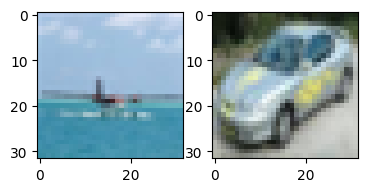

tensor([[[239, 192, 152,  ...,  14, 154,  89],
         [ 31, 165,  91,  ...,  90,  34, 175],
         [ 93,  22, 160,  ...,  36,  22,  17],
         ...,
         [ 28, 247,  76,  ...,  81,  63,  38],
         [ 75,  92,  92,  ...,  63, 101, 103],
         [118, 101, 126,  ..., 247, 220,  66]],

        [[  9, 242,  95,  ...,  67,  44,   1],
         [ 27,  31,  25,  ...,  93, 131, 158],
         [176, 101, 165,  ...,  11, 236,  30],
         ...,
         [ 13, 207,  12,  ..., 252, 253, 254],
         [244, 247, 235,  ..., 243,  11,  23],
         [229, 221,  18,  ..., 192, 149, 221]],

        [[253, 195,  33,  ...,  12,  11,  17],
         [238, 225, 244,  ..., 214, 232, 249],
         [216, 212,   6,  ..., 164, 162, 195],
         ...,
         [167, 173, 209,  ..., 254, 210, 233],
         [  6, 213, 237,  ..., 241,  10, 214],
         [241,  10, 211,  ..., 182, 208, 235]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


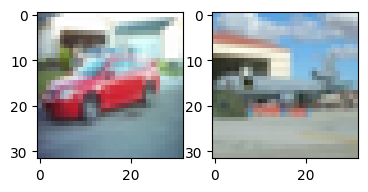

tensor([[[161, 185, 229,  ..., 230, 159, 187],
         [231, 160, 188,  ..., 188, 232, 165],
         [188, 232, 165,  ..., 164, 188, 231],
         ...,
         [223,  25, 210,  ..., 182, 213,   3],
         [166, 191, 233,  ...,  99,  65,  84],
         [112,  90, 108,  ..., 250,  54, 168]],

        [[212,  23, 200,  ..., 188, 224,  19],
         [167, 192, 233,  ...,  43,  14,  35],
         [ 59,  33,  55,  ...,  22,  78, 204],
         ...,
         [191,  88, 130,  ..., 103, 150,  63],
         [105, 153,  60,  ..., 194, 222,  10],
         [202, 225,  10,  ..., 208, 139, 168]],

        [[205, 100, 132,  ...,  96, 148,  75],
         [112, 161,  69,  ..., 169, 190, 233],
         [184, 206, 246,  ..., 185, 141, 163],
         ...,
         [172, 190, 226,  ..., 226, 171, 192],
         [226, 170, 193,  ..., 193, 228, 173],
         [195, 229, 172,  ..., 172, 195, 228]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


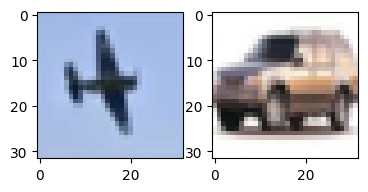

tensor([[[ 50,  80,  92,  ...,  73,  61,  71],
         [ 79,  62,  68,  ..., 111, 116,  60],
         [102, 122,  55,  ...,  49,  75, 110],
         ...,
         [ 48,  29,  55,  ...,  20,  34,  30],
         [ 62,  62,  57,  ...,  75,  86,  97],
         [101,  90, 105,  ...,  54,  37,  30]],

        [[ 16, 248,  26,  ...,  56,  72,  78],
         [ 35,  39,  46,  ..., 242,  37,  39],
         [ 46,  79,  86,  ...,  27,  12,   1],
         ...,
         [ 19, 176, 178,  ...,  18, 238,  63],
         [ 60,  12,  66,  ..., 157, 187, 202],
         [126, 152, 188,  ...,  46, 180, 186]],

        [[210, 147, 156,  ...,  17, 244,  53],
         [ 44,   4,  66,  ..., 130, 161, 191],
         [ 75,  99, 144,  ...,  40, 178, 187],
         ...,
         [ 10,  49,  66,  ...,  66,  13,  44],
         [ 63,   6,  35,  ...,  14,  60, 243],
         [ 10,  54, 246,  ..., 244,  14,  53]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


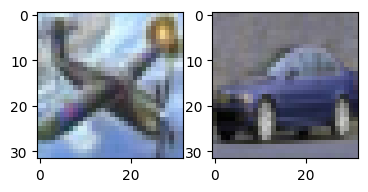

tensor([[[230, 169, 229,  ..., 221, 221, 160],
         [220, 221, 159,  ..., 105, 167, 169],
         [106, 165, 160,  ..., 175, 120, 193],
         ...,
         [ 62, 138, 105,  ..., 168, 104, 160],
         [230, 173, 228,  ..., 224, 216, 155],
         [214, 181, 118,  ...,  32, 108,  95]],

        [[ 50, 126,  91,  ..., 184, 119, 172],
         [229, 176, 229,  ..., 210, 174, 115],
         [171, 147,  87,  ...,  22, 101,  97],
         ...,
         [ 28,  16, 210,  ..., 197, 255,   5],
         [197, 253,   7,  ..., 172, 109, 150],
         [170,  81, 114,  ...,   3,  21, 206]],

        [[  4,   7, 195,  ..., 202,   2,  15],
         [207,   4,  26,  ..., 172, 107, 148],
         [138,  52,  91,  ...,   7,  16, 204],
         ...,
         [139,  61,  87,  ..., 117, 160,  95],
         [116, 156,  91,  ...,  98, 127, 169],
         [109, 139, 158,  ..., 161, 105, 139]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


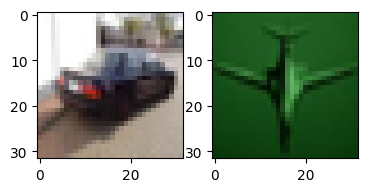

tensor([[[171, 203,   0,  ...,   8, 150, 190],
         [  9, 150, 191,  ..., 201,  18, 163],
         [202,  21, 165,  ..., 233,   4,  55],
         ...,
         [ 80, 109,  80,  ...,   7,  31,  82],
         [190, 216,  21,  ..., 225, 117, 147],
         [216, 111, 139,  ...,  97, 123,  90]],

        [[102, 127,  85,  ...,  16,  36,  85],
         [203, 226,  27,  ..., 223, 125, 152],
         [220, 117, 143,  ...,  93, 118,  83],
         ...,
         [163, 146, 153,  ..., 156, 158, 140],
         [143, 149, 161,  ...,  17,  26,  43],
         [215, 231,  14,  ..., 187, 142, 148]],

        [[168, 123, 129,  ...,  80,  84,  62],
         [ 65,  73,  70,  ...,  15,  23,  45],
         [213, 227,  10,  ..., 176, 158, 163],
         ...,
         [167, 160, 231,  ..., 243, 170, 167],
         [241, 177, 169,  ..., 201,  16, 213],
         [200,  11, 210,  ..., 167, 159, 231]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


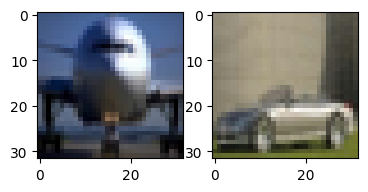

tensor([[[ 51,  52,  52,  ...,  56,  70,  70],
         [ 65,  72,  70,  ..., 238, 237, 228],
         [233, 229, 218,  ..., 162, 170, 180],
         ...,
         [ 36,  20,  54,  ..., 126, 137, 148],
         [ 27,  31,  32,  ...,  14,  14,  16],
         [ 17, 251, 252,  ..., 120, 100,  83]],

        [[ 75,  50,  33,  ..., 115, 130, 140],
         [  3,   7,  10,  ...,   3,  19,  21],
         [ 11,  47,  44,  ...,  91,  63,  56],
         ...,
         [ 39,  40,  39,  ..., 246,  16, 230],
         [245,   8, 219,  ...,  87,  98, 115],
         [227, 224, 219,  ..., 213,  19,  20]],

        [[ 24,  46,  46,  ...,  63,  83,  54],
         [ 69,  86,  49,  ...,  99, 111, 124],
         [240, 238, 233,  ..., 218, 176, 180],
         ...,
         [246,   3, 219,  ..., 208, 217, 227],
         [186, 223, 238,  ..., 228, 174, 192],
         [214, 164, 185,  ..., 204, 222, 175]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


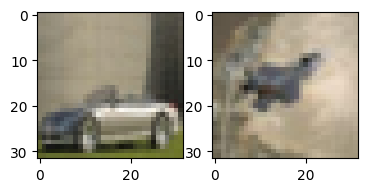

tensor([[[ 44,  27, 140,  ..., 142,  47,  30],
         [141,  47,  30,  ...,  21, 137,  48],
         [ 29, 136,  48,  ...,  54,  44, 144],
         ...,
         [243, 178, 246,  ...,  15, 230, 131],
         [  2, 216, 133,  ..., 142, 245, 196],
         [134, 242, 196,  ..., 221, 174,   1]],

        [[231, 180, 242,  ...,  18, 231, 139],
         [249, 202, 118,  ..., 132, 219, 172],
         [113, 214, 169,  ..., 193, 155, 234],
         ...,
         [244,  19,  54,  ..., 231, 202, 220],
         [231, 202, 218,  ..., 172, 156,  50],
         [181, 159,  27,  ..., 187,  43,  61]],

        [[ 12,  24,  68,  ..., 232, 216, 222],
         [229, 209, 217,  ..., 188, 170,  52],
         [198, 181,  28,  ...,  73,  14,  15],
         ...,
         [ 50,  53, 212,  ..., 192,  45,  49],
         [193,  46,  50,  ...,  46, 198,  46],
         [ 48, 201,  45,  ...,  48,  57, 246]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


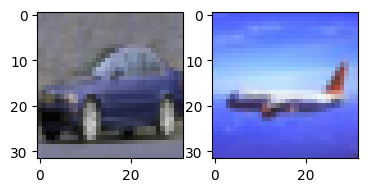

tensor([[[222, 205, 204,  ..., 203, 221, 203],
         [202, 220, 203,  ..., 201, 202, 217],
         [200, 203, 216,  ..., 210, 191, 197],
         ...,
         [158, 170, 162,  ..., 159, 156, 168],
         [164, 161, 175,  ..., 173, 169, 177],
         [186, 182, 187,  ..., 151, 164, 160]],

        [[152, 165, 160,  ..., 152, 152, 164],
         [157, 155, 169,  ..., 214, 164, 172],
         [175, 146, 152,  ...,  95, 111, 111],
         ...,
         [235,  37,  24,  ...,  69,  99,  17],
         [ 25,  51,  17,  ..., 136, 145, 173],
         [159, 184, 220,  ..., 136, 157, 149]],

        [[133, 185, 178,  ...,  27,  45,   5],
         [  3,  15, 255,  ..., 143, 156, 189],
         [174, 196, 233,  ..., 135, 154, 151],
         ...,
         [172, 167, 208,  ..., 165, 148, 145],
         [159, 153, 152,  ..., 147, 144, 166],
         [164, 161, 172,  ..., 166, 172, 204]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


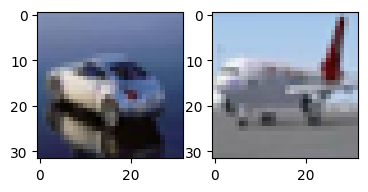

tensor([[[112, 113,  94,  ...,  93, 105, 108],
         [ 92, 106, 107,  ..., 133, 114, 133],
         [130, 110, 141,  ...,  75,  74,  43],
         ...,
         [236, 240, 224,  ..., 251, 252, 240],
         [120, 121, 102,  ..., 130, 168, 169],
         [159, 170, 170,  ..., 226, 230, 220]],

        [[218, 218, 216,  ..., 234, 232, 224],
         [115, 116,  99,  ..., 191, 222, 223],
         [219, 233, 233,  ...,   1,   2, 191],
         ...,
         [133, 188, 186,  ..., 160, 158, 102],
         [102,  96,  74,  ..., 168, 161, 151],
         [ 67,  68,  62,  ..., 211, 105, 106]],

        [[101,  86,  85,  ...,  78,  74,  71],
         [ 71,  66,  88,  ..., 163, 155, 144],
         [ 66,  67,  61,  ..., 245, 177, 178],
         ...,
         [114, 116, 103,  ..., 153, 194, 186],
         [176, 250, 242,  ..., 123, 112, 131],
         [123, 112, 166,  ..., 176, 168, 157]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


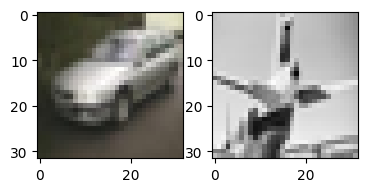

tensor([[[ 76, 104, 164,  ..., 165,  82, 110],
         [159,  89, 111,  ..., 109, 167,  80],
         [116, 172,  89,  ..., 206, 192, 204],
         ...,
         [ 18,  45, 247,  ..., 211, 203, 213],
         [115, 124, 169,  ...,  23,  17,  23],
         [ 56,  33,  42,  ..., 203, 228, 186]],

        [[193, 213, 175,  ..., 169, 179, 205],
         [120, 128, 169,  ...,  45,  63,  59],
         [ 79,  39,  37,  ..., 202, 224, 192],
         ...,
         [ 61,  57,  45,  ...,  45,  77,  46],
         [ 62,  97,  22,  ...,  38,  64, 109],
         [130, 158, 198,  ...,  28,  74,  60]],

        [[ 60,  81,  45,  ..., 103, 142,  82],
         [111, 152,  77,  ...,  13,  44,  88],
         [170, 194, 228,  ...,  18, 175, 119],
         ...,
         [161, 191,  23,  ...,  84, 217, 240],
         [ 69, 198, 225,  ...,   7,  91, 239],
         [ 11,  91, 240,  ..., 250,  12,  83]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


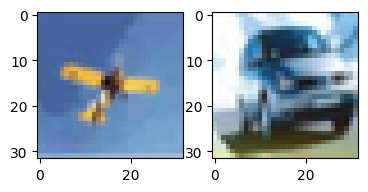

tensor([[[153,  97,  52,  ...,  51, 149,  94],
         [ 49, 151,  95,  ...,  97,  57, 151],
         [102,  63, 157,  ..., 164, 109,  68],
         ...,
         [112,  69, 169,  ..., 174, 113,  68],
         [158, 108,  63,  ...,  68, 161, 103],
         [ 65, 198, 170,  ..., 108,  66, 165]],

        [[111,  69, 165,  ..., 176, 114,  68],
         [156, 103,  61,  ...,  68, 153, 106],
         [ 72, 137, 113,  ..., 112,  72, 163],
         ...,
         [222,  20, 177,  ...,   4,   8,  27],
         [ 23,  24,  34,  ..., 176, 131,  98],
         [177, 123,  84,  ...,  20,  80,  45]],

        [[ 27,   3, 245,  ...,  30,  23,  41],
         [ 33,  30,  28,  ..., 182, 139, 106],
         [171, 121,  82,  ...,  45, 110,  75],
         ...,
         [117,  70,  44,  ...,  42, 103,  63],
         [ 40, 105,  65,  ...,  68,  51, 117],
         [ 76,  55, 120,  ..., 128,  86,  71]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


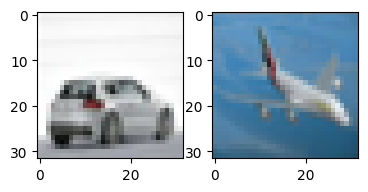

tensor([[[198, 242,  24,  ...,  32, 213,   2],
         [ 34, 215,   3,  ...,   7,  37, 211],
         [255,  37, 210,  ..., 194, 238,  17],
         ...,
         [235, 255, 229,  ..., 202, 247,  28],
         [208, 252,  37,  ...,  43, 229,  10],
         [ 50, 231,  11,  ..., 246,   5, 211]],

        [[236,   0, 231,  ..., 195, 239,  22],
         [212,   2,  52,  ...,  52, 246,  23],
         [ 70, 250,  29,  ...,   3,  28, 228],
         ...,
         [103, 205, 245,  ...,  89,  92,  46],
         [ 91,  96,  53,  ...,  48,  94, 111],
         [ 57, 102, 142,  ..., 111, 226,  11]],

        [[ 56, 202, 238,  ...,  93, 108,  57],
         [ 95, 111,  62,  ...,  43,  88, 110],
         [ 44,  87, 141,  ..., 123, 231,  18],
         ...,
         [205,   0, 254,  ...,  16, 218,  10],
         [ 17, 220,   7,  ...,   6,  30, 219],
         [  4,  27, 218,  ..., 204, 246,  10]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


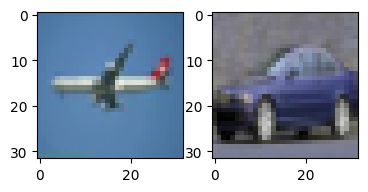

tensor([[[160, 211,  24,  ...,   7, 132, 185],
         [  5, 132, 185,  ..., 191,   9, 142],
         [191,  11, 144,  ..., 217,   5,  66],
         ...,
         [218,  31, 182,  ...,  10,  46, 103],
         [200, 240,  59,  ...,  39, 177, 218],
         [ 38, 173, 213,  ..., 218,  35, 186]],

        [[224,  37, 186,  ...,  20,  51, 108],
         [218, 254,  65,  ...,  36, 190, 227],
         [ 37, 189, 225,  ..., 221,  34, 191],
         ...,
         [215, 182, 205,  ..., 235,   7, 218],
         [236,  10, 197,  ...,  46,  82, 131],
         [193, 246,  64,  ...,  46, 194, 231]],

        [[ 26, 175, 209,  ..., 126, 160,  98],
         [126, 165,  96,  ...,  29,  65, 120],
         [185, 239,  63,  ...,  52, 225,  12],
         ...,
         [217, 250,  85,  ...,  92, 168, 229],
         [ 89, 170, 227,  ..., 232,  99, 190],
         [233, 102, 161,  ..., 154, 226, 100]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


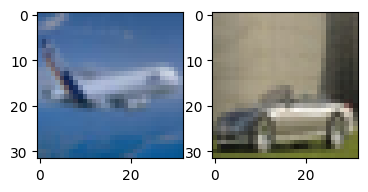

tensor([[[219, 233, 242,  ..., 237, 223, 232],
         [237, 223, 232,  ...,  25,  33,  13],
         [ 25,  35,  22,  ..., 248,   7,  11],
         ...,
         [157, 145, 164,  ...,  27,  39,  45],
         [228, 236, 242,  ..., 240, 232, 242],
         [247,   2,  11,  ..., 197, 186, 178]],

        [[169, 156, 229,  ...,  13,  26,  35],
         [229, 236, 244,  ...,   3, 226, 234],
         [242, 187, 196,  ..., 205, 191, 188],
         ...,
         [188, 202, 209,  ..., 165, 163,  55],
         [ 65,  67,  19,  ...,  48,  58,  68],
         [ 53,  91, 110,  ..., 215, 200, 216]],

        [[214, 213, 226,  ..., 217, 216, 161],
         [170, 171,  61,  ...,  49,  61,  70],
         [ 87, 121, 134,  ..., 213, 206, 219],
         ...,
         [ 96, 126, 144,  ..., 109,  68,  85],
         [110,  72,  90,  ...,  79,  96,  56],
         [ 69,  83,  67,  ...,  68,  79,  86]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


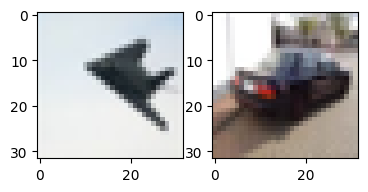

tensor([[[105, 112,  94,  ...,  85,  97, 110],
         [ 88, 106, 121,  ..., 114,  92,  96],
         [114,  92,  93,  ...,  94, 109,  88],
         ...,
         [220, 192, 210,  ...,  97, 108,  89],
         [144, 131,  90,  ...,   1,  56,  52],
         [  5,  66,  64,  ...,  83,  50,  79]],

        [[ 84,  52,  72,  ..., 104, 114,  94],
         [144, 130,  89,  ...,  32,  86,  83],
         [ 35,  87,  86,  ..., 101,  64, 102],
         ...,
         [217, 208, 209,  ...,   2, 246,  19],
         [ 22,  14, 102,  ..., 207, 194, 125],
         [119, 122, 100,  ...,  19,  11,  13]],

        [[236, 219, 220,  ..., 232, 224,  33],
         [ 43,  36,  49,  ..., 170, 169, 112],
         [125, 127, 106,  ...,  24,  25,  35],
         ...,
         [ 47,  47,  31,  ...,  13, 241,   8],
         [  2, 232,   3,  ...,  60,  53,  44],
         [ 65,  59,  50,  ...,  62,  83,  77]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


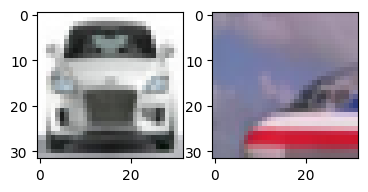

tensor([[[186, 168, 131,  ...,  15,  97,  63],
         [ 15,  97,  63,  ...,  63,  15,  97],
         [ 63,  15,  97,  ...,  97,  64,  13],
         ...,
         [ 13, 233,  53,  ...,  73,  46, 250],
         [218, 198, 133,  ..., 150,  43,   7],
         [212,  53,  40,  ..., 238, 208,  33]],

        [[254, 222,  65,  ...,  37,  26, 224],
         [163, 138,  73,  ..., 159,  33,  28],
         [239,  10,  40,  ...,  17, 240, 250],
         ...,
         [119, 207, 190,  ..., 124,  74, 169],
         [138,  86, 171,  ..., 207, 200, 160],
         [159, 134, 112,  ...,  61, 179, 152]],

        [[119, 225, 208,  ..., 187, 138, 212],
         [191, 144, 216,  ..., 205, 196, 158],
         [151, 129, 110,  ...,  59, 168, 141],
         ...,
         [157, 136, 120,  ..., 164, 199, 196],
         [169, 201, 199,  ..., 206, 174, 206],
         [207, 175, 203,  ..., 172, 168, 136]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


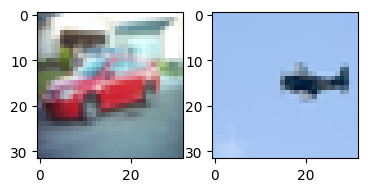

tensor([[[ 92, 121, 141,  ..., 133,  96, 112],
         [145,  97, 119,  ..., 194, 164, 183],
         [204, 177, 166,  ..., 160, 134, 166],
         ...,
         [118, 220, 142,  ...,  93, 124, 149],
         [106,  87, 110,  ..., 183, 129, 100],
         [195, 142, 113,  ..., 128, 201, 148]],

        [[121, 206, 146,  ..., 117, 146, 164],
         [129, 153, 163,  ..., 179, 126,  97],
         [173, 133, 105,  ..., 133, 198, 158],
         ...,
         [188, 134, 101,  ...,  88, 169,  91],
         [ 64, 178,   4,  ..., 121, 136, 144],
         [118, 136, 134,  ..., 166, 134, 115]],

        [[159, 136, 108,  ...,  76, 160,  77],
         [ 45, 167, 238,  ..., 104, 119, 128],
         [124, 139, 135,  ..., 164, 132, 104],
         ...,
         [106, 108, 115,  ..., 135, 168, 176],
         [185,  24,  28,  ..., 140, 161, 133],
         [144, 158, 131,  ..., 120, 125, 132]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


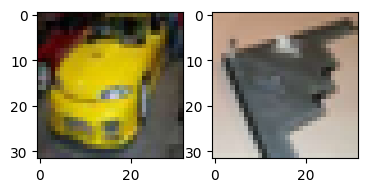

tensor([[[234, 245, 246,  ..., 250, 241,   0],
         [251, 242,   0,  ...,   6,   0, 244],
         [255,   1, 243,  ..., 227, 240, 240],
         ...,
         [208, 187, 234,  ..., 218, 220, 216],
         [219, 230, 232,  ..., 230, 228, 238],
         [239, 232, 239,  ..., 218, 189, 218]],

        [[208, 183, 230,  ..., 204, 216, 215],
         [193, 206, 211,  ..., 233, 228, 233],
         [233, 223, 228,  ..., 233, 201, 233],
         ...,
         [226, 181, 181,  ...,  13, 221,  24],
         [ 22, 231,  30,  ...,  49,  54,  14],
         [ 27,  28,   6,  ..., 206, 186, 191]],

        [[151, 157, 163,  ...,  11, 206,  11],
         [ 12, 207,  13,  ...,   9,  18, 222],
         [ 44,  37,  20,  ..., 247, 216, 214],
         ...,
         [225, 223, 173,  ..., 190, 241, 234],
         [193, 240, 233,  ..., 239, 193, 247],
         [239, 193, 246,  ..., 243, 236, 188]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


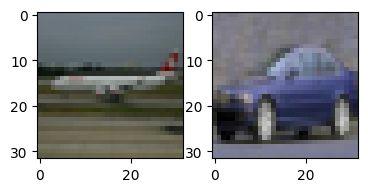

tensor([[[252,  30,  76,  ...,  74, 238,  18],
         [ 74, 237,  20,  ...,  39,  89,   7],
         [ 43,  95,  12,  ..., 233, 239, 243],
         ...,
         [ 62,  93,  40,  ..., 145, 155, 171],
         [ 28,  48,  79,  ...,  74,  18,  43],
         [ 80, 249,  18,  ...,  56,  89,  41]],

        [[ 64,  94,  40,  ..., 147, 157, 173],
         [ 38,  58,  85,  ...,  71,  20,  45],
         [ 77,   0,  24,  ...,  53,  83,  38],
         ...,
         [212, 220, 224,  ...,  13, 253, 195],
         [197, 175, 193,  ..., 185, 156, 112],
         [ 80,  65,  30,  ..., 244, 239, 240]],

        [[232, 188, 189,  ..., 206, 194, 129],
         [130, 109, 127,  ..., 175, 147, 105],
         [ 58,  45,  13,  ...,  22,  22,  20],
         ...,
         [ 84,  58,  62,  ...,  57,  82,  55],
         [ 54,  81,  48,  ...,  41,  54,  77],
         [ 39,  51,  74,  ...,  93,  52,  64]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


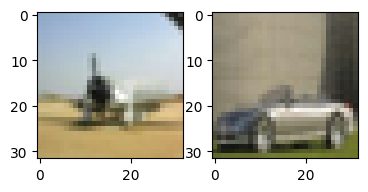

tensor([[[122, 106, 111,  ..., 212, 206, 207],
         [213, 207, 208,  ..., 207, 217, 203],
         [204, 215, 205,  ..., 211, 208, 220],
         ...,
         [  4, 198,  36,  ...,  68,  73, 108],
         [149, 129, 143,  ..., 167, 215, 211],
         [187,  40,  28,  ..., 252, 190,  71]],

        [[ 47, 242,  63,  ...,  37,  45,  70],
         [118,  99, 134,  ...,  39,   2, 254],
         [224, 249, 235,  ...,  27, 227,  43],
         ...,
         [158,  95, 115,  ..., 129, 151, 121],
         [130, 154, 137,  ...,  20,  44,  87],
         [ 65,  81, 102,  ..., 163, 158, 162]],

        [[174, 145, 158,  ..., 128, 148, 126],
         [131, 151, 145,  ...,  15,  42,  82],
         [ 69,  86, 107,  ..., 180, 186, 182],
         ...,
         [ 52,  63,  80,  ..., 119, 100, 105],
         [116, 120, 119,  ..., 153, 150, 117],
         [120, 136, 102,  ..., 103, 109, 133]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


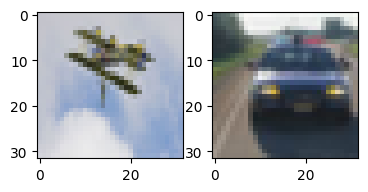

tensor([[[233, 247,  36,  ...,  36, 233, 246],
         [ 35, 232, 246,  ..., 243,  33, 228],
         [242,  35, 227,  ..., 221, 234,  32],
         ...,
         [209, 249, 194,  ..., 151, 171, 231],
         [216, 227,  19,  ...,   2, 215, 226],
         [  9, 226, 235,  ..., 203, 244, 195]],

        [[200, 238, 187,  ..., 173, 194,   0],
         [195, 215,   5,  ...,  28, 202, 207],
         [237, 166, 169,  ..., 141, 178, 148],
         ...,
         [184, 246, 228,  ...,  49,  93,  61],
         [ 54,  87,  42,  ..., 213, 224,   6],
         [155, 179, 229,  ..., 109, 121, 105]],

        [[104, 151, 138,  ...,  11,  45,  12],
         [  1,  23,  12,  ..., 211, 225,  13],
         [154, 175, 221,  ..., 114, 108,  98],
         ...,
         [150, 148, 196,  ..., 154, 131, 126],
         [151, 137, 134,  ..., 128, 146, 152],
         [147, 165, 157,  ..., 150, 153, 204]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


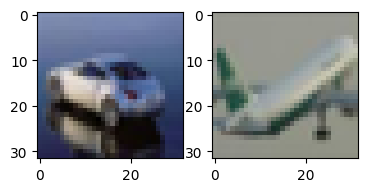

tensor([[[240, 225, 181,  ..., 194,  12, 249],
         [196,  16, 250,  ...,   6, 204,  25],
         [255, 205,  25,  ...,  14, 244, 193],
         ...,
         [234, 159,  56,  ...,  35, 255, 198],
         [  5, 238, 190,  ..., 196,  37,   2],
         [203,  41,   3,  ..., 246, 164,  39]],

        [[238, 157,  58,  ...,  28, 248, 192],
         [ 11, 244, 204,  ..., 202,  55,  16],
         [220,  62,  21,  ...,   6, 183,  55],
         ...,
         [198, 203, 173,  ...,  44, 213, 137],
         [ 86, 249, 150,  ..., 151, 103,  18],
         [117,  88,  38,  ..., 232, 186, 167]],

        [[144, 171, 151,  ...,  98,  11, 154],
         [100,  12, 157,  ..., 146,  97,  16],
         [105,  73,  36,  ..., 239, 195, 182],
         ...,
         [ 13, 236, 156,  ..., 177,  48, 254],
         [177,  50, 254,  ...,   7, 178,  65],
         [  7, 177,  65,  ...,  56,   1, 165]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


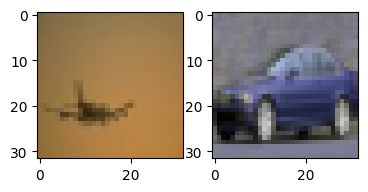

tensor([[[157, 153, 154,  ..., 159, 157, 151],
         [158, 155, 152,  ..., 148, 156, 157],
         [157, 156, 157,  ..., 173, 169, 171],
         ...,
         [233, 250, 220,  ..., 162, 158, 160],
         [172, 168, 164,  ..., 164, 153, 153],
         [151, 146, 149,  ..., 223, 243,  17]],

        [[ 27,  36,  43,  ..., 167, 163, 164],
         [164, 161, 147,  ..., 146, 128, 133],
         [127, 123, 131,  ...,   6,  15,  86],
         ...,
         [148, 201, 194,  ...,  75, 103,  72],
         [ 73, 101,  69,  ...,  67,  62,  78],
         [ 61,  56,  50,  ...,  91, 167, 161]],

        [[153, 195, 187,  ...,  55,  76,  54],
         [ 55,  76,  52,  ...,  75,  72,  80],
         [ 74,  72,  52,  ...,  86, 148, 142],
         ...,
         [230, 228,  12,  ..., 241, 213, 213],
         [239, 211, 212,  ..., 192, 206, 181],
         [188, 202, 177,  ..., 178, 184, 201]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


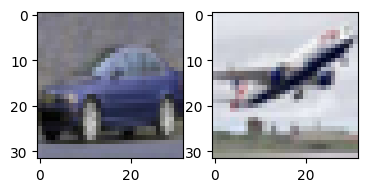

tensor([[[ 72,  24, 157,  ..., 155,  68,  61],
         [164,  77,  75,  ...,  82, 172,  21],
         [ 14, 119,  28,  ...,  70,  21, 154],
         ...,
         [ 39, 104, 198,  ...,  55,  65, 157],
         [ 44,  44, 125,  ..., 143,  58,  86],
         [146,  59,  89,  ...,   1,  62, 173]],

        [[211,  15, 154,  ...,  72, 106, 180],
         [ 32,  50, 119,  ..., 147,  63,  93],
         [153,  64,  97,  ..., 196, 254, 154],
         ...,
         [ 45, 230,   5,  ...,  12,  63, 199],
         [235,  27, 211,  ...,  32,  58, 125],
         [ 40,  56, 131,  ..., 101, 250,  28]],

        [[ 72, 232, 253,  ...,  42,  76, 206],
         [241,  26, 212,  ...,  33,  52, 120],
         [ 58,  56, 147,  ..., 153,  25,  64],
         ...,
         [ 99,  48, 172,  ..., 144,  64,  81],
         [152,  68,  95,  ..., 143, 202, 104],
         [127, 193,  88,  ...,  97,  47, 171]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


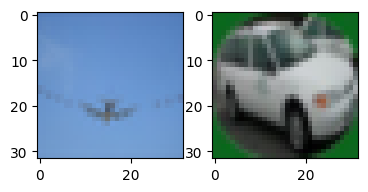

tensor([[[ 78,  63,   3,  ...,   8,   9,  10],
         [  5,  10,  10,  ...,  52,   9,  67],
         [ 56,   6,  72,  ...,  88,  76,   6],
         ...,
         [ 26, 216,  37,  ...,  98,  71, 234],
         [ 78,  59,   0,  ..., 142, 115, 118],
         [128,  92,  94,  ..., 250, 188,  73]],

        [[ 37, 219,  47,  ...,  98,  65, 219],
         [ 80,  62,   0,  ..., 198, 174, 175],
         [182, 158, 156,  ..., 225, 168,  36],
         ...,
         [201,  72,  51,  ...,  62,  12,  63],
         [ 32, 237,  79,  ...,  98,  63, 229],
         [ 64,  35, 224,  ..., 199,   0, 245]],

        [[199,  54,  42,  ...,  26, 229, 248],
         [215, 161, 250,  ..., 123,  94,   9],
         [ 82,  53, 244,  ..., 153, 189, 179],
         ...,
         [ 99,  71,   5,  ...,   9,  86,  63],
         [ 10,  85,  62,  ...,  65,   8,  91],
         [ 67,   8,  94,  ..., 113,  83,   9]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


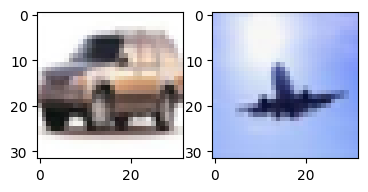

tensor([[[205, 228, 241,  ..., 242, 208, 230],
         [243, 209, 232,  ..., 237, 248, 215],
         [236, 250, 215,  ..., 216, 235,   5],
         ...,
         [ 40,  63, 203,  ..., 160, 191, 209],
         [169, 198, 215,  ..., 100,  67,  87],
         [107,  76,  94,  ..., 194, 209, 172]],

        [[197, 213, 157,  ..., 154, 187, 203],
         [161, 193, 218,  ...,  78,  24,  39],
         [ 44, 219, 232,  ..., 125, 134, 115],
         ...,
         [140, 214, 213,  ..., 185, 189, 170],
         [194, 193, 172,  ..., 109, 134, 146],
         [110, 145, 158,  ...,  62,  96,  97]],

        [[ 58, 125, 127,  ..., 143, 138, 139],
         [150, 137, 159,  ..., 109, 132, 144],
         [109, 140, 154,  ...,  63,  85,  90],
         ...,
         [104, 110, 126,  ...,  82,  88,  92],
         [ 81,  95, 101,  ...,  98,  76, 113],
         [118,  95, 121,  ..., 136, 146, 160]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


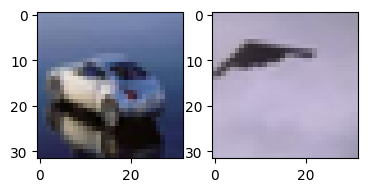

tensor([[[  1, 254, 250,  ...,   1,   5,   3],
         [251,  11,   4,  ...,   2,   2,   1],
         [  3,   0,   1,  ..., 107,  58,  19],
         ...,
         [ 93,  33, 119,  ..., 113,  64,  23],
         [ 46,  21,   3,  ...,  81, 103,  59],
         [ 21, 133,  89,  ...,  24, 218,  61]],

        [[ 19, 211,  50,  ...,  68,  37,  11],
         [ 50,  25,   2,  ..., 145, 186, 158],
         [129, 173, 132,  ...,  13, 207,  54],
         ...,
         [ 84, 134, 109,  ..., 152, 133, 184],
         [165, 146, 166,  ..., 181, 169, 162],
         [ 44,  32,  17,  ...,  86, 191, 167]],

        [[136, 131, 103,  ..., 207, 195, 221],
         [216, 204, 220,  ..., 157, 147, 140],
         [ 84,  67,  47,  ..., 135, 214, 189],
         ...,
         [ 23,  17,  68,  ..., 134,  78,  70],
         [118,  57,  54,  ...,  82, 125,  82],
         [ 82, 124,  83,  ...,  91,  81, 119]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


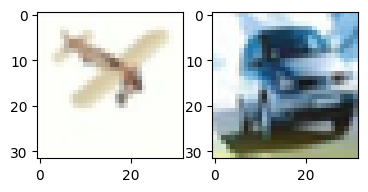

tensor([[[ 30,  33,  29,  ...,  47,  58,  62],
         [ 64,  74,  84,  ...,  75,  65,  77],
         [ 75,  69,  79,  ..., 255,  49,  77],
         ...,
         [201, 218, 208,  ..., 200, 243,  14],
         [ 87, 104, 122,  ..., 227, 151, 172],
         [193, 130, 152,  ...,  27,  44,  25]],

        [[ 55,  75,  73,  ..., 245,  15,  27],
         [ 84, 100, 121,  ..., 195, 116, 142],
         [165, 124, 160,  ...,  50,  78,  17],
         ...,
         [203, 183, 210,  ..., 254,  26, 193],
         [208, 227, 167,  ..., 156, 165, 161],
         [ 64,  69,  79,  ..., 245, 144, 168]],

        [[191, 201, 233,  ..., 171, 187, 139],
         [139, 149, 113,  ..., 181, 188, 184],
         [ 33,  43,  58,  ..., 212, 127, 153],
         ...,
         [132, 123,  77,  ...,  89, 129, 137],
         [105, 151, 151,  ..., 112,  91, 112],
         [109,  89, 107,  ...,  20,  20, 224]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


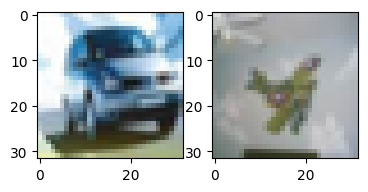

tensor([[[107, 153, 231,  ..., 232, 108, 154],
         [229, 108, 154,  ..., 157, 234, 109],
         [155, 232, 111,  ..., 110, 156, 233],
         ...,
         [ 72, 151,  29,  ..., 117, 163, 238],
         [109, 156, 234,  ...,  61, 193, 237],
         [ 55, 182, 226,  ..., 209,  32, 166]],

        [[210,  33, 174,  ..., 116, 162, 237],
         [109, 156, 234,  ...,  17, 163, 206],
         [ 19, 161, 206,  ..., 191,  14, 147],
         ...,
         [115,  38,  83,  ..., 100, 183,   2],
         [ 46, 126, 176,  ..., 115, 161, 236],
         [111, 158, 233,  ...,  58, 232,  20]],

        [[ 96,  30,  75,  ...,  99, 185, 233],
         [ 22, 101, 204,  ..., 116, 162, 237],
         [111, 158, 233,  ...,  54, 219,   7],
         ...,
         [198, 243,  56,  ...,  68, 214,   3],
         [ 72, 215,   4,  ..., 254,  67, 204],
         [250,  62, 200,  ..., 187, 233,  46]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


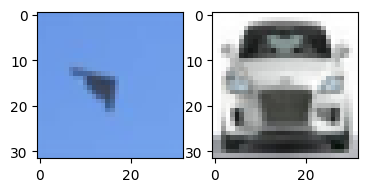

tensor([[[192, 241,  49,  ...,  36, 165, 216],
         [ 33, 164, 216,  ..., 220,  35, 173],
         [222,  39, 176,  ..., 244,  33,  88],
         ...,
         [230,  47, 183,  ...,   9,  53, 108],
         [201, 249,  63,  ...,  46, 175, 226],
         [ 47, 170, 221,  ..., 225,  44, 182]],

        [[231,  47, 182,  ...,  14,  56, 112],
         [211,   2,  71,  ...,  45, 175, 226],
         [ 46, 171, 222,  ..., 246,  51, 199],
         ...,
         [ 58, 225,  12,  ..., 175, 157, 201],
         [199, 185, 202,  ...,  44,  91, 139],
         [214,   6,  76,  ...,  79, 224,   9]],

        [[ 64, 205, 247,  ..., 101,  85, 130],
         [131, 120, 124,  ...,  33,  78, 131],
         [213,   4,  74,  ...,  67, 247,  33],
         ...,
         [246,  26, 133,  ..., 126, 233,  15],
         [125, 234,  10,  ...,   5, 129, 225],
         [  3, 123, 222,  ..., 231,   9, 126]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


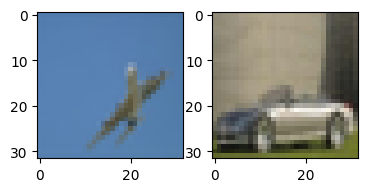

tensor([[[ 30,  25,  22,  ...,  21,  35,  31],
         [ 22,  35,  31,  ...,  29,  19,  34],
         [ 25,  15,  36,  ...,  23,  24,  19],
         ...,
         [244, 225, 227,  ...,  21,  14,   7],
         [ 27,  23,  24,  ..., 146, 117, 120],
         [135,  93,  96,  ..., 241, 217,  17]],

        [[252, 223, 240,  ...,  16,   3, 245],
         [ 22,  18,  19,  ..., 200, 167, 171],
         [189, 159, 159,  ..., 187, 166, 239],
         ...,
         [ 59, 131, 109,  ...,  83,  72,  91],
         [ 69,  59,  81,  ...,  35,  22,   9],
         [250, 245, 238,  ...,  45,  80,  65]],

        [[ 47, 121, 105,  ...,  74,  61,  76],
         [ 59,  47,  87,  ...,  63,  54,  42],
         [ 13,   9,   1,  ...,  68,  78,  69],
         ...,
         [ 20,  11,   4,  ...,  10,  34,  30],
         [ 18,  33,  29,  ...,  41,  25,  60],
         [ 44,  29,  64,  ...,  53,  45,  32]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


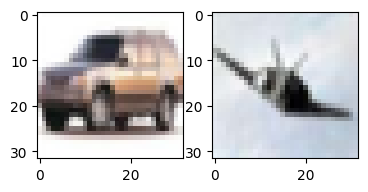

tensor([[[ 44,  34,  28,  ...,  32,  83,  61],
         [ 31,  60,  51,  ...,  83,  39, 124],
         [ 83,  54, 131,  ..., 135,  92,  42],
         ...,
         [118,  72, 158,  ...,  11, 197, 131],
         [164, 126,  96,  ...,  36, 115,  62],
         [ 29, 106,  53,  ..., 110,  67, 154]],

        [[107,  63, 170,  ...,  11, 209, 146],
         [152, 115,  89,  ...,  49, 113,  65],
         [ 38, 108,  58,  ...,  67,  35, 120],
         ...,
         [237,  79,  65,  ...,  82,  60,  39],
         [ 36,  23, 227,  ..., 232, 241, 244],
         [ 38,  33,  18,  ..., 198, 244, 242]],

        [[245,  77,  73,  ...,  26,  13, 199],
         [191, 183, 163,  ..., 237, 240, 239],
         [ 29,  22,   7,  ..., 189, 206, 200],
         ...,
         [239, 233, 219,  ..., 242,   7, 254],
         [238,   9, 255,  ...,   9, 249,  10],
         [  1, 238,   1,  ...,   9,   4, 245]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


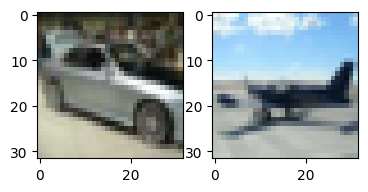

tensor([[[ 90, 130, 144,  ...,  92,  68,  81],
         [ 92,  65,  83,  ...,  71, 101,  21],
         [ 81, 112,  19,  ...,  68, 110, 129],
         ...,
         [  4,   3, 100,  ..., 129, 120, 120],
         [ 90,  73,  75,  ..., 153, 106, 130],
         [145, 137, 143,  ..., 247, 241,  20]],

        [[ 13,   6, 125,  ..., 135, 122, 122],
         [ 71,  73,  75,  ..., 166, 133, 152],
         [164, 163, 166,  ...,  25,  27,  65],
         ...,
         [ 50, 105,  98,  ..., 187, 171,   9],
         [255, 238,  68,  ...,  39,  37,  36],
         [117, 120, 114,  ..., 103,  73,  64]],

        [[ 46,  91,  83,  ..., 247, 226,  55],
         [ 44,  25,  86,  ...,  57,  49,  51],
         [117, 114, 114,  ...,  86,  85,  73],
         ...,
         [101,  95, 102,  ...,  57,  50,  42],
         [ 39,  58,  47,  ...,  60,  56,  80],
         [ 64,  62,  93,  ..., 254, 253, 252]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


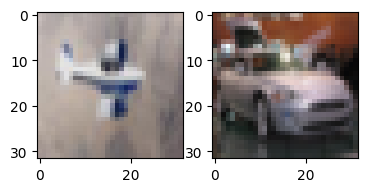

tensor([[[ 36,  80, 130,  ..., 126,  39,  81],
         [128,  39,  82,  ...,  63, 114,  21],
         [ 68, 121,  16,  ...,  21,  22,  53],
         ...,
         [151, 162, 141,  ...,  74,  72,  82],
         [ 21,  61, 119,  ...,  57, 242, 240],
         [225, 198, 196,  ..., 208, 214, 176]],

        [[214, 228, 165,  ...,  86,  86,  92],
         [ 25,  64, 117,  ..., 183, 145, 145],
         [128, 129, 130,  ..., 140, 156, 182],
         ...,
         [182, 164, 170,  ...,   7, 248,  22],
         [ 28,  18,  24,  ..., 123, 132, 142],
         [241, 246, 253,  ..., 240, 219, 222]],

        [[218, 205, 215,  ...,  30,  25,  26],
         [ 41,  38,   8,  ..., 124, 136, 146],
         [ 38,  63,  87,  ..., 209, 185, 194],
         ...,
         [118, 122, 140,  ..., 100,  66,  83],
         [ 98,  65,  82,  ...,  69,  85,  53],
         [ 70,  86,  53,  ..., 165, 169, 175]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


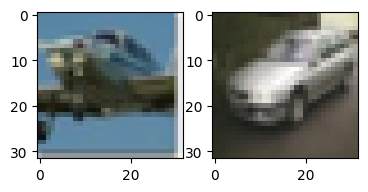

tensor([[[101, 209, 145,  ..., 158, 107, 180],
         [151,  96, 164,  ..., 142, 127, 151],
         [215, 187, 123,  ...,  86, 202, 148],
         ...,
         [211, 188,  32,  ..., 115, 174, 159],
         [174, 226, 204,  ..., 171, 108, 153],
         [164, 103, 146,  ..., 251, 230,  70]],

        [[ 41,  20,  67,  ...,  98, 135, 137],
         [193, 224, 211,  ..., 171, 107, 149],
         [164,  98, 137,  ...,  62,  44,  82],
         ...,
         [249,  42,  28,  ...,  21,  30,  13],
         [ 37,  50, 240,  ..., 153, 196, 200],
         [210, 249, 233,  ..., 226,  14, 248]],

        [[237,  17,   6,  ..., 235, 240,  12],
         [ 31,  40, 248,  ..., 153, 204, 203],
         [208,   6, 226,  ..., 189, 238, 223],
         ...,
         [172,  19, 200,  ..., 237, 239,   7],
         [230, 232, 250,  ..., 183, 166, 170],
         [190, 164, 207,  ...,  99, 213, 158]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


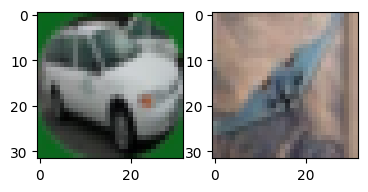

tensor([[[ 62,  55,  19,  ...,   7,  28,  32],
         [255,  24,  27,  ...,  17, 245,   7],
         [ 10, 235,   0,  ..., 242, 243, 225],
         ...,
         [  7, 241,  14,  ...,   0, 249, 233],
         [ 59,  48,  17,  ...,   2,   9,   9],
         [244, 254, 255,  ...,  16, 232,  19]],

        [[ 10, 237,  16,  ...,   1, 248, 234],
         [ 65,  49,  19,  ..., 221,  21,  23],
         [  6,  59,  62,  ...,  76,  32,  70],
         ...,
         [ 21, 196, 220,  ..., 235, 210, 220],
         [222, 210, 216,  ...,  11,  11, 254],
         [ 65,  49,  25,  ..., 104,  60,  84]],

        [[107,  31,  52,  ...,  16,   9, 247],
         [  5,  12, 224,  ...,  11,  13,   0],
         [ 62,  51,  26,  ..., 104,  71,  91],
         ...,
         [ 48,  61,  37,  ...,  70,  48,  67],
         [ 70,  41,  58,  ...,  52,  70,  15],
         [ 33,  51,   8,  ...,   9,  20,   8]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


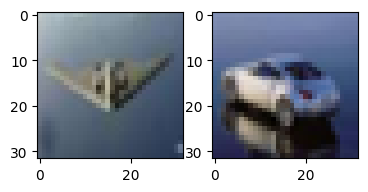

tensor([[[199, 211, 216,  ..., 121, 137, 130],
         [122, 139, 131,  ..., 146, 134, 154],
         [148, 136, 154,  ..., 161, 154, 143],
         ...,
         [ 93,  96, 112,  ..., 108, 101,  84],
         [ 34,  36,  10,  ...,  26, 115,  99],
         [ 87, 124, 132,  ...,  64,  73,  89]],

        [[ 73,  81, 115,  ...,  65,  76,  53],
         [255, 251, 225,  ...,  42, 110, 126],
         [119,  83, 134,  ...,  81,  83,  43],
         ...,
         [228, 223, 238,  ..., 170, 176, 181],
         [183, 189, 183,  ..., 219, 249,   8],
         [224, 234,   7,  ..., 189, 214, 219]],

        [[241,   1,  16,  ..., 229, 235, 221],
         [233, 241, 225,  ..., 222, 252,   8],
         [211, 225,   1,  ..., 191, 217, 223],
         ...,
         [205, 223,   5,  ...,  57,   2,  38],
         [ 70,   7,  44,  ...,  55,  74,  21],
         [ 55,  75,  19,  ..., 248,  21,  41]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


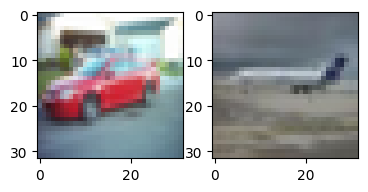

tensor([[[ 65,  74,  81,  ..., 111, 119, 124],
         [118, 125, 131,  ..., 133, 127, 129],
         [139, 131, 124,  ...,  98,  96,  89],
         ...,
         [179, 190, 163,  ...,  78,  90, 106],
         [ 98, 113, 124,  ...,  37,  15,  33],
         [ 40,  25,  43,  ...,  58,  68,  42]],

        [[ 57,  67,  34,  ...,  91, 105, 120],
         [ 94, 110, 122,  ...,  68,  39,  58],
         [ 69,  41,  60,  ...,  70,  85,  56],
         ...,
         [253, 153, 180,  ..., 138, 159, 159],
         [170, 186, 237,  ...,  77, 102, 125],
         [ 69,  92, 129,  ...,  50, 209, 238]],

        [[ 12, 153, 181,  ..., 168, 190, 209],
         [229,   4, 239,  ...,  65,  89, 121],
         [ 71,  94, 136,  ...,  63, 228, 254],
         ...,
         [228, 252,  42,  ...,  27, 213, 236],
         [ 24, 212, 235,  ..., 240,  28, 222],
         [245,  33, 225,  ..., 242,   5,  51]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


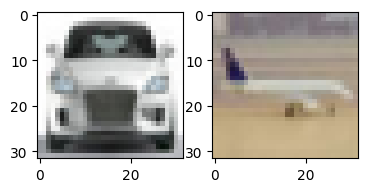

tensor([[[110,  58,   1,  ...,   3, 110,  59],
         [  2, 110,  59,  ...,  60,   3, 114],
         [ 62,   5, 112,  ..., 109,  60,   3],
         ...,
         [143,  85, 191,  ..., 104,  54, 253],
         [113,  61,   4,  ..., 171,  26, 233],
         [175,  37, 244,  ...,   6, 204,  56]],

        [[  6, 204,  49,  ..., 106,  55, 254],
         [111,  59,   2,  ..., 204,  56,   9],
         [209,  59,  11,  ...,  23, 222,  76],
         ...,
         [140, 215, 169,  ..., 112,  56, 218],
         [168, 109,  44,  ..., 109,  53,   1],
         [110,  57,   5,  ..., 183, 247, 191]],

        [[139, 192, 137,  ..., 124,  72, 243],
         [192, 135,  17,  ..., 109,  53,   1],
         [110,  57,   5,  ..., 185,   8, 203],
         ...,
         [ 19, 225, 184,  ..., 171,   1, 208],
         [166,   0, 207,  ..., 216, 174,  13],
         [220, 178,  16,  ...,  22, 236, 196]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


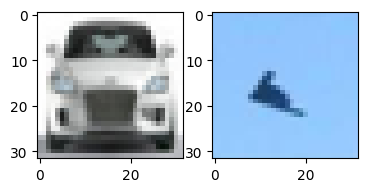

tensor([[[233, 205, 158,  ..., 175, 251, 221],
         [171, 252, 222,  ..., 216, 173, 253],
         [218, 173, 248,  ..., 203, 183, 142],
         ...,
         [  2, 215,  19,  ...,   8, 231, 189],
         [ 26, 250, 197,  ..., 179, 207, 199],
         [168, 232, 244,  ...,  10, 229,  39]],

        [[ 31, 254,  10,  ...,   7, 228, 187],
         [ 31, 251, 202,  ..., 158, 230, 216],
         [187, 254,   7,  ...,  84,  58,  52],
         ...,
         [197, 149, 154,  ..., 206, 166, 191],
         [177, 148, 182,  ...,  39,  14, 233],
         [ 71,  27, 233,  ...,  24,  31,  34]],

        [[ 39,  38,  31,  ...,  10, 233,   5],
         [245, 222, 212,  ...,  41,  19, 235],
         [ 71,  37, 243,  ...,  44,  97,  90],
         ...,
         [ 40,  46,   4,  ...,  68,  94,  99],
         [ 74,  88,  89,  ...,  88,  78,  72],
         [ 67,  58,  65,  ...,  44,  30, 245]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


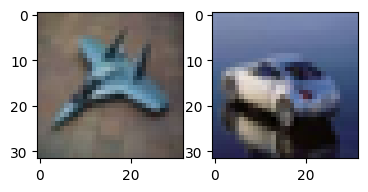

tensor([[[ 52,  81, 144,  ..., 190, 107, 140],
         [185, 100, 132,  ..., 163, 199, 122],
         [149, 183, 100,  ...,  91, 128, 193],
         ...,
         [168, 193, 149,  ..., 238,  17, 103],
         [ 74,  94, 165,  ...,  93,  79,  63],
         [ 98, 138, 119,  ...,  97, 139, 165]],

        [[164, 194, 121,  ..., 246,  26, 113],
         [110, 123, 187,  ...,  91,  94,  77],
         [124, 138, 121,  ...,  98, 141, 154],
         ...,
         [225, 220, 195,  ...,  41,  43, 149],
         [126, 128, 188,  ..., 142, 120, 136],
         [126, 110, 121,  ..., 158, 179, 157]],

        [[159, 164, 137,  ...,  56,  57, 140],
         [119, 125, 149,  ..., 139, 121, 133],
         [ 78,  67,  83,  ..., 109, 129, 106],
         ...,
         [229, 234, 241,  ..., 253, 237, 239],
         [250, 238, 239,  ...,   8,  18,   8],
         [ 12,  22,   0,  ..., 240, 246,   6]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


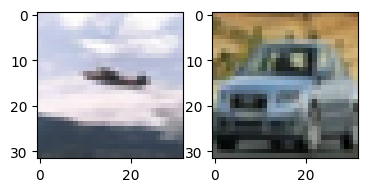

tensor([[[ 90, 113, 131,  ..., 114,  76, 100],
         [107,  92, 108,  ...,  98, 111,  74],
         [ 99, 108,  77,  ..., 181, 153, 122],
         ...,
         [ 30,  23,   7,  ..., 179, 150, 116],
         [122, 115, 117,  ..., 213,  45,  26],
         [253,  55,  37,  ..., 180, 171, 202]],

        [[209, 193, 198,  ..., 136, 123, 104],
         [122, 117, 114,  ...,  16, 150, 124],
         [ 55, 118,  79,  ..., 154, 137, 187],
         ...,
         [228, 246, 237,  ..., 202, 185, 246],
         [244, 227, 231,  ..., 237, 241, 238],
         [109, 115, 113,  ..., 190,  23,  18]],

        [[  5, 241, 230,  ...,  23,  11,  34],
         [ 44,  34,  32,  ..., 214, 219, 216],
         [152, 154, 143,  ..., 248,  50,  41],
         ...,
         [ 82,  91, 160,  ..., 225, 146, 150],
         [209, 124, 128,  ..., 163, 211, 146],
         [161, 208, 148,  ..., 150, 154, 191]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


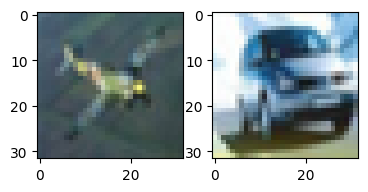

tensor([[[149,  81, 190,  ...,  92, 113,  42],
         [ 59,  81,  14,  ..., 163, 159, 156],
         [ 95, 111, 162,  ..., 127,  49, 108],
         ...,
         [227, 184, 182,  ..., 126,  89, 113],
         [ 35, 252, 239,  ..., 237,  66,  40],
         [235,  62,  38,  ..., 180, 132, 143]],

        [[129,  86, 125,  ..., 214, 194, 212],
         [ 20, 254, 232,  ..., 249,  67,  46],
         [244,  60,  41,  ..., 126,  78, 131],
         ...,
         [246,  81,  69,  ...,  17, 242,   8],
         [242, 214,  10,  ...,  69,  43,  36],
         [ 53,  17,  29,  ..., 217,  10,   1]],

        [[219,  31,  20,  ...,  48,  22, 254],
         [235, 212,   0,  ...,  70,  34,  30],
         [ 85,  30,  50,  ..., 254, 249, 239],
         ...,
         [120,  17,  76,  ...,  48,  99,  57],
         [ 60, 103,  71,  ..., 116, 103, 135],
         [ 98,  92, 117,  ..., 106,   7,  66]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


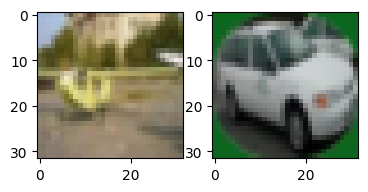

tensor([[[217, 128, 208,  ..., 201, 211, 162],
         [209, 218, 175,  ..., 183, 217, 164],
         [116, 165, 172,  ..., 221, 130, 208],
         ...,
         [ 84, 105,  18,  ..., 191, 158, 200],
         [152, 115, 151,  ..., 131, 105, 108],
         [130, 113, 110,  ...,  37,  56, 237]],

        [[247,  10, 222,  ..., 207, 196, 220],
         [138, 117, 141,  ..., 132, 104, 110],
         [132, 115, 114,  ..., 223, 239, 215],
         ...,
         [ 19,  17,  13,  ..., 240, 238, 212],
         [210, 208, 233,  ..., 148, 129, 143],
         [155, 127, 154,  ...,  58,  53,  51]],

        [[ 50,  46,  44,  ...,  74,  72,  10],
         [  9,   7,  12,  ..., 150, 123, 141],
         [175, 129, 171,  ..., 106,  82,  79],
         ...,
         [221, 129, 208,  ..., 172, 177, 153],
         [180, 182, 167,  ..., 215, 232, 219],
         [199, 222, 203,  ..., 221, 130, 208]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


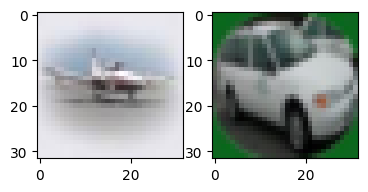

tensor([[[158, 166, 200,  ..., 245, 255, 233],
         [  1, 249, 229,  ..., 250,   8,   4],
         [236, 255,   7,  ..., 211, 199, 215],
         ...,
         [148, 153, 195,  ..., 244, 226, 254],
         [127, 135, 182,  ...,  39, 201, 195],
         [ 24, 185, 185,  ..., 212, 197, 179]],

        [[154, 154, 226,  ..., 242, 225, 252],
         [146, 153, 199,  ...,  46, 248, 242],
         [ 61, 216, 214,  ..., 240, 229, 251],
         ...,
         [ 20, 135,  42,  ..., 159, 240, 121],
         [ 93, 171,  93,  ...,  31, 251,   4],
         [ 52,  12,  29,  ..., 233,  59,  10]],

        [[ 12, 101,  32,  ..., 114, 225, 124],
         [104, 213, 113,  ...,  31, 254,   4],
         [ 62,  22,  40,  ..., 240,  68,  23],
         ...,
         [  3, 230, 244,  ...,  34,  76,  40],
         [ 43,  79,  47,  ...,  54,  72, 133],
         [ 91,  99,  88,  ...,  26, 254,   0]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


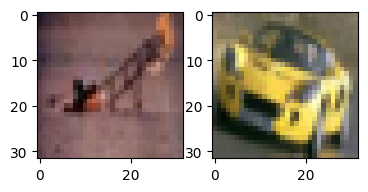

tensor([[[ 19,  46,  83,  ...,  69, 243,  18],
         [ 67, 245,  19,  ...,  35,  73,  21],
         [ 42,  83,  26,  ...,  69,  99, 134],
         ...,
         [ 31,  65,  27,  ..., 100, 112, 133],
         [ 13,  23,  43,  ...,  44, 253,  13],
         [ 47, 252,  12,  ...,  16,  47,  16]],

        [[ 27,  58,  17,  ...,  72,  79,  97],
         [230, 240, 247,  ..., 235, 185, 203],
         [230, 172, 190,  ..., 231,   5,   5],
         ...,
         [186, 200, 198,  ..., 150, 146, 147],
         [150, 145, 145,  ...,   0,   8, 254],
         [200, 210, 195,  ..., 239, 240, 232]],

        [[229, 220, 215,  ...,  94,  84,  89],
         [ 93,  84,  82,  ..., 244, 249, 247],
         [200, 209, 194,  ..., 238,  23,  16],
         ...,
         [227, 223, 250,  ..., 251, 221, 215],
         [248, 218, 208,  ..., 199, 251, 206],
         [197, 247, 201,  ..., 200, 196, 242]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


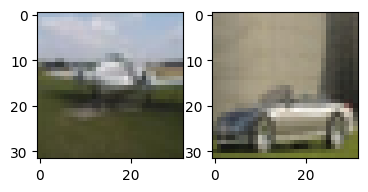

tensor([[[150, 154, 163,  ..., 152, 163, 150],
         [164, 164, 156,  ..., 231, 185, 251],
         [242, 198, 235,  ..., 208, 155, 180],
         ...,
         [ 58, 157,  73,  ..., 142, 160, 175],
         [163, 125, 142,  ..., 150,  63,  37],
         [133,  49,  26,  ...,  56, 127,  51]],

        [[ 24, 105,  25,  ..., 172, 186, 196],
         [191, 196, 202,  ..., 131,  30,   4],
         [ 76,   1, 233,  ...,   7,  68,  11],
         ...,
         [187,  92,  77,  ..., 219,  28, 198],
         [185,  32, 111,  ..., 187, 191, 199],
         [209, 220, 219,  ..., 164, 101, 104]],

        [[161, 107,  99,  ...,  45, 109, 230],
         [208,  60, 126,  ..., 170, 175, 184],
         [214, 224, 227,  ..., 171, 105,  99],
         ...,
         [199, 207, 222,  ..., 241, 198, 221],
         [242, 197, 220,  ..., 247,  22, 233],
         [248,  13, 242,  ..., 202, 213, 228]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


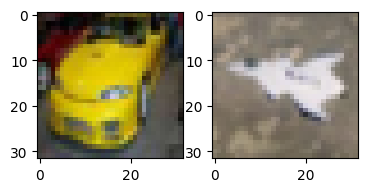

tensor([[[249, 224, 201,  ..., 212,  22, 252],
         [214,  23, 252,  ..., 251, 215,  19],
         [250, 212,  15,  ..., 195, 179, 156],
         ...,
         [247, 214,  10,  ..., 186, 167, 144],
         [252, 225, 200,  ..., 215,  24, 252],
         [213,  28,   1,  ..., 253, 216,  12]],

        [[247, 213,  17,  ..., 180, 163, 140],
         [249, 216, 197,  ..., 218,  28, 254],
         [217,  30,   2,  ...,   0, 219,  21],
         ...,
         [ 44,  32,  31,  ..., 127, 118, 143],
         [141, 111, 144,  ..., 171, 160, 159],
         [ 40,  35,  28,  ...,  16,  26,  30]],

        [[ 37,  46,  47,  ..., 207, 202, 217],
         [215, 196, 222,  ..., 206, 200, 198],
         [ 15,  19,  10,  ...,  19, 239, 247],
         ...,
         [236, 249, 206,  ..., 208, 246,   2],
         [212, 248,   8,  ...,  11, 203, 249],
         [ 14, 207, 252,  ..., 242,   6, 198]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


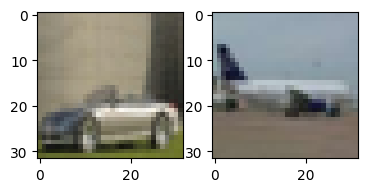

tensor([[[244, 252, 255,  ..., 253, 244, 249],
         [252, 243, 249,  ..., 249, 252, 241],
         [249, 251, 241,  ..., 246, 253, 255],
         ...,
         [222, 228, 104,  ..., 237, 244, 242],
         [236, 245, 244,  ..., 156, 150, 160],
         [167, 178, 188,  ..., 245, 246, 172]],

        [[180, 189,  81,  ..., 237, 244, 242],
         [241, 250, 249,  ..., 114,  93, 104],
         [118, 102, 113,  ..., 226, 229, 111],
         ...,
         [ 56, 237,  62,  ..., 224, 221, 207],
         [213, 210, 202,  ..., 140, 142, 138],
         [107, 114, 115,  ..., 194, 202, 211]],

        [[214, 207, 215,  ..., 216, 207, 211],
         [213, 204, 215,  ..., 115, 117, 105],
         [101, 104,  98,  ..., 140, 164, 160],
         ...,
         [239, 237, 214,  ..., 146, 173, 174],
         [143, 179, 179,  ..., 172, 125, 169],
         [170, 128, 169,  ..., 156, 158, 120]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


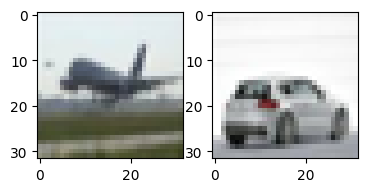

tensor([[[ 43,  32,  17,  ...,  27,  23,  15],
         [ 26,  22,  16,  ...,  21,  28,  33],
         [ 24,  32,  39,  ..., 104,  85,  62],
         ...,
         [ 80, 114,  80,  ..., 150, 148, 172],
         [ 81,  79, 116,  ..., 107,  62,  70],
         [108,  59,  66,  ...,  70, 109,  67]],

        [[ 70, 106,  54,  ..., 154, 150, 175],
         [ 90,  88, 124,  ..., 106,  64,  72],
         [109,  63,  70,  ...,  15,  55,   5],
         ...,
         [118, 108, 107,  ..., 240, 255, 241],
         [242,   3, 251,  ..., 173, 179, 199],
         [ 98,  98, 131,  ..., 140, 100,  97]],

        [[113,  66,  65,  ..., 147, 163, 160],
         [161, 179, 176,  ..., 162, 166, 190],
         [ 95,  94, 127,  ..., 122, 108, 106],
         ...,
         [ 61,  40,  80,  ...,  78,  55,  37],
         [ 76,  54,  32,  ...,  24,  85,  44],
         [ 22,  80,  41,  ...,  38,  23,  72]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


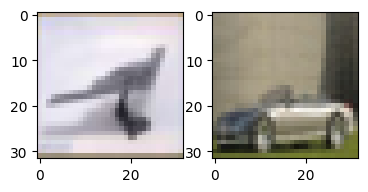

tensor([[[119, 129, 152,  ..., 112, 101, 103],
         [140,  92,  89,  ..., 128, 146, 116],
         [129, 150, 103,  ...,  91,  98, 128],
         ...,
         [ 40,  11,  63,  ..., 187, 200, 213],
         [ 19,  35,  59,  ...,  68, 117,  83],
         [ 40,  72,  29,  ..., 255, 249,  21]],

        [[240, 215,  63,  ..., 186, 198, 207],
         [ 15,  32,  56,  ...,  26,  92,  59],
         [ 33, 101,  63,  ..., 193, 187, 179],
         ...,
         [213, 172, 184,  ..., 145, 171, 179],
         [177, 188, 208,  ..., 183, 200, 215],
         [ 10,  10,  32,  ..., 205, 208, 217]],

        [[221, 203, 210,  ..., 169, 181, 241],
         [249,   3,   4,  ..., 182, 198, 213],
         [  6,   9,  32,  ..., 203, 178, 179],
         ...,
         [220, 237,   2,  ...,  37, 255,  14],
         [ 31,   0,  17,  ..., 233, 248, 223],
         [240, 255, 225,  ..., 207, 223, 237]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


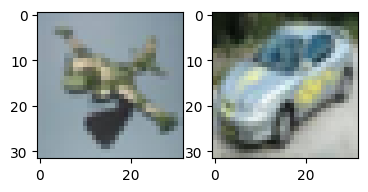

tensor([[[  1, 221, 190,  ..., 177,   2, 211],
         [175,   6, 213,  ..., 210, 176,  14],
         [217, 175,  18,  ..., 238, 208, 179],
         ...,
         [195, 211, 190,  ..., 227, 187, 158],
         [190, 181, 180,  ..., 248, 194, 224],
         [227, 198, 232,  ..., 197, 219, 245]],

        [[ 12,  46,  32,  ..., 221, 189, 170],
         [207, 189, 171,  ..., 161, 146, 142],
         [141, 143, 142,  ..., 247,  30, 244],
         ...,
         [ 52, 113, 112,  ..., 172, 226, 134],
         [155, 211, 138,  ..., 174, 183, 217],
         [162, 169, 185,  ..., 255,  49,  56]],

        [[ 63,  59,  65,  ..., 183, 224, 159],
         [177, 219, 160,  ..., 163, 177, 212],
         [184, 194, 195,  ..., 212, 237, 251],
         ...,
         [249,   6,  52,  ...,  23, 220, 238],
         [ 21, 219, 238,  ..., 231,  15, 213],
         [233,  17, 214,  ..., 247,   8,  47]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


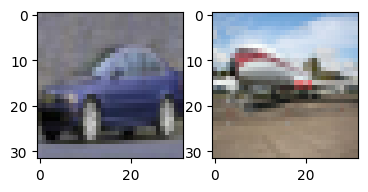

tensor([[[ 39,  90, 129,  ...,  96, 255,  54],
         [102, 243,  44,  ...,  41,  84, 246],
         [ 43,  85, 231,  ..., 241,  29,  59],
         ...,
         [160, 163, 139,  ..., 197, 235,   6],
         [ 53,  73,  93,  ...,  68,  19,  56],
         [ 70, 252,  34,  ..., 208, 223, 181]],

        [[202, 203, 166,  ...,  34,  68,  89],
         [ 63,  94, 113,  ...,  20, 216,  43],
         [ 50, 190,  22,  ...,  20,  36, 211],
         ...,
         [ 69, 180,  93,  ...,  64,  73, 172],
         [ 77,  81, 163,  ..., 119, 247, 243],
         [191, 200, 210,  ...,   3, 141,  47]],

        [[ 42, 175,  91,  ...,  42,  42, 139],
         [ 43,  41, 121,  ..., 112, 251, 247],
         [205, 212, 217,  ...,   8, 214,  61],
         ...,
         [193, 217, 208,  ...,  40,  46,  59],
         [ 41,  57,  66,  ..., 123, 112, 115],
         [126, 112,  97,  ..., 170, 204, 203]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


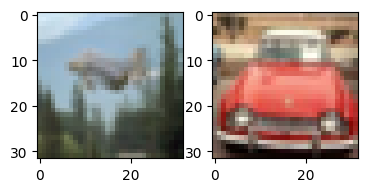

tensor([[[ 19, 208, 172,  ...,  84, 210, 127],
         [ 84, 210, 126,  ..., 123,  79, 207],
         [125,  79, 207,  ..., 200, 114,  68],
         ...,
         [222, 202, 254,  ..., 100, 248, 180],
         [  2, 181, 134,  ..., 179, 234, 197],
         [179, 164, 144,  ..., 228, 206,  22]],

        [[201, 178,  19,  ..., 125,  15, 213],
         [ 38, 213, 143,  ..., 195, 182, 151],
         [152,  99, 106,  ..., 191, 163,  10],
         ...,
         [141, 126, 121,  ..., 133, 111, 124],
         [121,  99,  99,  ..., 187, 173, 156],
         [210, 172, 145,  ..., 105, 125, 113]],

        [[ 99, 101,  94,  ..., 137, 118, 142],
         [138, 121, 101,  ..., 190, 178, 164],
         [ 21, 199, 153,  ...,  81, 105,  97],
         ...,
         [104,  17, 231,  ..., 203,  66, 249],
         [207,  45, 236,  ..., 185, 160, 239],
         [182, 157, 240,  ..., 243, 179, 159]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


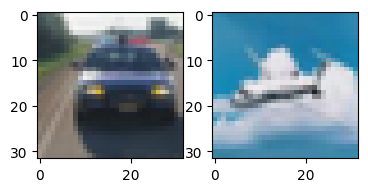

tensor([[[117, 131, 152,  ..., 168, 131, 143],
         [164, 139, 145,  ..., 149, 178, 133],
         [150, 174, 132,  ..., 233, 197, 186],
         ...,
         [ 29,  33,  20,  ..., 238, 203, 189],
         [164, 154, 158,  ...,  27,  73,  60],
         [ 59,  92,  80,  ..., 217, 218, 214]],

        [[203, 201, 202,  ..., 193, 176, 177],
         [168, 159, 158,  ...,  58,  99,  87],
         [ 85,  93,  69,  ..., 219, 214, 220],
         ...,
         [ 43,  22,  13,  ...,  30,  39,  50],
         [ 46,  55,  28,  ...,  38,  41,  62],
         [159, 164, 170,  ...,   4,  57,  50]],

        [[ 55, 252, 239,  ...,  87, 102,  85],
         [ 95, 111,  82,  ...,  14,  19,  40],
         [201, 200, 201,  ...,  37,  73,  65],
         ...,
         [130, 142, 214,  ...,  31, 190, 198],
         [ 16, 169, 182,  ..., 209,  24, 193],
         [208,  23, 194,  ..., 202, 207,  17]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


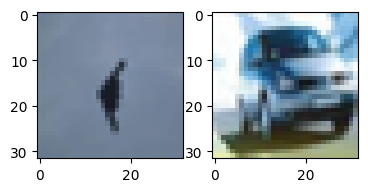

tensor([[[ 36, 192, 147,  ..., 200, 113,  13],
         [209, 116,  16,  ...,  23, 221, 114],
         [ 17, 213, 109,  ..., 243, 190, 161],
         ...,
         [236, 185,  67,  ..., 223, 175, 150],
         [230, 154, 127,  ..., 174,  69, 228],
         [171,  73, 237,  ..., 242, 188,  71]],

        [[236, 187,  69,  ..., 222, 172, 148],
         [223, 140, 118,  ..., 207,  72, 237],
         [193,  63, 244,  ..., 243, 207,  72],
         ...,
         [167,  17, 194,  ..., 246, 207,  70],
         [248, 213,  65,  ..., 193, 146, 127],
         [213, 134, 109,  ..., 138,  18, 196]],

        [[161,  39, 217,  ...,  62,  27, 142],
         [ 63,  27, 137,  ..., 203, 159, 136],
         [211, 134, 112,  ..., 151, 248, 171],
         ...,
         [194, 202, 149,  ..., 191, 246, 252],
         [196, 247,   1,  ...,   4, 187, 254],
         [  3, 189, 255,  ..., 254,   9, 200]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


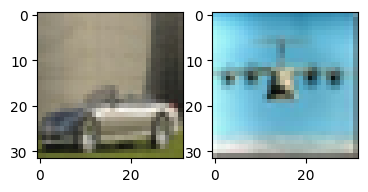

tensor([[[251,  68,  86,  ...,  71,   5,  52],
         [ 78,   0,  59,  ...,  54,  71, 252],
         [ 56,  67, 253,  ..., 250,  51,  71],
         ...,
         [ 84,  69,  88,  ...,  87,  76,  84],
         [255,  19,  27,  ...,  32, 107, 112],
         [110, 136, 148,  ..., 238, 226, 240]],

        [[  9, 249,  36,  ...,  91,  77,  87],
         [218, 237, 242,  ...,  29,  97, 104],
         [ 97, 104, 117,  ..., 211, 200, 183],
         ...,
         [215, 166, 231,  ..., 167, 172, 140],
         [176, 163, 130,  ...,  80,  98,  85],
         [  3,  69,  65,  ..., 223, 194,  10]],

        [[  1, 189,   9,  ..., 119, 128, 109],
         [144, 140, 125,  ...,  92, 118, 118],
         [236,  39,  43,  ...,  11, 210,  28],
         ...,
         [161, 161, 181,  ..., 147, 102, 103],
         [123,  80,  81,  ..., 162, 173, 171],
         [169, 182, 171,  ..., 165, 158, 175]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


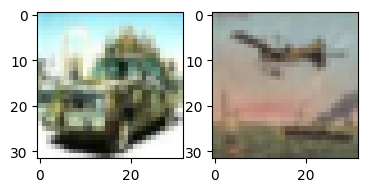

tensor([[[195, 208, 244,  ..., 239, 195, 204],
         [237, 194, 204,  ..., 193, 229, 180],
         [192, 230, 182,  ..., 172, 184, 221],
         ...,
         [156, 198, 138,  ..., 128, 151, 192],
         [149, 166, 210,  ..., 198, 165, 173],
         [205, 176, 182,  ..., 148, 189, 137]],

        [[149, 191, 136,  ..., 123, 148, 188],
         [139, 162, 205,  ..., 223, 150, 152],
         [175, 114, 114,  ...,  91, 129,  97],
         ...,
         [151, 186, 178,  ..., 153, 196, 144],
         [162, 200, 147,  ...,  76,  98, 144],
         [104, 129, 183,  ...,  74,  67,  64]],

        [[ 67,  94,  93,  ..., 113, 145, 115],
         [119, 145, 135,  ...,  76,  94, 142],
         [126, 148, 202,  ...,  71,  55,  55],
         ...,
         [223, 226,  13,  ..., 224, 200, 203],
         [222, 205, 210,  ..., 197, 207, 212],
         [215, 225, 217,  ..., 195, 206, 253]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


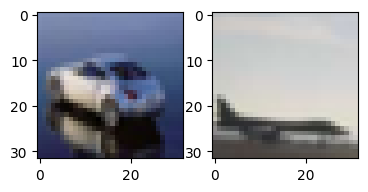

tensor([[[199, 189, 173,  ..., 190, 210, 207],
         [199, 231, 250,  ...,  62,  54,  99],
         [102,  86,  47,  ..., 237, 247, 251],
         ...,
         [137, 117,  56,  ..., 213, 212, 203],
         [185, 176, 151,  ..., 114,  98, 111],
         [ 94,  58,  86,  ..., 140, 117, 123]],

        [[134, 114,  97,  ..., 230, 245, 245],
         [228, 233, 221,  ..., 122, 148, 145],
         [123, 103, 152,  ..., 123, 105, 138],
         ...,
         [ 90,  10,  55,  ...,  93, 106,  73],
         [112, 111,  84,  ..., 188, 235, 238],
         [216, 238, 212,  ...,  58,   9,  57]],

        [[ 61,  31,  70,  ..., 187, 189, 134],
         [201, 199, 138,  ..., 155, 210, 227],
         [208, 199, 180,  ..., 232, 166, 183],
         ...,
         [ 59,  74,  21,  ..., 170, 146, 176],
         [158, 164, 212,  ..., 246, 176, 218],
         [235, 163,  33,  ..., 154, 163, 106]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


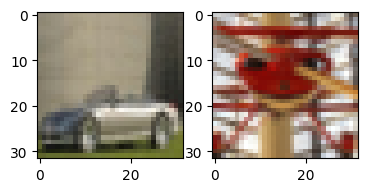

tensor([[[165, 204, 110,  ..., 110, 152, 164],
         [102, 146, 152,  ..., 147,  96, 216],
         [214, 148, 208,  ..., 148, 195, 106],
         ...,
         [201, 187,  25,  ..., 165, 166, 126],
         [190, 194, 150,  ..., 145, 191, 187],
         [177, 190, 186,  ..., 229, 222,  33]],

        [[ 21,  13,  50,  ..., 103, 109,  84],
         [199, 190, 160,  ..., 161, 255, 254],
         [246,  14,  19,  ...,  34,  32,  45],
         ...,
         [207, 221, 217,  ...,  30,  39,  84],
         [ 67,  75,  58,  ..., 137, 158, 150],
         [155, 173, 149,  ..., 188, 205, 198]],

        [[193, 210, 204,  ..., 254,   7,  91],
         [ 61,  70,  73,  ..., 122, 155, 144],
         [126, 167, 132,  ..., 143, 170, 171],
         ...,
         [112, 198, 131,  ..., 166, 156, 172],
         [158, 156, 160,  ..., 110, 109, 102],
         [126, 118, 117,  ..., 108, 198, 136]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


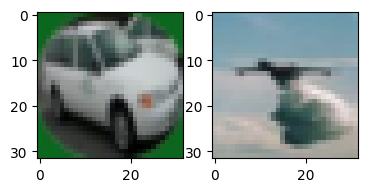

tensor([[[ 26, 239, 190,  ..., 153, 253, 206],
         [149, 249, 202,  ..., 167, 123, 240],
         [196, 144,  19,  ..., 236, 185, 121],
         ...,
         [119, 107, 164,  ..., 115,  56, 224],
         [247, 215, 157,  ..., 218, 225, 233],
         [211, 166, 173,  ..., 181, 153, 123]],

        [[115, 101, 170,  ...,  89,  34, 203],
         [217, 189, 135,  ..., 217, 203, 211],
         [181, 155, 162,  ..., 186, 158, 130],
         ...,
         [ 83, 121, 121,  ...,  34,  27, 204],
         [202, 196, 159,  ..., 180, 180, 162],
         [222, 218, 203,  ..., 143, 150, 148]],

        [[143, 166, 170,  ...,   9,   6, 206],
         [201, 192, 197,  ..., 175, 170, 155],
         [189, 183, 172,  ..., 191, 197, 195],
         ...,
         [192, 179, 170,  ..., 176, 195, 187],
         [175, 194, 186,  ..., 151, 140, 156],
         [149, 138, 164,  ..., 201, 192, 173]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


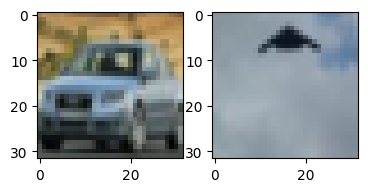

tensor([[[ 50,  33,  18,  ...,  29,  72,  57],
         [ 33,  81,  64,  ..., 102,  68, 118],
         [102,  67, 119,  ..., 131, 115,  78],
         ...,
         [121,  86, 147,  ..., 168, 140, 105],
         [109,  79,  39,  ...,   0,  45,  28],
         [253,  59,  43,  ..., 126,  94, 148]],

        [[127,  93, 151,  ..., 175, 145, 108],
         [115,  80,  42,  ...,  16,  54,  41],
         [ 20,  88,  78,  ..., 183, 154, 188],
         ...,
         [166, 154, 159,  ..., 204, 164, 249],
         [223, 191, 249,  ...,  49,  28, 242],
         [ 70,  34, 248,  ...,  49,   9,   9]],

        [[ 12,  13,  10,  ..., 221, 195, 245],
         [234, 217, 234,  ...,  66,  48,   3],
         [ 87,  56,  14,  ...,  85,  78,  72],
         ...,
         [ 93,  88,  48,  ...,  93, 128, 122],
         [108, 123, 115,  ..., 117, 113, 105],
         [101,  96,  96,  ...,  89,  78,  40]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


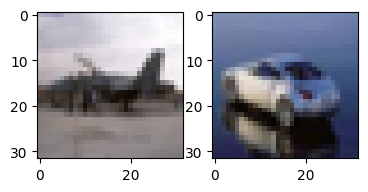

tensor([[[ 63,  62,  50,  ...,  59,  67,  67],
         [ 59,  65,  65,  ...,  63,  58,  66],
         [ 65,  60,  64,  ...,  85,  78,  67],
         ...,
         [166, 160, 167,  ...,  86,  85,  80],
         [ 92,  87,  72,  ..., 243, 254, 255],
         [247,   9,  11,  ...,  31,  25,  30]],

        [[ 31,  26,  26,  ...,  90,  89,  84],
         [ 94,  90,  76,  ...,  22,  31,  32],
         [ 25,  33,  35,  ...,  51,  46,  51],
         ...,
         [  7, 224, 225,  ..., 222, 208,  20],
         [ 20,  10, 105,  ..., 173, 172, 166],
         [169, 162, 145,  ...,  64,  41,  39]],

        [[ 28, 243, 240,  ..., 218, 204,  39],
         [ 38,  27,  70,  ..., 167, 164, 153],
         [172, 165, 147,  ...,  74,  60,  56],
         ...,
         [107,  96,  84,  ...,  94, 102,  94],
         [ 90, 101,  92,  ...,  95,  89, 107],
         [101,  94, 110,  ..., 126, 124, 120]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


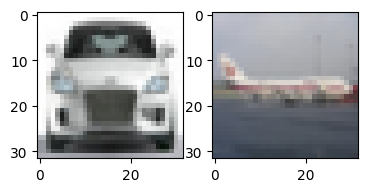

tensor([[[ 96, 104, 119,  ..., 103,  65,  75],
         [100,  64,  75,  ...,  81, 104,  74],
         [ 83, 108,  76,  ..., 128, 132, 141],
         ...,
         [ 85, 109,  77,  ..., 157, 160, 170],
         [103, 108, 128,  ..., 108,  72,  82],
         [109,  68,  77,  ...,  73, 100,  75]],

        [[ 83, 107,  72,  ..., 165, 166, 176],
         [ 84,  89, 108,  ..., 108,  71,  81],
         [107,  68,  77,  ...,  41,  67,  63],
         ...,
         [ 76,  83,  84,  ...,  52,  59,  27],
         [ 29,  38, 234,  ..., 173, 177, 181],
         [103, 109, 130,  ...,  91,  85,  84]],

        [[ 89,  61,  62,  ..., 226, 234, 187],
         [189, 199, 106,  ..., 154, 156, 164],
         [ 95, 100, 121,  ...,  87,  91,  91],
         ...,
         [122, 116, 175,  ..., 125,  72,  67],
         [129,  75,  66,  ...,  79, 158,  79],
         [ 70, 147,  79,  ...,  79,  72, 145]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


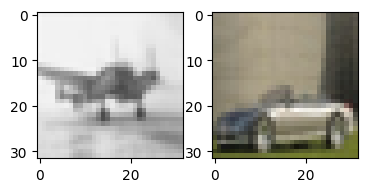

tensor([[[ 81,  86, 102,  ...,  79,  22,  34],
         [ 65,  32,  43,  ...,  47,  67,  45],
         [ 49,  75,  56,  ..., 128, 126, 134],
         ...,
         [219,  13, 195,  ..., 142, 140, 147],
         [ 78,  78,  88,  ...,   7, 173, 190],
         [232, 127, 145,  ..., 217,   8, 207]],

        [[230,  22, 174,  ..., 149, 145, 152],
         [ 97,  95, 104,  ...,  50, 185, 195],
         [235, 154, 167,  ..., 233,  19, 198],
         ...,
         [ 74,  96,  91,  ..., 208, 239, 149],
         [162, 193, 157,  ..., 185, 185, 178],
         [ 97, 105, 102,  ...,  69,  75,  67]],

        [[ 61,  66,  60,  ..., 118, 154,  69],
         [ 80, 108, 156,  ..., 176, 174, 169],
         [ 81,  85,  84,  ...,  44,  81,  74],
         ...,
         [156, 150, 208,  ..., 203, 144, 140],
         [202, 144, 135,  ...,  54, 132,  78],
         [ 71, 149,  74,  ...,  81,  71, 146]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


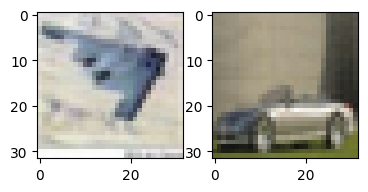

tensor([[[159, 165, 145,  ...,  29,  80,  66],
         [ 29,  80,  66,  ...,  69,  30,  87],
         [ 69,  30,  87,  ...,  84,  69,  28],
         ...,
         [ 31, 247,  61,  ...,  45,  40,  20],
         [201, 203, 149,  ..., 243, 110, 101],
         [ 78, 133, 146,  ...,   2, 223,  42]],

        [[ 17, 239,  71,  ...,  64,  76,  43],
         [146, 143,  88,  ...,  17, 118, 139],
         [124,  91, 151,  ...,  25, 242, 251],
         ...,
         [203, 222, 227,  ..., 212, 190,   8],
         [254, 232,  14,  ..., 207, 218, 179],
         [151, 141, 123,  ..., 222,  51,  41]],

        [[  1,  39,  49,  ..., 218, 181, 251],
         [250, 224,  46,  ..., 204, 213, 176],
         [143, 137, 122,  ..., 207, 254, 244],
         ...,
         [180, 163, 133,  ..., 182, 216, 222],
         [188, 220, 223,  ..., 226, 195, 217],
         [227, 196, 214,  ..., 185, 190, 155]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


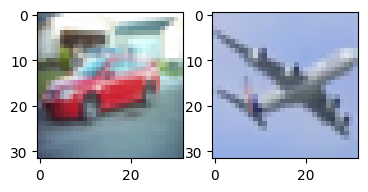

tensor([[[  6, 197, 243,  ...,  62,  47,  13],
         [ 55,  43,   7,  ...,   6,  18,  93],
         [251, 248,  76,  ..., 236, 163, 206],
         ...,
         [ 33,  49, 230,  ..., 225, 190,  99],
         [ 48, 218, 236,  ...,  63, 187, 185],
         [ 63, 187, 186,  ...,  68,  86,  81]],

        [[ 64,  62,  18,  ..., 221, 192,  45],
         [114,   3, 251,  ...,  69, 186, 185],
         [ 60, 255, 254,  ..., 107, 111, 170],
         ...,
         [156, 248, 245,  ..., 227, 136, 233],
         [225,  55,  13,  ..., 201, 140, 152],
         [ 18, 204,  11,  ..., 157, 210, 205]],

        [[152, 225, 222,  ..., 220,  88, 229],
         [211,  16,  17,  ..., 189, 127, 142],
         [175, 144, 228,  ...,  74, 205, 197],
         ...,
         [200, 149,  82,  ...,  16, 235, 207],
         [ 24, 245, 215,  ..., 207,   8, 245],
         [204,  20, 240,  ..., 137, 121, 219]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


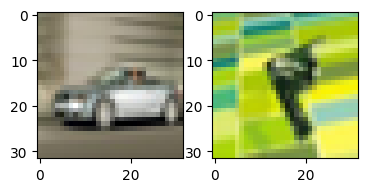

tensor([[[  0,  27,  70,  ..., 176,  89, 132],
         [177,  90, 133,  ..., 132, 178,  89],
         [130, 176,  90,  ...,  75, 115, 162],
         ...,
         [ 42,  66,  38,  ..., 202, 246,  57],
         [ 34,  56, 107,  ...,  64,   0,  33],
         [ 72,  38,  67,  ...,  38,  62,  35]],

        [[ 60,  88,  44,  ..., 178, 225,  20],
         [  3,  26,  99,  ...,  79,  25,  59],
         [ 90,  42,  71,  ...,  67,  97,  52],
         ...,
         [133,  49,  84,  ...,  66, 113,  18],
         [ 69, 119,  43,  ..., 193, 246,  43],
         [213,  12,  65,  ..., 130,  53,  93]],

        [[133,  64, 100,  ...,  66, 112,  27],
         [ 69, 116,  56,  ..., 195, 247,  36],
         [215,  16,  69,  ..., 142,  60,  99],
         ...,
         [171, 232,  12,  ...,  43, 207,   6],
         [ 40, 230,  18,  ...,  67,  99,  36],
         [ 67,  98,  33,  ...,  20,  52,  82]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


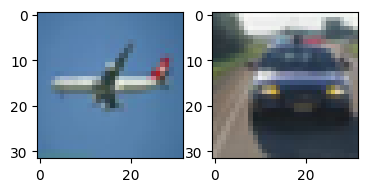

tensor([[[114, 126, 133,  ...,  18,  26,  26],
         [ 18,  26,  27,  ...,  29,  24,  28],
         [ 29,  24,  29,  ...,  27,  32,  27],
         ...,
         [  8,  12,  13,  ...,  31,  40,  27],
         [179, 185, 156,  ..., 168, 239, 240],
         [236, 253,  21,  ..., 232, 243, 247]],

        [[249,   4,  16,  ...,   3,  28,   9],
         [118, 122,  95,  ..., 240, 252,  27],
         [ 31, 210,  23,  ..., 252,   1, 203],
         ...,
         [ 56,  75,  91,  ...,  48,  45,  36],
         [ 41,  35,  22,  ..., 174, 211, 217],
         [152, 150, 161,  ..., 169,  57,  66]],

        [[ 79, 107, 126,  ...,  99,  97,  62],
         [ 78,  82,  63,  ..., 184, 211, 216],
         [151, 150, 160,  ..., 128, 188, 201],
         ...,
         [128, 134, 150,  ..., 192, 145, 182],
         [212, 144, 182,  ..., 185, 210, 156],
         [202, 226, 157,  ..., 185, 212, 209]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


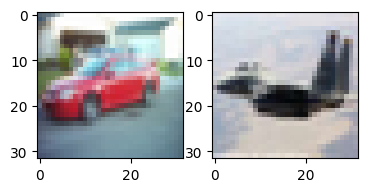

tensor([[[255,  15,  93,  ..., 117,   1,  38],
         [101,   3,  34,  ..., 216,  91, 175],
         [209,  79, 191,  ..., 201,  18,  75],
         ...,
         [124, 101,  80,  ...,  14,  16,  84],
         [241,  47, 119,  ...,  21,  68,  86],
         [ 14,  62,  86,  ..., 116, 120,  73]],

        [[122, 114,  74,  ..., 245, 249,  67],
         [227, 245,  70,  ...,  21,  62,  77],
         [ 20,  57,  72,  ..., 113, 125,  65],
         ...,
         [107,  74, 114,  ...,  90,  29, 103],
         [112,  18, 194,  ..., 228, 244,  70],
         [222, 236,  73,  ..., 127,  74,  99]],

        [[131,  66,  98,  ..., 120,  93, 115],
         [136,  52, 201,  ..., 244,   6,  87],
         [218, 229,  65,  ..., 129,  71, 103],
         ...,
         [213, 217,  33,  ...,   1, 216, 197],
         [254, 223, 205,  ..., 202,   5, 197],
         [200,  12, 197,  ..., 222, 227,  52]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


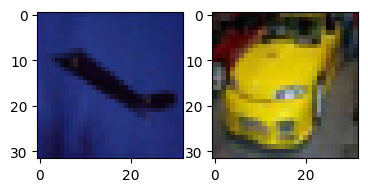

tensor([[[ 21,  14,   9,  ..., 255,  20,  10],
         [  2,   9,  11,  ...,  12, 255,  18],
         [ 11, 253,  23,  ..., 171, 207, 240],
         ...,
         [184, 165, 224,  ..., 237, 247,   6],
         [ 47,  43,  31,  ..., 217, 155, 156],
         [158, 151, 139,  ..., 255, 240,  29]],

        [[ 11, 255,  42,  ...,  30,  24,  19],
         [ 45,  42,  34,  ..., 200, 116, 125],
         [115, 144, 150,  ...,   6, 253,  29],
         ...,
         [235,  38,  63,  ..., 225, 193, 212],
         [223, 188, 200,  ..., 162, 147, 124],
         [ 41,  28,  18,  ..., 212, 175, 188]],

        [[177,  30,  51,  ..., 157, 129, 167],
         [160, 132, 152,  ..., 184, 168, 145],
         [  0, 248, 243,  ..., 178, 140, 146],
         ...,
         [254, 253, 191,  ..., 121, 202, 203],
         [137, 224, 221,  ..., 201, 146, 205],
         [201, 148, 201,  ..., 187, 189, 140]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


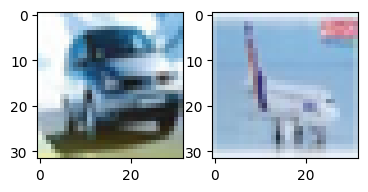

tensor([[[ 42, 130,  56,  ...,  52,  36,  84],
         [ 42,  27,  69,  ...,  67,  38,  90],
         [137,  93,  81,  ...,  49, 139,  67],
         ...,
         [137, 133, 190,  ...,  85, 117,  86],
         [110, 148, 118,  ..., 100,  79,  96],
         [ 93,  77,  92,  ..., 179, 178, 218]],

        [[225, 224, 238,  ...,  69,  79,  66],
         [123, 144, 126,  ...,  98,  77,  91],
         [ 89,  75,  87,  ..., 244, 245, 239],
         ...,
         [202, 194, 197,  ...,  64,  66,  83],
         [ 85,  87,   4,  ..., 147, 165, 157],
         [152, 179, 158,  ..., 213, 195, 196]],

        [[195, 216, 217,  ..., 180, 182, 242],
         [243, 245, 240,  ..., 140, 166, 154],
         [136, 181, 145,  ..., 222, 236, 238],
         ...,
         [100, 191, 118,  ..., 140, 130, 153],
         [132, 140, 154,  ..., 137, 129, 132],
         [151, 136, 162,  ..., 169,   3, 187]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


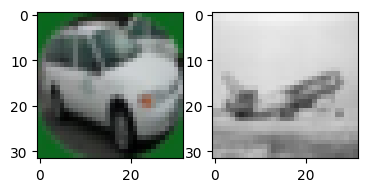

tensor([[[243, 214, 214,  ..., 171, 181, 160],
         [167, 178, 158,  ..., 141, 150, 166],
         [147, 150, 167,  ..., 179, 162, 164],
         ...,
         [249,  14, 172,  ..., 201, 181, 183],
         [  5, 232, 233,  ..., 188, 196, 180],
         [179, 191, 178,  ..., 204, 231, 215]],

        [[219, 246, 176,  ..., 213, 193, 194],
         [  4, 232, 223,  ..., 186, 183, 170],
         [166, 175, 164,  ..., 184, 210, 197],
         ...,
         [ 34,  87,  90,  ..., 230,  14, 232],
         [229,  13, 249,  ..., 200, 183, 208],
         [224, 209, 213,  ...,   6,  72,  71]],

        [[ 73,  95,  94,  ..., 228,   6, 227],
         [226,   3, 235,  ..., 204, 190, 211],
         [232, 219, 208,  ..., 228,  31,  30],
         ...,
         [ 53,  42,  79,  ...,  54,  24,  22],
         [ 55,  25,  23,  ...,  16,  47,  13],
         [ 17,  50,  15,  ...,  57,  53,  83]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


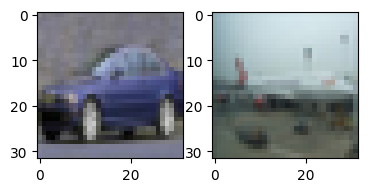

tensor([[[157, 143, 122,  ..., 122, 149, 143],
         [116, 159, 151,  ..., 136, 117, 157],
         [150, 126, 151,  ..., 172, 160, 135],
         ...,
         [223, 209, 221,  ..., 183, 170, 139],
         [  7, 239, 196,  ..., 134,  16, 237],
         [152,  33, 253,  ..., 172, 176, 248]],

        [[237, 228, 201,  ..., 187, 174, 139],
         [  3, 236, 190,  ..., 135, 237, 198],
         [127,  13, 232,  ..., 171, 173, 206],
         ...,
         [168, 129, 150,  ...,  76,   5, 105],
         [107,  43, 108,  ..., 194, 212, 218],
         [160, 177, 217,  ..., 198, 161, 184]],

        [[198, 162, 186,  ..., 125,  24, 117],
         [120,  23, 111,  ..., 191, 213, 225],
         [167, 177, 248,  ...,  14, 195, 214],
         ...,
         [231, 224,  58,  ...,  46, 224, 216],
         [ 49, 220, 210,  ..., 195,  19, 162],
         [162, 250, 198,  ..., 239, 233,  78]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


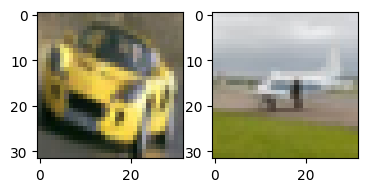

tensor([[[140, 179, 220,  ..., 215, 147, 176],
         [216, 146, 177,  ..., 155, 200, 127],
         [160, 206, 120,  ..., 228,   6,  67],
         ...,
         [ 51,  57,  55,  ...,  46,  58,  81],
         [136, 159, 190,  ..., 161,  90, 104],
         [125, 108, 120,  ...,  70,  73,  77]],

        [[ 83,  91,  83,  ...,  51,  66,  79],
         [140, 161, 187,  ...,  70, 244,   1],
         [ 14, 231, 241,  ...,  46,  50, 115],
         ...,
         [ 17,  72,  69,  ..., 101, 103, 119],
         [124, 130, 126,  ...,  46,  42,  53],
         [136, 128, 122,  ..., 117,  36,  36]],

        [[ 41, 115, 114,  ..., 125, 124, 121],
         [130, 131, 113,  ...,  42,  40,  43],
         [134, 127, 123,  ...,  43, 242, 246],
         ...,
         [108, 103, 104,  ...,  73,  95,  88],
         [ 76,  93,  88,  ...,  65,  59,  67],
         [ 64,  58,  70,  ...,  73,  70,  77]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


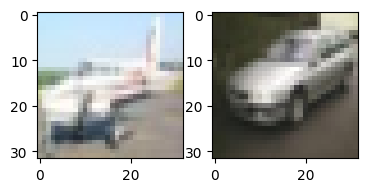

tensor([[[ 77,  11, 122,  ..., 130,  84,  60],
         [138,  92,  74,  ...,  82, 147,  38],
         [ 15,  95,  46,  ...,  84,  17, 124],
         ...,
         [ 29,  69, 209,  ...,  62,  53, 121],
         [ 34,  19,  83,  ..., 109,  68,  75],
         [112,  61,  66,  ..., 244,  24, 183]],

        [[200, 237, 164,  ...,  80,  94, 143],
         [ 23,  25,  77,  ...,  81,  28,  28],
         [ 49,   7,   9,  ..., 130, 151, 164],
         ...,
         [ 42, 238,   3,  ..., 254,  31, 203],
         [225,   3, 213,  ...,  30,  35,  82],
         [ 36,  32,  87,  ...,  65,   1,  24]],

        [[ 59, 252,  19,  ...,  47,  80, 211],
         [234,  12, 212,  ...,  30,  28,  77],
         [ 54,  32, 102,  ..., 110,  25,  47],
         ...,
         [ 83,  15, 124,  ..., 105,  55,  56],
         [113,  60,  70,  ..., 118, 162,  97],
         [102, 153,  80,  ...,  83,  17, 127]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


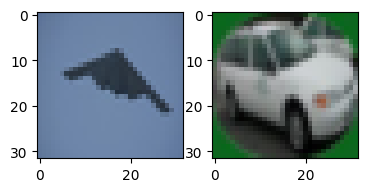

tensor([[[253,  77,  88,  ..., 100,   7,  78],
         [106, 253,  81,  ...,  66,  90, 233],
         [ 70,  88, 232,  ..., 236,  52,  59],
         ...,
         [209, 191, 195,  ...,  82,  89,  99],
         [ 71, 124, 118,  ..., 126, 110, 120],
         [113,  98, 115,  ..., 164, 161, 123]],

        [[154, 148, 128,  ...,  90,  92,  99],
         [  9,  45,  39,  ..., 126, 162, 214],
         [200, 146, 215,  ..., 192, 183, 114],
         ...,
         [ 98, 144, 158,  ..., 209, 202, 205],
         [ 22, 251, 214,  ...,  18,  11, 234],
         [246,  40,  18,  ..., 208, 174, 173]],

        [[157, 196, 223,  ..., 112, 116, 200],
         [190, 186, 224,  ...,  52,  39,  32],
         [228,  11, 246,  ...,  37, 227, 241],
         ...,
         [ 92,  82,  86,  ..., 175, 147, 130],
         [145, 115,  98,  ..., 166, 178, 187],
         [167, 179, 194,  ..., 160, 164, 183]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


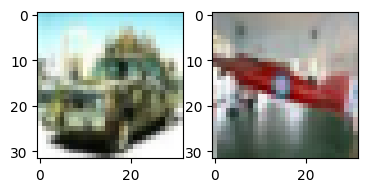

tensor([[[186, 194, 145,  ..., 151, 197, 214],
         [152, 216, 232,  ..., 163, 120, 171],
         [172, 127, 171,  ..., 142, 139,  94],
         ...,
         [217, 135, 194,  ..., 138, 137,  92],
         [154, 157,  95,  ..., 150, 240, 232],
         [156,   2, 247,  ..., 248, 148,  10]],

        [[244, 150,   1,  ..., 134, 137,  96],
         [151, 156,  97,  ..., 236, 240, 237],
         [184, 233, 228,  ..., 254, 172,   7],
         ...,
         [170, 199, 198,  ...,  54,  22,  47],
         [ 46,  15,   9,  ..., 130, 131, 110],
         [175, 187, 152,  ..., 111, 150, 154]],

        [[119, 161, 159,  ...,  24, 242,  98],
         [ 96,  68,  56,  ..., 186, 182, 166],
         [181, 192, 158,  ..., 105, 174, 174],
         ...,
         [ 13,  33,  55,  ...,  46,  11,  19],
         [ 44,   9,  16,  ...,  12,  46,   8],
         [ 10,  45,   8,  ...,   2,   7,  46]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


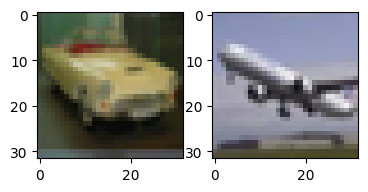

tensor([[[127, 127, 105,  ..., 149, 176, 167],
         [149, 176, 168,  ..., 157, 139, 160],
         [153, 135, 156,  ..., 101, 101,  80],
         ...,
         [168, 142, 189,  ..., 148, 143, 121],
         [138, 136, 110,  ..., 223, 217, 254],
         [220, 203, 242,  ..., 146, 117, 165]],

        [[192, 157, 172,  ..., 120, 118,  99],
         [141, 134, 108,  ..., 233, 224,   7],
         [242, 232,  19,  ..., 252, 226, 223],
         ...,
         [ 67, 114, 129,  ..., 125, 117,  23],
         [113, 102,  17,  ..., 153, 141, 108],
         [161, 157, 132,  ...,  59, 104, 114]],

        [[ 95,  55,  66,  ...,   2, 250, 249],
         [ 23,  11, 252,  ..., 165, 154, 114],
         [129, 126, 103,  ...,  33,  80,  90],
         ...,
         [116, 109,  90,  ...,  85, 109, 102],
         [ 85, 109, 102,  ...,  98,  80, 105],
         [ 98,  80, 105,  ..., 102,  95,  77]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


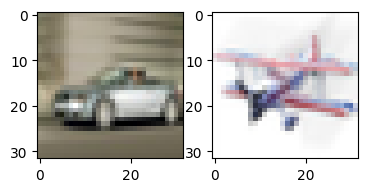

tensor([[[ 52,  53,  45,  ...,   2,  13,  15],
         [  2,  15,  16,  ...,  45,  30,  47],
         [ 48,  41,  55,  ...,  61,  62,  54],
         ...,
         [  9, 240,  56,  ...,  83,  84,  77],
         [ 39,  40,  35,  ...,  33,  63,  60],
         [ 55,  64,  58,  ...,  16, 242,  22]],

        [[  3, 229,  43,  ...,  48,  49,  44],
         [ 28,  30,  35,  ...,  21,  62,  55],
         [ 55,  52,  44,  ...,  13, 242,  25],
         ...,
         [ 45, 213, 212,  ...,  19, 240,  27],
         [ 23, 244,  28,  ..., 128, 130, 105],
         [129, 131, 128,  ...,  36, 249, 248]],

        [[250, 196, 196,  ...,  39,  11,  46],
         [ 41,  13,  58,  ..., 129, 130, 110],
         [111, 110, 121,  ...,  42, 240, 240],
         ...,
         [ 25,  25, 253,  ..., 243,   6,   4],
         [242,   4,   2,  ...,  87,  68,  95],
         [ 93,  73,  62,  ...,  40,  39,  16]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


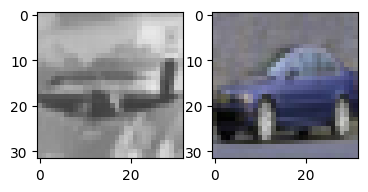

tensor([[[158,  66, 247,  ..., 250, 135,  40],
         [249, 136,  39,  ...,  37, 247, 139],
         [ 39, 247, 139,  ..., 152,  61, 242],
         ...,
         [ 30, 254, 131,  ..., 146,  51, 248],
         [134,  52,   2,  ...,   0, 129,  30],
         [254, 130,  31,  ...,  29, 254, 129]],

        [[ 29, 254, 127,  ..., 144,  50, 247],
         [137,  52,   4,  ..., 255, 131,  30],
         [  2, 132,  30,  ...,  32,   0, 130],
         ...,
         [ 56,  95,  47,  ..., 233, 203,  45],
         [227, 209,  47,  ..., 148,  49,   2],
         [148,  52,   0,  ..., 150, 126, 140]],

        [[130, 112, 126,  ...,   5, 206,  39],
         [206, 179,  31,  ..., 149,  52,   4],
         [148,  52,   0,  ..., 160, 146, 166],
         ...,
         [ 40, 216, 171,  ..., 172,  30, 195],
         [172,  30, 194,  ..., 195, 176,  38],
         [199, 176,  37,  ...,  54, 224, 173]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


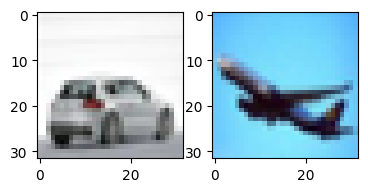

tensor([[[ 62, 100, 129,  ..., 137,  66, 107],
         [137,  66, 106,  ..., 109, 146,  72],
         [107, 144,  74,  ...,  72, 108, 145],
         ...,
         [ 60,  99,  26,  ..., 110, 150, 187],
         [104, 144, 187,  ...,  20, 202, 233],
         [ 15, 194, 225,  ..., 206, 244, 171]],

        [[204, 241, 175,  ..., 115, 156, 191],
         [108, 147, 189,  ..., 244, 174, 204],
         [243, 174, 204,  ..., 200, 235, 159],
         ...,
         [240, 220, 238,  ..., 131, 140,  55],
         [ 74,  80, 224,  ..., 142, 175, 198],
         [ 90, 160, 183,  ...,   3, 229,  20]],

        [[ 41,  29,  67,  ...,  96, 110, 246],
         [ 21,  33, 213,  ..., 122, 167, 191],
         [ 77, 153, 177,  ...,   8, 212,  13],
         ...,
         [114, 199, 199,  ..., 218, 146, 218],
         [225, 153, 221,  ..., 220, 243, 141],
         [215, 238, 135,  ..., 110, 180, 194]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


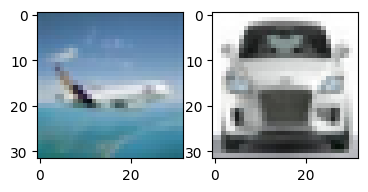

tensor([[[ 33,  26,  17,  ...,  20,  35,  28],
         [ 20,  35,  28,  ..., 230, 224, 238],
         [228, 222, 232,  ..., 239, 237, 243],
         ...,
         [212, 193, 245,  ..., 227, 214, 207],
         [ 33,  25,  17,  ..., 195, 118, 181],
         [170, 106,  75,  ..., 238, 237, 216]],

        [[205, 181, 237,  ..., 242, 228, 217],
         [ 33,  25,  17,  ..., 142,  63, 159],
         [155,  70,  58,  ..., 183, 166, 232],
         ...,
         [130, 157, 134,  ..., 228, 207, 235],
         [223, 219, 201,  ..., 224, 207, 188],
         [219, 183, 147,  ..., 111, 149, 122]],

        [[114, 135, 110,  ..., 214, 177,   5],
         [248, 250, 240,  ..., 224, 205, 186],
         [188, 150, 125,  ..., 112, 135, 114],
         ...,
         [180, 142, 113,  ..., 150, 209, 185],
         [150, 205, 180,  ..., 189, 160, 218],
         [199, 172, 213,  ..., 205, 188, 168]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


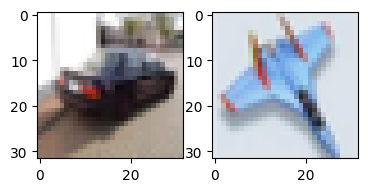

tensor([[[ 33,  83,  72,  ..., 105,  36, 120],
         [112,  33, 111,  ..., 102,  80,  61],
         [ 96,  70,  65,  ...,  37,  89,  70],
         ...,
         [160, 172, 243,  ..., 191,  36,  44],
         [ 34, 138, 133,  ...,  59,   4,  81],
         [ 73, 237,  74,  ..., 178, 195,  52]],

        [[153, 172, 220,  ..., 183,  32,  42],
         [ 50, 141, 133,  ..., 151,  14, 118],
         [121, 221,  70,  ..., 160, 167,  15],
         ...,
         [ 23,  67, 232,  ..., 244,  21,  52],
         [159, 179,   1,  ..., 237,  93, 111],
         [ 45, 128, 107,  ..., 183, 103, 229]],

        [[231,  82, 212,  ..., 188, 223,  13],
         [123, 144, 236,  ..., 226,  84,  98],
         [ 45, 133, 111,  ..., 144,  84, 188],
         ...,
         [242,  82,  76,  ..., 103,  16, 118],
         [120,  15, 118,  ...,  69,  75, 215],
         [ 68,  72, 214,  ...,  30, 127, 137]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


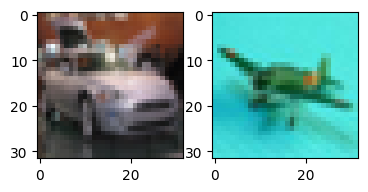

tensor([[[ 68,  73,  98,  ...,  73,  38,  52],
         [ 73,  39,  52,  ...,  59,  80,  50],
         [ 62,  83,  53,  ...,  82,  87, 111],
         ...,
         [ 82, 104,  72,  ...,  56,  65,  88],
         [ 77,  96, 122,  ...,  72,  36,  52],
         [ 73,  37,  53,  ..., 102, 123,  97]],

        [[105, 125,  99,  ...,  84,  92, 115],
         [ 59,  77, 105,  ...,  68,  34,  51],
         [ 67,  36,  51,  ...,  45,  67,  36],
         ...,
         [ 67,  37,  21,  ...,  23,  26,  16],
         [ 23,  26,  16,  ...,  99, 113, 129],
         [ 42,  57,  84,  ...,  71,  80,  73]],

        [[ 82,  65,  56,  ...,  42,  46,  32],
         [ 38,  45,  32,  ..., 112, 125, 139],
         [ 74,  88, 113,  ..., 125,  78,  79],
         ...,
         [ 79,  94, 113,  ..., 140, 107, 122],
         [141, 108, 123,  ..., 126, 146, 110],
         [125, 145, 109,  ...,  94, 108, 128]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


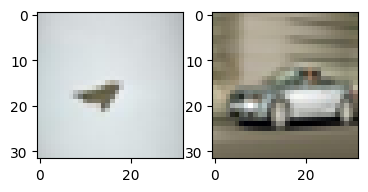

tensor([[[201, 228, 240,  ..., 237, 195, 217],
         [235, 197, 220,  ..., 200, 233, 165],
         [199, 230, 178,  ..., 229, 249,  29],
         ...,
         [253,  47, 206,  ..., 234,  27,  62],
         [247,  22,  39,  ...,  98,  48,  73],
         [ 98,   2,  34,  ...,   3,  51, 229]],

        [[ 14,  57, 221,  ..., 225,  21,  56],
         [255,  30,  46,  ...,  40,  32,  58],
         [ 85, 241,  13,  ..., 235,   6, 179],
         ...,
         [ 65, 230,  40,  ...,  85, 172, 163],
         [ 88, 183, 167,  ..., 253,  16, 107],
         [250,  28,  97,  ...,  84, 250,  20]],

        [[ 41, 175, 251,  ...,  90, 181, 171],
         [ 96, 191, 181,  ..., 255,  20, 105],
         [244,  18,  92,  ...,  75, 230,   4],
         ...,
         [233,   2,  78,  ..., 101, 249,  12],
         [ 90, 246,  11,  ...,  25, 121,   3],
         [ 22, 113, 251,  ..., 250,  21, 108]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


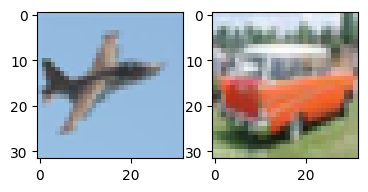

tensor([[[226, 252,  17,  ..., 251, 183, 215],
         [245, 187, 220,  ..., 227,   4, 202],
         [232,  12, 206,  ...,  27,  54,  74],
         ...,
         [231,   1, 194,  ...,  38,  68,  89],
         [220, 249,  16,  ...,  14,   7,  23],
         [ 10, 239,   0,  ..., 221, 251, 193]],

        [[224, 250, 203,  ...,  41,  69,  89],
         [219, 247,  15,  ...,   9,  37,  47],
         [  8,  32,  42,  ..., 239, 255, 243],
         ...,
         [ 73, 101,  95,  ..., 225, 166,   3],
         [247, 187,  29,  ...,  70,  98,  98],
         [197, 224, 251,  ...,  37,  54,  49]],

        [[ 32,  45,  39,  ..., 150, 132, 156],
         [163, 133, 184,  ...,  85, 100,  91],
         [201, 227, 253,  ...,  11,  51,  39],
         ...,
         [236, 251,  58,  ...,  65, 235, 249],
         [ 55, 223, 233,  ..., 254,  75, 245],
         [253,  73, 229,  ...,   6,   9,  78]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


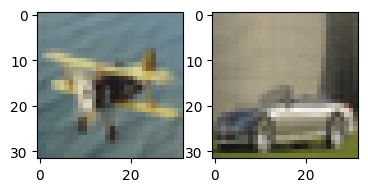

tensor([[[153, 128,  93,  ...,  82, 156, 123],
         [ 83, 154, 122,  ..., 120,  82, 155],
         [122,  84, 152,  ..., 158, 129,  94],
         ...,
         [188, 151, 217,  ..., 105,  84,  62],
         [ 74,  69,  50,  ..., 216, 234, 231],
         [214, 234, 233,  ...,  48,  14,  79]],

        [[ 51,  15,  74,  ..., 124,  99,  72],
         [ 47,  48,  32,  ..., 247,   2, 255],
         [239, 248, 247,  ...,  70,  34, 100],
         ...,
         [159, 174, 154,  ..., 179, 145, 244],
         [212, 178,  57,  ..., 139, 108,  76],
         [105,  90,  77,  ..., 219, 226, 209]],

        [[182, 191, 167,  ..., 159, 122,   5],
         [234, 203,  13,  ..., 134, 104,  74],
         [110,  94,  79,  ..., 228, 251, 232],
         ...,
         [ 62,  34,   3,  ..., 240,  24, 255],
         [229,  15, 246,  ...,  12, 236,  51],
         [ 17, 241,  54,  ...,  63,  35,  11]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


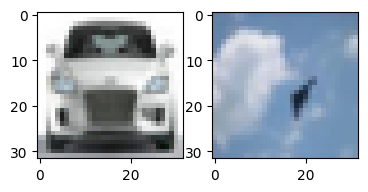

tensor([[[ 78,  66,  49,  ...,  41,  68,  55],
         [ 44,  54,  51,  ...,  49,  29,  67],
         [ 49,  33,  67,  ..., 212, 251,  16],
         ...,
         [208, 207, 206,  ..., 248,  40,  55],
         [ 70,  92,  84,  ..., 215, 154, 177],
         [185, 139, 164,  ...,  26,  26,  15]],

        [[ 38,  42,  28,  ...,  41,  71,  72],
         [ 68,  91,  88,  ..., 184, 127, 151],
         [159, 131, 167,  ...,  34,  44,  12],
         ...,
         [239, 226, 253,  ..., 224, 234, 172],
         [207, 221, 192,  ..., 185, 209, 208],
         [100, 115, 119,  ...,  27, 190, 215]],

        [[229, 255,  30,  ..., 168, 171, 136],
         [156, 161, 135,  ..., 206, 230, 229],
         [ 62,  80,  91,  ..., 235, 161, 190],
         ...,
         [126, 143,  88,  ..., 252,  48,  65],
         [ 13,  66,  79,  ...,  42, 248,  24],
         [ 44, 251,  29,  ...,  32,  55,   9]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


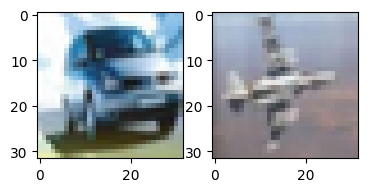

tensor([[[ 15,  22,  91,  ...,  53, 236, 253],
         [ 55, 238, 253,  ...,   7,  69, 255],
         [ 10,  72,   3,  ...,  51,  52, 119],
         ...,
         [248,  31, 240,  ..., 243, 248,  26],
         [  3,   6,  55,  ...,   0, 203, 214],
         [250, 199, 211,  ...,   2,  33, 250]],

        [[  4,  38, 251,  ...,   7,  13,  43],
         [248, 247,  43,  ..., 245, 207, 216],
         [245, 209, 217,  ..., 218, 247, 211],
         ...,
         [ 32, 222, 211,  ..., 247, 251, 255],
         [253, 255,   3,  ...,  35,  46,  37],
         [ 57,  35,  51,  ..., 208,   3, 214]],

        [[237, 156, 143,  ..., 137, 163, 135],
         [133, 157, 119,  ...,  37,  43,  53],
         [101,  75,  87,  ...,  56,  35,   1],
         ...,
         [ 80,  67,  84,  ...,  89,  66,  62],
         [ 87,  66,  63,  ...,  62,  88,  56],
         [ 62,  90,  54,  ...,  37,  44,  80]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


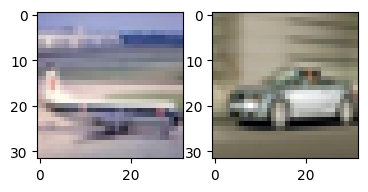

tensor([[[ 40,  47,  34,  ...,  32,  48,  49],
         [ 38,  54,  52,  ...,  53,  37,  51],
         [ 52,  41,  38,  ..., 111, 118,  98],
         ...,
         [158, 156, 151,  ...,  84,  94,  60],
         [134, 126,  92,  ..., 236, 237, 244],
         [225, 224, 232,  ..., 186, 175, 190]],

        [[202, 194, 189,  ...,  98, 102,  70],
         [124, 121,  79,  ..., 216, 219, 224],
         [202, 205, 212,  ..., 182, 159, 194],
         ...,
         [ 40, 191, 229,  ..., 113, 139,  80],
         [108, 138,  82,  ..., 182, 197, 197],
         [206, 243,   7,  ..., 104,  42,  71]],

        [[ 93, 244,  19,  ...,  90, 107,  60],
         [ 84, 111,  51,  ..., 204, 222, 228],
         [187, 231,   3,  ...,  78,  45,  79],
         ...,
         [217, 246,  13,  ..., 210, 103, 160],
         [205,  98, 152,  ..., 129, 171,  82],
         [133, 169,  53,  ..., 214, 239,   9]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


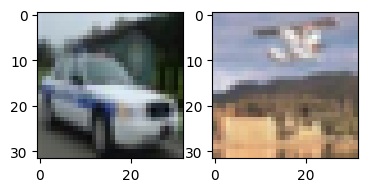

tensor([[[197, 106,  57,  ..., 102, 245, 158],
         [107, 248, 160,  ..., 192, 138,  18],
         [183, 128,  21,  ..., 117,  67,  16],
         ...,
         [  1, 234,  70,  ...,  54,  10, 239],
         [160,  90,  64,  ..., 116,  13, 183],
         [143,  15, 188,  ..., 251, 228,  71]],

        [[242, 217,  63,  ...,  45, 250, 228],
         [158,  81,  61,  ..., 209,  70, 246],
         [224,  69,   3,  ...,  26,  17,  40],
         ...,
         [154,  20, 196,  ..., 133,  99, 197],
         [121,  89, 193,  ...,  10, 216, 191],
         [119,  47,  37,  ...,  86, 220, 142]],

        [[107, 218, 140,  ..., 127,  96, 194],
         [117,  86, 204,  ...,   5, 211, 185],
         [117,  46,  39,  ..., 116,  16, 196],
         ...,
         [146, 150, 143,  ..., 199, 215, 208],
         [204, 216, 209,  ..., 220, 215, 228],
         [216, 212, 226,  ..., 226, 222, 219]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


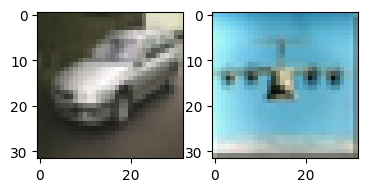

tensor([[[177, 194, 218,  ..., 100,   4,  57],
         [104,   6,  59,  ...,  54, 108,  10],
         [ 53, 105,  10,  ...,   4,  42,  97],
         ...,
         [151, 188,  91,  ...,  35,  49,  92],
         [142, 184, 245,  ...,   7,  92, 158],
         [203,  85, 128,  ..., 189, 216, 118]],

        [[173, 202,  86,  ...,  76,  76, 120],
         [203, 249,  55,  ...,   4, 112, 144],
         [181, 139, 135,  ..., 175, 207, 165],
         ...,
         [132, 123, 114,  ..., 187, 186,  92],
         [ 91,  86,  87,  ...,  18, 248, 241],
         [ 54,  58,  44,  ..., 118, 132, 127]],

        [[105, 106,  91,  ..., 111, 107,  51],
         [ 32,  19,  36,  ..., 247, 237, 234],
         [ 66,  58,  26,  ...,  12,  50,  49],
         ...,
         [215, 184, 169,  ..., 196,  20, 234],
         [203,  32, 233,  ...,   5, 203,  70],
         [  4, 209,  73,  ...,  96,  35, 242]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


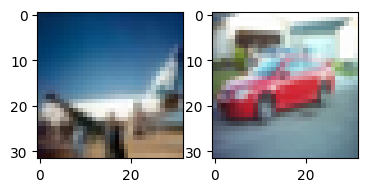

tensor([[[130, 145, 182,  ..., 181, 130, 144],
         [181, 129, 144,  ..., 142, 181, 126],
         [141, 182, 125,  ..., 118, 133, 176],
         ...,
         [119, 160, 116,  ...,  92, 115, 156],
         [212, 231,  18,  ..., 219, 175, 187],
         [218, 181, 191,  ..., 111, 151, 108]],

        [[124, 165, 128,  ...,  92, 117, 157],
         [139, 162, 205,  ...,  18, 194, 200],
         [222, 152, 156,  ...,  68, 105,  77],
         ...,
         [143, 190, 178,  ..., 222,   1, 215],
         [228,   2, 217,  ...,  80,  96, 135],
         [101, 126, 165,  ...,  53,  70,  62]],

        [[ 54,  98,  91,  ..., 191, 214, 188],
         [189, 204, 214,  ...,  82,  96, 135],
         [105, 126, 166,  ...,  49,  51,  47],
         ...,
         [152, 151, 191,  ...,  38,  24,  21],
         [ 35,  30,  29,  ...,  40,  45, 107],
         [104, 109, 180,  ..., 182, 187, 225]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


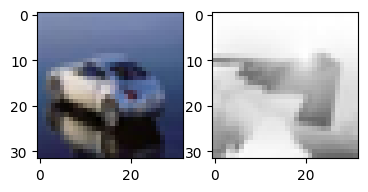

tensor([[[234, 221,  56,  ...,  51, 241, 224],
         [ 50, 241, 222,  ...,  60, 158,  91],
         [ 70, 171,  71,  ...,  30,  24,  97],
         ...,
         [172,  68, 206,  ..., 219, 192,  67],
         [183, 156,  60,  ...,  89, 217, 176],
         [ 98, 205, 164,  ..., 159,  67, 204]],

        [[166,  71, 203,  ..., 218, 184,  63],
         [181, 150,  65,  ...,  86, 192, 151],
         [ 83, 192, 150,  ..., 174, 106, 211],
         ...,
         [234, 187, 224,  ..., 234, 174, 229],
         [237, 178,  14,  ...,  32,  17, 140],
         [182, 167,  30,  ..., 190, 236,   1]],

        [[214, 188, 235,  ..., 236, 196,  28],
         [ 31, 243,  96,  ...,  48,  30, 143],
         [205, 189,  47,  ...,  75, 208, 212],
         ...,
         [102, 104, 233,  ..., 233, 110, 108],
         [233, 111, 109,  ..., 112, 244, 116],
         [112, 244, 115,  ..., 109, 113,  22]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


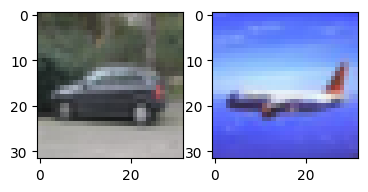

tensor([[[170, 170, 206,  ..., 210, 178, 179],
         [210, 178, 179,  ..., 181, 209, 176],
         [182, 207, 180,  ..., 161, 166, 196],
         ...,
         [124, 133, 112,  ..., 222, 230,   2],
         [165, 166, 199,  ...,  54,  17,  21],
         [ 51,   6,  11,  ..., 100, 106,  85]],

        [[102, 102,  99,  ..., 254,   6,  34],
         [165, 168, 201,  ...,  98,  74,  82],
         [109,  77,  88,  ...,  34,  26, 242],
         ...,
         [103,  71,  88,  ...,  18,  31,  10],
         [ 25,  42,  73,  ...,  30,  36,  63],
         [ 32,  41,  67,  ...,  57,  40,  54]],

        [[ 58,  35,  50,  ...,  28,  37, 236],
         [250,  10,  56,  ...,  23,  27,  51],
         [ 61,  64,  94,  ..., 102,  92, 102],
         ...,
         [161, 140, 156,  ..., 161, 166, 152],
         [158, 168, 154,  ..., 156, 152, 165],
         [155, 148, 163,  ..., 151, 142, 145]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


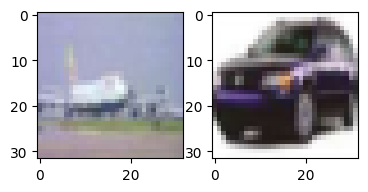

tensor([[[ 83,   2,   7,  ..., 247,  38, 234],
         [241,  58, 237,  ..., 241, 251,  64],
         [238, 249,  54,  ...,  18, 211, 231],
         ...,
         [  9,  38,  41,  ..., 152, 118, 104],
         [187, 171, 192,  ..., 181, 103, 101],
         [120, 113, 116,  ..., 217, 245,   0]],

        [[227, 249, 233,  ..., 101,  85,  84],
         [238, 222, 243,  ..., 207, 119, 115],
         [136, 132, 128,  ..., 210, 234,  23],
         ...,
         [100,  14,   5,  ...,  74,  96,  65],
         [ 56,  94,  81,  ..., 219, 189, 194],
         [239, 202, 215,  ...,  90,  46,  35]],

        [[ 72, 211, 193,  ...,  88,  91,  79],
         [ 58,  75,  78,  ..., 165, 132, 118],
         [245, 219, 236,  ...,   5, 226, 203],
         ...,
         [170, 155, 154,  ..., 196, 232, 222],
         [221, 253, 241,  ..., 174, 179, 194],
         [176, 179, 190,  ..., 120, 113, 119]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


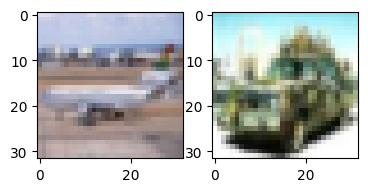

tensor([[[180, 183, 198,  ..., 217, 219, 210],
         [220, 232, 219,  ..., 225, 230, 246],
         [230, 234, 246,  ..., 241, 227, 235],
         ...,
         [217, 202, 199,  ..., 246, 233, 243],
         [196, 195, 200,  ..., 241,   1, 247],
         [245,   4, 252,  ..., 136, 124, 152]],

        [[129, 117, 157,  ..., 242, 231, 241],
         [200, 200, 205,  ..., 231, 254, 247],
         [245, 254, 246,  ...,  68,  38, 144],
         ...,
         [160, 129, 183,  ...,  62,  57,  67],
         [ 48,  45,  64,  ..., 249, 228, 223],
         [227, 210, 197,  ...,  54,  97,  85]],

        [[ 80, 106,  89,  ...,  56,  52,  70],
         [ 49,  46,  78,  ..., 245, 223, 218],
         [228, 210, 198,  ...,  19,  71,  44],
         ...,
         [ 48,  39,  26,  ...,  60,  88,  73],
         [ 64,  87,  72,  ...,  74,  61,  86],
         [ 72,  61,  89,  ...,  61,  49,  36]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


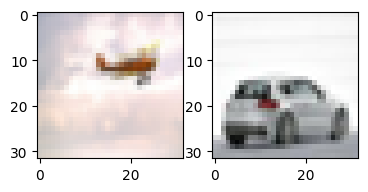

tensor([[[129,  51, 177,  ..., 154, 121,  19],
         [151, 119,  17,  ...,   8, 143, 117],
         [ 16, 142, 118,  ..., 121,  46, 178],
         ...,
         [ 71,  66,  65,  ..., 108,  13, 154],
         [113,  17, 153,  ..., 138,  72, 228],
         [132,  63, 222,  ...,  31,  18,  79]],

        [[ 15, 238,  65,  ..., 114,  19, 160],
         [108,   9, 135,  ..., 135,  48, 209],
         [116,  39, 200,  ..., 242, 189,  56],
         ...,
         [100,  22, 219,  ..., 126, 102, 182],
         [127, 103, 175,  ..., 222, 155, 101],
         [215, 151,  78,  ..., 120,  13, 214]],

        [[161,  30, 231,  ..., 113,  87, 167],
         [115,  91, 158,  ..., 225, 180, 149],
         [232, 175,  87,  ..., 145,  22, 235],
         ...,
         [ 74,  75, 121,  ..., 108,  44,  66],
         [107,  43,  63,  ...,  68, 110,  53],
         [ 70, 114,  49,  ...,  80,  75, 109]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


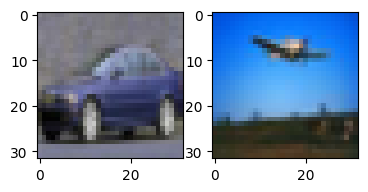

tensor([[[238,  18,  47,  ..., 189, 145, 165],
         [189, 140, 160,  ..., 160, 186, 137],
         [159, 185, 137,  ..., 145, 168, 189],
         ...,
         [250,  41, 190,  ...,  19,  40,  42],
         [202, 245,   9,  ...,  49, 233,   5],
         [ 41, 190, 226,  ...,   6,  54, 195]],

        [[238,  28, 188,  ...,  43,  59,  78],
         [234,  23,  18,  ...,  33, 207, 229],
         [ 27, 194, 227,  ..., 230,  22, 182],
         ...,
         [236, 191, 215,  ..., 203,   0, 192],
         [222,   3, 182,  ...,  28,  39,  53],
         [ 23,  32,  43,  ..., 245, 196, 217]],

        [[245, 196, 211,  ..., 173,  26, 151],
         [188,  19, 146,  ...,  22,  34,  56],
         [ 33,  39,  48,  ..., 221, 183, 207],
         ...,
         [ 75,  84,  91,  ...,  50,  26,  44],
         [ 59,   5,  31,  ..., 212, 248, 180],
         [212, 249, 186,  ..., 183, 214, 253]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


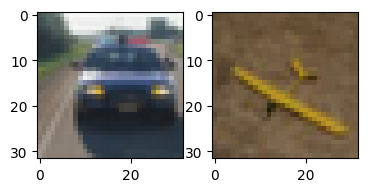

tensor([[[200, 204, 182,  ..., 200, 231, 232],
         [206, 237, 234,  ..., 244, 183, 253],
         [230, 162, 216,  ..., 199, 200, 175],
         ...,
         [ 22, 246, 215,  ..., 138, 112,  68],
         [188, 188, 160,  ..., 145, 213, 200],
         [181, 208, 203,  ..., 246, 226, 216]],

        [[207, 175, 179,  ..., 134, 106,  56],
         [122, 123,  98,  ..., 153, 208, 204],
         [196, 209, 210,  ..., 197, 171, 198],
         ...,
         [152, 182, 173,  ...,  64,  41,   0],
         [243, 216, 242,  ..., 212, 192, 148],
         [176, 158, 119,  ..., 147, 146, 122]],

        [[ 97, 130, 114,  ..., 214, 183, 153],
         [125,  92, 209,  ..., 204, 182, 135],
         [173, 156, 116,  ..., 182, 201, 182],
         ...,
         [152, 142, 107,  ..., 127, 186, 171],
         [135, 190, 175,  ..., 167, 131, 196],
         [173, 136, 192,  ..., 204, 177, 122]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


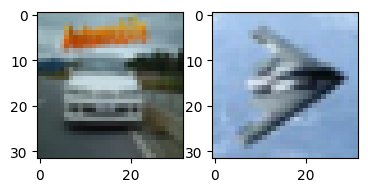

tensor([[[224,  10, 250,  ...,  21, 240,  28],
         [ 18, 242,  30,  ...,  57,  33, 248],
         [ 33,  11, 222,  ..., 254,  46,  39],
         ...,
         [111,  67,  59,  ..., 151, 195, 203],
         [245,  17,  12,  ..., 209,  10, 253],
         [208,  67,  56,  ...,  74,  71, 135]],

        [[137, 116,  62,  ..., 181, 222, 230],
         [ 17,  41,  32,  ..., 208,  37,  25],
         [246,  81,  70,  ...,  34,  47, 115],
         ...,
         [ 69,  82,  78,  ..., 136, 116, 251],
         [236, 205,  55,  ...,  40,  36, 248],
         [ 13,  11, 215,  ..., 234,  35,  19]],

        [[233,  11, 244,  ..., 169, 144, 255],
         [249, 215,  24,  ...,  40,  40, 247],
         [ 58,  57,   4,  ..., 189, 253, 222],
         ...,
         [ 32,  42, 248,  ...,   9,  56,  61],
         [  6,  45,  51,  ...,  37, 248,  63],
         [ 60,  17,  56,  ...,  20,  30, 243]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


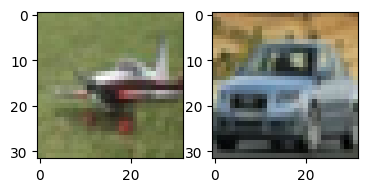

tensor([[[ 64, 102, 135,  ..., 105,  46,  80],
         [113,  42,  76,  ...,  66, 101,  26],
         [ 70, 106,   9,  ...,  60,  86, 114],
         ...,
         [237, 253, 209,  ...,  16,  46,  83],
         [160, 151, 149,  ..., 149, 101, 141],
         [157,  83, 125,  ...,  37,  55,   8]],

        [[ 35,  49,   1,  ...,  95, 126, 154],
         [169, 171, 171,  ..., 134,  70, 153],
         [165,  57, 147,  ..., 120, 137,  57],
         ...,
         [184,  18, 167,  ..., 218, 228,  78],
         [224, 230, 120,  ...,  21, 165, 180],
         [124, 129, 148,  ..., 177,  27, 177]],

        [[174,  22, 174,  ...,  46,  53, 172],
         [ 64,  68, 187,  ...,  19, 171, 184],
         [135, 139, 158,  ..., 187, 102, 191],
         ...,
         [118, 144, 160,  ..., 237, 222, 234],
         [238, 220, 233,  ..., 222, 232, 196],
         [222, 228, 169,  ...,  86, 135, 155]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


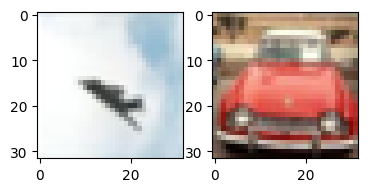

tensor([[[ 30,  37,  48,  ...,  20, 250, 252],
         [ 19, 248, 251,  ..., 253,  12, 254],
         [  0,  17,   2,  ...,  83,  82,  85],
         ...,
         [ 25,  45,  20,  ..., 101, 103, 109],
         [ 53,  57,  76,  ..., 248, 249,   2],
         [ 28, 207, 215,  ...,  20,  43,  20]],

        [[ 27,  47,  17,  ..., 107, 106, 112],
         [ 60,  65,  84,  ..., 249, 211, 221],
         [249, 171, 180,  ...,  17,  40,  14],
         ...,
         [ 50, 254, 255,  ..., 132, 139, 136],
         [138, 147, 144,  ..., 138, 137, 138],
         [ 59,  65,  82,  ...,  38, 237, 235]],

        [[245, 180, 180,  ...,  57,  65,  70],
         [ 72,  82, 128,  ..., 128, 125, 130],
         [ 59,  64,  82,  ..., 203, 204, 204],
         ...,
         [ 99,  92, 149,  ..., 155,  93,  90],
         [151,  92,  85,  ...,  76, 154,  80],
         [ 73, 149,  75,  ...,  67,  60, 126]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


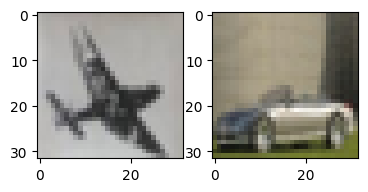

tensor([[[ 73,  66,  40,  ..., 203,  22,  16],
         [241,  34,  26,  ..., 232, 193,  57],
         [ 54,  22,  42,  ...,  35,  29, 247],
         ...,
         [ 45,   9,  62,  ...,  59,  45,   7],
         [196, 177, 127,  ...,  43,  42,  39],
         [ 10,  20,  18,  ...,  39, 255,  40]],

        [[ 37, 253,  55,  ...,  61,  44,   7],
         [202, 178, 128,  ..., 235,  65,  70],
         [ 48,  81,  87,  ..., 100,  59,  72],
         ...,
         [ 20, 222, 235,  ..., 178, 160, 174],
         [167, 166, 172,  ...,  19,   7, 236],
         [ 76,  52,   8,  ...,  97,  89,  98]],

        [[100,  56,  64,  ..., 227, 212, 229],
         [230, 227, 209,  ...,  64,  53,  18],
         [ 78,  58,  13,  ...,  78,  76,  81],
         ...,
         [ 70,  70,  26,  ...,  91, 116, 118],
         [ 99, 111, 111,  ..., 114, 103, 101],
         [105,  94,  94,  ...,  81,  76,  35]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


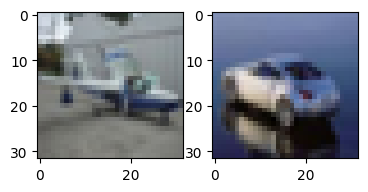

tensor([[[ 44,  82,  96,  ..., 104,  99, 116],
         [105,  66,  99,  ...,  86, 105,  24],
         [ 81, 112,  23,  ...,  12,  69,  97],
         ...,
         [ 57,  55,  43,  ...,  25,  77,  98],
         [ 24,  66,  80,  ...,  92,  35,  83],
         [100,  39,  84,  ...,  69,  60,  29]],

        [[ 62,  53,  46,  ...,  18,  70,  90],
         [ 35,  77, 100,  ...,  98,  55,  98],
         [119,  60, 102,  ...,  85,  79,  43],
         ...,
         [  5, 168, 177,  ...,  70,  32,  43],
         [ 59,  25,  43,  ..., 128, 147, 133],
         [ 81,  80,  60,  ..., 247, 187, 196]],

        [[195, 137, 150,  ...,  62,  35,  54],
         [ 60,  28,  45,  ...,  91,  95,  68],
         [ 87,  76,  57,  ..., 223, 227, 222],
         ...,
         [ 15,  21, 239,  ..., 254,  19,  23],
         [251,  21,  25,  ...,  32,   3,  28],
         [ 32,   2,  29,  ...,  25,  30, 253]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


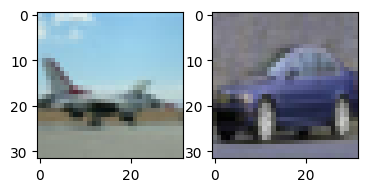

tensor([[[163, 150, 165,  ..., 152, 148, 127],
         [151, 129, 110,  ..., 174, 189, 168],
         [166, 180, 168,  ..., 198, 199, 209],
         ...,
         [109, 155, 137,  ..., 189, 188, 203],
         [178, 173, 196,  ..., 112,  40,  51],
         [105,  32,  46,  ...,  77, 146,  62]],

        [[ 81, 145,  72,  ..., 190, 187, 205],
         [179, 173, 193,  ...,  59,  36,  43],
         [ 81,  35,  44,  ...,  68, 128,  60],
         ...,
         [165, 136, 140,  ..., 133, 158, 127],
         [137, 160, 126,  ..., 177, 187, 203],
         [150, 143, 160,  ..., 198, 167, 169]],

        [[188, 156, 162,  ..., 131, 158, 106],
         [114, 134, 103,  ..., 175, 185, 202],
         [149, 142, 160,  ..., 205, 145, 151],
         ...,
         [133, 120, 111,  ..., 131, 137, 133],
         [133, 139, 135,  ..., 139, 139, 136],
         [139, 140, 135,  ..., 143, 142, 143]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


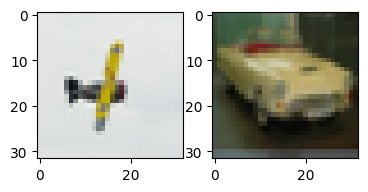

tensor([[[ 50,  88, 104,  ..., 107,  63,  97],
         [106,  65,  98,  ..., 112, 118,  73],
         [104, 118,  72,  ...,  63,  93, 111],
         ...,
         [164, 143, 190,  ...,  98, 114, 123],
         [ 98, 117, 123,  ..., 118, 110, 122],
         [125, 115, 123,  ..., 163, 140, 179]],

        [[164, 141, 212,  ...,  91, 106, 115],
         [104, 122, 138,  ..., 127, 135, 141],
         [145, 127, 131,  ..., 194, 177, 249],
         ...,
         [131,  21,   4,  ..., 147, 105, 176],
         [162, 125, 188,  ..., 200, 205, 196],
         [198, 204, 203,  ..., 175, 125, 116]],

        [[125,  45,  39,  ...,  75,  28, 125],
         [106,  67, 193,  ..., 194, 198, 194],
         [117, 109, 112,  ..., 144, 110, 103],
         ...,
         [106,  45, 218,  ..., 229, 116,  51],
         [228, 116,  52,  ...,  50, 230, 117],
         [ 50, 228, 112,  ..., 111,  51, 232]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


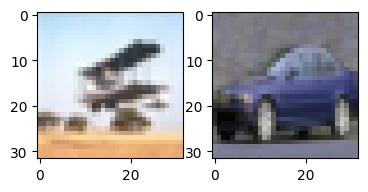

tensor([[[152, 176, 214,  ..., 219, 156, 183],
         [216, 162, 185,  ..., 181, 218, 147],
         [182, 214, 146,  ..., 250, 227, 227],
         ...,
         [ 81,  77,  44,  ...,  18, 247, 229],
         [212, 210, 216,  ...,  80, 118, 114],
         [107, 136, 133,  ..., 249, 239,   0]],

        [[253, 241, 218,  ..., 231, 220, 216],
         [218, 213, 214,  ..., 108, 148, 143],
         [132, 140, 123,  ..., 176, 158, 203],
         ...,
         [227, 237, 207,  ..., 248, 229,  27],
         [253, 234, 236,  ...,  73,  54,  37],
         [195, 167, 148,  ..., 218,  64,  33]],

        [[  6, 251, 215,  ...,  86,  68, 110],
         [ 90,  74,  99,  ...,  46,  27,  14],
         [233, 201, 177,  ...,  16, 107,  76],
         ...,
         [ 58,  26,  96,  ..., 167, 158, 147],
         [203, 194, 187,  ..., 160, 214, 173],
         [176, 224, 200,  ..., 150, 142, 198]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


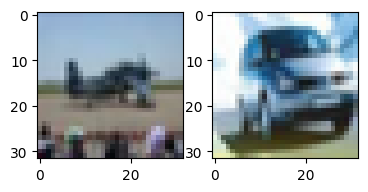

tensor([[[  0,   0,   0,  ..., 250, 249, 250],
         [250, 249, 248,  ..., 252, 251, 251],
         [253, 252, 253,  ...,   0,   0,   0],
         ...,
         [104, 108, 110,  ...,   1,   1,   1],
         [ 84,  84,  84,  ...,  82, 105, 106],
         [110,  80,  81,  ..., 209, 213, 204]],

        [[205, 209, 211,  ...,   1,   1,   1],
         [ 55,  55,  55,  ..., 115,  79,  80],
         [ 84, 139, 140,  ..., 237, 242, 232],
         ...,
         [ 44,  37,  36,  ...,  18,  25,  72],
         [ 72,  83, 103,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,  83,  47,  47]],

        [[ 52,  41,  41,  ...,  50,  56,  80],
         [ 80,  90, 103,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 107,  47,  48],
         ...,
         [  1,   1,   1,  ...,  68,  55,  57],
         [ 67,  49,  52,  ..., 174, 183, 221],
         [225, 234, 168,  ...,   1,   1,   1]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


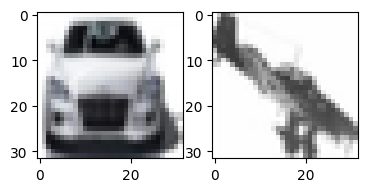

tensor([[[138, 191,  89,  ...,  77, 143, 164],
         [ 69, 135, 149,  ..., 145,  67, 192],
         [209, 115, 182,  ..., 126, 188,  81],
         ...,
         [164, 134, 232,  ..., 120, 137,  89],
         [101, 137,  88,  ...,  97, 105, 115],
         [ 90,  92,  99,  ..., 199, 175,   4]],

        [[248, 222,  23,  ...,  98,  92,  58],
         [122, 141, 104,  ...,  84,  83,  95],
         [ 76,  55,  63,  ...,   7, 241,  27],
         ...,
         [ 33,  55,  55,  ...,  99,  85, 109],
         [103,  94, 219,  ..., 173, 170, 133],
         [169, 177, 126,  ..., 179, 219, 208]],

        [[180, 204, 193,  ...,  50,  37,  81],
         [ 76,  70, 197,  ..., 176, 185, 146],
         [152, 183, 115,  ..., 129, 200, 179],
         ...,
         [189,   4, 159,  ..., 102, 122, 138],
         [ 98, 120, 126,  ..., 177, 133, 203],
         [192, 146, 222,  ..., 196,   6, 154]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


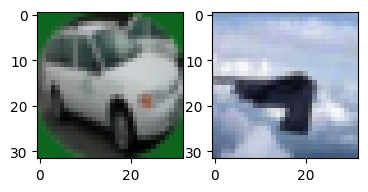

tensor([[[197, 194, 201,  ..., 198, 193, 186],
         [195, 192, 186,  ..., 170, 182, 181],
         [177, 181, 183,  ..., 184, 180, 182],
         ...,
         [202, 228, 168,  ..., 173, 172, 179],
         [186, 183, 189,  ..., 187, 175, 174],
         [180, 172, 174,  ..., 191, 222, 183]],

        [[198, 229, 166,  ..., 181, 180, 185],
         [180, 178, 173,  ..., 179, 156, 159],
         [160, 151, 155,  ..., 174, 202, 169],
         ...,
         [128, 178, 183,  ...,  83, 126,  71],
         [ 80, 123,  69,  ...,  58,  62,  94],
         [ 81,  79,  97,  ..., 122, 160, 166]],

        [[175, 186, 192,  ...,  78, 115,  66],
         [ 74, 113,  63,  ...,  64,  67,  96],
         [117, 119, 122,  ..., 108, 154, 158],
         ...,
         [ 56,  60,  91,  ...,  79,  49,  57],
         [ 80,  49,  57,  ...,  47,  71,  39],
         [ 47,  72,  37,  ...,  23,  30,  62]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


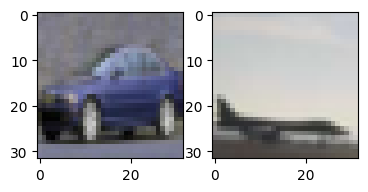

tensor([[[161, 132,  92,  ...,  77, 183, 128],
         [ 79, 181, 126,  ...,  94,  58, 167],
         [123,  82, 192,  ..., 133,  94,  48],
         ...,
         [101,  65, 141,  ..., 211, 179, 122],
         [136, 118,  69,  ..., 230,  28,  44],
         [ 25, 244,   5,  ..., 173, 123, 103]],

        [[100,  58, 147,  ..., 194, 163, 105],
         [107,  93,  49,  ..., 241,  10,  25],
         [254, 222, 241,  ..., 163, 112, 108],
         ...,
         [ 51,  92, 115,  ...,  13, 243, 150],
         [168, 143, 108,  ...,  91, 102,  96],
         [141, 151, 137,  ..., 116, 128, 149]],

        [[127, 140, 169,  ..., 245, 223, 158],
         [176, 153, 148,  ...,  64,  71,  68],
         [165, 175, 161,  ..., 171, 165, 190],
         ...,
         [ 88,  90,  88,  ..., 176, 175, 182],
         [176, 175, 181,  ..., 165, 159, 161],
         [164, 156, 168,  ...,  75,  78,  71]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


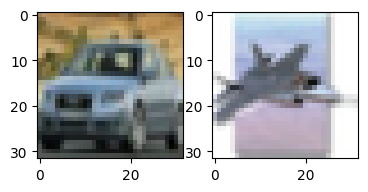

tensor([[[153, 156, 161,  ..., 166, 158, 161],
         [166, 158, 161,  ..., 157, 162, 157],
         [160, 165, 165,  ..., 136, 139, 149],
         ...,
         [102, 108,  70,  ..., 143, 144, 149],
         [147, 151, 156,  ...,  80,  66,  67],
         [ 79,  49,  50,  ..., 254,   4, 244]],

        [[245, 251, 217,  ..., 144, 146, 151],
         [130, 138, 143,  ...,  21,   7,  10],
         [ 22,  21,  26,  ..., 220, 226, 216],
         ...,
         [ 77, 109, 114,  ...,  50,  49, 186],
         [187, 191,  97,  ...,  98, 101, 106],
         [108, 117, 120,  ..., 233,  14,  21]],

        [[ 25,  68,  75,  ...,  22,  21, 160],
         [160, 162,  96,  ...,  99, 101, 106],
         [108, 114, 115,  ..., 170, 212, 214],
         ...,
         [124, 138,  84,  ...,  95, 135, 151],
         [ 99, 138, 152,  ..., 152,  96, 131],
         [147,  91, 126,  ..., 103, 118,  79]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


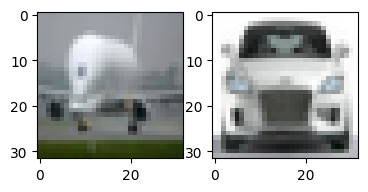

tensor([[[  2,  37,  89,  ..., 189,  84, 135],
         [189,  85, 136,  ..., 140, 193,  86],
         [140, 192,  90,  ...,  87, 135, 194],
         ...,
         [ 42,  63,  29,  ..., 210,   5,  81],
         [ 32,  62, 122,  ..., 192, 192, 205],
         [222,  14,   9,  ...,  19, 249,  29]],

        [[ 63,  89,  35,  ..., 184, 239,  43],
         [  1,  31, 114,  ..., 168, 198, 195],
         [183, 227, 227,  ...,  66,  72,  42],
         ...,
         [250,  22,   5,  ...,  73, 133,  15],
         [ 66, 123,   2,  ..., 199,   3,  68],
         [211,  18,  83,  ..., 240,  27,  28]],

        [[ 20,  46,  82,  ...,  68, 123,  22],
         [ 73, 128,  45,  ..., 201,   4,  61],
         [214,  22,  87,  ...,  65,  51,  95],
         ...,
         [177, 240,  49,  ...,  74, 207,   9],
         [ 71, 227,  23,  ...,  75, 117,  36],
         [ 77, 118,  35,  ...,  34,  74, 116]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


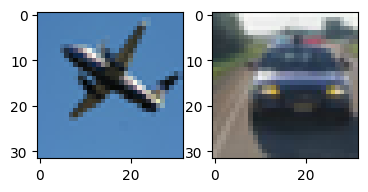

tensor([[[173, 137, 101,  ...,  55, 154, 101],
         [ 56, 153, 101,  ...,  98,  52, 152],
         [ 99,  54, 151,  ..., 151,  97,  52],
         ...,
         [230, 206, 232,  ..., 121,  75,  41],
         [130, 166, 162,  ..., 106,  11, 121],
         [113,  16, 131,  ...,  95,  79, 133]],

        [[123, 107, 125,  ..., 118,  74,  41],
         [ 93, 110, 120,  ...,  85,  20,  86],
         [ 90,  21,  93,  ..., 105,  92, 127],
         ...,
         [ 68, 246, 254,  ..., 197, 192, 246],
         [253, 252,  81,  ..., 108,  89,  82],
         [183, 187, 182,  ...,  66,  77,  87]],

        [[ 88,  43,  46,  ...,   3, 247,  76],
         [ 78,  70, 106,  ...,  89,  73,  69],
         [231, 227, 213,  ...,  94, 105, 112],
         ...,
         [129, 131, 131,  ..., 110,  94,  95],
         [ 93,  87,  93,  ...,  92, 103,  33],
         [ 46,  63, 117,  ..., 118, 112, 106]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


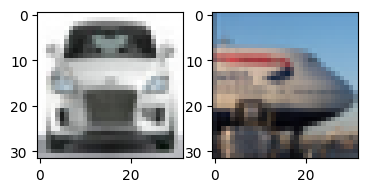

tensor([[[ 56, 136,  47,  ...,  58,  71, 110],
         [ 50,  63,  96,  ...,  92,  46, 121],
         [159,  98, 114,  ...,  73, 152,  66],
         ...,
         [ 25,  55,  96,  ..., 231, 255,  11],
         [220, 251,  15,  ...,  36,   3,  11],
         [ 36, 253,   3,  ...,  68, 107,  88]],

        [[ 90, 147, 116,  ..., 216, 215, 246],
         [240, 255,  28,  ...,  32, 251, 255],
         [ 31,   2,   7,  ..., 139, 170,  94],
         ...,
         [203, 215, 224,  ...,  75, 102,  33],
         [ 42,  97,   2,  ..., 167, 186, 253],
         [165, 191, 243,  ..., 247, 194, 199]],

        [[  7, 210, 218,  ...,  26,  61,  70],
         [ 76, 118,  68,  ..., 211, 234,  25],
         [150, 192, 234,  ..., 241, 198, 198],
         ...,
         [106, 206, 195,  ..., 242, 164, 187],
         [238, 156, 170,  ..., 115, 178, 108],
         [132, 184, 124,  ..., 122, 211, 199]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


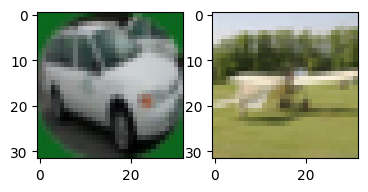

tensor([[[222, 241,  62,  ...,  77, 238, 238],
         [ 77, 225, 221,  ...,  37, 116,  18],
         [ 27, 112,  13,  ..., 185, 132, 126],
         ...,
         [ 77, 117, 139,  ...,  25,  25,  79],
         [ 20,  34, 101,  ..., 109,  26,  46],
         [115, 224, 246,  ...,  58, 113,  76]],

        [[ 47, 100,  74,  ...,  24,  21,  81],
         [ 10,  24,  98,  ...,  55,  43,  56],
         [107,  37,  51,  ...,  57, 110,  67],
         ...,
         [ 58,  22,   4,  ...,  57,  63,  59],
         [ 56,  67,  65,  ...,  28,  33,  93],
         [ 17,  19,  98,  ..., 110,  77,  46]],

        [[ 81,  45,  27,  ...,  41,  66,   6],
         [  6,  35, 251,  ...,  31,  41, 103],
         [  9,  10,  92,  ..., 107,  71,  48],
         ...,
         [224, 230,  35,  ...,  67, 132,  77],
         [ 56, 102,  51,  ..., 236,  18, 252],
         [239,  16, 246,  ..., 203, 217,   3]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


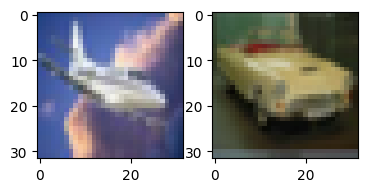

tensor([[[118, 146, 158,  ..., 250,  12,  17],
         [ 17,  15,  19,  ..., 161, 167, 178],
         [183, 185, 189,  ..., 248,  13,  25],
         ...,
         [ 63,  16, 102,  ...,  32,   0, 211],
         [ 18, 247, 201,  ...,  31,  29, 235],
         [202,  88,  37,  ...,  70,  33, 111]],

        [[ 66,  27, 106,  ...,  58,  24, 245],
         [ 99,  70,  32,  ...,   9,  52,  10],
         [234,  48,   6,  ..., 219, 184,   0],
         ...,
         [174, 221, 208,  ...,  41,  38,  47],
         [ 42,  28,  46,  ...,  44,   9, 223],
         [ 39,   0, 208,  ..., 170, 230, 195]],

        [[157, 223, 194,  ..., 218, 211, 234],
         [225, 215, 247,  ...,  47,  17, 237],
         [  7, 226, 177,  ..., 206,  29, 243],
         ...,
         [ 69,  38, 244,  ...,  67, 155, 121],
         [ 68, 155, 123,  ..., 138,  83, 170],
         [139,  84, 174,  ..., 138, 104,  53]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


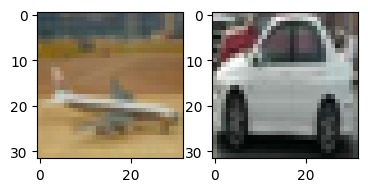

tensor([[[233, 146,  46,  ...,  40, 216, 132],
         [ 38, 216, 129,  ..., 134,  53, 214],
         [128,  47, 218,  ..., 102,  19, 188],
         ...,
         [204, 185,   6,  ..., 251, 187, 152],
         [200, 130,  54,  ...,  79, 224, 157],
         [106, 225, 156,  ..., 195, 174, 252]],

        [[184, 162, 246,  ..., 233, 166, 140],
         [187, 123,  53,  ..., 142,  13, 208],
         [168,  23, 216,  ..., 222, 201, 217],
         ...,
         [248,  30,  13,  ..., 150, 161, 126],
         [123, 135, 126,  ..., 204, 193, 192],
         [176, 168, 165,  ..., 228, 206, 204]],

        [[209, 176, 175,  ..., 183, 187, 172],
         [168, 170, 176,  ..., 204, 189, 192],
         [194, 186, 178,  ...,  30, 248, 249],
         ...,
         [150, 149, 153,  ..., 168, 178, 167],
         [168, 176, 166,  ..., 186, 186, 223],
         [200, 195, 246,  ..., 177, 166, 167]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


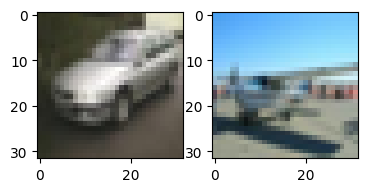

tensor([[[ 60, 136, 137,  ..., 235, 107, 201],
         [234, 106, 200,  ..., 195, 230,  89],
         [194, 228,  91,  ..., 100, 199, 233],
         ...,
         [237, 252, 166,  ..., 156, 214, 242],
         [ 55, 106, 131,  ...,  87, 173, 239],
         [ 11, 117, 137,  ..., 229, 234, 167]],

        [[226, 235, 138,  ..., 196, 234,   7],
         [114, 165, 189,  ...,  68, 184, 213],
         [227, 165, 132,  ..., 172, 183, 170],
         ...,
         [ 48, 241, 244,  ..., 110, 103, 255],
         [248, 251, 184,  ...,  41,  23,   6],
         [184, 174, 127,  ..., 133,  99, 101]],

        [[ 73,  30,  23,  ..., 222, 219, 190],
         [178, 174, 154,  ...,  52,  31,  14],
         [193, 181, 131,  ..., 110,  80,  80],
         ...,
         [ 43,  24, 213,  ..., 152, 232, 191],
         [149, 216, 174,  ..., 217, 184,  15],
         [228, 194,  24,  ..., 123,  95,  53]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


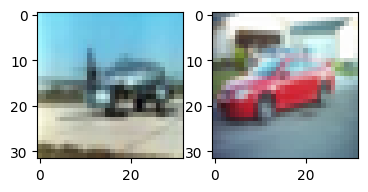

tensor([[[ 99, 128, 179,  ..., 170,  94, 112],
         [169,  74,  95,  ..., 156, 200, 109],
         [147, 191, 109,  ..., 127, 168, 208],
         ...,
         [ 78, 146,  69,  ..., 123, 151, 189],
         [113, 144, 195,  ..., 111, 232,  22],
         [103, 226,  17,  ...,  43, 137, 249]],

        [[ 49, 136,   3,  ..., 124, 130, 163],
         [115, 143, 190,  ...,  55, 228,  13],
         [ 78, 227,  13,  ...,  33, 116, 247],
         ...,
         [ 97,  54,  67,  ..., 116, 147,  90],
         [119, 148,  91,  ..., 141, 169, 190],
         [114, 127, 156,  ..., 196, 148, 165]],

        [[191, 139, 160,  ..., 114, 147,  70],
         [ 97, 124,  69,  ..., 142, 168, 188],
         [119, 130, 158,  ..., 202, 126, 147],
         ...,
         [132, 118, 106,  ..., 129, 147, 142],
         [140, 145, 142,  ..., 147, 146, 137],
         [145, 145, 127,  ...,  91,  99, 106]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


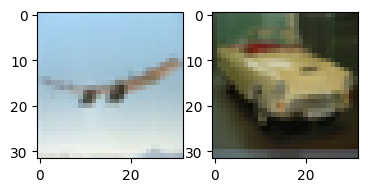

tensor([[[253, 148,  74,  ...,  81, 255, 153],
         [ 82, 255, 153,  ..., 149,  79, 252],
         [150,  79, 250,  ..., 254, 151,  82],
         ...,
         [147, 215, 176,  ..., 250, 165,  98],
         [254, 176, 110,  ...,  10, 169,  81],
         [ 18, 181,  90,  ..., 244, 247, 232]],

        [[  3,  73,   7,  ..., 245, 162,  95],
         [252, 155,  91,  ...,  37, 198, 103],
         [ 45, 198,  96,  ..., 248, 255,  18],
         ...,
         [177, 189, 179,  ..., 188, 250, 213],
         [233,  34,  42,  ..., 184, 135,  94],
         [194, 151, 113,  ...,   8, 200, 213]],

        [[ 11, 130, 146,  ..., 236, 221,  60],
         [ 36,  14,  82,  ..., 159, 119,  86],
         [188, 151, 120,  ...,  69, 203, 231],
         ...,
         [ 68,  39,  32,  ...,  25,  43,  19],
         [ 17,  34,  14,  ...,  25,  21,  47],
         [ 28,  24,  50,  ...,  66,  48,  48]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


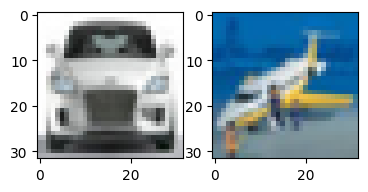

tensor([[[113, 100,  94,  ...,  82, 108,  92],
         [ 85, 108,  92,  ...,  90,  83, 110],
         [ 92,  85, 109,  ..., 111,  92,  86],
         ...,
         [243,  22, 248,  ..., 161, 155, 196],
         [156, 161, 201,  ...,  76,  76,  80],
         [120,  86,  89,  ..., 102, 137, 101]],

        [[101, 139,  88,  ..., 135, 138, 173],
         [114, 128, 158,  ...,  60,  49,  67],
         [ 92,  54,  66,  ...,  86, 110,  84],
         ...,
         [105,  31,  32,  ..., 224, 218,  24],
         [ 28,  24, 110,  ..., 114, 123, 134],
         [113, 124, 153,  ...,  86,  11,  26]],

        [[ 45, 211, 224,  ..., 203, 226,  14],
         [ 23,  51,  58,  ..., 149, 154, 193],
         [115, 120, 148,  ..., 102,  20,  31],
         ...,
         [ 63,  71, 126,  ...,  60,  14,  24],
         [ 49,  10,  20,  ...,  24,  46,  16],
         [ 29,  52,  20,  ...,  29,  45,  73]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


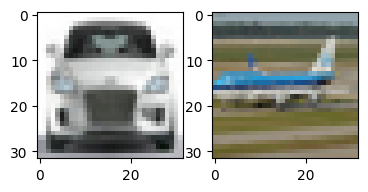

tensor([[[ 90,  84,  58,  ...,  60,  86,  82],
         [ 56,  61,  58,  ...,  53,  28,  94],
         [ 90,  62,  97,  ...,  72,  66,  40],
         ...,
         [166, 124, 204,  ..., 104,  97,  69],
         [ 62,  58,  36,  ..., 208, 227, 236],
         [220, 227, 231,  ..., 197, 149,  13]],

        [[216, 162,  24,  ..., 100,  95,  68],
         [ 57,  54,  33,  ..., 159, 183, 189],
         [174, 199, 202,  ..., 226, 176,  27],
         ...,
         [134, 107, 110,  ..., 116,  99, 145],
         [126, 105, 151,  ...,  62,  78,  87],
         [177, 191, 197,  ...,  73,  50,  56]],

        [[ 50, 218, 225,  ...,  25,  17,  42],
         [ 33,  24,  52,  ...,  31,  44,  46],
         [116, 120, 125,  ...,  53,  88,  93],
         ...,
         [200, 229,   1,  ...,  10, 195, 232],
         [  8, 193, 230,  ..., 220, 240, 205],
         [237,   1, 212,  ..., 236,   7,  23]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


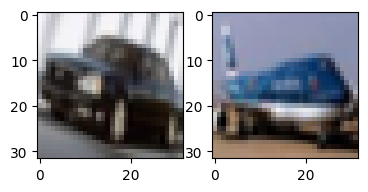

tensor([[[ 94, 121, 131,  ...,  99,  65,  82],
         [ 92,  39,  57,  ...,  48,  62,  67],
         [ 90, 101,  74,  ...,  82, 114, 118],
         ...,
         [112, 125, 104,  ...,  86, 113, 126],
         [ 35,  63,  78,  ..., 219, 170, 199],
         [226, 167, 194,  ...,  99, 108, 107]],

        [[106, 118, 106,  ...,  80, 107, 121],
         [ 29,  58,  74,  ..., 165, 119, 147],
         [171, 165, 190,  ...,  94, 107,  88],
         ...,
         [116,  70,  79,  ...,  63,  84,  65],
         [ 72,  88,  68,  ..., 216, 255,  31],
         [155, 186, 210,  ..., 196, 164, 172]],

        [[194, 115, 121,  ...,  60,  87,  61],
         [ 70,  92,  63,  ..., 154, 192, 219],
         [137, 165, 194,  ..., 150, 158, 162],
         ...,
         [193, 237,  23,  ..., 246, 163, 195],
         [242, 159, 191,  ..., 179, 215, 172],
         [198, 233, 180,  ..., 222,  10,  36]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


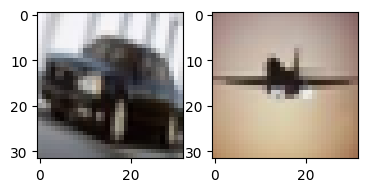

tensor([[[140, 173, 156,  ..., 180, 136, 169],
         [180, 144, 168,  ..., 178, 194, 146],
         [181, 189, 145,  ..., 245, 218, 204],
         ...,
         [ 28,  17, 252,  ..., 246, 242, 223],
         [217, 215, 209,  ...,  74, 112, 115],
         [106, 129, 134,  ...,   8, 254, 239]],

        [[254, 240, 218,  ..., 202, 215, 216],
         [226, 221, 209,  ..., 109, 143, 146],
         [135, 133, 124,  ..., 255, 242, 242],
         ...,
         [ 99,  77,  81,  ...,  89,  89,  92],
         [104, 103,  70,  ...,  57,  88, 115],
         [233, 237, 228,  ...,  62, 120, 122]],

        [[113,  55,  53,  ..., 145, 153, 128],
         [153, 162, 126,  ...,  30,  68,  93],
         [ 15,  15,   3,  ...,  98, 140, 138],
         ...,
         [179, 188, 248,  ...,  63,  18,  13],
         [ 50, 247, 247,  ..., 249,  50, 235],
         [251,  49, 237,  ..., 248,   5,  35]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


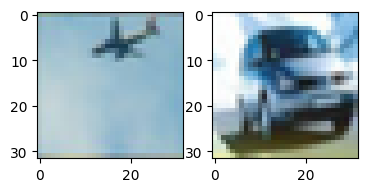

tensor([[[ 52,  53,  34,  ..., 177, 126, 128],
         [118,  58,  59,  ...,  72,  53,  70],
         [ 67,  47,  75,  ..., 220, 219, 188],
         ...,
         [178, 182, 166,  ..., 166, 165, 163],
         [ 17,  16,  10,  ..., 106, 120, 119],
         [117, 129, 116,  ..., 169, 176, 181]],

        [[179, 184, 252,  ..., 152, 148, 149],
         [ 16,  14,  11,  ..., 248, 168, 200],
         [193, 183, 179,  ..., 250,   4,  33],
         ...,
         [ 82,  45,  34,  ..., 122, 126,  81],
         [ 74,  74,  38,  ..., 111, 104,  94],
         [ 37,  38,  32,  ...,   4, 238, 229]],

        [[  4, 201, 190,  ..., 149, 147, 159],
         [149, 150,  77,  ..., 107,  99,  88],
         [ 38,  39,  33,  ...,  21,  33,  25],
         ...,
         [ 83,  84,  73,  ...,  61,  82,  74],
         [ 63,  81,  73,  ...,  84,  80,  93],
         [ 84,  79,  95,  ...,  82,  74,  63]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


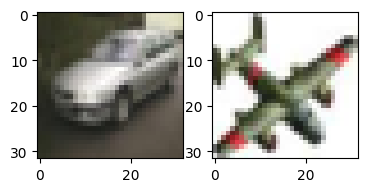

tensor([[[129, 142, 178,  ..., 152, 154, 155],
         [151, 159, 156,  ..., 130, 143,  90],
         [ 99, 121,  82,  ...,  51,  95, 152],
         ...,
         [ 81,  98, 104,  ..., 209, 205, 209],
         [147, 153, 184,  ...,  70, 146,  85],
         [ 69, 152,  91,  ...,   8,  15, 108]],

        [[ 82, 103, 106,  ..., 208, 205, 208],
         [121, 131, 159,  ...,  27, 150,  63],
         [ 32, 150,  79,  ...,   0, 252,  93],
         ...,
         [147, 122, 128,  ...,  71,  77,  37],
         [ 66,  68,  19,  ..., 189,   5,  42],
         [216,  41,  62,  ..., 203, 160, 196]],

        [[176, 117, 165,  ..., 135, 145,  64],
         [124, 129,  42,  ..., 209,  40,  77],
         [212,  16,  42,  ..., 153,  66, 134],
         ...,
         [ 40, 117,  99,  ...,  71,  13, 104],
         [ 53, 253,  93,  ...,  87,  51,   1],
         [ 95,  61,   1,  ...,  41, 130, 108]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


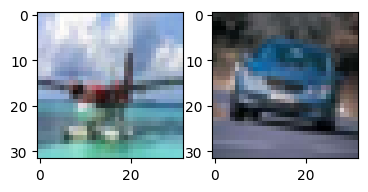

tensor([[[212, 194, 199,  ..., 224, 235, 221],
         [218, 244, 224,  ..., 213, 223, 225],
         [216, 223, 207,  ...,  86,  20, 247],
         ...,
         [ 18, 237,  90,  ...,  81,  16, 238],
         [247, 209, 200,  ...,  48, 152, 112],
         [ 92, 178, 139,  ..., 156, 114,   1]],

        [[228, 193,  24,  ...,  34, 243, 226],
         [250, 212, 199,  ..., 121, 165, 132],
         [112, 144,  96,  ..., 196, 153,  32],
         ...,
         [173, 187, 192,  ...,  44,  41,  93],
         [ 61,  55, 105,  ..., 143, 114, 117],
         [243, 215, 210,  ..., 154, 217, 226]],

        [[181, 157, 162,  ...,  74,  81, 117],
         [ 97, 103, 121,  ..., 120,  93,  97],
         [ 26, 249, 239,  ..., 191, 240, 250],
         ...,
         [246, 240,  39,  ..., 105,  46,  35],
         [ 89,  26,  19,  ...,  53, 105,  60],
         [ 53, 104,  38,  ...,  83,  69, 112]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


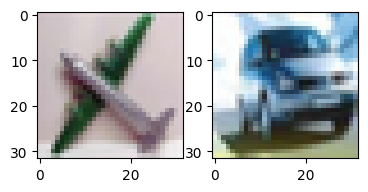

tensor([[[165, 180, 214,  ..., 218, 196, 198],
         [214, 220, 216,  ..., 217, 216, 217],
         [219, 218, 221,  ..., 156, 171, 209],
         ...,
         [148, 167, 126,  ..., 124, 148, 175],
         [137, 152, 185,  ..., 179, 156, 166],
         [183, 174, 174,  ..., 150, 168, 130]],

        [[140, 168, 123,  ..., 120, 146, 172],
         [129, 150, 181,  ..., 205, 140, 145],
         [157, 109, 107,  ..., 100, 111,  89],
         ...,
         [ 57,  37,  56,  ..., 216, 188, 241],
         [227, 198, 241,  ..., 107, 116, 132],
         [199, 187, 160,  ..., 230, 188, 213]],

        [[241, 208, 231,  ..., 185, 142, 219],
         [190, 143, 227,  ..., 103, 110, 126],
         [197, 181, 156,  ..., 245, 171, 200],
         ...,
         [161, 152, 159,  ..., 121, 104, 101],
         [117, 110, 109,  ..., 110, 111, 134],
         [126, 125, 140,  ..., 185, 171, 184]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


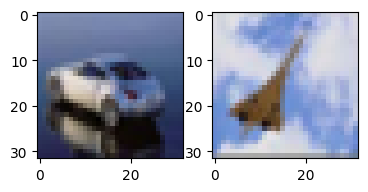

tensor([[[193, 143, 101,  ...,  92, 193, 141],
         [ 97, 186, 141,  ..., 144,  94, 203],
         [143,  98, 204,  ...,  99,  94,  83],
         ...,
         [251, 228,  52,  ...,  87,  81,  71],
         [142, 114,  82,  ..., 242, 220, 241],
         [ 21, 170, 198,  ...,  62,  39, 112]],

        [[103, 103, 133,  ..., 130, 107,  81],
         [137, 109,  81,  ..., 234, 183, 196],
         [229, 100, 147,  ...,  71,  74, 120],
         ...,
         [195,  19, 247,  ..., 233, 201, 254],
         [218, 185,  19,  ...,   8, 222, 179],
         [147,  99,  64,  ..., 234, 243, 211]],

        [[182,  46,  20,  ..., 176, 136, 217],
         [167, 127, 219,  ...,  31, 244, 200],
         [108,  64,  34,  ..., 198, 226, 194],
         ...,
         [168, 113,  13,  ..., 200, 111,  57],
         [216, 132,  74,  ...,  44, 208, 104],
         [ 45, 209, 103,  ...,  97,  49, 219]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


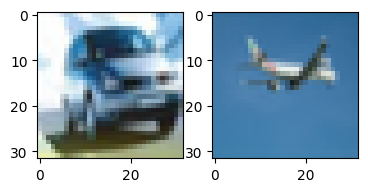

tensor([[[ 79,  75,  55,  ...,  48,  76,  71],
         [ 54,  70,  71,  ...,  68,  48,  80],
         [ 69,  51,  81,  ..., 233,  18,  35],
         ...,
         [185, 191, 143,  ..., 232,  15,  35],
         [ 38,  57,  51,  ..., 194, 139, 157],
         [163, 121, 138,  ...,   5,  13, 232]],

        [[  9,  27, 236,  ...,  22,  42,  46],
         [ 35,  50,  51,  ..., 163, 108, 128],
         [135, 117, 147,  ...,   2,  18, 214],
         ...,
         [ 53, 225, 235,  ..., 215,  56, 195],
         [200,  39, 212,  ..., 200, 196,  23],
         [ 73,  73, 166,  ...,  80, 181, 194]],

        [[ 37, 239,   4,  ..., 151, 233, 145],
         [142, 223, 149,  ..., 217, 217,  43],
         [ 34,  42, 135,  ...,  47, 164, 178],
         ...,
         [109,  98, 124,  ...,  52,  55,  45],
         [ 71,  77,  63,  ...,  34,  66,  56],
         [ 37,  69,  65,  ...,  47,  36,  75]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


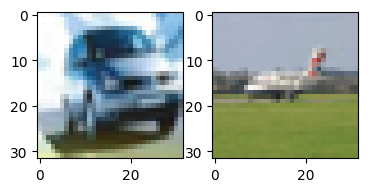

tensor([[[ 37,  16, 253,  ...,   2,  43,  16],
         [249,  45,  18,  ...,   8, 255,   9],
         [ 10,   4,  15,  ...,  54,  18, 246],
         ...,
         [ 19,   8,  27,  ...,  32,  13,   1],
         [ 56,  24, 253,  ...,   9,  77,  41],
         [ 12,  83,  45,  ...,  36,   9,  62]],

        [[ 30,   8,  41,  ...,  48,  25,   7],
         [ 52,  17, 248,  ...,  10,  80,  44],
         [ 14,  86,  47,  ...,  48,  16,  79],
         ...,
         [188,  22, 195,  ..., 239, 227, 213],
         [213, 212,  95,  ...,  27,  14,   7],
         [ 59,  25,   0,  ...,   6,  62,  48]],

        [[ 22,  52,  52,  ...,  26,   3, 222],
         [227, 211,  49,  ...,  22,  15,   9],
         [ 66,  27,   0,  ..., 240,  83,  75],
         ...,
         [209, 242, 238,  ..., 175, 209, 190],
         [178, 212, 192,  ..., 200, 186, 231],
         [204, 187, 235,  ...,  17, 251, 236]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


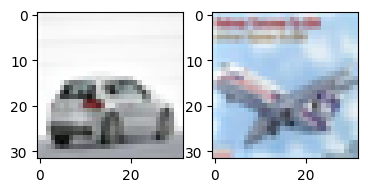

tensor([[[153, 143, 145,  ..., 146, 157, 145],
         [145, 157, 147,  ..., 139, 141, 157],
         [149, 140, 156,  ..., 152, 141, 140],
         ...,
         [186, 194, 163,  ..., 156, 142, 137],
         [180, 168, 160,  ...,  20, 187, 183],
         [176, 167, 164,  ..., 192, 209, 195]],

        [[213, 231, 178,  ..., 166, 152, 145],
         [173, 159, 146,  ..., 201, 190, 195],
         [189, 181, 186,  ..., 208, 224, 212],
         ...,
         [226,  16,  32,  ..., 149, 190, 115],
         [135, 173, 108,  ...,  89,  84, 107],
         [ 90,  75,  70,  ..., 186, 194, 221]],

        [[255, 240,   7,  ..., 150, 206, 117],
         [147, 203, 114,  ...,  97, 102, 139],
         [100,  88,  66,  ..., 202, 185, 214],
         ...,
         [165, 171, 218,  ...,  18, 182, 212],
         [ 14, 190, 220,  ..., 244,  53, 203],
         [239,  46, 197,  ..., 186, 194, 231]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


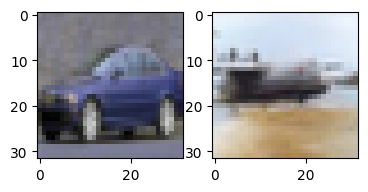

tensor([[[ 78,  36, 248,  ...,  19, 110,  61],
         [ 11, 113,  64,  ...,  29,   5,  38],
         [ 16, 249,  49,  ...,  94,  56,  10],
         ...,
         [197, 159, 155,  ...,  86,  88,  85],
         [251,  19,  44,  ..., 239,   6,  25],
         [246, 194,   4,  ..., 168, 133, 194]],

        [[172, 135, 168,  ..., 248, 252,   5],
         [217, 233,   5,  ..., 254,  37,   4],
         [243, 227, 233,  ..., 101,  88, 105],
         ...,
         [251,  90, 230,  ..., 241,  12,  94],
         [238,  14, 104,  ...,  57, 214, 238],
         [ 28,  38,  43,  ...,  12, 128, 244]],

        [[  8, 128, 243,  ...,   6,  15, 142],
         [  7,  18, 140,  ...,  90, 222, 231],
         [ 34,  38,  30,  ..., 248,  54, 233],
         ...,
         [102,  71,  50,  ..., 233, 242, 232],
         [231, 242, 231,  ..., 227, 227, 238],
         [225, 229,   0,  ...,  76,  45,  38]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


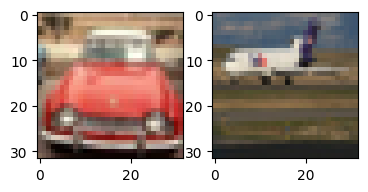

tensor([[[149, 148, 143,  ...,  62,  11,  19],
         [ 23, 228, 241,  ...,  82,  92,  86],
         [ 80,  91,  84,  ..., 192, 193, 206],
         ...,
         [237,  20, 189,  ..., 173, 218,   0],
         [194, 211, 219,  ...,  11, 218, 250],
         [ 22, 237,  20,  ...,  56,  98, 247]],

        [[ 49,  87, 238,  ..., 132, 192, 246],
         [252,  22,  24,  ..., 118,  43,  88],
         [124,  22,  71,  ...,  50, 101, 227],
         ...,
         [ 68,   4, 242,  ..., 128, 142, 109],
         [145, 149,  83,  ...,  11,  65, 104],
         [ 97, 133, 136,  ..., 100, 204,  16]],

        [[ 99, 185,   1,  ..., 242,  53, 202],
         [ 17,  71, 204,  ..., 214,   5,  35],
         [ 40,  58,  62,  ...,  51, 163, 247],
         ...,
         [212, 216, 211,  ..., 183, 132, 169],
         [185, 128, 167,  ..., 160, 194,  92],
         [145, 181,  93,  ..., 126, 170, 194]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


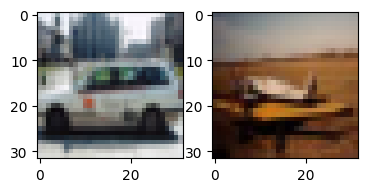

tensor([[[225, 248, 241,  ..., 248, 242,   4],
         [247, 246,   4,  ...,  11, 246,   5],
         [ 13, 246,   8,  ...,   7,  13, 240],
         ...,
         [ 44,  21,  43,  ...,  41,  44,  20],
         [ 25,  34,  13,  ...,  24,   9,  25],
         [ 16, 255,  17,  ...,  51,  29,  40]],

        [[ 49,  27,  41,  ...,  46,  46,  24],
         [ 33,  38,  17,  ..., 255,  22,  44],
         [ 44,  59,  83,  ..., 106,  89,  78],
         ...,
         [ 54, 186, 236,  ..., 115,  82, 105],
         [100,  72,  92,  ...,  67,  83,  64],
         [ 61,  70,  56,  ..., 127,  32,  70]],

        [[115,  23,  53,  ...,  83,  88,  72],
         [ 99, 105,  84,  ...,  71,  85,  67],
         [ 63,  75,  60,  ..., 153,  88, 125],
         ...,
         [ 67,  99,  83,  ..., 134,  94, 129],
         [137,  87, 122,  ..., 126, 141,  77],
         [109, 123,  70,  ...,  69,  92,  72]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


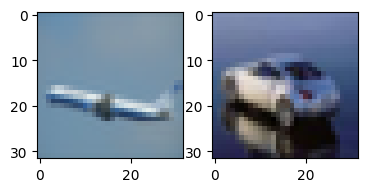

tensor([[[ 58,  29,  36,  ...,  18,  47,  15],
         [ 15,  42,  15,  ...,  12,  42,  27],
         [ 21,  60,  55,  ...,  53,  31,  36],
         ...,
         [255,   5,  68,  ..., 138, 129, 137],
         [ 72,  48,  51,  ...,  72,  73,  53],
         [ 54,  75,  49,  ...,  67,  77, 122]],

        [[107, 122, 150,  ..., 142, 135, 148],
         [131, 105, 103,  ...,  84,  78,  56],
         [ 57,  73,  49,  ..., 132, 148, 147],
         ...,
         [ 27,  24,  16,  ..., 231, 239,   7],
         [  2,   7, 235,  ..., 253, 241, 251],
         [ 25,  18,  35,  ...,  20,  60,  59]],

        [[ 71,  67,  66,  ...,   9,  19,  58],
         [ 59,  66,   4,  ...,   8, 255,  17],
         [ 21,  14,  32,  ..., 222, 252, 250],
         ...,
         [ 15,  12,  29,  ..., 252, 249, 244],
         [251, 248, 244,  ..., 238, 247, 242],
         [239, 251, 244,  ..., 245, 241,  10]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


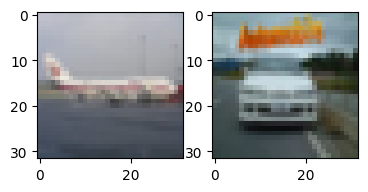

tensor([[[218, 227, 233,  ..., 248, 221, 243],
         [236, 221, 237,  ..., 167, 224, 142],
         [158, 211, 160,  ..., 177, 238, 229],
         ...,
         [ 15, 179, 117,  ..., 237, 231, 226],
         [207, 255, 251,  ..., 112, 193, 220],
         [129,  12,  40,  ...,  18, 207, 219]],

        [[249, 170, 166,  ..., 212, 208, 210],
         [192, 194, 198,  ..., 140, 182, 208],
         [133, 243,  11,  ...,  23, 217, 245],
         ...,
         [178, 250,  20,  ...,   0, 176, 253],
         [ 14, 157,  77,  ..., 198, 202, 208],
         [182, 183, 197,  ..., 225,  13,  23]],

        [[231,  10,  29,  ...,  46, 217,  49],
         [ 71, 204, 119,  ..., 212, 216, 220],
         [177, 179, 192,  ..., 243,  27,  45],
         ...,
         [187, 188, 190,  ..., 206, 223, 212],
         [208, 216, 204,  ..., 196, 183, 198],
         [190, 186, 205,  ..., 189, 187, 189]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


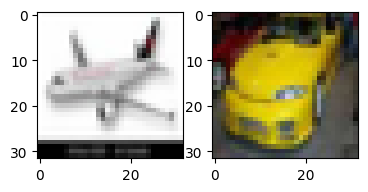

tensor([[[ 57,  57,  79,  ...,  34,   7,  16],
         [ 34,   6,  14,  ...,  22,  40,  17],
         [ 24,  42,  21,  ...,  66,  66,  87],
         ...,
         [160, 179, 157,  ...,  38,  42,  63],
         [ 81,  89, 113,  ...,  39,  17,  25],
         [ 44,  27,  35,  ..., 189, 207, 178]],

        [[181, 198, 184,  ...,  64,  66,  87],
         [ 63,  70,  96,  ...,  40,  10,  19],
         [ 33, 243, 250,  ..., 129, 148, 150],
         ...,
         [137,  92,  77,  ...,  87,  89,  90],
         [ 89,  90,  88,  ...,  73,  79,  93],
         [ 47,  51,  76,  ..., 208, 140, 127]],

        [[131, 123, 110,  ...,  98, 102, 105],
         [103, 108, 110,  ...,  87,  92, 104],
         [ 78,  81, 104,  ...,  45, 224, 214],
         ...,
         [ 45,  52,  71,  ...,  89,  65,  72],
         [ 89,  65,  72,  ...,  66,  84,  58],
         [ 65,  83,  56,  ...,  47,  54,  72]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


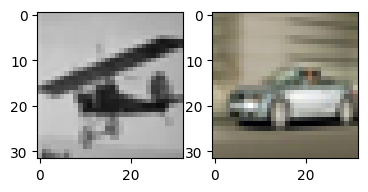

tensor([[[111, 117,  66,  ...,  57, 102,  98],
         [ 60, 104, 100,  ..., 116,  63, 119],
         [119,  60, 117,  ..., 122, 125,  68],
         ...,
         [178, 137, 179,  ...,  88,  89,  52],
         [ 94,  89,  44,  ...,  16,  21,  19],
         [252,  14,  13,  ...,  36, 252,  39]],

        [[ 37,   0,  34,  ...,  89,  89,  55],
         [ 90,  82,  47,  ...,  88, 112, 114],
         [102,  75,  78,  ...,  57,  17,  58],
         ...,
         [166, 140, 139,  ..., 121, 101, 170],
         [174, 156, 253,  ...,  63,  65,  50],
         [ 63,  60,  44,  ..., 216, 201, 200]],

        [[181, 147, 145,  ..., 119, 105, 191],
         [194, 182, 221,  ...,  59,  61,  51],
         [ 60,  56,  45,  ..., 217, 210, 209],
         ...,
         [172, 180, 186,  ..., 173, 159, 168],
         [169, 158, 167,  ..., 217, 221, 208],
         [219, 221, 210,  ..., 202, 214, 219]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


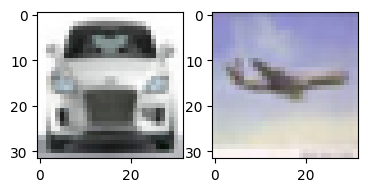

tensor([[[ 13,  66, 115,  ...,  99, 243,  38],
         [ 93, 229,  27,  ...,  55, 102,  28],
         [ 69, 118, 254,  ..., 219,  34,  90],
         ...,
         [255,  12, 252,  ...,  83, 127, 170],
         [  5,  65, 114,  ..., 247, 241, 244],
         [ 25, 224, 224,  ..., 223, 252,   2]],

        [[224, 220,   5,  ...,  77, 128, 169],
         [  6,  66, 117,  ..., 255, 248, 248],
         [ 27, 213, 213,  ..., 241,   0,  30],
         ...,
         [109,  72,  99,  ..., 207, 229, 215],
         [250,  23, 244,  ...,  60, 126, 161],
         [101, 119, 142,  ..., 137,  60, 102]],

        [[118,  65,  93,  ...,  79,  94,  94],
         [122, 145, 135,  ...,  42, 104, 148],
         [ 99, 114, 138,  ..., 131,  97, 125],
         ...,
         [ 57,  28,  95,  ...,  98,  35,  50],
         [109,  36,  50,  ..., 123, 203, 126],
         [126, 206, 119,  ...,   2,  10,  91]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


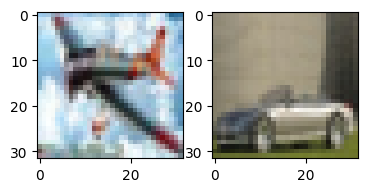

tensor([[[ 22,  67, 119,  ..., 109,   6,  48],
         [105,   6,  49,  ...,  52, 107,  13],
         [ 53, 112,  15,  ...,  75, 110, 161],
         ...,
         [ 15,  44,  12,  ...,  77,  80,  92],
         [ 42,  39,  66,  ...,  51,  19,  21],
         [ 45,  13,  13,  ...,   4,  32,   9]],

        [[ 12,  33,   7,  ...,  88,  86,  93],
         [ 57,  52,  73,  ...,  45,  23,  22],
         [ 39,  23,  22,  ...,  13,  36,  16],
         ...,
         [  8,  48,  42,  ..., 168, 169, 155],
         [162, 167, 157,  ..., 123, 120, 101],
         [ 63,  57,  54,  ...,  55,  61,  52]],

        [[ 35,  22,  16,  ...,  89,  85,  89],
         [ 93,  95, 109,  ...,  97,  94,  80],
         [ 59,  53,  45,  ...,  19,  69,  60],
         ...,
         [ 78,  60,  89,  ...,  65,  65,  47],
         [ 73,  76,  54,  ...,  34,  78,  63],
         [ 44,  87,  56,  ...,  30,  15,  52]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


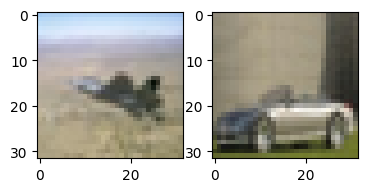

tensor([[[ 67,  53,  32,  ...,  87, 118, 103],
         [ 62, 137, 125,  ...,  96,  71, 126],
         [103,  78, 145,  ..., 143, 126, 100],
         ...,
         [205, 238, 196,  ...,  72,  51,  49],
         [236, 205, 170,  ..., 167, 164, 187],
         [203, 194, 230,  ...,   4,  14, 219]],

        [[  6,  27, 176,  ...,  67,  48,  45],
         [237, 208, 175,  ...,  12, 226, 242],
         [245, 214, 237,  ...,  47,  38,  41],
         ...,
         [ 85,  61,  49,  ...,   5, 235,  14],
         [  1, 238, 250,  ..., 170, 162, 167],
         [ 67,  76,  74,  ..., 149,  89,  85]],

        [[ 96,  51,  40,  ...,  19,  21,   3],
         [247, 251, 246,  ..., 173, 167, 171],
         [ 67,  75,  77,  ..., 157, 121, 116],
         ...,
         [115, 115, 130,  ...,  98,  94,  92],
         [106,  82,  83,  ...,  69,  76,  59],
         [ 60,  68,  55,  ..., 167, 164, 168]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


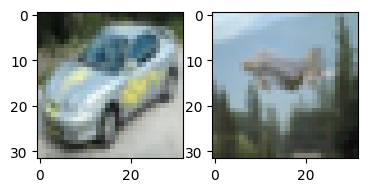

tensor([[[ 74,  73,  54,  ...,  42,  72,  71],
         [ 53,  74,  79,  ...,  92,  62,  96],
         [ 90,  65,  97,  ..., 250,  41,  50],
         ...,
         [205, 201, 203,  ..., 246,  34,  46],
         [ 46,  69,  57,  ..., 205, 149, 174],
         [173, 132, 156,  ...,  20,  19,   8]],

        [[ 31,  33,  20,  ...,  34,  60,  56],
         [ 43,  66,  58,  ..., 169, 121, 145],
         [145, 129, 165,  ...,  22,  27,   7],
         ...,
         [198,  46,  67,  ..., 255,   2, 176],
         [190, 191, 180,  ..., 174, 181, 159],
         [ 49,  56,  44,  ..., 230, 162, 178]],

        [[185,  40,  67,  ..., 133, 122, 120],
         [120, 111, 125,  ..., 199, 204, 182],
         [  9,  20,  16,  ..., 203, 161, 180],
         ...,
         [ 71,  72, 248,  ..., 181,  15,  19],
         [197,  36,  35,  ...,  19, 201,  27],
         [ 20, 203,  26,  ...,  16,  20, 207]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


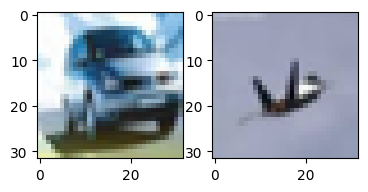

tensor([[[108, 180, 166,  ..., 174, 131, 197],
         [164, 147, 215,  ..., 207, 176, 142],
         [211, 180, 149,  ..., 143, 224, 180],
         ...,
         [  0,  45,  86,  ..., 174,   1, 192],
         [125, 207, 170,  ..., 237,  56, 199],
         [226,  58, 193,  ..., 228, 252,  79]],

        [[230, 249,  83,  ..., 161, 239, 175],
         [131, 218, 177,  ..., 222,  51, 193],
         [212,  45, 187,  ...,   8,  35, 139],
         ...,
         [240,  54, 244,  ..., 190, 191, 129],
         [209, 203, 151,  ..., 198,  15,   3],
         [  5,  80,  76,  ...,   6, 211, 233]],

        [[233,  21, 235,  ..., 241, 239, 176],
         [254, 249, 171,  ..., 202,  20,   8],
         [  9,  81,  77,  ..., 248, 164, 228],
         ...,
         [ 58,  70,  59,  ...,  55,  58,  65],
         [ 58,  57,  63,  ...,  70,  60,  57],
         [ 71,  60,  56,  ...,  46,  62,  50]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


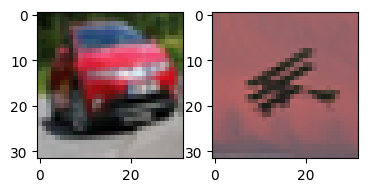

tensor([[[165, 158, 186,  ..., 254, 202, 203],
         [228, 200, 202,  ..., 199, 221, 204],
         [199, 219, 231,  ..., 140, 141, 168],
         ...,
         [ 99, 139, 122,  ..., 143, 121,  88],
         [181, 162, 205,  ..., 190, 141, 138],
         [149, 104, 100,  ...,  70,  88,  84]],

        [[ 73, 126,  80,  ...,  84,  61,  29],
         [161, 137, 194,  ..., 138,  55,  49],
         [ 49,  59,  52,  ...,   9,   9,  20],
         ...,
         [173, 144, 133,  ..., 248, 227, 249],
         [231, 218, 244,  ..., 119,  88, 118],
         [113, 102, 159,  ..., 150, 120, 107]],

        [[145, 132, 121,  ...,  15,   0,  33],
         [ 11,   1,  29,  ..., 138, 105, 120],
         [119, 100, 157,  ..., 138, 114,  96],
         ...,
         [ 99,  84,  50,  ...,  34, 101,  56],
         [ 37,  98,  52,  ...,  44,  29, 102],
         [ 42,  25, 100,  ...,  76,  28,  17]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


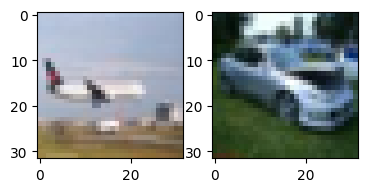

tensor([[[149, 155, 129,  ..., 124,  85,  90],
         [ 96,  16,  22,  ..., 230,  26, 188],
         [201, 247, 216,  ..., 255,   6,  18],
         ...,
         [239, 183, 250,  ..., 111,  98, 253],
         [ 64,  80,  10,  ..., 243, 247, 251],
         [206, 238, 239,  ..., 232, 183, 218]],

        [[211, 155, 218,  ..., 117, 115,   3],
         [107, 110,  24,  ..., 238, 228, 224],
         [195, 197, 192,  ..., 192, 117, 190],
         ...,
         [209, 247, 233,  ..., 215, 100, 228],
         [209,  84, 233,  ...,   3,   0, 142],
         [115, 109, 246,  ..., 145, 235, 232]],

        [[174,  10,   2,  ..., 195,  99, 227],
         [206, 101, 232,  ...,  29,  29, 163],
         [105, 101, 239,  ..., 130,  28,  24],
         ...,
         [ 73,  80, 219,  ..., 221,  71,  77],
         [210,  63,  70,  ...,  95, 231,  90],
         [ 92, 234,  87,  ...,  67,  72, 214]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


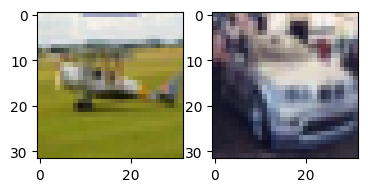

tensor([[[ 61,  64,  57,  ...,  59,  62,  64],
         [ 61,  65,  67,  ...,  61,  59,  63],
         [ 63,  61,  62,  ...,  60,  62,  61],
         ...,
         [156, 153, 152,  ...,  64,  66,  63],
         [ 83,  87,  79,  ...,   0,   4,   7],
         [  4,  15,  19,  ...,  24,  21,  21]],

        [[ 24,  21,  15,  ...,  69,  70,  68],
         [ 84,  90,  81,  ...,  38,  38,  41],
         [ 39,  40,  43,  ...,  46,  42,  32],
         ...,
         [ 77,   0,   2,  ..., 215, 212, 218],
         [222, 219,  34,  ..., 106, 108, 105],
         [ 97,  99,  96,  ..., 161, 129, 133]],

        [[125,  65,  67,  ..., 162, 158, 225],
         [229, 223,   1,  ..., 107, 109, 106],
         [ 98, 101,  98,  ...,  95,  41,  47],
         ...,
         [  6,  13,  14,  ...,  10, 255,   2],
         [  4, 251, 254,  ...,   4,   6,   8],
         [ 11,  13,  13,  ...,  31,  33,  36]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


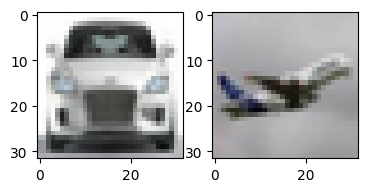

tensor([[[104, 147, 182,  ..., 200, 123, 167],
         [199, 125, 168,  ..., 166, 202, 130],
         [165, 203, 130,  ..., 149, 165, 186],
         ...,
         [200, 244, 193,  ..., 221, 222, 233],
         [145, 167, 191,  ...,  77,  68,  75],
         [ 85,  82,  90,  ..., 228,  12, 163]],

        [[200, 248, 203,  ..., 213, 218, 234],
         [175, 177, 202,  ...,  13,  16,  18],
         [ 25,  31,  37,  ...,   2,  33, 234],
         ...,
         [ 21, 252,   3,  ...,  31,  38,  20],
         [ 38,  46,  25,  ..., 172, 176, 184],
         [188, 187, 203,  ..., 142,  80,  76]],

        [[ 74,  40,  37,  ..., 242, 246, 228],
         [244, 250, 237,  ..., 140, 139, 147],
         [160, 158, 173,  ...,  89,  67,  56],
         ...,
         [ 75,  73,  78,  ...,  86,  89,  85],
         [ 88, 137, 117,  ...,  41,  35,  50],
         [ 49,  44,  59,  ..., 102, 100, 101]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


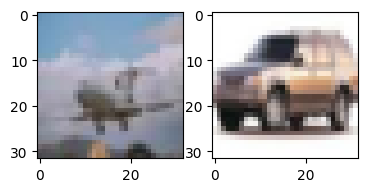

tensor([[[100,  34, 160,  ..., 152,  94,  69],
         [161, 101,  82,  ...,  91, 169,  49],
         [ 25, 119,  56,  ..., 101,  34, 155],
         ...,
         [137, 142,  79,  ..., 111,  95, 158],
         [ 52,  38, 118,  ..., 174, 180, 163],
         [173, 179, 165,  ...,  73,  82,  35]],

        [[ 29,  38,  21,  ..., 105,  99, 119],
         [ 38,  45, 110,  ..., 151, 152, 138],
         [151, 148, 137,  ...,  10,  21,  10],
         ...,
         [234, 221, 233,  ...,  82,  85,   1],
         [  0,   1, 154,  ...,  21,   8,  24],
         [ 57,  55, 124,  ...,  69, 190, 198]],

        [[222, 238, 246,  ..., 122, 120,   4],
         [  3, 255, 167,  ...,  57,  47, 102],
         [ 75,  55, 139,  ..., 129,  13,  28],
         ...,
         [185,  95, 169,  ..., 140, 151, 129],
         [152, 154, 142,  ..., 195, 205, 187],
         [169, 186, 165,  ..., 229, 140, 214]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


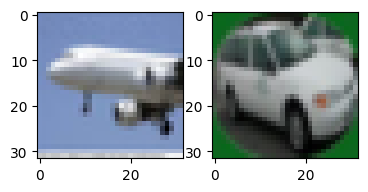

tensor([[[125, 154, 169,  ..., 193, 142, 182],
         [180, 143, 177,  ..., 112, 174,  72],
         [103, 161,  90,  ..., 106, 183, 179],
         ...,
         [213, 126, 183,  ..., 154, 159, 156],
         [ 36, 100, 104,  ..., 119, 143, 186],
         [100, 139, 181,  ..., 176, 114, 144]],

        [[185, 111, 145,  ...,  74,  82,  88],
         [ 18,  37,  47,  ..., 111, 135, 176],
         [106, 133, 171,  ..., 172, 114, 132],
         ...,
         [ 30, 118, 153,  ..., 169,  93, 162],
         [194,  85, 247,  ...,  32,  51,  65],
         [229, 244,   6,  ...,  78,  90, 111]],

        [[ 66, 117, 146,  ..., 179,  99, 168],
         [205,  85, 250,  ...,  45,  64,  79],
         [225, 241,   1,  ...,  80, 115, 142],
         ...,
         [245, 248, 250,  ..., 232, 250, 240],
         [233, 255, 245,  ..., 232, 215, 238],
         [230, 222, 241,  ...,  13,  10,   7]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


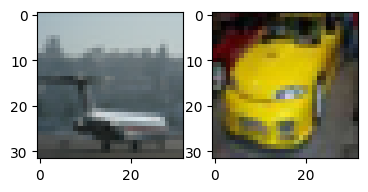

tensor([[[224, 204, 205,  ..., 205, 217, 198],
         [204, 216, 198,  ..., 188, 197, 210],
         [195, 197, 210,  ..., 214, 200, 203],
         ...,
         [220, 244, 195,  ..., 210, 196, 200],
         [214, 197, 197,  ..., 200, 200, 189],
         [193, 196, 188,  ..., 209, 238, 211]],

        [[216, 245, 195,  ..., 220, 206, 206],
         [209, 192, 182,  ..., 193, 183, 176],
         [175, 177, 171,  ..., 193, 219, 199],
         ...,
         [198,  11, 243,  ..., 166, 193, 212],
         [218, 242, 191,  ..., 116, 100, 120],
         [116,  96,  95,  ..., 228,  67,  38]],

        [[ 17,  76,  43,  ..., 198, 209, 207],
         [217, 232, 165,  ..., 125, 107, 124],
         [128, 111,  96,  ..., 207,  62,  41],
         ...,
         [217, 202, 225,  ..., 214, 213, 201],
         [215, 214, 202,  ..., 203, 216, 216],
         [203, 218, 215,  ..., 217, 203, 223]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


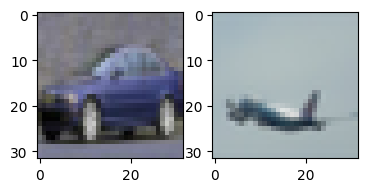

tensor([[[228, 244, 238,  ..., 234, 228, 244],
         [239, 235, 246,  ..., 250, 213, 251],
         [242, 195, 223,  ..., 225, 236, 232],
         ...,
         [245, 234, 189,  ..., 115, 108,  95],
         [176, 191, 190,  ..., 168, 186, 193],
         [186, 184, 196,  ..., 177, 159, 137]],

        [[136, 115, 106,  ..., 108,  99,  81],
         [116, 132, 135,  ..., 160, 179, 188],
         [180, 184, 194,  ..., 110,  86, 111],
         ...,
         [249,  10, 252,  ...,  38,  44,  19],
         [ 10,  14,  28,  ..., 178, 174, 161],
         [152, 153, 139,  ..., 188, 165, 156]],

        [[150, 163, 154,  ..., 221, 223, 173],
         [160, 160, 222,  ..., 169, 164, 149],
         [154, 154, 141,  ..., 203, 197, 192],
         ...,
         [153, 155, 139,  ..., 146, 157, 158],
         [147, 158, 158,  ..., 164, 153, 166],
         [161, 151, 162,  ...,  44,  52,  43]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


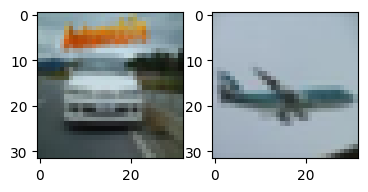

tensor([[[217, 218, 217,  ...,  37,  53,  48],
         [ 46,  48,  50,  ...,  73,  64,  37],
         [ 30,  26,  67,  ..., 139, 190, 225],
         ...,
         [ 51,  65,  56,  ..., 138, 188, 226],
         [104, 102,  94,  ..., 185, 134, 143],
         [158, 127, 138,  ..., 119, 137, 121]],

        [[136, 158, 149,  ..., 183, 215, 237],
         [ 84,  87,  87,  ..., 156, 154, 156],
         [165, 149, 165,  ..., 124, 151, 124],
         ...,
         [176, 213, 219,  ...,  98, 113,  64],
         [ 82,  97,  86,  ..., 219, 207, 197],
         [135, 125, 117,  ..., 221, 177, 179]],

        [[186,   4,  11,  ...,  41,  49,  30],
         [ 33,  41,  20,  ..., 231, 215, 205],
         [122, 117, 116,  ..., 234, 209, 212],
         ...,
         [193, 193, 132,  ...,  41,  96,  88],
         [ 30, 126, 107,  ...,  58, 255, 105],
         [ 84,  28, 155,  ..., 162, 171, 128]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


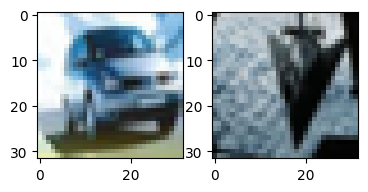

tensor([[[  0,   0,   0,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 251, 245, 251],
         [251, 248, 248,  ..., 255, 254,   0],
         ...,
         [ 92,  84, 112,  ..., 215, 211, 209],
         [  0, 255,   0,  ..., 166, 203, 188],
         [176, 212, 196,  ..., 120, 114, 148]],

        [[120, 119, 146,  ..., 177, 174, 168],
         [  0, 253,   0,  ..., 114, 132, 118],
         [109, 137, 120,  ..., 182, 192, 248],
         ...,
         [224, 212, 186,  ..., 164, 141, 198],
         [176, 147, 136,  ..., 159, 146, 134],
         [ 58,  51,  49,  ..., 229,   0, 227]],

        [[211, 224, 197,  ..., 135, 127, 179],
         [151, 129, 151,  ..., 188, 177, 165],
         [ 76,  75,  69,  ..., 218, 235, 207],
         ...,
         [  0,   0,   0,  ..., 254, 255, 254],
         [254, 255, 254,  ...,   3, 255,   6],
         [  4, 255,   4,  ...,   1,   1,   2]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


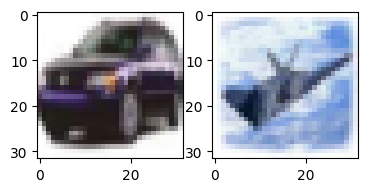

tensor([[[134, 144, 152,  ..., 168, 142, 156],
         [163, 140, 153,  ..., 125, 155,  97],
         [120, 150, 107,  ..., 227, 219, 229],
         ...,
         [168, 217, 136,  ..., 238,   2,  10],
         [208, 229, 243,  ...,  30, 251,  14],
         [ 35, 207, 225,  ..., 188, 236, 168]],

        [[213,  19, 169,  ..., 250,  15,  19],
         [213, 236, 250,  ..., 226, 234,   0],
         [ 21, 193, 215,  ..., 238,  30, 182],
         ...,
         [ 94, 153,   0,  ...,   3,  90,  96],
         [ 12, 109,  98,  ...,  27,  15,  76],
         [200, 220,  27,  ..., 112, 178, 246]],

        [[ 53, 134, 227,  ...,  16, 110, 103],
         [ 17, 113, 112,  ...,  11,   2,  61],
         [194, 211,  25,  ...,  94, 188, 240],
         ...,
         [177, 191,  10,  ...,  27, 182, 190],
         [ 15, 179, 188,  ..., 198,  42, 188],
         [196,  35, 178,  ..., 175, 189,  22]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


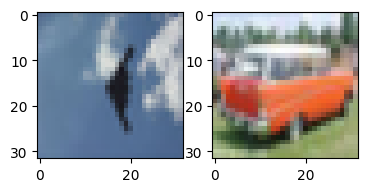

tensor([[[ 79,  90,  76,  ...,  65,  59,  85],
         [ 52,  61,  81,  ...,  76, 126,  49],
         [ 78, 133,  69,  ...,  76, 162, 163],
         ...,
         [142,  40, 113,  ..., 108, 101,  83],
         [ 77, 120,  91,  ..., 125, 189, 213],
         [103, 169, 195,  ..., 176,  89, 137]],

        [[170,  75, 136,  ...,  24,  17,   8],
         [ 63,  60,  39,  ..., 207, 252,  25],
         [199, 239,  12,  ..., 190, 111, 142],
         ...,
         [126, 203, 228,  ..., 126,  32, 102],
         [124,   0, 187,  ...,  31,  94, 121],
         [ 37,  34,  22,  ...,  96, 152, 156]],

        [[ 92, 139, 153,  ..., 130,  31, 102],
         [132,   0, 182,  ...,  59, 112, 136],
         [ 34,  33,  21,  ...,  40,  97, 119],
         ...,
         [ 13,  13, 254,  ..., 248,  23,  10],
         [252,  27,  13,  ..., 216, 200, 214],
         [212, 205, 212,  ..., 228, 235, 239]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


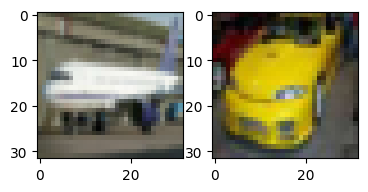

tensor([[[ 55,  71, 131,  ..., 122,  52,  57],
         [122,  34,  40,  ...,  96, 150,  60],
         [ 86, 140,  58,  ...,  76, 107, 154],
         ...,
         [232,  38,  29,  ...,  69,  97, 150],
         [ 70,  95, 160,  ...,  79, 192, 232],
         [ 73, 186, 227,  ..., 178,   1, 180]],

        [[210,  32, 219,  ...,  71,  96, 153],
         [ 71,  95, 157,  ...,  25, 188, 225],
         [ 49, 187, 225,  ..., 160, 221, 153],
         ...,
         [126,  18,  52,  ...,  58, 116,  13],
         [ 42,  93,  24,  ...,  72, 105, 155],
         [ 39,  62, 121,  ..., 162,  62,  93]],

        [[152,  52,  87,  ...,  50, 115,   3],
         [ 35,  88,   0,  ...,  69, 101, 151],
         [ 37,  60, 120,  ..., 168,  41,  75],
         ...,
         [ 17,  31,  66,  ...,  89,  27,  50],
         [ 93,  29,  52,  ...,  54,  95,  36],
         [ 54,  94,  34,  ...,  26,  50,  86]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


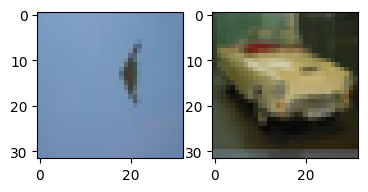

tensor([[[196, 163,  91,  ..., 100, 202, 179],
         [101, 221, 196,  ..., 135,  66, 186],
         [145,  76, 186,  ..., 160, 117,  53],
         ...,
         [198,  98, 222,  ..., 165, 124,  54],
         [171, 131,  53,  ..., 198, 120,  83],
         [232,  56,   0,  ..., 230, 108,  31]],

        [[225, 104,  40,  ..., 163, 125,  51],
         [169, 130,  55,  ..., 216, 135, 103],
         [ 10,  73,  25,  ..., 238, 125,  34],
         ...,
         [ 82, 219, 169,  ..., 253, 234, 254],
         [247, 229,   1,  ..., 161, 113,  44],
         [192, 154,  80,  ...,  47, 173, 129]],

        [[ 57, 183, 135,  ...,  11, 241,  16],
         [ 16,   2,  15,  ..., 165, 116,  46],
         [193, 154,  79,  ...,  29, 190, 138],
         ...,
         [210, 175, 122,  ..., 104, 201, 159],
         [101, 199, 157,  ..., 155,  99, 201],
         [155,  98, 202,  ..., 201, 159, 104]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


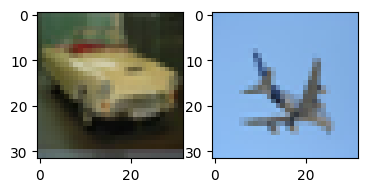

tensor([[[163, 136, 100,  ...,  69, 148, 115],
         [ 70, 147, 114,  ...,  82,  50, 137],
         [109,  74, 160,  ..., 135,  99,  54],
         ...,
         [140,  90, 214,  ...,  73,  45, 244],
         [136, 118,  69,  ..., 208, 230, 228],
         [199, 114, 115,  ..., 210, 150, 179]],

        [[138,  91, 220,  ...,  56,  29, 227],
         [107,  93,  49,  ..., 220, 176, 179],
         [162,  81,  87,  ..., 220, 160, 193],
         ...,
         [126, 201, 178,  ...,  43,  43, 137],
         [148, 169,  55,  ..., 186, 198, 196],
         [120, 133, 125,  ..., 175, 252, 213]],

        [[174,   2, 228,  ...,  19,   8, 146],
         [148, 163, 107,  ..., 178, 187, 188],
         [ 77,  89,  85,  ..., 213,  29, 248],
         ...,
         [ 89,  91,  89,  ..., 215, 213, 217],
         [213, 213, 216,  ..., 201, 197, 200],
         [200, 196, 208,  ..., 159, 163, 155]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


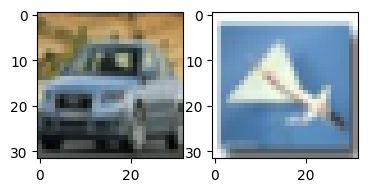

tensor([[[141, 134, 117,  ..., 116, 139, 134],
         [117, 140, 134,  ..., 137, 119, 136],
         [129, 116, 140,  ..., 139, 128, 110],
         ...,
         [160, 140, 162,  ..., 168, 154, 128],
         [160, 153, 129,  ..., 141, 175, 163],
         [142, 173, 162,  ..., 170, 149, 193]],

        [[187, 158, 159,  ..., 171, 155, 129],
         [160, 151, 127,  ..., 148, 169, 164],
         [147, 169, 159,  ..., 227, 200, 228],
         ...,
         [ 31, 107,  41,  ..., 126, 109, 128],
         [128, 109, 122,  ..., 141, 135, 119],
         [151, 144, 127,  ..., 101, 111, 109]],

        [[ 87,  99,  98,  ...,  85,  69,  82],
         [ 78,  61,  73,  ..., 148, 142, 127],
         [150, 144, 129,  ...,  90,  93,  99],
         ...,
         [ 45,  44,  37,  ...,  43,  53,  53],
         [ 43,  55,  55,  ...,  54,  49,  56],
         [ 56,  49,  53,  ...,  43,  43,  37]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


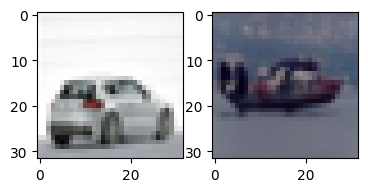

tensor([[[124, 121,  63,  ...,  52, 106, 104],
         [ 50, 100, 101,  ...,  96,  48,  83],
         [ 94,  48,  75,  ...,  35,  67,  38],
         ...,
         [129,  69, 132,  ..., 110, 118,  65],
         [165, 150,  90,  ...,  75, 147, 136],
         [ 74, 151, 137,  ..., 130,  71, 139]],

        [[131,  71, 136,  ..., 116, 120,  66],
         [161, 145,  85,  ...,  77, 151, 140],
         [ 78, 154, 140,  ..., 136,  79, 145],
         ...,
         [145, 228, 164,  ...,  72,  46,  90],
         [ 87,  57, 110,  ..., 155, 153, 102],
         [211, 185, 135,  ...,   3, 233,   0]],

        [[220, 218, 237,  ...,  76,  50,  81],
         [ 76,  47,  99,  ..., 157, 154, 104],
         [203, 176, 128,  ...,  51,  18,  48],
         ...,
         [127, 102,  70,  ...,  52, 116,  94],
         [ 50, 116,  94,  ...,  87,  55, 105],
         [ 90,  55, 102,  ...,  96,  85,  58]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


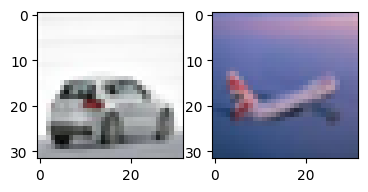

tensor([[[ 81, 112, 158,  ..., 165,  84, 114],
         [164,  86, 114,  ..., 117, 165,  93],
         [115, 163,  95,  ...,  91, 116, 167],
         ...,
         [ 26,  77,   9,  ...,  92, 118, 164],
         [ 79, 107, 155,  ..., 242, 165, 190],
         [238, 155, 179,  ..., 166, 215, 148]],

        [[166, 217, 158,  ...,  89, 112, 157],
         [ 78, 105, 151,  ..., 207, 133, 157],
         [205, 132, 155,  ..., 139, 188, 119],
         ...,
         [ 21,  49,  49,  ...,  46,  67, 240],
         [241,   2, 161,  ...,  99, 108, 119],
         [ 80,  86,  86,  ..., 214, 236, 237]],

        [[248,  31,  32,  ...,  53,  70, 236],
         [234, 247, 208,  ..., 115, 120, 128],
         [125, 128, 133,  ..., 213, 221, 223],
         ...,
         [126, 132, 111,  ..., 133, 151, 156],
         [139, 151, 156,  ..., 153, 132, 140],
         [145, 125, 135,  ..., 114, 121, 100]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


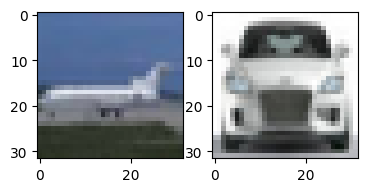

tensor([[[192, 184, 173,  ..., 170, 203, 192],
         [171, 204, 192,  ..., 169, 148, 179],
         [166, 141, 176,  ..., 107,  94,  84],
         ...,
         [ 20, 251, 195,  ...,  97, 102, 102],
         [214, 208, 188,  ..., 252,  31,  23],
         [254,  24,  16,  ...,  15, 246, 242]],

        [[ 36,  11, 242,  ..., 147, 151, 148],
         [215, 208, 190,  ...,   4,  95,  82],
         [ 57, 103,  92,  ...,  84,  56,  19],
         ...,
         [ 38,  18,  20,  ..., 242, 247, 237],
         [243, 246, 233,  ..., 107, 112, 120],
         [228, 231, 220,  ..., 212,  28,  29]],

        [[ 45,  46,  45,  ...,  74,  78,  70],
         [ 76,  78,  64,  ..., 121, 127, 131],
         [242, 244, 231,  ...,   9,  23,  23],
         ...,
         [196, 211, 162,  ..., 158, 195, 209],
         [159, 194, 212,  ...,  42, 225,  30],
         [ 41, 224,  30,  ..., 217, 233, 167]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


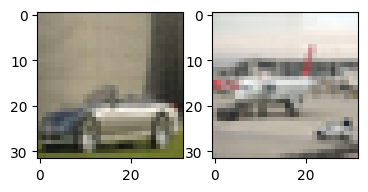

tensor([[[225, 144,  81,  ..., 121, 238, 186],
         [126, 235, 177,  ..., 167,  90,   5],
         [162,  80,   9,  ..., 241, 152,  79],
         ...,
         [230, 186, 188,  ..., 143, 107,  60],
         [230, 209, 155,  ..., 105, 248, 190],
         [137, 242, 205,  ..., 251, 213,   1]],

        [[224, 186, 167,  ..., 133, 101,  56],
         [247, 207, 153,  ..., 132,   6, 217],
         [169,   6, 245,  ..., 239, 192, 224],
         ...,
         [170, 204, 174,  ...,  46,  19,   6],
         [233, 204, 200,  ..., 195, 156, 112],
         [199, 156, 106,  ..., 113, 237, 206]],

        [[171, 214, 186,  ..., 230, 203, 217],
         [184, 152, 188,  ..., 180, 147, 100],
         [199, 162, 105,  ..., 123, 218, 189],
         ...,
         [190, 155,  97,  ..., 127, 211, 185],
         [140, 212, 187,  ..., 148, 103, 169],
         [146,  99, 168,  ..., 239, 197, 154]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


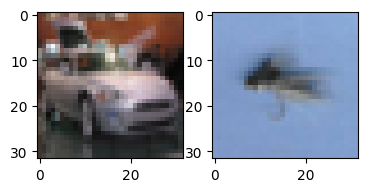

tensor([[[218, 210, 216,  ..., 201, 186, 177],
         [194, 254, 240,  ..., 207, 176, 254],
         [233, 210,  16,  ..., 252, 237, 212],
         ...,
         [ 35, 234, 231,  ...,  74,  57,  77],
         [214, 191, 202,  ..., 240,  34,  20],
         [211,  51, 234,  ...,  35, 165, 105]],

        [[ 41, 200,  24,  ..., 101,  70,  72],
         [169, 157, 180,  ..., 247, 105,  51],
         [210, 131,  39,  ...,  78, 206, 148],
         ...,
         [198, 235, 240,  ..., 120, 141, 100],
         [115, 137,  79,  ..., 186, 198, 231],
         [120, 125, 159,  ...,  20,  36,  22]],

        [[252, 214, 217,  ..., 107, 127,  68],
         [ 81, 111,  21,  ..., 163, 174, 207],
         [122, 126, 159,  ...,  73,  24,  25],
         ...,
         [126, 124, 145,  ..., 227, 168, 170],
         [207, 156, 162,  ...,  95, 124,  96],
         [ 94, 114,  99,  ..., 123, 119, 132]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


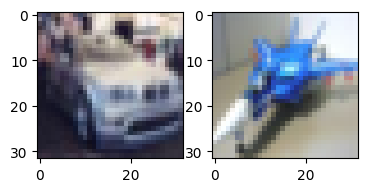

tensor([[[204, 247,  50,  ...,  26, 164, 226],
         [ 27, 165, 226,  ..., 236,  37, 181],
         [238,  39, 185,  ..., 228,  14,  73],
         ...,
         [ 10,  61, 202,  ..., 203, 247,  47],
         [218,  15,  75,  ..., 177, 174, 221],
         [  5, 171, 237,  ...,  19,  61,   8]],

        [[ 30,  57,  23,  ..., 231,  18,  73],
         [200, 252,  58,  ..., 173, 149, 181],
         [211, 174, 239,  ..., 183, 222, 195],
         ...,
         [ 21, 182, 218,  ..., 202, 228, 158],
         [205, 231, 158,  ..., 249,  39,  84],
         [185, 233,  33,  ...,  22, 218,   0]],

        [[ 28, 204, 239,  ..., 223, 252, 175],
         [222, 248, 176,  ...,   6,  51,  93],
         [217,   8,  63,  ...,  74, 222,   4],
         ...,
         [234,  22,  65,  ...,  88, 251,  50],
         [ 88, 252,  51,  ...,  54,  93, 254],
         [ 53,  93, 254,  ..., 245,  33,  73]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


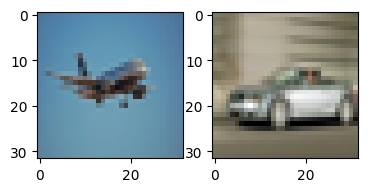

tensor([[[176, 196, 202,  ..., 234, 198, 233],
         [223, 200, 229,  ..., 168, 221, 137],
         [155, 204, 154,  ..., 120, 195, 189],
         ...,
         [ 43, 201,  17,  ..., 188, 184, 172],
         [169, 218, 208,  ..., 219,  19,  52],
         [211,  11,  44,  ...,  30, 212,   5]],

        [[ 36, 207,   8,  ..., 165, 160, 155],
         [153, 156, 152,  ..., 210,  11,  42],
         [212,   6,  37,  ...,  18, 204, 251],
         ...,
         [100, 180, 197,  ..., 139,  57, 168],
         [178,  62,   0,  ...,  72,  72,  74],
         [ 95,  81,  84,  ..., 129, 196, 192]],

        [[136, 189, 194,  ..., 180,  93, 197],
         [216,  94,  20,  ..., 120, 117, 116],
         [ 96,  81,  80,  ..., 144, 208, 210],
         ...,
         [ 53,  41,  37,  ...,  31,  75,  42],
         [ 36,  80,  46,  ...,  22,   1,  40],
         [ 19,   6,  43,  ...,  51,  37,  33]]], dtype=torch.uint8)
tensor(0.3000, grad_fn=<SelectBackward0>)


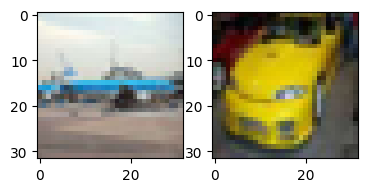

In [ ]:
# capped smote using triplet loss

momentum=0
learning_rates = [5e-5]

loss_fn_args = {}
loss_fn_args['loss_cap'] = None

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10): 
        model_aucs = []
        network = models.ConvNetWithEmbeddings(2)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_triplet_capped_loss(epoch, train_loader_tripletloss_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedBCELoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network, embeddings=True)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)


learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["triplet_loss_capped_smote", 2, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [39]:
NUM_CLASSES_REDUCED = 3
nums = (0, 3, 1)
ratio = (20, 2, 1)


reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)
targets = ratio_train_CIFAR10.labels 
class_count = np.unique(targets, return_counts=True)[1]

smote_train_CIFAR10 = class_sampling.Smote(ratio_train_CIFAR10, 5000 * NUM_CLASSES_REDUCED)


weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
oversampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(max(class_count) * NUM_CLASSES_REDUCED), replacement=True)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
undersampler = torch.utils.data.WeightedRandomSampler(samples_weight, int(min(class_count) * NUM_CLASSES_REDUCED), replacement=False)

weight *= max(class_count)

train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=oversampler)

train_loader_undersampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=undersampler)

train_loader_sampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

train_loader_smote = DataLoader(smote_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [8]:
# 3 class normal

learning_rates = [1e-4, 1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["normal", 3, nums, (1, 1, 1), learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.004159178098042806, AUC: 0.5



KeyboardInterrupt: 

In [11]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [15]:
#  3 class ratio

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["ratio", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)


Test set: Avg. loss: 0.0028148902257283527, AUC: 0.5499715000000001


Test set: Avg. loss: 0.0012899534304936728, AUC: 0.5


Test set: Avg. loss: 0.0011812520821889241, AUC: 0.5


Test set: Avg. loss: 0.0011003198623657227, AUC: 0.5


Test set: Avg. loss: 0.0012160149812698365, AUC: 0.496695


Test set: Avg. loss: 0.0012602541049321493, AUC: 0.5


Test set: Avg. loss: 0.0011723772684733072, AUC: 0.5


Test set: Avg. loss: 0.0012640552123387655, AUC: 0.5


Test set: Avg. loss: 0.001084180474281311, AUC: 0.47396475


Test set: Avg. loss: 0.0012727203766504925, AUC: 0.4995


Test set: Avg. loss: 0.0010816088120142618, AUC: 0.5045000000000001


Test set: Avg. loss: 0.0011214701334635417, AUC: 0.5035


Test set: Avg. loss: 0.0026806603272755943, AUC: 0.49925


Test set: Avg. loss: 0.0012301311095555623, AUC: 0.5


Test set: Avg. loss: 0.001151394208272298, AUC: 0.5


Test set: Avg. loss: 0.00107947838306427, AUC: 0.5


Test set: Avg. loss: 0.0020958302021026613, AUC: 0.44825000000000004




In [16]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [17]:
# 3 class oversampled 

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["oversampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.003038533369700114, AUC: 0.5


Test set: Avg. loss: 0.0010433460474014282, AUC: 0.574998


Test set: Avg. loss: 0.0011814462741216024, AUC: 0.7483075


Test set: Avg. loss: 0.001038165827592214, AUC: 0.7227574999999999


Test set: Avg. loss: 0.007914267698923746, AUC: 0.49925


Test set: Avg. loss: 0.0010645556449890136, AUC: 0.37466975


Test set: Avg. loss: 0.001031708836555481, AUC: 0.6914997500000001


Test set: Avg. loss: 0.0011311002572377523, AUC: 0.75428325


Test set: Avg. loss: 0.006719241301218669, AUC: 0.5075000000000001


Test set: Avg. loss: 0.0010695095856984456, AUC: 0.5922592499999999


Test set: Avg. loss: 0.0010078495343526204, AUC: 0.66097125


Test set: Avg. loss: 0.0009656443595886231, AUC: 0.68574


Test set: Avg. loss: 0.002060540755589803, AUC: 0.5615957500000001


Test set: Avg. loss: 0.0010401540199915568, AUC: 0.3627755


Test set: Avg. loss: 0.0009678711692492167, AUC: 0.6725415


Test set: Avg. loss: 0.0009192776083946228, AUC: 0.67

In [18]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)
rows = [] 

In [19]:
# 3 class undersampled  

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_undersampled, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["undersampled", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.0020289310614267984, AUC: 0.4756965


Test set: Avg. loss: 0.001091553012530009, AUC: 0.48456375


Test set: Avg. loss: 0.0010886570612589517, AUC: 0.4860155


Test set: Avg. loss: 0.0010853137572606406, AUC: 0.5097382500000001


Test set: Avg. loss: 0.0019787512222925823, AUC: 0.57222475


Test set: Avg. loss: 0.0011532610654830932, AUC: 0.49576575000000006


Test set: Avg. loss: 0.001145702044169108, AUC: 0.4937625


Test set: Avg. loss: 0.001140582799911499, AUC: 0.49350675


Test set: Avg. loss: 0.005084774017333984, AUC: 0.5


Test set: Avg. loss: 0.0010802105665206909, AUC: 0.50175


Test set: Avg. loss: 0.0010755322376887005, AUC: 0.502


Test set: Avg. loss: 0.0010662730137507121, AUC: 0.5022505


Test set: Avg. loss: 0.009249690055847169, AUC: 0.49975


Test set: Avg. loss: 0.0010924884875615438, AUC: 0.50599775


Test set: Avg. loss: 0.0010882760683695474, AUC: 0.5044992500000001


Test set: Avg. loss: 0.0010864359935124715, AUC: 0.50449775


Test set:

In [20]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = [] 

In [21]:
#  3 class weighted

learning_rates = [1e-3]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['weight'] = torch.from_numpy(weight).float()


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["weighted", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.00608756939570109, AUC: 0.501


Test set: Avg. loss: 0.0010771948893864949, AUC: 0.5007499999999999


Test set: Avg. loss: 0.001078349749247233, AUC: 0.49949999999999994


Test set: Avg. loss: 0.0010784133275349936, AUC: 0.50025


Test set: Avg. loss: 0.00372534704208374, AUC: 0.50023525


Test set: Avg. loss: 0.0010370986064275106, AUC: 0.49925


Test set: Avg. loss: 0.0010473136504491171, AUC: 0.49649774999999996


Test set: Avg. loss: 0.0010565840800603231, AUC: 0.5224875


Test set: Avg. loss: 0.0020539817810058592, AUC: 0.50625


Test set: Avg. loss: 0.0010878965854644776, AUC: 0.50025


Test set: Avg. loss: 0.001087069312731425, AUC: 0.49999999999999994


Test set: Avg. loss: 0.0010845698912938435, AUC: 0.50025


Test set: Avg. loss: 0.006659661134084066, AUC: 0.49401975000000004


Test set: Avg. loss: 0.0010928993225097657, AUC: 0.53216375


Test set: Avg. loss: 0.0010782272815704345, AUC: 0.54923675


Test set: Avg. loss: 0.0010686718225479126, AUC: 0.55

In [22]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = [] 

In [23]:
#  3 class focal loss

learning_rates = [1e-3]

learning_rate_aucs = []

loss_fn_args={}
loss_fn_args['reduction'] = 'mean'


for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, loss_fn=loss_fns.SoftmaxFocalLoss, loss_fn_args=loss_fn_args)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["focal_loss", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.0011305590867996215, AUC: 0.4987425


Test set: Avg. loss: 0.001101138710975647, AUC: 0.5


Test set: Avg. loss: 0.0011463310718536376, AUC: 0.5


Test set: Avg. loss: 0.0011780770619710286, AUC: 0.5


Test set: Avg. loss: 0.0038984591166178386, AUC: 0.5


Test set: Avg. loss: 0.0011603130102157593, AUC: 0.5


Test set: Avg. loss: 0.0011915287176767985, AUC: 0.5


Test set: Avg. loss: 0.0012100194692611695, AUC: 0.5


Test set: Avg. loss: 0.006762343406677246, AUC: 0.50025


Test set: Avg. loss: 0.001145007332166036, AUC: 0.5


Test set: Avg. loss: 0.0011761978069941203, AUC: 0.5


Test set: Avg. loss: 0.0011957573493321736, AUC: 0.5


Test set: Avg. loss: 0.0017103184858957927, AUC: 0.4808077500000001


Test set: Avg. loss: 0.0011710822582244873, AUC: 0.50025


Test set: Avg. loss: 0.0012000585397084554, AUC: 0.50025


Test set: Avg. loss: 0.0012189826170603433, AUC: 0.50025


Test set: Avg. loss: 0.003416938861211141, AUC: 0.5


Test set: Avg. loss: 0.00113592

In [24]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [34]:
#  3 class SMOTE

learning_rates = [1e-3]

learning_rate_aucs = []

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False)
            if (epoch + 1) % 10 == 0: 
                _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                model_aucs.append(auc)
        aucs.append(model_aucs)
    learning_rate_aucs.append(aucs)

learning_rate_aucs = np.asarray(learning_rate_aucs)

auc_mean = np.mean(learning_rate_aucs, axis=1)
auc_variance = np.var(learning_rate_aucs, axis=1)

for i in range(len(learning_rates)): 
    row = ["smote", 3, nums, ratio, learning_rates[i],
            auc_mean[i][0], auc_variance[i][0], 
            auc_mean[i][1], auc_variance[i][1],
            auc_mean[i][2], auc_variance[i][2],
            auc_mean[i][3], auc_variance[i][3]]
    rows.append(row)



Test set: Avg. loss: 0.004159178098042806, AUC: 0.5


Test set: Avg. loss: 0.0010713002681732179, AUC: 0.49825


Test set: Avg. loss: 0.0010870064496994018, AUC: 0.49875


Test set: Avg. loss: 0.0010937161048253376, AUC: 0.4980015


Test set: Avg. loss: 0.001217594623565674, AUC: 0.5495857500000001


Test set: Avg. loss: 0.0010883294343948364, AUC: 0.54002475


Test set: Avg. loss: 0.0009588491717974345, AUC: 0.6908785


Test set: Avg. loss: 0.0010892333984375, AUC: 0.6341857500000001


Test set: Avg. loss: 0.0012967588504155477, AUC: 0.44993225000000003


Test set: Avg. loss: 0.0010879942576090494, AUC: 0.49974900000000005


Test set: Avg. loss: 0.0010939101775487264, AUC: 0.4984995


Test set: Avg. loss: 0.0010963983138402302, AUC: 0.4980035


Test set: Avg. loss: 0.009516664822896322, AUC: 0.4979995


Test set: Avg. loss: 0.0010874385436375935, AUC: 0.502996


Test set: Avg. loss: 0.0010935383637746174, AUC: 0.50224575


Test set: Avg. loss: 0.0010963813463846842, AUC: 0.50149875



In [35]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names[0:13]) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []

In [ ]:
# 3 class capped loss 

momentum=0
learning_rates = [1e-2]


cap_aucs = []

caps = [1, 5, 10]

for cap in caps:
    
    loss_fn_args = {}
    loss_fn_args['loss_cap'] = cap
    
    learning_rate_aucs = []
    

    for learning_rate in learning_rates:
        aucs = []
        for i in range(10):
            model_aucs = []
            network = models.ConvNet(NUM_CLASSES_REDUCED)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
            model_aucs.append(auc)
            for epoch in range(n_epochs):
                _, _ = train.train_softmax(epoch, train_loader_smote, network, optimizer, verbose=False, loss_fn=loss_fns.CappedCELoss, loss_fn_args=loss_fn_args, smote=True)
                if (epoch + 1) % 10 == 0: 
                    _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
                    model_aucs.append(auc)
            aucs.append(model_aucs)
        learning_rate_aucs.append(aucs)

    learning_rate_aucs = np.asarray(learning_rate_aucs)

    auc_mean = np.mean(learning_rate_aucs, axis=1)
    auc_variance = np.var(learning_rate_aucs, axis=1)
    
    
    cap_aucs.append([auc_mean, auc_variance])

    
    
for i in range(len(cap_aucs)):
    auc_mean = cap_aucs[i][0]
    auc_variance = cap_aucs[i][1]
    cap = caps[i]
    for i in range(len(learning_rates)): 
        row = ["capped_smote", 3, nums, ratio, learning_rates[i],
                auc_mean[i][0], auc_variance[i][0], 
                auc_mean[i][1], auc_variance[i][1],
                auc_mean[i][2], auc_variance[i][2],
                auc_mean[i][3], auc_variance[i][3], cap]
        rows.append(row)

print(rows)



Test set: Avg. loss: 0.005159725666046142, AUC: 0.47875


Test set: Avg. loss: 0.0013107466697692871, AUC: 0.5


Test set: Avg. loss: 0.0014245965083440144, AUC: 0.5


Test set: Avg. loss: 0.0013205681641896565, AUC: 0.5


Test set: Avg. loss: 0.0036626233259836835, AUC: 0.5045


Test set: Avg. loss: 0.0012807045380274454, AUC: 0.55175


Test set: Avg. loss: 0.0008384430607159932, AUC: 0.6527735


Test set: Avg. loss: 0.0013193607727686565, AUC: 0.58771125


Test set: Avg. loss: 0.001882831374804179, AUC: 0.568451


Test set: Avg. loss: 0.0014629533290863037, AUC: 0.5


Test set: Avg. loss: 0.0013556772470474244, AUC: 0.5


Test set: Avg. loss: 0.0012844537496566773, AUC: 0.5


Test set: Avg. loss: 0.005783709685007731, AUC: 0.5153915


Test set: Avg. loss: 0.0014496474663416544, AUC: 0.68025


Test set: Avg. loss: 0.0013263502518335978, AUC: 0.72725


Test set: Avg. loss: 0.0005901109576225281, AUC: 0.6950000000000001


Test set: Avg. loss: 0.015779575983683267, AUC: 0.47575


Test s

In [ ]:
df1 = pd.read_csv('results/convnet_aucs.csv')

df2 = pd.DataFrame(rows, columns = col_names) 

df = pd.concat([df1, df2])

df.to_csv('results/convnet_aucs.csv', index=False)

rows = []